# Taller 4

Emmanuel González González - 
Diego Fernando Osorio   201513417

# Introducción 

Considere el problema Cart Pole implementado en el entorno de Gymnasium. El objetivo de este taller es comparar algoritmos de RL tabulares con sus contrapartes que utilizan aproximación de funciones.

Para esto, se resolvió el problema con los algoritmos Q-Learning y SARSA discretizando para 400 y 4000 estados variando los hiper-parametros epsilon (ϵ), gamma (γ) y tasa de aprendizaje (α). Después, se utilizó la libreria Keras-rl2 para la creación de los agentes DQN y Deep Sarsa, utilizando con ellas 2 redes neuronales una de una capa oculta de 4 neuronas y otra de una capa oculta con 16 neuronas.

En todos los experimetos de los algoritmos con sus diferentes discretizaciones o número de neuronas, se obtuvieron las curvas de aprendizaje promediada, es decir el retorno promedio, respecto a 10 experimentos y 50000 episodios.

Por último, se muestra un video de la interación del agente con el ambiente utilizando la política aprendida tanto para algoritmos tabulares como para algoritmos con aproximación de funciones, con los resultados de cada uno de los algoritmos ya entrenados que puede encontrar aquí.

## Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random 

## Discretización

Para la discretización se creó una función la cual toma la observación obtenida de la iteración con el ambiente, y respecto a los limites de cada elemento del estado:

1. Posición del carro: [-4.8 , 4.8]
2. Velicidad del carro: [-2.5 , 2.5]
3. Ángulo del palo: [-0.418 , 0.418]
4. Velocidad angular del palo: [-3 , 3]


Se tomaron intervalos del mismo tamaño de cada atributo para crear los estados, para el caso de los 400 estados, se usaron 4 intervalos para la posición del carro y velocidad de este, para los atributos de ángulo y velocidad angular se utilizaron 5 intervalos.

Para la experimentación con 4000 estados se decidió que cada atributo tenga 10 intervalos exceptuando la velocidad del carro.

Se decidió usar estos intervalos para dar siempre prioridad a la información del ángulo y posición del carro ya que son las variables principales de interes. 

In [ ]:
def discretainador(state):
    pos, vel, ang, vang  = state
    discrete_state = [np.digitize(pos, cart_p,right=True),
                      np.digitize(vel, cart_v,right=True),
                      np.digitize(ang, pole_p,right=True),
                      np.digitize(vang, pole_v,right=True)]
    if len(cart_p)<discrete_state[0]:
        discrete_state[0]=cart_p[discrete_state[0]]
    else:
        discrete_state[0]=cart_p[discrete_state[0]-1]
    
    if len(cart_v)<discrete_state[1]:
        discrete_state[1]=cart_v[discrete_state[1]]
    else:
        discrete_state[1]=cart_v[discrete_state[1]-1]
        
    if len(pole_p)<discrete_state[2]:
        discrete_state[2]=pole_p[discrete_state[2]]
    else:
        discrete_state[2]=pole_p[discrete_state[2]-1]
        
    if len(pole_v)<discrete_state[3]:
        discrete_state[3]=pole_v[discrete_state[3]]
    else:
        discrete_state[3]=pole_v[discrete_state[3]-1]
    
    return tuple(discrete_state)

## Algoritmos Tabulares

### Algoritmo SARSA Tabular

El algoritmo de SARSA Tabular permite estimar  la función de valor del par estado-acción $q(s,a)$ mediante diferencias temporales. En este algoritmo el TARGET al que se estima la función de valor está dado por $R+γq(s',a')$. La regla de actualización es de la siguiente manera:
$q(s,a)=q(s,a)+α[R+γq(s',a') - q(s,a)] $, donde los hiperparámetros $α, γ$ representan la tasa de aprendizaje y la tasa de descuento, que deben ser 'sintonizados' mediante variaciones y evaluación de desempeño mediante la curva de aprendizaje. En la regla de actualización, en la estructura del algoritmo la escogencia de la acción $a y a'$, tanto en el ciclo externo (itera sobre episiodios) como  el ciclo interno (itera sobre cada paso del episodio) hasta alcanzar estado terminal, se hace de manera e-greedy o near-greedy. El algoritmo es ON-policy porque es siempre la misma política que se utiliza para aproximar y mejorar la política.

In [ ]:
def sarsa_tab(episodios,eps,alpha,gamma):
    cont=0
    aprendizaje=[]
    env = gym.make("CartPole-v1")
    s1, info = env.reset()
    
    # inicializar valor par estado-accion q(s,a)
    q_values = {}
    for key in states:
        q_values[key] =  dict.fromkeys([0,1], 0.0)
        
    for i in range(episodios): # iterar sobre episodios
        if i<200:
            eps=eps
        elif i>= episodios*0.90:
            eps=0.05
            
        s1=discretainador(s1)
        #print(s1)
        # escoger accion a(s) con q(s,a) e-greedy
        if q_values[s1][0] >= q_values[s1][1]:
            ac1=np.random.choice([0,1],p=[1-eps,eps])
        else:
            ac1=np.random.choice([1,0],p=[1-eps,eps])
        #print(ac1)

        while True: # iterar sobre pasos de cada episodio
            
            # dar paso1 con s1,ac1
            s2, reward, terminated, truncated, info = env.step(ac1)
            s2=discretainador(s2)
            
            # escoger accion a'(2) con q(s2,a') e-greedy
            if q_values[s2][0] >= q_values[s2][1]:
                ac2=np.random.choice([0,1],p=[1-eps,eps])
            else:
                ac2=np.random.choice([1,0],p=[1-eps,eps])
            
            # actualizar q_values
            q_values[s1][ac1] = q_values[s1][ac1] + alpha*(reward+gamma*q_values[s2][ac2]-q_values[s1][ac1])
        
            s1 = s2 
            ac1 = ac2
            
            if terminated or truncated:
                s1,_=env.reset()
                aprendizaje.append(cont)
                cont=0
                break
            
            cont+=1
            
    pi =dict.fromkeys(states,0)
    for i in states:
        if (q_values[i][0] >= q_values[i][1]):
            pi[i]=0
        else:
            pi[i]=1
           
    return pi,q_values,aprendizaje



### Algoritmo Q-Learning

El algoritmo de Q-Learning Tabular permite estimar  la función de valor del par estado-acción $q(s,a)$ mediante diferencias temporales. En este algoritmo el TARGET al que se estima la función de valor está dado por $R+γ max(q(s',a'))$. La regla de actualización es de la siguiente manera:
$q(s,a)=q(s,a)+α[R+γ max(q(s',a') - q(s,a)] $, donde los hiperparámetros $α, γ$ representan la tasa de aprendizaje y la tasa de descuento, que deben ser 'sintonizados' mediante variaciones y evaluación de desempeño mediante la curva de aprendizaje. En la regla de actualización, en la estructura del algoritmo la escogencia de la acción $a$ es e-greedy con respecto a la función de valor $q(s,a)$ mientras que la escogencia de la acción $a'$ es greedy con respecto a la función de valor $q(s,a)$ ambas en el ciclo interno del algoritmo (itera sobre episiodios).

El algoritmo es OFF-policy porque la política que aproxima la función de valor es diferente a la política que hacer control sobre el algoritmo, es decir se mejora una política diferente en cada iteración del algoritmo.

In [ ]:
def QLN(episodios,epsilon,alpha,gamma):
    
    env = gym.make("CartPole-v1")
    s1, info = env.reset()
    cont=0
    aprendizaje=[]
    
    # inicializar valor par estado-accion q(s,a)
    q_values = {}
    for key in states:
        q_values[key] =  dict.fromkeys([0,1], 0.0)
    #print(q_values)
    
    for i in range(episodios): # iterar sobre episodios
        if i<200:
            eps=epsilon
        elif i>= episodios*0.90:
            eps=0.05
             
        s1=discretainador(s1)
        #print(s1)
        

        while True: # iterar sobre pasos de cada episodio

                # escoger accion a(s) con q(s,a) e-greedy
            if q_values[s1][0] >= q_values[s1][1]:
                ac1=np.random.choice([0,1],p=[1-eps,eps])
            else:
                ac1=np.random.choice([1,0],p=[1-eps,eps])
            #print(ac1)
            # dar paso1 con s1,ac1
            s2, reward, terminated, truncated, info = env.step(ac1)
            s2=discretainador(s2)
            
            # escoger accion a'(2) con q(s2,a') e-greedy
            if q_values[s2][0] >= q_values[s2][1]:
                ac2=0
            else:
                ac2=1
            
            # actualizar q_values
            q_values[s1][ac1] = q_values[s1][ac1] + alpha*(reward+gamma*q_values[s2][ac2]-q_values[s1][ac1])
        
            s1 = s2 
            
            if terminated or truncated:
                s1,_=env.reset()
                aprendizaje.append(cont)
                cont=0
                break
                # actualizar par estado-accion
            
            cont+=1
    
    # política aprendida
    piq =dict.fromkeys(states,0)
    for i in states:
        if (q_values[i][0] >= q_values[i][1]):
            piq[i]=0
        else:
            piq[i]=1
           
    return piq,q_values,aprendizaje
        


## Curva de aprendizaje (tabular)

La curva de aprendizaje o retorno mostrado se genera mediante una aproximación incremental del la recompensa obtenida en cada experimento realizado, ponderada por el número de experimentos $i$ hasta el momento.

In [ ]:
def retorno_prom(N,metodo,episodios,eps,alpha,gamma):
    
    # vector de retorno
    retorno = np.zeros(episodios)
    
    for i in range(1,N): # iterar sobre experimentos
        
        if metodo == "sarsa":    
            pi,q,aps=sarsa_tab(episodios,eps,alpha,gamma)
            # retorno incremental    
            retorno = [retorno[j]+(1/i)*(aps[j]-retorno[j]) for j in range(len(aps))]
               
        elif metodo == "qlearning":
            piq,q,apq=QLN(episodios,eps,alpha,gamma)  
            # retorno incremental  
            retorno = [retorno[j]+(1/i)*(apq[j]-retorno[j]) for j in range(len(apq))]
        
    fig=plt.figure(figsize=(10, 7))
    plt.plot(retorno)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.legend(['Recompensa'])
    plt.grid(True)
    plt.show()
    
    return retorno


## Experimentos Sarsa Tabular

### Discretizacion: 400 estados

In [ ]:
# discretizacion 1
cart_p= np.linspace(-4.8,4.8,num=4)
cart_v= np.linspace(-2.5,2.5,num=4)
pole_p= np.linspace(-0.418,0.418,num=5)
pole_v= np.linspace(-3,3,num=5)

cart_p,cart_v,pole_p,pole_v

(array([-4.8, -1.6,  1.6,  4.8]),
 array([-2.5       , -0.83333333,  0.83333333,  2.5       ]),
 array([-0.418, -0.209,  0.   ,  0.209,  0.418]),
 array([-3. , -1.5,  0. ,  1.5,  3. ]))

In [ ]:
states = []
for i in cart_p:
    for j in cart_v:
        for k in pole_p:
            for l in pole_v:
                states.append((i,j,k,l))
print(len(states))

400


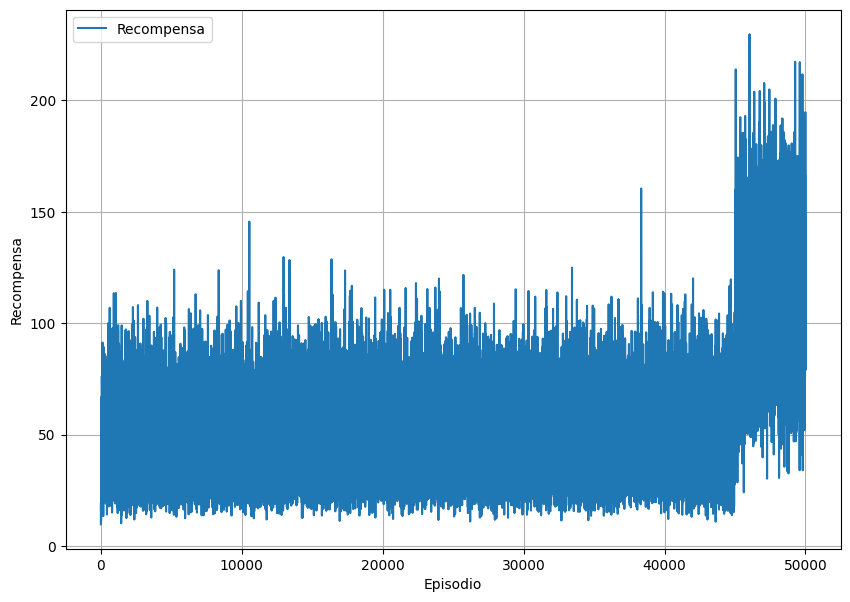

[9.777777777777779,
 14.444444444444445,
 11.777777777777779,
 10.444444444444445,
 13.11111111111111,
 19.444444444444443,
 13.444444444444445,
 13.0,
 12.222222222222221,
 15.777777777777779,
 17.666666666666668,
 14.666666666666664,
 14.222222222222223,
 12.222222222222221,
 11.88888888888889,
 11.333333333333334,
 22.77777777777778,
 23.22222222222222,
 19.333333333333332,
 16.11111111111111,
 24.666666666666668,
 15.333333333333334,
 31.77777777777778,
 17.88888888888889,
 25.444444444444443,
 22.777777777777775,
 16.111111111111114,
 14.111111111111109,
 34.44444444444445,
 15.000000000000002,
 33.22222222222223,
 20.77777777777778,
 29.11111111111111,
 39.333333333333336,
 54.8888888888889,
 29.555555555555557,
 32.888888888888886,
 17.444444444444443,
 29.0,
 32.888888888888886,
 41.44444444444444,
 16.11111111111111,
 27.444444444444443,
 29.333333333333332,
 13.88888888888889,
 19.666666666666668,
 27.22222222222222,
 48.0,
 37.0,
 19.77777777777778,
 57.44444444444445,
 67.0

In [ ]:
retorno_prom(10,"sarsa",50000,0.2,0.1,0.99)

### Discretizacion: 4000 estados

In [ ]:
# discretizacion 2
cart_p= np.linspace(-4.8,4.8,num=10)
cart_v= np.linspace(-2.5,2.5,num=4)
pole_p= np.linspace(-0.418,0.418,num=10)
pole_v= np.linspace(-3,3,num=10)

cart_p,cart_v,pole_p,pole_v

(array([-4.8       , -3.73333333, -2.66666667, -1.6       , -0.53333333,
         0.53333333,  1.6       ,  2.66666667,  3.73333333,  4.8       ]),
 array([-2.5       , -0.83333333,  0.83333333,  2.5       ]),
 array([-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
         0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ]),
 array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
         0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ]))

In [ ]:
states = []
for i in cart_p:
    for j in cart_v:
        for k in pole_p:
            for l in pole_v:
                states.append((i,j,k,l))
print(len(states))

4000


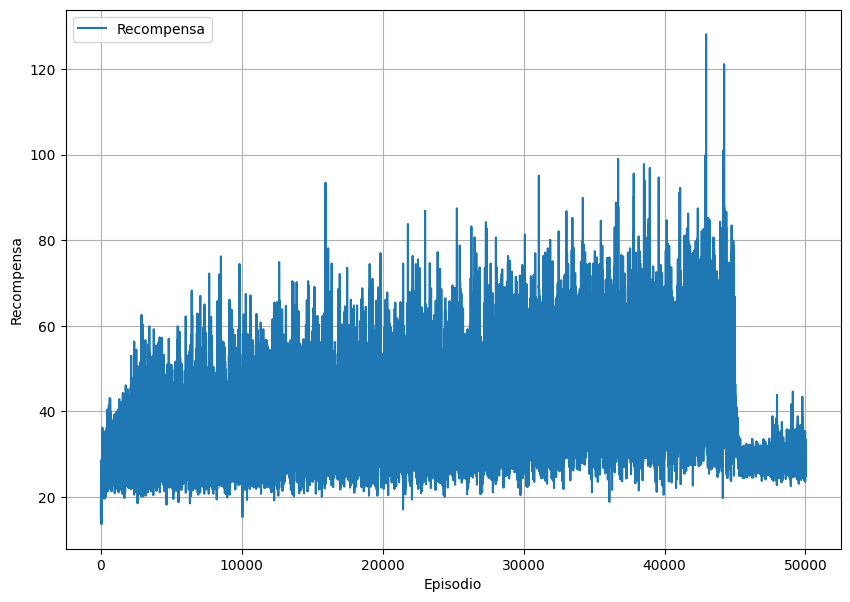

[18.666666666666668,
 18.222222222222218,
 17.444444444444443,
 17.88888888888889,
 16.666666666666668,
 16.333333333333332,
 14.88888888888889,
 19.77777777777778,
 17.333333333333332,
 22.77777777777778,
 17.333333333333336,
 15.333333333333334,
 19.11111111111111,
 18.22222222222222,
 20.888888888888886,
 16.22222222222222,
 17.555555555555557,
 19.22222222222222,
 19.666666666666668,
 18.0,
 18.0,
 16.77777777777778,
 17.333333333333332,
 17.0,
 22.88888888888889,
 18.444444444444443,
 20.666666666666668,
 16.22222222222222,
 17.11111111111111,
 15.555555555555555,
 28.22222222222222,
 27.444444444444443,
 25.333333333333332,
 23.555555555555557,
 24.555555555555557,
 21.555555555555557,
 19.888888888888893,
 27.333333333333336,
 18.555555555555557,
 28.666666666666664,
 23.555555555555557,
 23.444444444444443,
 18.111111111111107,
 27.666666666666668,
 15.222222222222221,
 21.66666666666667,
 23.333333333333332,
 13.666666666666666,
 13.666666666666666,
 18.666666666666664,
 20.55

In [ ]:
retorno_prom(10,"sarsa",50000,0.2,0.1,0.99)

In [ ]:
env = gym.make("CartPole-v1") # render_mode="human")
observation, info = env.reset()
contador=0
maximo=0
for i in range(1000):
    action = pi[discretainador(observation)]  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        print('mori porque lo logre:3 :',truncated)
        observation, info = env.reset()
        if contador>maximo:
            maximo=contador
        contador=0
        
    else:
        contador+=1
        print(contador,'aun no',action,'carro en ',observation[0],'angulo en ',observation[2])
        
print(maximo)
env.close()

1 aun no 1 carro en  -0.04467557 angulo en  -0.035362512
2 aun no 1 carro en  -0.039912 angulo en  -0.04125548
3 aun no 0 carro en  -0.031236278 angulo en  -0.053220905
4 aun no 1 carro en  -0.026450977 angulo en  -0.059598178
5 aun no 0 carro en  -0.017748918 angulo en  -0.07215506
6 aun no 0 carro en  -0.012931692 angulo en  -0.07924526
7 aun no 1 carro en  -0.011994983 angulo en  -0.08095374
8 aun no 0 carro en  -0.0071350103 angulo en  -0.08899412
9 aun no 1 carro en  -0.006152758 angulo en  -0.09171246
10 aun no 0 carro en  -0.0012449751 angulo en  -0.10081839
11 aun no 1 carro en  -0.00021146577 angulo en  -0.104675844
12 aun no 0 carro en  0.00475022 angulo en  -0.11498745
13 aun no 1 carro en  0.0058418214 angulo en  -0.120140076
14 aun no 0 carro en  0.010864619 angulo en  -0.1318252
15 aun no 1 carro en  0.0120223705 angulo en  -0.13845925
16 aun no 0 carro en  0.017114678 angulo en  -0.15171683
17 aun no 0 carro en  0.018347953 angulo en  -0.16005279
18 aun no 1 carro en  0.

## Experimentos Q-Learning Tabular

### Discretizacion: 400 estados

In [ ]:
# discretizacion 1
cart_p= np.linspace(-4.8,4.8,num=4)
cart_v= np.linspace(-2.5,2.5,num=4)
pole_p= np.linspace(-0.418,0.418,num=5)
pole_v= np.linspace(-3,3,num=5)

cart_p,cart_v,pole_p,pole_v

(array([-4.8, -1.6,  1.6,  4.8]),
 array([-2.5       , -0.83333333,  0.83333333,  2.5       ]),
 array([-0.418, -0.209,  0.   ,  0.209,  0.418]),
 array([-3. , -1.5,  0. ,  1.5,  3. ]))

In [ ]:
states = []
for i in cart_p:
    for j in cart_v:
        for k in pole_p:
            for l in pole_v:
                states.append((i,j,k,l))
print(len(states))

400


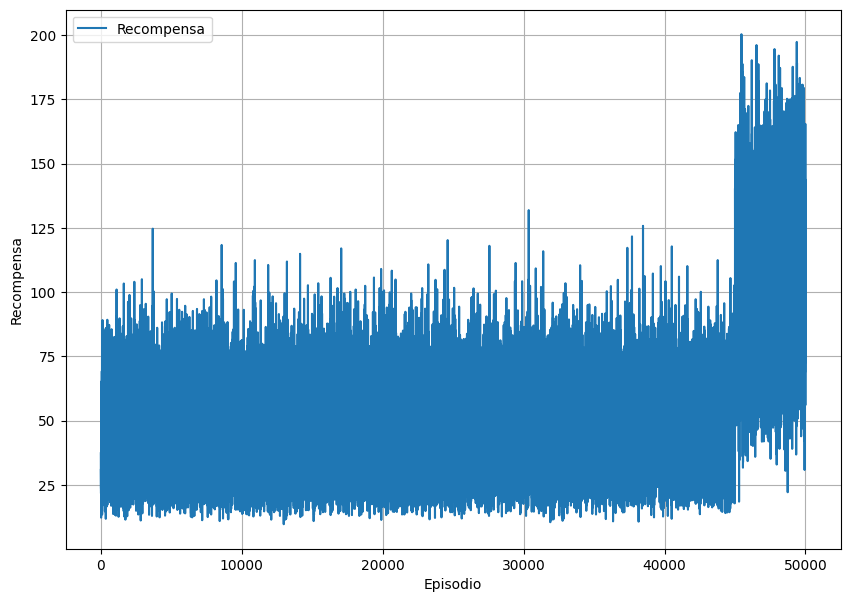

[30.77777777777778,
 28.22222222222222,
 28.555555555555557,
 24.555555555555557,
 37.666666666666664,
 24.11111111111111,
 30.444444444444443,
 24.555555555555557,
 21.666666666666668,
 23.555555555555557,
 30.333333333333332,
 28.444444444444443,
 29.666666666666668,
 47.0,
 42.55555555555556,
 28.77777777777778,
 28.555555555555557,
 12.222222222222221,
 17.0,
 19.666666666666668,
 21.11111111111111,
 17.22222222222222,
 15.444444444444445,
 26.0,
 19.555555555555557,
 27.11111111111111,
 13.666666666666666,
 25.111111111111107,
 14.777777777777779,
 19.666666666666668,
 23.666666666666668,
 14.777777777777779,
 23.22222222222222,
 23.666666666666668,
 27.0,
 28.666666666666668,
 30.666666666666668,
 38.44444444444444,
 37.22222222222222,
 42.111111111111114,
 21.000000000000004,
 30.0,
 40.55555555555556,
 42.666666666666664,
 36.22222222222222,
 16.22222222222222,
 31.88888888888889,
 28.77777777777778,
 33.333333333333336,
 46.666666666666664,
 37.0,
 50.22222222222222,
 40.44444

In [ ]:
retorno_prom(10,"qlearning",50000,0.2,0.1,0.99)

### Discretizacion: 4000 estados

In [ ]:
# discretizacion
cart_p= np.linspace(-4.8,4.8,num=10)
cart_v= np.linspace(-2.5,2.5,num=4)
pole_p= np.linspace(-0.418,0.418,num=10)
pole_v= np.linspace(-3,3,num=10)

cart_p,cart_v,pole_p,pole_v

(array([-4.8       , -3.73333333, -2.66666667, -1.6       , -0.53333333,
         0.53333333,  1.6       ,  2.66666667,  3.73333333,  4.8       ]),
 array([-2.5       , -0.83333333,  0.83333333,  2.5       ]),
 array([-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
         0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ]),
 array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
         0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ]))

In [ ]:
states = []
for i in cart_p:
    for j in cart_v:
        for k in pole_p:
            for l in pole_v:
                states.append((i,j,k,l))
print(len(states))

4000


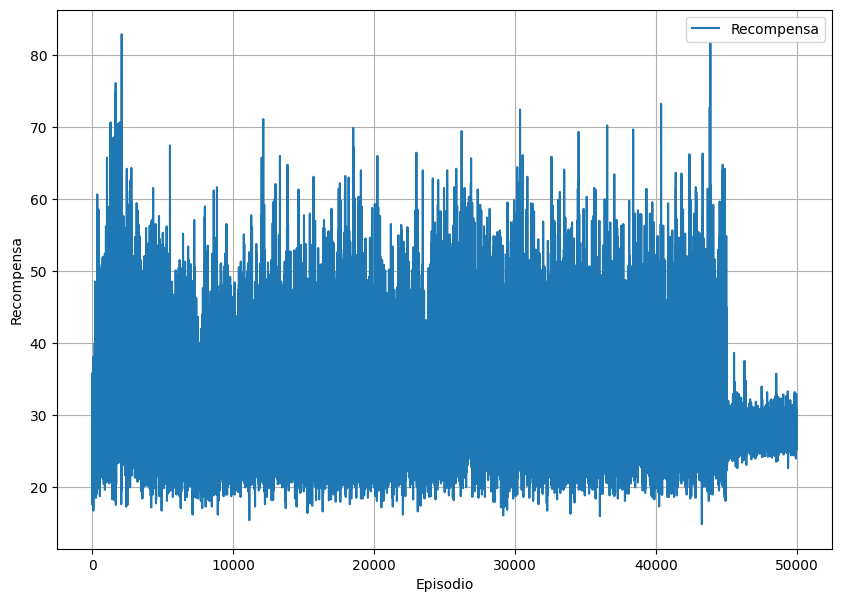

[17.666666666666668,
 19.444444444444443,
 32.111111111111114,
 24.22222222222222,
 34.333333333333336,
 28.999999999999996,
 25.666666666666668,
 27.000000000000004,
 20.22222222222222,
 29.666666666666668,
 24.444444444444443,
 19.333333333333332,
 26.11111111111111,
 18.11111111111111,
 35.44444444444444,
 29.0,
 25.22222222222222,
 28.11111111111111,
 32.888888888888886,
 25.0,
 18.88888888888889,
 21.444444444444443,
 24.555555555555557,
 22.88888888888889,
 28.11111111111111,
 22.88888888888889,
 28.666666666666664,
 23.111111111111107,
 21.11111111111111,
 22.0,
 22.0,
 26.0,
 35.888888888888886,
 23.77777777777778,
 22.333333333333332,
 22.88888888888889,
 24.0,
 23.66666666666667,
 24.444444444444443,
 20.0,
 24.11111111111111,
 21.88888888888889,
 31.666666666666668,
 23.77777777777778,
 33.22222222222222,
 18.666666666666664,
 26.444444444444443,
 32.0,
 30.555555555555557,
 25.555555555555557,
 29.22222222222222,
 27.11111111111111,
 26.88888888888889,
 24.444444444444443,


In [ ]:
retorno_prom(10,"qlearning",50000,0.3,0.1,0.99)

In [ ]:
env = gym.make("CartPole-v1") # render_mode="human"
observation, info = env.reset()
contador=0
maximo=0
for i in range(1000):
    action = piq[discretainador(observation)]  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        print('mori porque lo logre:3 :',truncated)
        observation, info = env.reset()
        if contador>maximo:
            maximo=contador
        contador=0
        
    else:
        contador+=1
        print(contador,'aun no',action,'carro en ',observation[0],'angulo en ',observation[2])
        
print(maximo)
env.close()

### Discretizacion: 10000 estados

In [ ]:
# discretizacion 3
cart_p= np.linspace(-4.8,4.8,num=10)
cart_v= np.linspace(-2.5,2.5,num=10)
pole_p= np.linspace(-0.418,0.418,num=10)
pole_v= np.linspace(-3,3,num=10)

cart_p,cart_v,pole_p,pole_v

10000

In [ ]:
states = []
for i in cart_p:
    for j in cart_v:
        for k in pole_p:
            for l in pole_v:
                states.append((i,j,k,l))
print(len(states))

In [ ]:
retorno_prom(100,"qlearning",50000,0.3,0.1,0.99)

In [ ]:
env = gym.make("CartPole-v1") # render_mode="human"
observation, info = env.reset()
contador=0
maximo=0
for i in range(1000):
    action = piq[discretainador(observation)]  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        print('mori porque lo logre:3 :',truncated)
        observation, info = env.reset()
        if contador>maximo:
            maximo=contador
        contador=0
        
    else:
        contador+=1
        print(contador,'aun no',action,'carro en ',observation[0],'angulo en ',observation[2])
        
print(maximo)
env.close()

## Aproximacion de Funciones

### Algoritmo DQN

In [ ]:
import numpy as np
import random
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import TrainEpisodeLogger

# algoritmo DQN: crea el agente DQN de libreria keras-rl2. entrena el agente, guarda los pasos de entrenamiento por cada episodio y retorna el vector de recompensas 
# parametros: neurons= numero de neuronas de NN main, exp_replay_size= tamaño de memoria, nb_steps= numero de pasos de entrenamiento por episodio, test_episodes= numero de episodios de entrenamiento

def DQN(neurons,exp_replay_size,nb_steps,test_episodes):
    
    # ambiente 
    ENV_NAME = 'CartPole-v1'

    # Set random seeds for reproducibility
    np.random.seed(123)
    random.seed(123)
    tf.random.set_seed(123)

    # crear ambiente
    env = gym.make(ENV_NAME)
    nb_actions = env.action_space.n

    # crear NN (main)
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(neurons))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    print(model.summary())

    # crear memoria (exp. replay)
    memory = SequentialMemory(limit=exp_replay_size, window_length=1)
    # crear politica 
    policy = BoltzmannQPolicy()

    # crear agente DQN (aprendizaje) - libreria keras-rl2 
    # parametros: model= NN main,nb_actions= espacio de acciones de ambiente
    # memory=experience replay, target_model_update= eps actualizacion, policy= politica
    dqn = DQNAgent(
        model=model,
        nb_actions=nb_actions,
        memory=memory,
        nb_steps_warmup=10,
        target_model_update=1e-2,
        policy=policy
    )

    # Compile the agent
    dqn.compile(Adam(lr=1e-3), metrics=['mse'])
    
    
    # crear clase EpisodeStepsCallback callback custom que guarda los episodios acumulados por episodio de entrenamiento
    # atributos: steps del episodio 
    # metodos: on_episode_end= retorna numero de pasos al final del episodio
    class EpisodeStepsCallback(TrainEpisodeLogger):
        def __init__(self):
            super(EpisodeStepsCallback, self).__init__()
            self.steps = []

        def on_episode_end(self, episode, logs):
            episode_steps = logs['nb_steps']
            self.steps.append(episode_steps)
            print(f'Episode {episode + 1}: Steps: {episode_steps}')
                
    # crear objeto  (clase) callback para guarda los episodios acumulados por episodio
    callbacks = EpisodeStepsCallback()
    
    dqn.fit(env, nb_steps=nb_steps, visualize=False, verbose=2, callbacks=[callbacks]) # nb_max_episode_steps=1000  

    # guardar pesos de NN
    dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

    # evaluar agente DQN en episodios de evaluacion
    dqn.test(env, nb_episodes=test_episodes, visualize=False, verbose=2)

    # steps del episodio de entrenamiento
    episode_steps = callbacks.steps
    
    # vector de recompensas 
    rewards = [episode_steps[0]]
    
    for i in range(1,len(episode_steps)): 
        rewards.append(episode_steps[i]-episode_steps[i-1])
    
    return rewards,len(rewards) 



### Algoritmo DeepSARSA   

In [ ]:

import numpy as np
import random
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import TrainEpisodeLogger

# algoritmo Deep SARSA: crea el agente SARSA de libreria keras-rl2. entrena el agente, guarda los pasos de entrenamiento por cada episodio y retorna el vector de recompensas 
# parametros: neurons= numero de neuronas de NN main, exp_replay_size= tamaño de memoria, nb_steps= numero de pasos de entrenamiento por episodio, test_episodes= numero de episodios de entrenamiento

def deepSARSA(neurons,exp_replay_size,nb_steps,test_episodes):
    
    ENV_NAME = 'CartPole-v1'


    np.random.seed(123)
    random.seed(123)
    tf.random.set_seed(123)

     # crear ambiente
    env = gym.make(ENV_NAME)
    nb_actions = env.action_space.n

     # crear NN (main)
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(neurons))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    print(model.summary())
    
    
   # crear memoria (exp. replay)
    memory = SequentialMemory(limit=exp_replay_size, window_length=1)
    # crear politica 
    policy = BoltzmannQPolicy()

    # crear agente SARSA (aprendizaje) - libreria keras-rl2 
    # parametros: model= NN main,nb_actions= espacio de acciones de ambiente
    # policy= politica
    sarsa = SARSAAgent(
        model=model,
        nb_actions=nb_actions,
        nb_steps_warmup=10,
        policy=policy
    )
    
    sarsa.compile(Adam(lr=1e-3), metrics=['mse'])

    # crear clase EpisodeStepsCallback callback custom que guarda los episodios acumulados por episodio de entrenamiento
    # atributos: steps del episodio 
    # metodos: on_episode_end= retorna numero de pasos al final del episodio
    class EpisodeStepsCallback(TrainEpisodeLogger):
        def __init__(self):
            super(EpisodeStepsCallback, self).__init__()
            self.steps = []

        def on_episode_end(self, episode, logs):
            episode_steps = logs['nb_steps']
            self.steps.append(episode_steps)
            print(f'Episode {episode + 1}: Steps: {episode_steps}')

    # crear objeto  (clase) callback para guarda los episodios acumulados por episodio
    callbacks = EpisodeStepsCallback()
    sarsa.fit(env, nb_steps=nb_steps, visualize=False, verbose=2, callbacks=[callbacks]) # nb_max_episode_steps=1000  

    # guardar pesos de NN
    sarsa.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)
    
    # evaluar agente DQN en episodios de evaluacion
    sarsa.test(env, nb_episodes=test_episodes, visualize=False, verbose=0)

    # steps del episodio de entrenamiento
    episode_steps = callbacks.steps
    
    # vector de recompensas 
    rewards = [episode_steps[0]]
    
    for i in range(1,len(episode_steps)): 
        rewards.append(episode_steps[i]-episode_steps[i-1])
    
    return rewards, len(rewards) 

rewards,num_episodes= deepSARSA(16,50000,5000,10)
# rewards =deepSARSA(neurons,exp_replay_size,nb_steps,test_episodes)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Training for 5000 steps ...
Training for 5000 steps ...


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_ch

done, took 0.561 seconds
done, took 0.561 seconds


IndexError: ignored

In [ ]:
rewards,len(rewards)

([38,
  14,
  16,
  36,
  23,
  15,
  21,
  29,
  29,
  13,
  15,
  18,
  16,
  13,
  24,
  12,
  22,
  24,
  30,
  14,
  20,
  15,
  27,
  12,
  16,
  20,
  15,
  28,
  19,
  19,
  10,
  17,
  22,
  17,
  22,
  35,
  35,
  18,
  16,
  13,
  14,
  11,
  53,
  20,
  27,
  11,
  16,
  12,
  15,
  10,
  42,
  21,
  23,
  31,
  20,
  46,
  24,
  39,
  30,
  28,
  56,
  13,
  31,
  18,
  11,
  74,
  22,
  42,
  17,
  19,
  18,
  50,
  36,
  26,
  18,
  19,
  34,
  13,
  11,
  23,
  39,
  27,
  19,
  29,
  25,
  22,
  10,
  100,
  28,
  39,
  52,
  17,
  23,
  14,
  17,
  40,
  33,
  26,
  80,
  47,
  17,
  27,
  54,
  48,
  19,
  53,
  38,
  31,
  27,
  33,
  41,
  17,
  33,
  15,
  23,
  20,
  38,
  16,
  20,
  53,
  31,
  44,
  30,
  17,
  32,
  37,
  38,
  20,
  18,
  28,
  16,
  26,
  19,
  18,
  35,
  37,
  23,
  21,
  27,
  22,
  14,
  19,
  22,
  41,
  79,
  25,
  38,
  49,
  35,
  34,
  34,
  14,
  31,
  42,
  51,
  27,
  16,
  65,
  18,
  57,
  51,
  38,
  13,
  46,
  82,
  26,
  2

### Curva de Aprendizaje: Deep Learning

La curva de aprendizaje o retorno mostrado con aproximación de funciones se genera mediante la generación de vectores o listas de recompensas obtenidas en cada experimento, las cuales son truncadas por el menor número de pasos. El aprendizaje es entonces el promedio de los vectores de recompensa truncados en N experimentos realizados.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 4)                 0         
                                                                 
 dense_62 (Dense)            (None, 16)                80        
                                                                 
 activation_62 (Activation)  (None, 16)                0         
                                                                 
 dense_63 (Dense)            (None, 2)                 34        
                                                                 
 activation_63 (Activation)  (None, 2)                 0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 1500 steps ...
Training for 1500 step

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 44
   44/1500: episode: 1, duration: 3.052s, episode steps:  44, steps per second:  14, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 0.515828, mse: 0.528229, mean_q: 0.240584
Episode 2: Steps: 68
   68/1500: episode: 2, duration: 0.091s, episode steps:  24, steps per second: 265, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 0.584759, mse: 0.621113, mean_q: 0.299516
Episode 3: Steps: 114
  114/1500: episode: 3, duration: 0.180s, episode steps:  46, steps per second: 255, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 0.507822, mse: 0.536679, mean_q: 0.269249
Episode 4: Steps: 167
  167/1500: episode: 4, duration: 0.208s, episode steps:  53, steps per second: 255, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 0.509139, mse: 0.588217, mean_q:

Episode 39: Steps: 734
  734/1500: episode: 39, duration: 0.043s, episode steps:  10, steps per second: 233, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 4.640204, mse: 10.592229, mean_q: 5.854249
Episode 40: Steps: 745
  745/1500: episode: 40, duration: 0.048s, episode steps:  11, steps per second: 230, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 5.234535, mse: 13.758015, mean_q: 6.595939
Episode 41: Steps: 758
  758/1500: episode: 41, duration: 0.055s, episode steps:  13, steps per second: 237, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 4.138764, mse: 10.171661, mean_q: 5.603947
Episode 42: Steps: 767
  767/1500: episode: 42, duration: 0.036s, episode steps:   9, steps per second: 251, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 5.680571, mse: 12.8

Episode 74: Steps: 1093
 1093/1500: episode: 74, duration: 0.042s, episode steps:  11, steps per second: 260, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 4.618270, mse: 18.639064, mean_q: 6.835937
Episode 75: Steps: 1103
 1103/1500: episode: 75, duration: 0.038s, episode steps:  10, steps per second: 265, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 5.164468, mse: 22.721627, mean_q: 7.478643
Episode 76: Steps: 1112
 1112/1500: episode: 76, duration: 0.033s, episode steps:   9, steps per second: 270, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 5.098190, mse: 20.943967, mean_q: 7.264807
Episode 77: Steps: 1123
 1123/1500: episode: 77, duration: 0.040s, episode steps:  11, steps per second: 273, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 2.981497, mse: 

Episode 109: Steps: 1461
 1461/1500: episode: 109, duration: 0.049s, episode steps:  12, steps per second: 244, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 3.669512, mse: 22.891091, mean_q: 7.558749
Episode 110: Steps: 1472
 1472/1500: episode: 110, duration: 0.043s, episode steps:  11, steps per second: 259, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 3.325037, mse: 22.376447, mean_q: 7.464551
Episode 111: Steps: 1483
 1483/1500: episode: 111, duration: 0.043s, episode steps:  11, steps per second: 256, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 2.631067, mse: 22.468938, mean_q: 7.415060
Episode 112: Steps: 1493
 1493/1500: episode: 112, duration: 0.039s, episode steps:  10, steps per second: 258, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 4.44737

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 52
   52/1500: episode: 1, duration: 3.181s, episode steps:  52, steps per second:  16, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.517337, mse: 0.531285, mean_q: 0.239735
Episode 2: Steps: 71
   71/1500: episode: 2, duration: 0.073s, episode steps:  19, steps per second: 261, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 0.580248, mse: 0.615564, mean_q: 0.377640
Episode 3: Steps: 109
  109/1500: episode: 3, duration: 0.146s, episode steps:  38, steps per second: 261, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.502396, mse: 0.542787, mean_q: 0.293911
Episode 4: Steps: 163
  163/1500: episode: 4, duration: 0.226s, episode steps:  54, steps per second: 238, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 0.535907, mse: 0.579924, mean_q:

Episode 34: Steps: 777
  777/1500: episode: 34, duration: 0.047s, episode steps:  12, steps per second: 253, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 2.233341, mse: 16.778839, mean_q: 6.047876
Episode 35: Steps: 787
  787/1500: episode: 35, duration: 0.039s, episode steps:  10, steps per second: 259, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 2.592138, mse: 15.151673, mean_q: 5.716091
Episode 36: Steps: 802
  802/1500: episode: 36, duration: 0.059s, episode steps:  15, steps per second: 255, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 2.383973, mse: 13.519515, mean_q: 5.386017
Episode 37: Steps: 814
  814/1500: episode: 37, duration: 0.046s, episode steps:  12, steps per second: 259, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 3.132456, mse: 16.8

Episode 68: Steps: 1246
 1246/1500: episode: 68, duration: 0.091s, episode steps:  22, steps per second: 242, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 2.063238, mse: 25.083315, mean_q: 7.241191
Episode 69: Steps: 1263
 1263/1500: episode: 69, duration: 0.069s, episode steps:  17, steps per second: 245, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 2.517384, mse: 30.065595, mean_q: 7.768131
Episode 70: Steps: 1280
 1280/1500: episode: 70, duration: 0.068s, episode steps:  17, steps per second: 249, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 1.957432, mse: 27.774286, mean_q: 7.572877
Episode 71: Steps: 1296
 1296/1500: episode: 71, duration: 0.066s, episode steps:  16, steps per second: 243, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 2.847675, mse: 

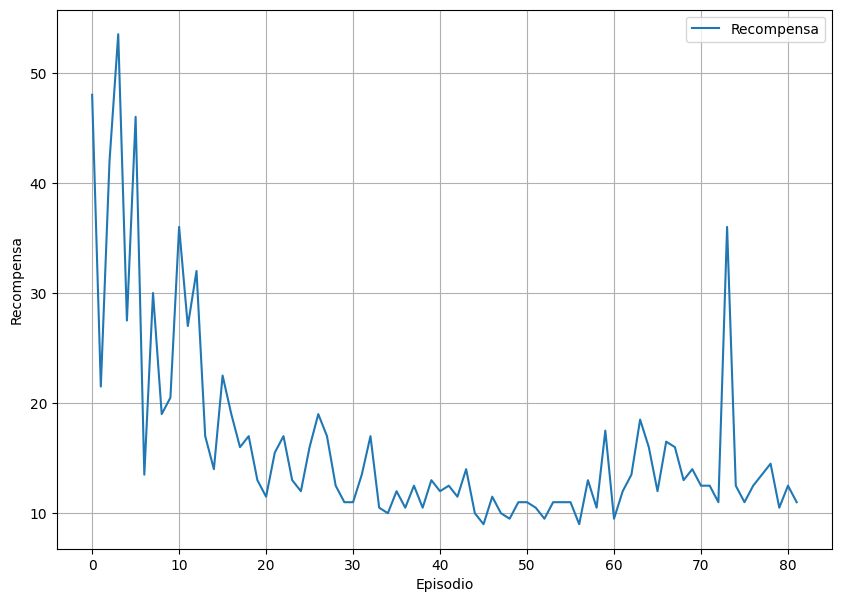

In [ ]:

# (neurons,exp_replay_size,nb_steps,test_episodes)
def retorno_deeplearning(N,metodo,neurons,exp_replay_size,nb_steps,test_episodes):
    
    rewards_min_size = 1000000
    rewards_list=[]    
    for i in range(1,N): # iterar sobre experimentos
        if metodo == "deep_sarsa":    
            rewards,_=deepSARSA(neurons,exp_replay_size,nb_steps,test_episodes)
            if rewards_min_size> len(rewards):
                rewards_min_size = len(rewards)
            else:
                pass
            rewards_list.append(rewards)
               
        elif metodo == "dqn":
            rewards,_=DQN(neurons,exp_replay_size,nb_steps,test_episodes)
            if rewards_min_size> len(rewards):
                rewards_min_size = len(rewards)
            else:
                pass
            rewards_list.append(rewards)
            

    truncated_rewards_list = []
    for rewards in rewards_list:
        truncated_rewards_list.append(rewards[0:rewards_min_size])
    print(truncated_rewards_list)
    retorno = np.mean(truncated_rewards_list, axis=0)
    fig=plt.figure(figsize=(10, 7))
    plt.plot(retorno)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.legend(['Recompensa'])
    plt.grid(True)
    plt.show()
    
    return retorno
    
# retorno  = retorno_deeplearning(N,metodo,neurons,exp_replay_size,nb_steps,test_episodes)

### Experimentos DQN


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 4)                 0         
                                                                 
 dense_86 (Dense)            (None, 4)                 20        
                                                                 
 activation_86 (Activation)  (None, 4)                 0         
                                                                 
 dense_87 (Dense)            (None, 2)                 10        
                                                                 
 activation_87 (Activation)  (None, 2)                 0         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Training for 100000 st

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 15
    15/100000: episode: 1, duration: 5.278s, episode steps:  15, steps per second:   3, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 0.783525, mse: 0.840911, mean_q: 0.260390
Episode 2: Steps: 25
    25/100000: episode: 2, duration: 0.055s, episode steps:  10, steps per second: 181, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.720702, mse: 0.824253, mean_q: 0.368279
Episode 3: Steps: 35
    35/100000: episode: 3, duration: 0.050s, episode steps:  10, steps per second: 198, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.668968, mse: 0.868605, mean_q: 0.558715
Episode 4: Steps: 48
    48/100000: episode: 4, duration: 0.064s, episode steps:  13, steps per second: 203, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 0.683329, mse: 0.94539

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 5: Steps: 73
    73/100000: episode: 5, duration: 0.130s, episode steps:  25, steps per second: 192, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 0.595662, mse: 0.810656, mean_q: 0.544066
Episode 6: Steps: 88
    88/100000: episode: 6, duration: 0.075s, episode steps:  15, steps per second: 199, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.594440, mse: 0.788012, mean_q: 0.549145
Episode 7: Steps: 119
   119/100000: episode: 7, duration: 0.161s, episode steps:  31, steps per second: 192, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.355 [0.000, 1.000],  loss: 0.585000, mse: 0.787219, mean_q: 0.668646
Episode 8: Steps: 135
   135/100000: episode: 8, duration: 0.091s, episode steps:  16, steps per second: 176, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.589384, mse: 0.814

Episode 38: Steps: 501
   501/100000: episode: 38, duration: 0.057s, episode steps:   9, steps per second: 158, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.871426, mse: 1.640711, mean_q: 3.021129
Episode 39: Steps: 511
   511/100000: episode: 39, duration: 0.050s, episode steps:  10, steps per second: 199, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.876004, mse: 1.623036, mean_q: 3.108860
Episode 40: Steps: 524
   524/100000: episode: 40, duration: 0.065s, episode steps:  13, steps per second: 199, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 0.884408, mse: 1.624401, mean_q: 3.198710
Episode 41: Steps: 539
   539/100000: episode: 41, duration: 0.073s, episode steps:  15, steps per second: 205, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.133 [0.000, 1.000],  loss: 1.026220, 

Episode 73: Steps: 860
   860/100000: episode: 73, duration: 0.074s, episode steps:  14, steps per second: 190, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.969485, mse: 5.110596, mean_q: 4.959386
Episode 74: Steps: 871
   871/100000: episode: 74, duration: 0.061s, episode steps:  11, steps per second: 182, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.918956, mse: 5.318619, mean_q: 4.983967
Episode 75: Steps: 880
   880/100000: episode: 75, duration: 0.045s, episode steps:   9, steps per second: 199, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.061848, mse: 5.553694, mean_q: 5.004984
Episode 76: Steps: 891
   891/100000: episode: 76, duration: 0.062s, episode steps:  11, steps per second: 177, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 0.901667, 

Episode 107: Steps: 1226
  1226/100000: episode: 107, duration: 0.109s, episode steps:  11, steps per second: 101, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 0.923884, mse: 13.138572, mean_q: 6.021627
Episode 108: Steps: 1245
  1245/100000: episode: 108, duration: 0.152s, episode steps:  19, steps per second: 125, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 0.917054, mse: 13.790550, mean_q: 6.200593
Episode 109: Steps: 1258
  1258/100000: episode: 109, duration: 0.104s, episode steps:  13, steps per second: 125, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: 1.118867, mse: 14.469090, mean_q: 6.214434
Episode 110: Steps: 1268
  1268/100000: episode: 110, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  l

Episode 139: Steps: 1666
  1666/100000: episode: 139, duration: 0.102s, episode steps:  20, steps per second: 195, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.557490, mse: 25.927914, mean_q: 7.054674
Episode 140: Steps: 1680
  1680/100000: episode: 140, duration: 0.074s, episode steps:  14, steps per second: 190, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 1.245633, mse: 27.670074, mean_q: 7.123513
Episode 141: Steps: 1696
  1696/100000: episode: 141, duration: 0.081s, episode steps:  16, steps per second: 197, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.380027, mse: 26.499645, mean_q: 7.110406
Episode 142: Steps: 1735
  1735/100000: episode: 142, duration: 0.205s, episode steps:  39, steps per second: 190, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  l

Episode 173: Steps: 2368
  2368/100000: episode: 173, duration: 0.067s, episode steps:  13, steps per second: 194, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 1.796906, mse: 63.226357, mean_q: 10.996995
Episode 174: Steps: 2379
  2379/100000: episode: 174, duration: 0.055s, episode steps:  11, steps per second: 200, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 2.913613, mse: 65.570564, mean_q: 11.091516
Episode 175: Steps: 2413
  2413/100000: episode: 175, duration: 0.165s, episode steps:  34, steps per second: 207, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.559 [0.000, 1.000],  loss: 2.960261, mse: 67.681198, mean_q: 11.269944
Episode 176: Steps: 2428
  2428/100000: episode: 176, duration: 0.075s, episode steps:  15, steps per second: 199, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.733 [0.000, 1.000],

Episode 207: Steps: 2925
  2925/100000: episode: 207, duration: 0.066s, episode steps:  13, steps per second: 197, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.769 [0.000, 1.000],  loss: 5.044530, mse: 93.731720, mean_q: 13.277700
Episode 208: Steps: 2935
  2935/100000: episode: 208, duration: 0.053s, episode steps:  10, steps per second: 189, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.900 [0.000, 1.000],  loss: 2.870006, mse: 91.256836, mean_q: 13.303644
Episode 209: Steps: 2948
  2948/100000: episode: 209, duration: 0.066s, episode steps:  13, steps per second: 197, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 3.295095, mse: 94.158318, mean_q: 13.459684
Episode 210: Steps: 2969
  2969/100000: episode: 210, duration: 0.103s, episode steps:  21, steps per second: 203, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],

Episode 240: Steps: 3825
  3825/100000: episode: 240, duration: 0.106s, episode steps:  22, steps per second: 208, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 5.250708, mse: 114.617477, mean_q: 14.820285
Episode 241: Steps: 3847
  3847/100000: episode: 241, duration: 0.107s, episode steps:  22, steps per second: 205, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 4.421074, mse: 112.750580, mean_q: 14.749990
Episode 242: Steps: 3877
  3877/100000: episode: 242, duration: 0.146s, episode steps:  30, steps per second: 206, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.567 [0.000, 1.000],  loss: 4.144289, mse: 112.203789, mean_q: 14.738436
Episode 243: Steps: 3906
  3906/100000: episode: 243, duration: 0.138s, episode steps:  29, steps per second: 210, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.00

Episode 273: Steps: 5134
  5134/100000: episode: 273, duration: 0.181s, episode steps:  24, steps per second: 133, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 5.005126, mse: 150.788101, mean_q: 17.237169
Episode 274: Steps: 5191
  5191/100000: episode: 274, duration: 0.381s, episode steps:  57, steps per second: 150, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 3.949964, mse: 154.043274, mean_q: 17.481552
Episode 275: Steps: 5240
  5240/100000: episode: 275, duration: 0.303s, episode steps:  49, steps per second: 162, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 3.790104, mse: 158.449112, mean_q: 17.726137
Episode 276: Steps: 5347
  5347/100000: episode: 276, duration: 0.608s, episode steps: 107, steps per second: 176, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.0

Episode 305: Steps: 6726
  6726/100000: episode: 305, duration: 0.834s, episode steps:  90, steps per second: 108, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.169366, mse: 228.115128, mean_q: 21.352808
Episode 306: Steps: 6777
  6777/100000: episode: 306, duration: 0.314s, episode steps:  51, steps per second: 162, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 4.949032, mse: 230.533859, mean_q: 21.470909
Episode 307: Steps: 6840
  6840/100000: episode: 307, duration: 0.349s, episode steps:  63, steps per second: 180, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 6.070690, mse: 233.697418, mean_q: 21.566710
Episode 308: Steps: 6872
  6872/100000: episode: 308, duration: 0.189s, episode steps:  32, steps per second: 170, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.00

Episode 337: Steps: 8389
  8389/100000: episode: 337, duration: 0.208s, episode steps:  36, steps per second: 173, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 4.867316, mse: 313.031586, mean_q: 25.116808
Episode 338: Steps: 8434
  8434/100000: episode: 338, duration: 0.256s, episode steps:  45, steps per second: 176, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 6.240405, mse: 318.349823, mean_q: 25.285305
Episode 339: Steps: 8475
  8475/100000: episode: 339, duration: 0.229s, episode steps:  41, steps per second: 179, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 7.111365, mse: 319.838898, mean_q: 25.299974
Episode 340: Steps: 8526
  8526/100000: episode: 340, duration: 0.290s, episode steps:  51, steps per second: 176, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.00

Episode 369: Steps: 9904
  9904/100000: episode: 369, duration: 0.368s, episode steps:  65, steps per second: 177, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 7.725348, mse: 394.492096, mean_q: 28.220493
Episode 370: Steps: 9934
  9934/100000: episode: 370, duration: 0.172s, episode steps:  30, steps per second: 174, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000, 1.000],  loss: 6.571157, mse: 394.252319, mean_q: 28.217669
Episode 371: Steps: 9974
  9974/100000: episode: 371, duration: 0.227s, episode steps:  40, steps per second: 176, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.286563, mse: 396.716431, mean_q: 28.243969
Episode 372: Steps: 10029
 10029/100000: episode: 372, duration: 0.339s, episode steps:  55, steps per second: 162, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.0

Episode 400: Steps: 11398
 11398/100000: episode: 400, duration: 0.419s, episode steps:  74, steps per second: 177, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 8.186922, mse: 454.401764, mean_q: 30.257393
Episode 401: Steps: 11423
 11423/100000: episode: 401, duration: 0.149s, episode steps:  25, steps per second: 167, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 8.402467, mse: 446.656372, mean_q: 29.942225
Episode 402: Steps: 11491
 11491/100000: episode: 402, duration: 0.410s, episode steps:  68, steps per second: 166, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.114634, mse: 458.356812, mean_q: 30.384493
Episode 403: Steps: 11544
 11544/100000: episode: 403, duration: 0.326s, episode steps:  53, steps per second: 163, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.453 [0.000, 

Episode 431: Steps: 13064
 13064/100000: episode: 431, duration: 0.421s, episode steps:  73, steps per second: 173, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000, 1.000],  loss: 8.823480, mse: 531.408508, mean_q: 32.678795
Episode 432: Steps: 13129
 13129/100000: episode: 432, duration: 0.374s, episode steps:  65, steps per second: 174, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 9.404513, mse: 529.634338, mean_q: 32.656784
Episode 433: Steps: 13211
 13211/100000: episode: 433, duration: 0.457s, episode steps:  82, steps per second: 180, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 9.587071, mse: 531.922363, mean_q: 32.680634
Episode 434: Steps: 13233
 13233/100000: episode: 434, duration: 0.127s, episode steps:  22, steps per second: 173, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 

Episode 462: Steps: 14838
 14838/100000: episode: 462, duration: 0.360s, episode steps:  74, steps per second: 206, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 8.511322, mse: 601.914917, mean_q: 34.688694
Episode 463: Steps: 14903
 14903/100000: episode: 463, duration: 0.311s, episode steps:  65, steps per second: 209, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 8.805143, mse: 603.706787, mean_q: 34.734165
Episode 464: Steps: 14961
 14961/100000: episode: 464, duration: 0.275s, episode steps:  58, steps per second: 211, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 10.449007, mse: 598.692139, mean_q: 34.596043
Episode 465: Steps: 15024
 15024/100000: episode: 465, duration: 0.302s, episode steps:  63, steps per second: 209, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000,

Episode 494: Steps: 16726
 16726/100000: episode: 494, duration: 0.206s, episode steps:  43, steps per second: 209, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 7.986793, mse: 641.081909, mean_q: 35.792278
Episode 495: Steps: 16793
 16793/100000: episode: 495, duration: 0.317s, episode steps:  67, steps per second: 211, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 7.195161, mse: 647.688782, mean_q: 35.885941
Episode 496: Steps: 16857
 16857/100000: episode: 496, duration: 0.309s, episode steps:  64, steps per second: 207, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.453 [0.000, 1.000],  loss: 9.610430, mse: 646.115784, mean_q: 35.791046
Episode 497: Steps: 16974
 16974/100000: episode: 497, duration: 0.556s, episode steps: 117, steps per second: 210, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000,

Episode 525: Steps: 19016
 19016/100000: episode: 525, duration: 0.538s, episode steps: 102, steps per second: 190, episode reward: 102.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 7.593288, mse: 704.524536, mean_q: 37.000546
Episode 526: Steps: 19086
 19086/100000: episode: 526, duration: 0.350s, episode steps:  70, steps per second: 200, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 8.283627, mse: 699.171936, mean_q: 36.855579
Episode 527: Steps: 19166
 19166/100000: episode: 527, duration: 0.388s, episode steps:  80, steps per second: 206, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 5.056655, mse: 713.660522, mean_q: 37.285927
Episode 528: Steps: 19235
 19235/100000: episode: 528, duration: 0.334s, episode steps:  69, steps per second: 207, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000,

Episode 556: Steps: 21960
 21960/100000: episode: 556, duration: 1.169s, episode steps: 170, steps per second: 145, episode reward: 170.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 9.765770, mse: 777.234741, mean_q: 38.285004
Episode 557: Steps: 22073
 22073/100000: episode: 557, duration: 0.681s, episode steps: 113, steps per second: 166, episode reward: 113.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: 7.513388, mse: 800.526672, mean_q: 38.973415
Episode 558: Steps: 22201
 22201/100000: episode: 558, duration: 0.816s, episode steps: 128, steps per second: 157, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 7.471513, mse: 787.557983, mean_q: 38.632668
Episode 559: Steps: 22328
 22328/100000: episode: 559, duration: 0.833s, episode steps: 127, steps per second: 152, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.0

Episode 587: Steps: 26299
 26299/100000: episode: 587, duration: 1.230s, episode steps: 227, steps per second: 185, episode reward: 227.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 10.280224, mse: 942.440002, mean_q: 42.598507
Episode 588: Steps: 26465
 26465/100000: episode: 588, duration: 0.838s, episode steps: 166, steps per second: 198, episode reward: 166.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 9.448215, mse: 935.492859, mean_q: 42.399433
Episode 589: Steps: 26834
 26834/100000: episode: 589, duration: 2.156s, episode steps: 369, steps per second: 171, episode reward: 369.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 8.712522, mse: 948.899048, mean_q: 42.738499
Episode 590: Steps: 26991
 26991/100000: episode: 590, duration: 0.822s, episode steps: 157, steps per second: 191, episode reward: 157.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.

Episode 618: Steps: 32949
 32949/100000: episode: 618, duration: 1.128s, episode steps: 179, steps per second: 159, episode reward: 179.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 11.874999, mse: 1372.285156, mean_q: 51.940048
Episode 619: Steps: 33123
 33123/100000: episode: 619, duration: 1.076s, episode steps: 174, steps per second: 162, episode reward: 174.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 10.835023, mse: 1393.370850, mean_q: 52.421230
Episode 620: Steps: 33339
 33339/100000: episode: 620, duration: 1.313s, episode steps: 216, steps per second: 164, episode reward: 216.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 13.499170, mse: 1394.320190, mean_q: 52.408672
Episode 621: Steps: 33627
 33627/100000: episode: 621, duration: 1.709s, episode steps: 288, steps per second: 169, episode reward: 288.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 649: Steps: 39310
 39310/100000: episode: 649, duration: 1.192s, episode steps: 193, steps per second: 162, episode reward: 193.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000, 1.000],  loss: 14.358128, mse: 1954.591797, mean_q: 62.445667
Episode 650: Steps: 39483
 39483/100000: episode: 650, duration: 1.179s, episode steps: 173, steps per second: 147, episode reward: 173.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 17.098902, mse: 1962.000732, mean_q: 62.543003
Episode 651: Steps: 39836
 39836/100000: episode: 651, duration: 2.204s, episode steps: 353, steps per second: 160, episode reward: 353.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 16.978348, mse: 1981.934082, mean_q: 62.839783
Episode 652: Steps: 39987
 39987/100000: episode: 652, duration: 0.903s, episode steps: 151, steps per second: 167, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 680: Steps: 45209
 45209/100000: episode: 680, duration: 0.852s, episode steps: 121, steps per second: 142, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.554 [0.000, 1.000],  loss: 15.371581, mse: 2304.332275, mean_q: 68.028305
Episode 681: Steps: 45407
 45407/100000: episode: 681, duration: 1.398s, episode steps: 198, steps per second: 142, episode reward: 198.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.530 [0.000, 1.000],  loss: 18.900063, mse: 2305.923584, mean_q: 67.993103
Episode 682: Steps: 45507
 45507/100000: episode: 682, duration: 0.625s, episode steps: 100, steps per second: 160, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 20.087057, mse: 2331.760742, mean_q: 68.515594
Episode 683: Steps: 45660
 45660/100000: episode: 683, duration: 0.954s, episode steps: 153, steps per second: 160, episode reward: 153.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 711: Steps: 50329
 50329/100000: episode: 711, duration: 0.875s, episode steps: 145, steps per second: 166, episode reward: 145.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 26.190079, mse: 2556.143555, mean_q: 71.824356
Episode 712: Steps: 50466
 50466/100000: episode: 712, duration: 0.776s, episode steps: 137, steps per second: 177, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 22.802874, mse: 2562.233154, mean_q: 71.953697
Episode 713: Steps: 50667
 50667/100000: episode: 713, duration: 1.441s, episode steps: 201, steps per second: 139, episode reward: 201.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.527 [0.000, 1.000],  loss: 20.384857, mse: 2577.163330, mean_q: 72.230011
Episode 714: Steps: 50799
 50799/100000: episode: 714, duration: 0.905s, episode steps: 132, steps per second: 146, episode reward: 132.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 742: Steps: 54563
 54563/100000: episode: 742, duration: 0.575s, episode steps: 105, steps per second: 183, episode reward: 105.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 20.206137, mse: 3138.071777, mean_q: 80.209358
Episode 743: Steps: 54683
 54683/100000: episode: 743, duration: 0.669s, episode steps: 120, steps per second: 179, episode reward: 120.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 23.721935, mse: 3202.059814, mean_q: 80.927536
Episode 744: Steps: 54812
 54812/100000: episode: 744, duration: 0.675s, episode steps: 129, steps per second: 191, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 19.391375, mse: 3211.163330, mean_q: 81.079063
Episode 745: Steps: 54935
 54935/100000: episode: 745, duration: 0.750s, episode steps: 123, steps per second: 164, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 773: Steps: 58425
 58425/100000: episode: 773, duration: 0.620s, episode steps: 122, steps per second: 197, episode reward: 122.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.549 [0.000, 1.000],  loss: 19.399454, mse: 3965.805908, mean_q: 89.879143
Episode 774: Steps: 58541
 58541/100000: episode: 774, duration: 0.618s, episode steps: 116, steps per second: 188, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 26.469292, mse: 3941.138184, mean_q: 89.593399
Episode 775: Steps: 58691
 58691/100000: episode: 775, duration: 0.760s, episode steps: 150, steps per second: 197, episode reward: 150.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 22.137047, mse: 3942.369141, mean_q: 89.550629
Episode 776: Steps: 58817
 58817/100000: episode: 776, duration: 0.666s, episode steps: 126, steps per second: 189, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 804: Steps: 62543
 62543/100000: episode: 804, duration: 0.857s, episode steps: 149, steps per second: 174, episode reward: 149.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 36.733917, mse: 4578.598633, mean_q: 95.067535
Episode 805: Steps: 62700
 62700/100000: episode: 805, duration: 0.904s, episode steps: 157, steps per second: 174, episode reward: 157.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 33.499657, mse: 4505.935547, mean_q: 94.388847
Episode 806: Steps: 62840
 62840/100000: episode: 806, duration: 0.901s, episode steps: 140, steps per second: 155, episode reward: 140.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 23.024929, mse: 4527.916016, mean_q: 94.671425
Episode 807: Steps: 62974
 62974/100000: episode: 807, duration: 0.901s, episode steps: 134, steps per second: 149, episode reward: 134.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 835: Steps: 66773
 66773/100000: episode: 835, duration: 0.849s, episode steps: 136, steps per second: 160, episode reward: 136.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 24.022852, mse: 4636.987793, mean_q: 94.306725
Episode 836: Steps: 66901
 66901/100000: episode: 836, duration: 0.808s, episode steps: 128, steps per second: 159, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.539 [0.000, 1.000],  loss: 18.667425, mse: 4711.758301, mean_q: 95.157089
Episode 837: Steps: 67017
 67017/100000: episode: 837, duration: 0.795s, episode steps: 116, steps per second: 146, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 29.933479, mse: 4700.202637, mean_q: 94.828232
Episode 838: Steps: 67134
 67134/100000: episode: 838, duration: 0.796s, episode steps: 117, steps per second: 147, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 866: Steps: 70218
 70218/100000: episode: 866, duration: 0.658s, episode steps: 129, steps per second: 196, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 8.835740, mse: 4888.013672, mean_q: 94.778885
Episode 867: Steps: 70348
 70348/100000: episode: 867, duration: 0.654s, episode steps: 130, steps per second: 199, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.554 [0.000, 1.000],  loss: 22.841377, mse: 4709.395996, mean_q: 92.631142
Episode 868: Steps: 70471
 70471/100000: episode: 868, duration: 0.628s, episode steps: 123, steps per second: 196, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 21.092583, mse: 4867.695312, mean_q: 94.110497
Episode 869: Steps: 70587
 70587/100000: episode: 869, duration: 0.594s, episode steps: 116, steps per second: 195, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543

Episode 897: Steps: 73830
 73830/100000: episode: 897, duration: 0.736s, episode steps: 126, steps per second: 171, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 5.775961, mse: 4271.490723, mean_q: 87.109840
Episode 898: Steps: 73967
 73967/100000: episode: 898, duration: 0.695s, episode steps: 137, steps per second: 197, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.547 [0.000, 1.000],  loss: 5.350458, mse: 4258.393066, mean_q: 86.620186
Episode 899: Steps: 73995
 73995/100000: episode: 899, duration: 0.151s, episode steps:  28, steps per second: 186, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 19.135303, mse: 4156.366211, mean_q: 85.747200
Episode 900: Steps: 74102
 74102/100000: episode: 900, duration: 0.544s, episode steps: 107, steps per second: 197, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.561 [

Episode 928: Steps: 77872
 77872/100000: episode: 928, duration: 1.333s, episode steps: 172, steps per second: 129, episode reward: 172.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 4.951459, mse: 3480.903320, mean_q: 77.771812
Episode 929: Steps: 78011
 78011/100000: episode: 929, duration: 0.934s, episode steps: 139, steps per second: 149, episode reward: 139.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 3.818521, mse: 3411.273193, mean_q: 76.764282
Episode 930: Steps: 78165
 78165/100000: episode: 930, duration: 0.816s, episode steps: 154, steps per second: 189, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 3.537783, mse: 3439.380615, mean_q: 77.000893
Episode 931: Steps: 78301
 78301/100000: episode: 931, duration: 0.771s, episode steps: 136, steps per second: 176, episode reward: 136.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [

Episode 959: Steps: 83335
 83335/100000: episode: 959, duration: 1.570s, episode steps: 234, steps per second: 149, episode reward: 234.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.379704, mse: 3121.814941, mean_q: 73.353996
Episode 960: Steps: 83654
 83654/100000: episode: 960, duration: 2.511s, episode steps: 319, steps per second: 127, episode reward: 319.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 4.519255, mse: 3137.226562, mean_q: 73.764900
Episode 961: Steps: 83843
 83843/100000: episode: 961, duration: 1.355s, episode steps: 189, steps per second: 140, episode reward: 189.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.860312, mse: 3213.082764, mean_q: 74.632195
Episode 962: Steps: 83876
 83876/100000: episode: 962, duration: 0.225s, episode steps:  33, steps per second: 147, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0

Episode 990: Steps: 88960
 88960/100000: episode: 990, duration: 1.370s, episode steps: 215, steps per second: 157, episode reward: 215.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 4.614424, mse: 3729.858154, mean_q: 82.645546
Episode 991: Steps: 89177
 89177/100000: episode: 991, duration: 1.482s, episode steps: 217, steps per second: 146, episode reward: 217.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 4.925998, mse: 3846.809814, mean_q: 83.915146
Episode 992: Steps: 89370
 89370/100000: episode: 992, duration: 1.480s, episode steps: 193, steps per second: 130, episode reward: 193.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 7.978322, mse: 3894.489746, mean_q: 84.589386
Episode 993: Steps: 89597
 89597/100000: episode: 993, duration: 1.474s, episode steps: 227, steps per second: 154, episode reward: 227.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [

Episode 1021: Steps: 95993
 95993/100000: episode: 1021, duration: 1.836s, episode steps: 293, steps per second: 160, episode reward: 293.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 30.675419, mse: 7297.941895, mean_q: 120.619438
Episode 1022: Steps: 96239
 96239/100000: episode: 1022, duration: 1.726s, episode steps: 246, steps per second: 143, episode reward: 246.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 25.410557, mse: 7465.033691, mean_q: 122.164841
Episode 1023: Steps: 96482
 96482/100000: episode: 1023, duration: 2.370s, episode steps: 243, steps per second: 103, episode reward: 243.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 27.801260, mse: 7654.821777, mean_q: 123.750595
Episode 1024: Steps: 96755
 96755/100000: episode: 1024, duration: 2.530s, episode steps: 273, steps per second: 108, episode reward: 273.000, mean reward:  1.000 [ 1.000,  1.000], mean a

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 18
    18/100000: episode: 1, duration: 6.898s, episode steps:  18, steps per second:   3, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.278 [0.000, 1.000],  loss: 0.798947, mse: 0.878486, mean_q: 0.289527
Episode 2: Steps: 41
    41/100000: episode: 2, duration: 0.134s, episode steps:  23, steps per second: 171, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 0.773891, mse: 0.905617, mean_q: 0.356123


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3: Steps: 57
    57/100000: episode: 3, duration: 0.097s, episode steps:  16, steps per second: 164, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 0.665164, mse: 0.742724, mean_q: 0.296892
Episode 4: Steps: 89
    89/100000: episode: 4, duration: 0.184s, episode steps:  32, steps per second: 173, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.563449, mse: 0.622795, mean_q: 0.331121
Episode 5: Steps: 103
   103/100000: episode: 5, duration: 0.086s, episode steps:  14, steps per second: 163, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.545848, mse: 0.604775, mean_q: 0.383666
Episode 6: Steps: 116
   116/100000: episode: 6, duration: 0.080s, episode steps:  13, steps per second: 163, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 0.612272, mse: 0.689

Episode 35: Steps: 519
   519/100000: episode: 35, duration: 0.075s, episode steps:  12, steps per second: 159, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.900322, mse: 1.753441, mean_q: 2.208289
Episode 36: Steps: 528
   528/100000: episode: 36, duration: 0.054s, episode steps:   9, steps per second: 166, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.799642, mse: 1.569418, mean_q: 2.263471
Episode 37: Steps: 544
   544/100000: episode: 37, duration: 0.097s, episode steps:  16, steps per second: 164, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.188 [0.000, 1.000],  loss: 0.903933, mse: 1.889858, mean_q: 2.273237
Episode 38: Steps: 558
   558/100000: episode: 38, duration: 0.090s, episode steps:  14, steps per second: 156, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.888836, 

Episode 67: Steps: 879
   879/100000: episode: 67, duration: 0.056s, episode steps:   9, steps per second: 160, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.041352, mse: 4.499566, mean_q: 4.221407
Episode 68: Steps: 889
   889/100000: episode: 68, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.950430, mse: 4.523009, mean_q: 4.286730
Episode 69: Steps: 906
   906/100000: episode: 69, duration: 0.114s, episode steps:  17, steps per second: 149, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.235 [0.000, 1.000],  loss: 1.005608, mse: 4.974214, mean_q: 4.350640
Episode 70: Steps: 916
   916/100000: episode: 70, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.913676, 

Episode 99: Steps: 1235
  1235/100000: episode: 99, duration: 0.068s, episode steps:  11, steps per second: 161, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.845426, mse: 12.222004, mean_q: 5.982515
Episode 100: Steps: 1262
  1262/100000: episode: 100, duration: 0.160s, episode steps:  27, steps per second: 169, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.370 [0.000, 1.000],  loss: 1.087253, mse: 13.386761, mean_q: 6.027531
Episode 101: Steps: 1273
  1273/100000: episode: 101, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.770720, mse: 14.134838, mean_q: 6.205953
Episode 102: Steps: 1285
  1285/100000: episode: 102, duration: 0.077s, episode steps:  12, steps per second: 156, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  los

Episode 133: Steps: 1849
  1849/100000: episode: 133, duration: 0.352s, episode steps:  61, steps per second: 173, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.557 [0.000, 1.000],  loss: 0.671615, mse: 32.823627, mean_q: 7.764385
Episode 134: Steps: 1901
  1901/100000: episode: 134, duration: 0.302s, episode steps:  52, steps per second: 172, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  loss: 0.796307, mse: 34.489296, mean_q: 8.001186
Episode 135: Steps: 1916
  1916/100000: episode: 135, duration: 0.090s, episode steps:  15, steps per second: 167, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.733 [0.000, 1.000],  loss: 0.783590, mse: 35.364799, mean_q: 8.112892
Episode 136: Steps: 1937
  1937/100000: episode: 136, duration: 0.126s, episode steps:  21, steps per second: 166, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  l

Episode 165: Steps: 2516
  2516/100000: episode: 165, duration: 0.230s, episode steps:  35, steps per second: 152, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 1.905645, mse: 67.617638, mean_q: 11.468003
Episode 166: Steps: 2533
  2533/100000: episode: 166, duration: 0.115s, episode steps:  17, steps per second: 148, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 [0.000, 1.000],  loss: 1.821667, mse: 69.794167, mean_q: 11.671389
Episode 167: Steps: 2544
  2544/100000: episode: 167, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 2.957888, mse: 72.289711, mean_q: 11.769700
Episode 168: Steps: 2571
  2571/100000: episode: 168, duration: 0.175s, episode steps:  27, steps per second: 155, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.704 [0.000, 1.000],

Episode 197: Steps: 3320
  3320/100000: episode: 197, duration: 0.221s, episode steps:  39, steps per second: 176, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 2.877232, mse: 103.857224, mean_q: 14.213686
Episode 198: Steps: 3352
  3352/100000: episode: 198, duration: 0.186s, episode steps:  32, steps per second: 172, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 2.846715, mse: 105.883324, mean_q: 14.370222
Episode 199: Steps: 3368
  3368/100000: episode: 199, duration: 0.096s, episode steps:  16, steps per second: 166, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 4.765133, mse: 110.567627, mean_q: 14.550769
Episode 200: Steps: 3410
  3410/100000: episode: 200, duration: 0.249s, episode steps:  42, steps per second: 169, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.00

Episode 229: Steps: 4574
  4574/100000: episode: 229, duration: 0.423s, episode steps:  33, steps per second:  78, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 5.186766, mse: 160.735962, mean_q: 17.847235
Episode 230: Steps: 4586
  4586/100000: episode: 230, duration: 0.185s, episode steps:  12, steps per second:  65, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 4.920930, mse: 163.347275, mean_q: 17.966663
Episode 231: Steps: 4614
  4614/100000: episode: 231, duration: 0.467s, episode steps:  28, steps per second:  60, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.841000, mse: 161.424698, mean_q: 17.841478
Episode 232: Steps: 4635
  4635/100000: episode: 232, duration: 0.281s, episode steps:  21, steps per second:  75, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.00

Episode 261: Steps: 5666
  5666/100000: episode: 261, duration: 0.151s, episode steps:  25, steps per second: 166, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 5.838144, mse: 211.973404, mean_q: 20.524683
Episode 262: Steps: 5687
  5687/100000: episode: 262, duration: 0.145s, episode steps:  21, steps per second: 145, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 5.584565, mse: 212.936386, mean_q: 20.576672
Episode 263: Steps: 5712
  5712/100000: episode: 263, duration: 0.162s, episode steps:  25, steps per second: 155, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 5.318065, mse: 217.370331, mean_q: 20.808439
Episode 264: Steps: 5738
  5738/100000: episode: 264, duration: 0.168s, episode steps:  26, steps per second: 155, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.00

Episode 293: Steps: 6991
  6991/100000: episode: 293, duration: 0.469s, episode steps:  81, steps per second: 173, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 7.519599, mse: 284.226959, mean_q: 23.904551
Episode 294: Steps: 7084
  7084/100000: episode: 294, duration: 0.565s, episode steps:  93, steps per second: 165, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 7.133920, mse: 291.397980, mean_q: 24.203642
Episode 295: Steps: 7127
  7127/100000: episode: 295, duration: 0.313s, episode steps:  43, steps per second: 137, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 7.236353, mse: 294.232483, mean_q: 24.331339
Episode 296: Steps: 7150
  7150/100000: episode: 296, duration: 0.155s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.00

Episode 325: Steps: 8399
  8399/100000: episode: 325, duration: 0.622s, episode steps: 115, steps per second: 185, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 7.905451, mse: 366.684570, mean_q: 27.218616
Episode 326: Steps: 8453
  8453/100000: episode: 326, duration: 0.294s, episode steps:  54, steps per second: 184, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 9.237659, mse: 372.896729, mean_q: 27.408764
Episode 327: Steps: 8505
  8505/100000: episode: 327, duration: 0.284s, episode steps:  52, steps per second: 183, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 8.213615, mse: 374.172211, mean_q: 27.484692
Episode 328: Steps: 8551
  8551/100000: episode: 328, duration: 0.247s, episode steps:  46, steps per second: 186, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.0

Episode 356: Steps: 9902
  9902/100000: episode: 356, duration: 0.247s, episode steps:  42, steps per second: 170, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 8.368390, mse: 440.847839, mean_q: 29.860294
Episode 357: Steps: 10002
 10002/100000: episode: 357, duration: 0.668s, episode steps: 100, steps per second: 150, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 10.128097, mse: 446.513641, mean_q: 29.965923
Episode 358: Steps: 10070
 10070/100000: episode: 358, duration: 0.408s, episode steps:  68, steps per second: 167, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 9.057300, mse: 452.319153, mean_q: 30.173233
Episode 359: Steps: 10122
 10122/100000: episode: 359, duration: 0.297s, episode steps:  52, steps per second: 175, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000,

Episode 388: Steps: 11574
 11574/100000: episode: 388, duration: 0.280s, episode steps:  53, steps per second: 189, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.547 [0.000, 1.000],  loss: 11.092616, mse: 514.221130, mean_q: 32.184620
Episode 389: Steps: 11610
 11610/100000: episode: 389, duration: 0.189s, episode steps:  36, steps per second: 191, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 10.348934, mse: 515.097412, mean_q: 32.223389
Episode 390: Steps: 11662
 11662/100000: episode: 390, duration: 0.286s, episode steps:  52, steps per second: 182, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.611095, mse: 511.502380, mean_q: 32.158455
Episode 391: Steps: 11738
 11738/100000: episode: 391, duration: 0.404s, episode steps:  76, steps per second: 188, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000

Episode 419: Steps: 13664
 13664/100000: episode: 419, duration: 0.245s, episode steps:  44, steps per second: 179, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 11.044489, mse: 612.710938, mean_q: 35.134007
Episode 420: Steps: 13704
 13704/100000: episode: 420, duration: 0.229s, episode steps:  40, steps per second: 175, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 7.963871, mse: 608.561279, mean_q: 35.137047
Episode 421: Steps: 13764
 13764/100000: episode: 421, duration: 0.340s, episode steps:  60, steps per second: 176, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 10.100513, mse: 605.996948, mean_q: 35.058899
Episode 422: Steps: 13800
 13800/100000: episode: 422, duration: 0.203s, episode steps:  36, steps per second: 177, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000

Episode 450: Steps: 15486
 15486/100000: episode: 450, duration: 0.409s, episode steps:  62, steps per second: 152, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 9.337551, mse: 674.465393, mean_q: 36.884270
Episode 451: Steps: 15602
 15602/100000: episode: 451, duration: 0.723s, episode steps: 116, steps per second: 161, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 11.130169, mse: 677.229980, mean_q: 36.892403
Episode 452: Steps: 15670
 15670/100000: episode: 452, duration: 0.410s, episode steps:  68, steps per second: 166, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.299962, mse: 668.371399, mean_q: 36.646706
Episode 453: Steps: 15692
 15692/100000: episode: 453, duration: 0.122s, episode steps:  22, steps per second: 180, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.00

Episode 481: Steps: 17521
 17521/100000: episode: 481, duration: 0.737s, episode steps: 132, steps per second: 179, episode reward: 132.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 11.389767, mse: 737.406250, mean_q: 38.414936
Episode 482: Steps: 17641
 17641/100000: episode: 482, duration: 0.714s, episode steps: 120, steps per second: 168, episode reward: 120.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 10.431604, mse: 734.777893, mean_q: 38.347103
Episode 483: Steps: 17712
 17712/100000: episode: 483, duration: 0.422s, episode steps:  71, steps per second: 168, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 11.007414, mse: 745.497070, mean_q: 38.638298
Episode 484: Steps: 17764
 17764/100000: episode: 484, duration: 0.320s, episode steps:  52, steps per second: 162, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.

Episode 512: Steps: 19727
 19727/100000: episode: 512, duration: 0.608s, episode steps:  76, steps per second: 125, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 8.537032, mse: 796.292358, mean_q: 39.864017
Episode 513: Steps: 19834
 19834/100000: episode: 513, duration: 1.278s, episode steps: 107, steps per second:  84, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 10.104103, mse: 809.728394, mean_q: 40.151199
Episode 514: Steps: 19918
 19918/100000: episode: 514, duration: 0.643s, episode steps:  84, steps per second: 131, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 12.938148, mse: 806.030212, mean_q: 39.974152
Episode 515: Steps: 20002
 20002/100000: episode: 515, duration: 0.449s, episode steps:  84, steps per second: 187, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.00

Episode 543: Steps: 23413
 23413/100000: episode: 543, duration: 0.993s, episode steps: 149, steps per second: 150, episode reward: 149.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 7.852219, mse: 908.197266, mean_q: 42.375542
Episode 544: Steps: 23568
 23568/100000: episode: 544, duration: 1.021s, episode steps: 155, steps per second: 152, episode reward: 155.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 10.338739, mse: 915.880066, mean_q: 42.516922
Episode 545: Steps: 23692
 23692/100000: episode: 545, duration: 0.827s, episode steps: 124, steps per second: 150, episode reward: 124.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 10.647897, mse: 918.600647, mean_q: 42.511570
Episode 546: Steps: 23813
 23813/100000: episode: 546, duration: 0.819s, episode steps: 121, steps per second: 148, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0

Episode 574: Steps: 29732
 29732/100000: episode: 574, duration: 1.874s, episode steps: 220, steps per second: 117, episode reward: 220.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 12.621211, mse: 1338.927002, mean_q: 51.617241
Episode 575: Steps: 29997
 29997/100000: episode: 575, duration: 1.759s, episode steps: 265, steps per second: 151, episode reward: 265.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 12.598212, mse: 1351.441040, mean_q: 51.889057
Episode 576: Steps: 30171
 30171/100000: episode: 576, duration: 1.172s, episode steps: 174, steps per second: 148, episode reward: 174.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 12.736990, mse: 1366.203613, mean_q: 52.182526
Episode 577: Steps: 30418
 30418/100000: episode: 577, duration: 1.657s, episode steps: 247, steps per second: 149, episode reward: 247.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.49

Episode 605: Steps: 38369
 38369/100000: episode: 605, duration: 3.325s, episode steps: 486, steps per second: 146, episode reward: 486.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 17.516338, mse: 2026.867920, mean_q: 64.024155
Episode 606: Steps: 38869
 38869/100000: episode: 606, duration: 3.709s, episode steps: 500, steps per second: 135, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 17.748386, mse: 2072.047363, mean_q: 64.748650
Episode 607: Steps: 39256
 39256/100000: episode: 607, duration: 2.653s, episode steps: 387, steps per second: 146, episode reward: 387.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 15.836606, mse: 2108.712891, mean_q: 65.438957
Episode 608: Steps: 39756
 39756/100000: episode: 608, duration: 3.503s, episode steps: 500, steps per second: 143, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 636: Steps: 50936
 50936/100000: episode: 636, duration: 3.082s, episode steps: 435, steps per second: 141, episode reward: 435.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 22.038927, mse: 3177.258789, mean_q: 80.627426
Episode 637: Steps: 51283
 51283/100000: episode: 637, duration: 2.395s, episode steps: 347, steps per second: 145, episode reward: 347.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 24.420698, mse: 3209.786865, mean_q: 81.071030
Episode 638: Steps: 51606
 51606/100000: episode: 638, duration: 2.300s, episode steps: 323, steps per second: 140, episode reward: 323.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 21.082548, mse: 3229.294922, mean_q: 81.379654
Episode 639: Steps: 51929
 51929/100000: episode: 639, duration: 2.470s, episode steps: 323, steps per second: 131, episode reward: 323.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 667: Steps: 58813
 58813/100000: episode: 667, duration: 1.543s, episode steps: 218, steps per second: 141, episode reward: 218.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 22.712818, mse: 4316.069336, mean_q: 94.085205
Episode 668: Steps: 59007
 59007/100000: episode: 668, duration: 1.381s, episode steps: 194, steps per second: 140, episode reward: 194.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 24.267836, mse: 4347.299805, mean_q: 94.538216
Episode 669: Steps: 59263
 59263/100000: episode: 669, duration: 1.806s, episode steps: 256, steps per second: 142, episode reward: 256.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 21.990494, mse: 4401.474609, mean_q: 95.143867
Episode 670: Steps: 59500
 59500/100000: episode: 670, duration: 1.670s, episode steps: 237, steps per second: 142, episode reward: 237.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 698: Steps: 67562
 67562/100000: episode: 698, duration: 3.707s, episode steps: 321, steps per second:  87, episode reward: 321.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 25.182468, mse: 5773.266113, mean_q: 108.167908
Episode 699: Steps: 67905
 67905/100000: episode: 699, duration: 3.033s, episode steps: 343, steps per second: 113, episode reward: 343.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 26.624817, mse: 5843.101074, mean_q: 108.695427
Episode 700: Steps: 68238
 68238/100000: episode: 700, duration: 2.586s, episode steps: 333, steps per second: 129, episode reward: 333.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 21.299444, mse: 5869.848145, mean_q: 108.919807
Episode 701: Steps: 68555
 68555/100000: episode: 701, duration: 2.531s, episode steps: 317, steps per second: 125, episode reward: 317.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 729: Steps: 77553
 77553/100000: episode: 729, duration: 3.873s, episode steps: 382, steps per second:  99, episode reward: 382.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 15.467654, mse: 6275.194824, mean_q: 110.775421
Episode 730: Steps: 77812
 77812/100000: episode: 730, duration: 1.859s, episode steps: 259, steps per second: 139, episode reward: 259.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 18.884047, mse: 6251.082031, mean_q: 110.442780
Episode 731: Steps: 78103
 78103/100000: episode: 731, duration: 2.316s, episode steps: 291, steps per second: 126, episode reward: 291.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 19.140825, mse: 6246.983887, mean_q: 110.255333
Episode 732: Steps: 78406
 78406/100000: episode: 732, duration: 2.186s, episode steps: 303, steps per second: 139, episode reward: 303.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 760: Steps: 86796
 86796/100000: episode: 760, duration: 1.047s, episode steps: 151, steps per second: 144, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 10.173117, mse: 5210.898438, mean_q: 99.976181
Episode 761: Steps: 86844
 86844/100000: episode: 761, duration: 0.458s, episode steps:  48, steps per second: 105, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 2.431177, mse: 5150.353516, mean_q: 99.436302
Episode 762: Steps: 87160
 87160/100000: episode: 762, duration: 2.158s, episode steps: 316, steps per second: 146, episode reward: 316.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 9.696363, mse: 5221.439453, mean_q: 100.152756
Episode 763: Steps: 87397
 87397/100000: episode: 763, duration: 1.278s, episode steps: 237, steps per second: 186, episode reward: 237.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 

Episode 791: Steps: 94437
 94437/100000: episode: 791, duration: 2.916s, episode steps: 500, steps per second: 171, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.887907, mse: 7736.767090, mean_q: 124.514595
Episode 792: Steps: 94899
 94899/100000: episode: 792, duration: 2.479s, episode steps: 462, steps per second: 186, episode reward: 462.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 20.248093, mse: 7917.854004, mean_q: 126.093277
Episode 793: Steps: 95126
 95126/100000: episode: 793, duration: 1.228s, episode steps: 227, steps per second: 185, episode reward: 227.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 19.575232, mse: 8047.430176, mean_q: 127.195198
Episode 794: Steps: 95626
 95626/100000: episode: 794, duration: 2.664s, episode steps: 500, steps per second: 188, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 822: Steps: 99088
 99088/100000: episode: 822, duration: 0.115s, episode steps:  20, steps per second: 174, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 23.696915, mse: 8631.980469, mean_q: 131.265594
Episode 823: Steps: 99231
 99231/100000: episode: 823, duration: 0.773s, episode steps: 143, steps per second: 185, episode reward: 143.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 26.179289, mse: 8581.229492, mean_q: 130.942169
Episode 824: Steps: 99247
 99247/100000: episode: 824, duration: 0.093s, episode steps:  16, steps per second: 172, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 34.117264, mse: 8787.273438, mean_q: 132.446960
Episode 825: Steps: 99427
 99427/100000: episode: 825, duration: 0.968s, episode steps: 180, steps per second: 186, episode reward: 180.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 18
    18/100000: episode: 1, duration: 5.554s, episode steps:  18, steps per second:   3, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.278 [0.000, 1.000],  loss: 0.811340, mse: 0.893781, mean_q: 0.300117
Episode 2: Steps: 43
    43/100000: episode: 2, duration: 0.129s, episode steps:  25, steps per second: 193, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.769019, mse: 0.900720, mean_q: 0.360948


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3: Steps: 61
    61/100000: episode: 3, duration: 0.099s, episode steps:  18, steps per second: 182, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 0.669800, mse: 0.751144, mean_q: 0.316564
Episode 4: Steps: 77
    77/100000: episode: 4, duration: 0.083s, episode steps:  16, steps per second: 193, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.612198, mse: 0.687680, mean_q: 0.349448
Episode 5: Steps: 99
    99/100000: episode: 5, duration: 0.114s, episode steps:  22, steps per second: 193, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 0.653947, mse: 0.732220, mean_q: 0.397966
Episode 6: Steps: 126
   126/100000: episode: 6, duration: 0.141s, episode steps:  27, steps per second: 192, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.593 [0.000, 1.000],  loss: 0.653909, mse: 0.7381

Episode 37: Steps: 619
   619/100000: episode: 37, duration: 0.090s, episode steps:  16, steps per second: 178, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.885461, mse: 2.648812, mean_q: 2.951681
Episode 38: Steps: 629
   629/100000: episode: 38, duration: 0.055s, episode steps:  10, steps per second: 182, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.975322, mse: 2.754749, mean_q: 3.109632
Episode 39: Steps: 639
   639/100000: episode: 39, duration: 0.054s, episode steps:  10, steps per second: 185, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.758164, mse: 2.474261, mean_q: 3.118570
Episode 40: Steps: 648
   648/100000: episode: 40, duration: 0.050s, episode steps:   9, steps per second: 181, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.781561, 

Episode 72: Steps: 997
   997/100000: episode: 72, duration: 0.082s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 0.890075, mse: 8.610057, mean_q: 5.207868
Episode 73: Steps: 1006
  1006/100000: episode: 73, duration: 0.054s, episode steps:   9, steps per second: 168, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.832245, mse: 8.322767, mean_q: 5.278369
Episode 74: Steps: 1016
  1016/100000: episode: 74, duration: 0.059s, episode steps:  10, steps per second: 169, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.856413, mse: 9.000833, mean_q: 5.419047
Episode 75: Steps: 1025
  1025/100000: episode: 75, duration: 0.057s, episode steps:   9, steps per second: 157, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 1.20029

Episode 104: Steps: 1424
  1424/100000: episode: 104, duration: 0.097s, episode steps:  13, steps per second: 134, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.674880, mse: 21.647541, mean_q: 6.785509
Episode 105: Steps: 1445
  1445/100000: episode: 105, duration: 0.186s, episode steps:  21, steps per second: 113, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.654573, mse: 22.163252, mean_q: 6.860083
Episode 106: Steps: 1458
  1458/100000: episode: 106, duration: 0.113s, episode steps:  13, steps per second: 115, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: 0.793845, mse: 23.470863, mean_q: 6.932823
Episode 107: Steps: 1474
  1474/100000: episode: 107, duration: 0.172s, episode steps:  16, steps per second:  93, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  l

Episode 137: Steps: 2102
  2102/100000: episode: 137, duration: 0.172s, episode steps:  33, steps per second: 191, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.697 [0.000, 1.000],  loss: 2.040672, mse: 54.670647, mean_q: 10.229371
Episode 138: Steps: 2127
  2127/100000: episode: 138, duration: 0.130s, episode steps:  25, steps per second: 192, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.640 [0.000, 1.000],  loss: 1.407397, mse: 54.926445, mean_q: 10.343771
Episode 139: Steps: 2138
  2138/100000: episode: 139, duration: 0.059s, episode steps:  11, steps per second: 186, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 2.554132, mse: 57.730125, mean_q: 10.495681
Episode 140: Steps: 2153
  2153/100000: episode: 140, duration: 0.081s, episode steps:  15, steps per second: 186, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],

Episode 170: Steps: 2725
  2725/100000: episode: 170, duration: 0.207s, episode steps:  40, steps per second: 194, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.575 [0.000, 1.000],  loss: 4.088805, mse: 82.971947, mean_q: 12.621661
Episode 171: Steps: 2760
  2760/100000: episode: 171, duration: 0.179s, episode steps:  35, steps per second: 195, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 3.670144, mse: 84.375763, mean_q: 12.781492
Episode 172: Steps: 2768
  2768/100000: episode: 172, duration: 0.048s, episode steps:   8, steps per second: 167, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 3.681756, mse: 87.185020, mean_q: 13.017150
Episode 173: Steps: 2778
  2778/100000: episode: 173, duration: 0.055s, episode steps:  10, steps per second: 181, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.900 [0.000, 1.000],

Episode 203: Steps: 3495
  3495/100000: episode: 203, duration: 0.090s, episode steps:  17, steps per second: 189, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 2.896257, mse: 101.687378, mean_q: 14.116554
Episode 204: Steps: 3530
  3530/100000: episode: 204, duration: 0.193s, episode steps:  35, steps per second: 181, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 4.249738, mse: 103.553886, mean_q: 14.113353
Episode 205: Steps: 3542
  3542/100000: episode: 205, duration: 0.073s, episode steps:  12, steps per second: 165, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: 4.797779, mse: 103.200661, mean_q: 14.016212
Episode 206: Steps: 3560
  3560/100000: episode: 206, duration: 0.096s, episode steps:  18, steps per second: 188, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.00

Episode 236: Steps: 4684
  4684/100000: episode: 236, duration: 0.211s, episode steps:  37, steps per second: 175, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 3.688899, mse: 138.568314, mean_q: 16.519753
Episode 237: Steps: 4715
  4715/100000: episode: 237, duration: 0.167s, episode steps:  31, steps per second: 186, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 3.391503, mse: 139.670303, mean_q: 16.586370
Episode 238: Steps: 4751
  4751/100000: episode: 238, duration: 0.190s, episode steps:  36, steps per second: 189, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.737541, mse: 141.172989, mean_q: 16.603931
Episode 239: Steps: 4771
  4771/100000: episode: 239, duration: 0.107s, episode steps:  20, steps per second: 187, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.00

Episode 268: Steps: 5665
  5665/100000: episode: 268, duration: 0.177s, episode steps:  32, steps per second: 181, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 4.975505, mse: 174.037399, mean_q: 18.536312
Episode 269: Steps: 5698
  5698/100000: episode: 269, duration: 0.174s, episode steps:  33, steps per second: 190, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 4.579598, mse: 174.544617, mean_q: 18.578802
Episode 270: Steps: 5726
  5726/100000: episode: 270, duration: 0.147s, episode steps:  28, steps per second: 190, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 5.329913, mse: 175.384537, mean_q: 18.582493
Episode 271: Steps: 5762
  5762/100000: episode: 271, duration: 0.186s, episode steps:  36, steps per second: 193, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.00

Episode 301: Steps: 6984
  6984/100000: episode: 301, duration: 0.263s, episode steps:  26, steps per second:  99, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 5.327822, mse: 229.488907, mean_q: 21.370157
Episode 302: Steps: 7049
  7049/100000: episode: 302, duration: 0.632s, episode steps:  65, steps per second: 103, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 5.695930, mse: 230.595963, mean_q: 21.434290
Episode 303: Steps: 7109
  7109/100000: episode: 303, duration: 0.478s, episode steps:  60, steps per second: 125, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 4.897737, mse: 235.469833, mean_q: 21.699657
Episode 304: Steps: 7133
  7133/100000: episode: 304, duration: 0.142s, episode steps:  24, steps per second: 169, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.00

Episode 333: Steps: 8509
  8509/100000: episode: 333, duration: 0.413s, episode steps:  79, steps per second: 191, episode reward: 79.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 7.181679, mse: 295.867584, mean_q: 24.303240
Episode 334: Steps: 8562
  8562/100000: episode: 334, duration: 0.273s, episode steps:  53, steps per second: 194, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 6.111413, mse: 292.607361, mean_q: 24.227465
Episode 335: Steps: 8593
  8593/100000: episode: 335, duration: 0.163s, episode steps:  31, steps per second: 190, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 5.454537, mse: 299.826630, mean_q: 24.574930
Episode 336: Steps: 8635
  8635/100000: episode: 336, duration: 0.221s, episode steps:  42, steps per second: 190, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.00

Episode 365: Steps: 9637
  9637/100000: episode: 365, duration: 0.207s, episode steps:  27, steps per second: 130, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 6.433836, mse: 348.908417, mean_q: 26.482838
Episode 366: Steps: 9664
  9664/100000: episode: 366, duration: 0.170s, episode steps:  27, steps per second: 159, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 7.973464, mse: 353.671600, mean_q: 26.688370
Episode 367: Steps: 9697
  9697/100000: episode: 367, duration: 0.252s, episode steps:  33, steps per second: 131, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 7.049390, mse: 351.216492, mean_q: 26.605528
Episode 368: Steps: 9725
  9725/100000: episode: 368, duration: 0.178s, episode steps:  28, steps per second: 157, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.00

Episode 396: Steps: 10788
 10788/100000: episode: 396, duration: 0.208s, episode steps:  39, steps per second: 188, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 6.282984, mse: 387.455414, mean_q: 27.959381
Episode 397: Steps: 10821
 10821/100000: episode: 397, duration: 0.175s, episode steps:  33, steps per second: 189, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 9.262928, mse: 386.102051, mean_q: 27.813547
Episode 398: Steps: 10841
 10841/100000: episode: 398, duration: 0.108s, episode steps:  20, steps per second: 185, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 8.758608, mse: 391.705353, mean_q: 28.021393
Episode 399: Steps: 10873
 10873/100000: episode: 399, duration: 0.191s, episode steps:  32, steps per second: 167, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 

Episode 428: Steps: 12131
 12131/100000: episode: 428, duration: 0.265s, episode steps:  50, steps per second: 188, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 7.791124, mse: 432.118439, mean_q: 29.378481
Episode 429: Steps: 12221
 12221/100000: episode: 429, duration: 0.474s, episode steps:  90, steps per second: 190, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 6.476233, mse: 434.440765, mean_q: 29.556845
Episode 430: Steps: 12251
 12251/100000: episode: 430, duration: 0.170s, episode steps:  30, steps per second: 176, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 8.872687, mse: 437.042023, mean_q: 29.488630
Episode 431: Steps: 12301
 12301/100000: episode: 431, duration: 0.298s, episode steps:  50, steps per second: 168, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 

Episode 459: Steps: 13738
 13738/100000: episode: 459, duration: 0.264s, episode steps:  51, steps per second: 193, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 9.797316, mse: 482.545654, mean_q: 30.950598
Episode 460: Steps: 13780
 13780/100000: episode: 460, duration: 0.238s, episode steps:  42, steps per second: 176, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 8.878650, mse: 481.318726, mean_q: 30.956802
Episode 461: Steps: 13815
 13815/100000: episode: 461, duration: 0.191s, episode steps:  35, steps per second: 183, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 8.078102, mse: 476.509766, mean_q: 30.822723
Episode 462: Steps: 13886
 13886/100000: episode: 462, duration: 0.366s, episode steps:  71, steps per second: 194, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 

Episode 490: Steps: 15337
 15337/100000: episode: 490, duration: 0.316s, episode steps:  53, steps per second: 168, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 8.375769, mse: 517.307434, mean_q: 31.995115
Episode 491: Steps: 15377
 15377/100000: episode: 491, duration: 0.231s, episode steps:  40, steps per second: 173, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 7.947586, mse: 509.313171, mean_q: 31.661358
Episode 492: Steps: 15416
 15416/100000: episode: 492, duration: 0.236s, episode steps:  39, steps per second: 165, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 6.834922, mse: 516.257446, mean_q: 31.974152
Episode 493: Steps: 15466
 15466/100000: episode: 493, duration: 0.293s, episode steps:  50, steps per second: 170, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 

Episode 521: Steps: 16860
 16860/100000: episode: 521, duration: 0.335s, episode steps:  62, steps per second: 185, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 7.409390, mse: 518.686707, mean_q: 31.867985
Episode 522: Steps: 16922
 16922/100000: episode: 522, duration: 0.332s, episode steps:  62, steps per second: 187, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 6.552505, mse: 539.791260, mean_q: 32.481804
Episode 523: Steps: 16990
 16990/100000: episode: 523, duration: 0.352s, episode steps:  68, steps per second: 193, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 9.751454, mse: 540.155396, mean_q: 32.449406
Episode 524: Steps: 17055
 17055/100000: episode: 524, duration: 0.347s, episode steps:  65, steps per second: 188, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 

Episode 552: Steps: 18602
 18602/100000: episode: 552, duration: 0.427s, episode steps:  80, steps per second: 187, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 6.365627, mse: 557.449036, mean_q: 32.903206
Episode 553: Steps: 18656
 18656/100000: episode: 553, duration: 0.289s, episode steps:  54, steps per second: 187, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 6.455326, mse: 560.118713, mean_q: 32.949409
Episode 554: Steps: 18702
 18702/100000: episode: 554, duration: 0.242s, episode steps:  46, steps per second: 190, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 7.015152, mse: 576.066956, mean_q: 33.419647
Episode 555: Steps: 18742
 18742/100000: episode: 555, duration: 0.212s, episode steps:  40, steps per second: 189, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 

Episode 584: Steps: 20498
 20498/100000: episode: 584, duration: 0.358s, episode steps:  68, steps per second: 190, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 4.846246, mse: 590.340576, mean_q: 33.360031
Episode 585: Steps: 20573
 20573/100000: episode: 585, duration: 0.387s, episode steps:  75, steps per second: 194, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.453 [0.000, 1.000],  loss: 6.330920, mse: 597.292786, mean_q: 33.643536
Episode 586: Steps: 20638
 20638/100000: episode: 586, duration: 0.343s, episode steps:  65, steps per second: 190, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 4.664810, mse: 590.178650, mean_q: 33.519878
Episode 587: Steps: 20675
 20675/100000: episode: 587, duration: 0.195s, episode steps:  37, steps per second: 190, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 

Episode 615: Steps: 23149
 23149/100000: episode: 615, duration: 0.511s, episode steps:  94, steps per second: 184, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 6.801749, mse: 652.243042, mean_q: 34.828686
Episode 616: Steps: 23273
 23273/100000: episode: 616, duration: 0.658s, episode steps: 124, steps per second: 188, episode reward: 124.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 5.768557, mse: 658.592224, mean_q: 34.985512
Episode 617: Steps: 23373
 23373/100000: episode: 617, duration: 0.561s, episode steps: 100, steps per second: 178, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 6.963705, mse: 652.411499, mean_q: 34.664242
Episode 618: Steps: 23481
 23481/100000: episode: 618, duration: 0.800s, episode steps: 108, steps per second: 135, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.00

Episode 646: Steps: 27275
 27275/100000: episode: 646, duration: 0.502s, episode steps:  95, steps per second: 189, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.547 [0.000, 1.000],  loss: 8.645916, mse: 797.214966, mean_q: 38.535782
Episode 647: Steps: 27522
 27522/100000: episode: 647, duration: 1.322s, episode steps: 247, steps per second: 187, episode reward: 247.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 7.964279, mse: 791.820190, mean_q: 38.558514
Episode 648: Steps: 27613
 27613/100000: episode: 648, duration: 0.512s, episode steps:  91, steps per second: 178, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: 7.497128, mse: 803.742126, mean_q: 38.907368
Episode 649: Steps: 27777
 27777/100000: episode: 649, duration: 0.870s, episode steps: 164, steps per second: 189, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000

Episode 677: Steps: 33296
 33296/100000: episode: 677, duration: 1.521s, episode steps: 215, steps per second: 141, episode reward: 215.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 11.519418, mse: 1111.250977, mean_q: 46.469051
Episode 678: Steps: 33576
 33576/100000: episode: 678, duration: 1.909s, episode steps: 280, steps per second: 147, episode reward: 280.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 8.085203, mse: 1129.134033, mean_q: 46.910503
Episode 679: Steps: 33956
 33956/100000: episode: 679, duration: 3.758s, episode steps: 380, steps per second: 101, episode reward: 380.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 9.561096, mse: 1155.933838, mean_q: 47.519665
Episode 680: Steps: 34149
 34149/100000: episode: 680, duration: 1.671s, episode steps: 193, steps per second: 116, episode reward: 193.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 

Episode 708: Steps: 40533
 40533/100000: episode: 708, duration: 1.090s, episode steps: 160, steps per second: 147, episode reward: 160.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 15.317988, mse: 1607.405884, mean_q: 56.420677
Episode 709: Steps: 40679
 40679/100000: episode: 709, duration: 0.986s, episode steps: 146, steps per second: 148, episode reward: 146.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.527 [0.000, 1.000],  loss: 15.983077, mse: 1628.955688, mean_q: 56.794983
Episode 710: Steps: 40805
 40805/100000: episode: 710, duration: 0.882s, episode steps: 126, steps per second: 143, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 14.591282, mse: 1629.585815, mean_q: 56.889824
Episode 711: Steps: 40983
 40983/100000: episode: 711, duration: 1.196s, episode steps: 178, steps per second: 149, episode reward: 178.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 739: Steps: 46520
 46520/100000: episode: 739, duration: 1.109s, episode steps:  93, steps per second:  84, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 17.598793, mse: 1999.259521, mean_q: 62.950764
Episode 740: Steps: 46619
 46619/100000: episode: 740, duration: 1.085s, episode steps:  99, steps per second:  91, episode reward: 99.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 18.817558, mse: 1983.224854, mean_q: 62.701595
Episode 741: Steps: 46783
 46783/100000: episode: 741, duration: 1.150s, episode steps: 164, steps per second: 143, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.530 [0.000, 1.000],  loss: 14.141542, mse: 2005.326660, mean_q: 63.132767
Episode 742: Steps: 46918
 46918/100000: episode: 742, duration: 0.946s, episode steps: 135, steps per second: 143, episode reward: 135.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 

Episode 770: Steps: 50901
 50901/100000: episode: 770, duration: 0.721s, episode steps:  94, steps per second: 130, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.564 [0.000, 1.000],  loss: 14.741845, mse: 2410.094238, mean_q: 69.530052
Episode 771: Steps: 51021
 51021/100000: episode: 771, duration: 1.001s, episode steps: 120, steps per second: 120, episode reward: 120.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 19.754705, mse: 2389.688477, mean_q: 69.166992
Episode 772: Steps: 51126
 51126/100000: episode: 772, duration: 0.784s, episode steps: 105, steps per second: 134, episode reward: 105.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 19.276306, mse: 2406.469971, mean_q: 69.432625
Episode 773: Steps: 51256
 51256/100000: episode: 773, duration: 0.965s, episode steps: 130, steps per second: 135, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.546

Episode 801: Steps: 53788
 53788/100000: episode: 801, duration: 0.496s, episode steps:  67, steps per second: 135, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.567 [0.000, 1.000],  loss: 18.303040, mse: 2852.532959, mean_q: 76.146217
Episode 802: Steps: 53832
 53832/100000: episode: 802, duration: 0.332s, episode steps:  44, steps per second: 132, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.568 [0.000, 1.000],  loss: 11.117867, mse: 2840.546143, mean_q: 76.230263
Episode 803: Steps: 53932
 53932/100000: episode: 803, duration: 0.758s, episode steps: 100, steps per second: 132, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.580 [0.000, 1.000],  loss: 25.646151, mse: 2912.050537, mean_q: 76.824615
Episode 804: Steps: 54016
 54016/100000: episode: 804, duration: 0.766s, episode steps:  84, steps per second: 110, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [

Episode 832: Steps: 57040
 57040/100000: episode: 832, duration: 0.450s, episode steps:  62, steps per second: 138, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 25.374649, mse: 3356.852783, mean_q: 82.621231
Episode 833: Steps: 57111
 57111/100000: episode: 833, duration: 0.509s, episode steps:  71, steps per second: 140, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.549 [0.000, 1.000],  loss: 21.093315, mse: 3381.122070, mean_q: 83.092812
Episode 834: Steps: 57185
 57185/100000: episode: 834, duration: 0.525s, episode steps:  74, steps per second: 141, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 25.916115, mse: 3412.030762, mean_q: 83.330360
Episode 835: Steps: 57228
 57228/100000: episode: 835, duration: 0.297s, episode steps:  43, steps per second: 145, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0

Episode 863: Steps: 59755
 59755/100000: episode: 863, duration: 0.812s, episode steps: 108, steps per second: 133, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 24.165573, mse: 3789.063477, mean_q: 87.691078
Episode 864: Steps: 59884
 59884/100000: episode: 864, duration: 1.176s, episode steps: 129, steps per second: 110, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 22.461582, mse: 3849.030518, mean_q: 88.425301
Episode 865: Steps: 60009
 60009/100000: episode: 865, duration: 1.116s, episode steps: 125, steps per second: 112, episode reward: 125.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.544 [0.000, 1.000],  loss: 22.210400, mse: 3884.455322, mean_q: 88.556870
Episode 866: Steps: 60130
 60130/100000: episode: 866, duration: 0.919s, episode steps: 121, steps per second: 132, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 894: Steps: 63442
 63442/100000: episode: 894, duration: 0.915s, episode steps: 133, steps per second: 145, episode reward: 133.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000, 1.000],  loss: 19.437893, mse: 4199.214355, mean_q: 91.343849
Episode 895: Steps: 63573
 63573/100000: episode: 895, duration: 0.924s, episode steps: 131, steps per second: 142, episode reward: 131.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 29.896709, mse: 4269.465820, mean_q: 92.045959
Episode 896: Steps: 63599
 63599/100000: episode: 896, duration: 0.185s, episode steps:  26, steps per second: 140, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 26.279341, mse: 4264.277832, mean_q: 91.733925
Episode 897: Steps: 63710
 63710/100000: episode: 897, duration: 0.785s, episode steps: 111, steps per second: 141, episode reward: 111.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532

Episode 926: Steps: 67003
 67003/100000: episode: 926, duration: 0.773s, episode steps: 104, steps per second: 135, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 19.954969, mse: 4648.325684, mean_q: 94.255966
Episode 927: Steps: 67111
 67111/100000: episode: 927, duration: 0.855s, episode steps: 108, steps per second: 126, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 19.642984, mse: 4642.192383, mean_q: 94.034439
Episode 928: Steps: 67238
 67238/100000: episode: 928, duration: 1.030s, episode steps: 127, steps per second: 123, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 37.281136, mse: 4671.640137, mean_q: 94.373787
Episode 929: Steps: 67265
 67265/100000: episode: 929, duration: 0.160s, episode steps:  27, steps per second: 168, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519

Episode 957: Steps: 68864
 68864/100000: episode: 957, duration: 0.199s, episode steps:  26, steps per second: 131, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 19.465248, mse: 4528.672363, mean_q: 92.230453
Episode 958: Steps: 68971
 68971/100000: episode: 958, duration: 0.786s, episode steps: 107, steps per second: 136, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.551 [0.000, 1.000],  loss: 45.726147, mse: 4669.280762, mean_q: 93.235710
Episode 959: Steps: 68991
 68991/100000: episode: 959, duration: 0.168s, episode steps:  20, steps per second: 119, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 34.762589, mse: 4621.631836, mean_q: 92.952927
Episode 960: Steps: 69014
 69014/100000: episode: 960, duration: 0.170s, episode steps:  23, steps per second: 136, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [

Episode 988: Steps: 70808
 70808/100000: episode: 988, duration: 0.208s, episode steps:  31, steps per second: 149, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 2.516542, mse: 4514.553711, mean_q: 90.886078
Episode 989: Steps: 70820
 70820/100000: episode: 989, duration: 0.078s, episode steps:  12, steps per second: 154, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.648922, mse: 4373.145996, mean_q: 88.700844
Episode 990: Steps: 70842
 70842/100000: episode: 990, duration: 0.157s, episode steps:  22, steps per second: 140, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 35.000446, mse: 4629.073730, mean_q: 91.793030
Episode 991: Steps: 70867
 70867/100000: episode: 991, duration: 0.144s, episode steps:  25, steps per second: 173, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.0

Episode 1019: Steps: 73915
 73915/100000: episode: 1019, duration: 1.597s, episode steps: 211, steps per second: 132, episode reward: 211.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 19.494020, mse: 4155.446777, mean_q: 85.695053
Episode 1020: Steps: 74123
 74123/100000: episode: 1020, duration: 1.583s, episode steps: 208, steps per second: 131, episode reward: 208.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 21.442017, mse: 4151.313477, mean_q: 85.638756
Episode 1021: Steps: 74340
 74340/100000: episode: 1021, duration: 1.636s, episode steps: 217, steps per second: 133, episode reward: 217.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 21.974066, mse: 4098.561035, mean_q: 85.179367
Episode 1022: Steps: 74543
 74543/100000: episode: 1022, duration: 1.955s, episode steps: 203, steps per second: 104, episode reward: 203.000, mean reward:  1.000 [ 1.000,  1.000], mean acti

Episode 1050: Steps: 81626
 81626/100000: episode: 1050, duration: 1.324s, episode steps: 178, steps per second: 134, episode reward: 178.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 11.521632, mse: 4076.782227, mean_q: 87.222878
Episode 1051: Steps: 81802
 81802/100000: episode: 1051, duration: 1.343s, episode steps: 176, steps per second: 131, episode reward: 176.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 11.336064, mse: 4146.098633, mean_q: 88.217354
Episode 1052: Steps: 81985
 81985/100000: episode: 1052, duration: 1.538s, episode steps: 183, steps per second: 119, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 18.291702, mse: 4098.949219, mean_q: 87.617714
Episode 1053: Steps: 82213
 82213/100000: episode: 1053, duration: 2.639s, episode steps: 228, steps per second:  86, episode reward: 228.000, mean reward:  1.000 [ 1.000,  1.000], mean acti

Episode 1081: Steps: 87022
 87022/100000: episode: 1081, duration: 1.300s, episode steps: 161, steps per second: 124, episode reward: 161.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 28.660587, mse: 6515.460449, mean_q: 115.056458
Episode 1082: Steps: 87170
 87170/100000: episode: 1082, duration: 1.124s, episode steps: 148, steps per second: 132, episode reward: 148.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 33.421432, mse: 6678.414551, mean_q: 116.573242
Episode 1083: Steps: 87342
 87342/100000: episode: 1083, duration: 1.185s, episode steps: 172, steps per second: 145, episode reward: 172.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 39.244598, mse: 6792.308105, mean_q: 117.564972
Episode 1084: Steps: 87509
 87509/100000: episode: 1084, duration: 1.161s, episode steps: 167, steps per second: 144, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean a

Episode 1112: Steps: 89807
 89807/100000: episode: 1112, duration: 1.212s, episode steps: 164, steps per second: 135, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 58.605923, mse: 9064.447266, mean_q: 136.578674
Episode 1113: Steps: 89817
 89817/100000: episode: 1113, duration: 0.080s, episode steps:  10, steps per second: 125, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 1.969919, mse: 8986.980469, mean_q: 136.612991
Episode 1114: Steps: 89831
 89831/100000: episode: 1114, duration: 0.110s, episode steps:  14, steps per second: 127, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 87.271431, mse: 9366.906250, mean_q: 138.728241
Episode 1115: Steps: 89843
 89843/100000: episode: 1115, duration: 0.096s, episode steps:  12, steps per second: 126, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean actio

Episode 1143: Steps: 92790
 92790/100000: episode: 1143, duration: 1.155s, episode steps: 207, steps per second: 179, episode reward: 207.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 84.679581, mse: 11014.837891, mean_q: 150.351471
Episode 1144: Steps: 92991
 92991/100000: episode: 1144, duration: 1.105s, episode steps: 201, steps per second: 182, episode reward: 201.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 71.723579, mse: 10996.481445, mean_q: 150.226471
Episode 1145: Steps: 93209
 93209/100000: episode: 1145, duration: 1.201s, episode steps: 218, steps per second: 181, episode reward: 218.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 68.146606, mse: 11083.567383, mean_q: 150.861877
Episode 1146: Steps: 93439
 93439/100000: episode: 1146, duration: 1.361s, episode steps: 230, steps per second: 169, episode reward: 230.000, mean reward:  1.000 [ 1.000,  1.000], mea

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 17
    17/100000: episode: 1, duration: 5.874s, episode steps:  17, steps per second:   3, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 0.815300, mse: 0.896441, mean_q: 0.296018
Episode 2: Steps: 32
    32/100000: episode: 2, duration: 0.116s, episode steps:  15, steps per second: 129, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 0.809065, mse: 0.932385, mean_q: 0.324705
Episode 3: Steps: 40
    40/100000: episode: 3, duration: 0.067s, episode steps:   8, steps per second: 120, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.875 [0.000, 1.000],  loss: 0.679240, mse: 0.767945, mean_q: 0.255099


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 4: Steps: 50
    50/100000: episode: 4, duration: 0.082s, episode steps:  10, steps per second: 123, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.665019, mse: 0.733890, mean_q: 0.231313
Episode 5: Steps: 65
    65/100000: episode: 5, duration: 0.107s, episode steps:  15, steps per second: 141, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.550592, mse: 0.606305, mean_q: 0.249381
Episode 6: Steps: 105
   105/100000: episode: 6, duration: 0.280s, episode steps:  40, steps per second: 143, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 0.539661, mse: 0.590372, mean_q: 0.310277
Episode 7: Steps: 120
   120/100000: episode: 7, duration: 0.110s, episode steps:  15, steps per second: 136, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.558734, mse: 0.616

Episode 37: Steps: 541
   541/100000: episode: 37, duration: 0.062s, episode steps:   9, steps per second: 145, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.824870, mse: 1.898875, mean_q: 2.759802
Episode 38: Steps: 550
   550/100000: episode: 38, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.847117, mse: 1.973812, mean_q: 2.818690
Episode 39: Steps: 559
   559/100000: episode: 39, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.896494, mse: 2.008312, mean_q: 2.934208
Episode 40: Steps: 571
   571/100000: episode: 40, duration: 0.074s, episode steps:  12, steps per second: 161, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.794955, 

Episode 70: Steps: 885
   885/100000: episode: 70, duration: 0.061s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.822472, mse: 5.745361, mean_q: 4.761504
Episode 71: Steps: 901
   901/100000: episode: 71, duration: 0.102s, episode steps:  16, steps per second: 157, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.929714, mse: 5.887156, mean_q: 4.743393
Episode 72: Steps: 910
   910/100000: episode: 72, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.754428, mse: 5.816353, mean_q: 4.883663
Episode 73: Steps: 920
   920/100000: episode: 73, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 1.038591, 

Episode 102: Steps: 1262
  1262/100000: episode: 102, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.847168, mse: 14.588719, mean_q: 6.043929
Episode 103: Steps: 1272
  1272/100000: episode: 103, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.788492, mse: 15.311415, mean_q: 6.107667
Episode 104: Steps: 1287
  1287/100000: episode: 104, duration: 0.098s, episode steps:  15, steps per second: 154, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.853575, mse: 15.442719, mean_q: 6.141703
Episode 105: Steps: 1298
  1298/100000: episode: 105, duration: 0.075s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  l

Episode 134: Steps: 1877
  1877/100000: episode: 134, duration: 0.137s, episode steps:  20, steps per second: 146, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.936659, mse: 37.371258, mean_q: 8.397815
Episode 135: Steps: 1886
  1886/100000: episode: 135, duration: 0.061s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.889 [0.000, 1.000],  loss: 0.514099, mse: 38.163441, mean_q: 8.565475
Episode 136: Steps: 1905
  1905/100000: episode: 136, duration: 0.120s, episode steps:  19, steps per second: 159, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 1.164720, mse: 38.643486, mean_q: 8.507819
Episode 137: Steps: 1931
  1931/100000: episode: 137, duration: 0.163s, episode steps:  26, steps per second: 160, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  l

Episode 167: Steps: 2461
  2461/100000: episode: 167, duration: 0.214s, episode steps:  29, steps per second: 136, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.690 [0.000, 1.000],  loss: 2.876117, mse: 67.759956, mean_q: 11.336790
Episode 168: Steps: 2477
  2477/100000: episode: 168, duration: 0.111s, episode steps:  16, steps per second: 144, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.812 [0.000, 1.000],  loss: 3.102654, mse: 68.482445, mean_q: 11.404069
Episode 169: Steps: 2509
  2509/100000: episode: 169, duration: 0.244s, episode steps:  32, steps per second: 131, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 2.444198, mse: 67.138626, mean_q: 11.371016
Episode 170: Steps: 2560
  2560/100000: episode: 170, duration: 0.367s, episode steps:  51, steps per second: 139, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.549 [0.000, 1.000],

Episode 201: Steps: 3172
  3172/100000: episode: 201, duration: 0.187s, episode steps:  26, steps per second: 139, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 3.559768, mse: 95.234306, mean_q: 13.607355
Episode 202: Steps: 3193
  3193/100000: episode: 202, duration: 0.145s, episode steps:  21, steps per second: 145, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 3.606643, mse: 97.100105, mean_q: 13.700743
Episode 203: Steps: 3217
  3217/100000: episode: 203, duration: 0.156s, episode steps:  24, steps per second: 153, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 4.541227, mse: 98.943687, mean_q: 13.750271
Episode 204: Steps: 3230
  3230/100000: episode: 204, duration: 0.086s, episode steps:  13, steps per second: 150, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],

Episode 234: Steps: 4139
  4139/100000: episode: 234, duration: 0.455s, episode steps:  70, steps per second: 154, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.070906, mse: 118.264931, mean_q: 15.217548
Episode 235: Steps: 4208
  4208/100000: episode: 235, duration: 0.430s, episode steps:  69, steps per second: 160, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 3.781680, mse: 120.215820, mean_q: 15.369908
Episode 236: Steps: 4232
  4232/100000: episode: 236, duration: 0.180s, episode steps:  24, steps per second: 133, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.573382, mse: 122.105103, mean_q: 15.503329
Episode 237: Steps: 4285
  4285/100000: episode: 237, duration: 0.341s, episode steps:  53, steps per second: 155, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.00

Episode 267: Steps: 5682
  5682/100000: episode: 267, duration: 0.285s, episode steps:  46, steps per second: 162, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 4.644644, mse: 178.814713, mean_q: 18.890362
Episode 268: Steps: 5740
  5740/100000: episode: 268, duration: 0.364s, episode steps:  58, steps per second: 159, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000, 1.000],  loss: 3.868796, mse: 183.156342, mean_q: 19.183710
Episode 269: Steps: 5764
  5764/100000: episode: 269, duration: 0.152s, episode steps:  24, steps per second: 158, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 5.653563, mse: 186.291458, mean_q: 19.283192
Episode 270: Steps: 5821
  5821/100000: episode: 270, duration: 0.357s, episode steps:  57, steps per second: 160, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.544 [0.000, 1.00

Episode 299: Steps: 7394
  7394/100000: episode: 299, duration: 0.452s, episode steps:  59, steps per second: 131, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 6.632731, mse: 267.670197, mean_q: 23.234076
Episode 300: Steps: 7416
  7416/100000: episode: 300, duration: 0.220s, episode steps:  22, steps per second: 100, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.122539, mse: 274.519684, mean_q: 23.541924
Episode 301: Steps: 7452
  7452/100000: episode: 301, duration: 0.305s, episode steps:  36, steps per second: 118, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 5.686954, mse: 271.853241, mean_q: 23.459909
Episode 302: Steps: 7508
  7508/100000: episode: 302, duration: 0.390s, episode steps:  56, steps per second: 144, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.00

Episode 331: Steps: 8864
  8864/100000: episode: 331, duration: 0.360s, episode steps:  56, steps per second: 155, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 8.605053, mse: 349.496857, mean_q: 26.540720
Episode 332: Steps: 8897
  8897/100000: episode: 332, duration: 0.234s, episode steps:  33, steps per second: 141, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 7.288721, mse: 349.081543, mean_q: 26.575306
Episode 333: Steps: 8996
  8996/100000: episode: 333, duration: 0.646s, episode steps:  99, steps per second: 153, episode reward: 99.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 8.524197, mse: 356.419189, mean_q: 26.794083
Episode 334: Steps: 9021
  9021/100000: episode: 334, duration: 0.179s, episode steps:  25, steps per second: 139, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.00

Episode 362: Steps: 10415
 10415/100000: episode: 362, duration: 0.302s, episode steps:  47, steps per second: 156, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 7.174198, mse: 431.163727, mean_q: 29.588039
Episode 363: Steps: 10460
 10460/100000: episode: 363, duration: 0.284s, episode steps:  45, steps per second: 159, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 9.853108, mse: 436.238800, mean_q: 29.649069
Episode 364: Steps: 10576
 10576/100000: episode: 364, duration: 0.742s, episode steps: 116, steps per second: 156, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 8.261515, mse: 436.714142, mean_q: 29.731920
Episode 365: Steps: 10674
 10674/100000: episode: 365, duration: 0.609s, episode steps:  98, steps per second: 161, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000,

Episode 393: Steps: 12309
 12309/100000: episode: 393, duration: 0.315s, episode steps:  50, steps per second: 159, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 8.265471, mse: 516.750122, mean_q: 32.316887
Episode 394: Steps: 12361
 12361/100000: episode: 394, duration: 0.323s, episode steps:  52, steps per second: 161, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 10.113142, mse: 522.917908, mean_q: 32.504456
Episode 395: Steps: 12420
 12420/100000: episode: 395, duration: 0.371s, episode steps:  59, steps per second: 159, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 9.201283, mse: 522.563171, mean_q: 32.530136
Episode 396: Steps: 12464
 12464/100000: episode: 396, duration: 0.281s, episode steps:  44, steps per second: 157, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000,

Episode 424: Steps: 13940
 13940/100000: episode: 424, duration: 0.284s, episode steps:  45, steps per second: 158, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 10.759696, mse: 578.993774, mean_q: 34.205933
Episode 425: Steps: 13990
 13990/100000: episode: 425, duration: 0.313s, episode steps:  50, steps per second: 160, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 8.502663, mse: 579.092285, mean_q: 34.247677
Episode 426: Steps: 14064
 14064/100000: episode: 426, duration: 0.476s, episode steps:  74, steps per second: 156, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 10.023562, mse: 591.953125, mean_q: 34.565983
Episode 427: Steps: 14109
 14109/100000: episode: 427, duration: 0.286s, episode steps:  45, steps per second: 157, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000

Episode 456: Steps: 15718
 15718/100000: episode: 456, duration: 0.290s, episode steps:  44, steps per second: 152, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 9.745830, mse: 640.358948, mean_q: 35.959888
Episode 457: Steps: 15784
 15784/100000: episode: 457, duration: 0.427s, episode steps:  66, steps per second: 155, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 10.130757, mse: 650.244019, mean_q: 36.215904
Episode 458: Steps: 15826
 15826/100000: episode: 458, duration: 0.268s, episode steps:  42, steps per second: 157, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 9.213400, mse: 658.672363, mean_q: 36.500214
Episode 459: Steps: 15870
 15870/100000: episode: 459, duration: 0.288s, episode steps:  44, steps per second: 153, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000,

Episode 487: Steps: 17793
 17793/100000: episode: 487, duration: 1.196s, episode steps: 185, steps per second: 155, episode reward: 185.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 9.985272, mse: 714.462769, mean_q: 37.882294
Episode 488: Steps: 17829
 17829/100000: episode: 488, duration: 0.228s, episode steps:  36, steps per second: 158, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 12.282529, mse: 720.758057, mean_q: 37.867588
Episode 489: Steps: 17885
 17885/100000: episode: 489, duration: 0.355s, episode steps:  56, steps per second: 158, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 7.933140, mse: 713.724060, mean_q: 37.835991
Episode 490: Steps: 17972
 17972/100000: episode: 490, duration: 0.555s, episode steps:  87, steps per second: 157, episode reward: 87.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000

Episode 518: Steps: 19939
 19939/100000: episode: 518, duration: 0.672s, episode steps:  90, steps per second: 134, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 10.809460, mse: 760.745056, mean_q: 38.898151
Episode 519: Steps: 19987
 19987/100000: episode: 519, duration: 0.385s, episode steps:  48, steps per second: 125, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 14.045970, mse: 769.997742, mean_q: 38.981060
Episode 520: Steps: 20037
 20037/100000: episode: 520, duration: 0.395s, episode steps:  50, steps per second: 127, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 9.768159, mse: 762.937683, mean_q: 38.973644
Episode 521: Steps: 20087
 20087/100000: episode: 521, duration: 0.368s, episode steps:  50, steps per second: 136, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000

Episode 549: Steps: 22703
 22703/100000: episode: 549, duration: 0.950s, episode steps: 147, steps per second: 155, episode reward: 147.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 10.397946, mse: 839.557373, mean_q: 40.495934
Episode 550: Steps: 22819
 22819/100000: episode: 550, duration: 0.758s, episode steps: 116, steps per second: 153, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 9.019456, mse: 833.561584, mean_q: 40.339191
Episode 551: Steps: 22909
 22909/100000: episode: 551, duration: 0.596s, episode steps:  90, steps per second: 151, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 12.183018, mse: 838.762329, mean_q: 40.391624
Episode 552: Steps: 22989
 22989/100000: episode: 552, duration: 0.525s, episode steps:  80, steps per second: 152, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.0

Episode 580: Steps: 26575
 26575/100000: episode: 580, duration: 1.135s, episode steps: 169, steps per second: 149, episode reward: 169.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 10.810982, mse: 932.898682, mean_q: 42.290630
Episode 581: Steps: 26747
 26747/100000: episode: 581, duration: 1.155s, episode steps: 172, steps per second: 149, episode reward: 172.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 11.307577, mse: 934.322205, mean_q: 42.391663
Episode 582: Steps: 26919
 26919/100000: episode: 582, duration: 1.147s, episode steps: 172, steps per second: 150, episode reward: 172.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 10.382331, mse: 941.741089, mean_q: 42.592461
Episode 583: Steps: 27081
 27081/100000: episode: 583, duration: 1.058s, episode steps: 162, steps per second: 153, episode reward: 162.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [

Episode 611: Steps: 33671
 33671/100000: episode: 611, duration: 1.863s, episode steps: 268, steps per second: 144, episode reward: 268.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 13.142736, mse: 1397.061646, mean_q: 53.030712
Episode 612: Steps: 33922
 33922/100000: episode: 612, duration: 2.511s, episode steps: 251, steps per second: 100, episode reward: 251.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 12.712699, mse: 1402.223877, mean_q: 53.131405
Episode 613: Steps: 34136
 34136/100000: episode: 613, duration: 1.561s, episode steps: 214, steps per second: 137, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 13.615741, mse: 1417.633423, mean_q: 53.391602
Episode 614: Steps: 34464
 34464/100000: episode: 614, duration: 2.263s, episode steps: 328, steps per second: 145, episode reward: 328.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.49

Episode 642: Steps: 43942
 43942/100000: episode: 642, duration: 1.723s, episode steps: 255, steps per second: 148, episode reward: 255.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 18.831690, mse: 2196.127930, mean_q: 66.806267
Episode 643: Steps: 44281
 44281/100000: episode: 643, duration: 2.326s, episode steps: 339, steps per second: 146, episode reward: 339.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 14.932318, mse: 2215.827881, mean_q: 67.140831
Episode 644: Steps: 44723
 44723/100000: episode: 644, duration: 3.053s, episode steps: 442, steps per second: 145, episode reward: 442.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 17.041946, mse: 2247.871338, mean_q: 67.607231
Episode 645: Steps: 44990
 44990/100000: episode: 645, duration: 1.897s, episode steps: 267, steps per second: 141, episode reward: 267.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.49

Episode 673: Steps: 54827
 54827/100000: episode: 673, duration: 2.951s, episode steps: 294, steps per second: 100, episode reward: 294.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.503 [0.000, 1.000],  loss: 18.207510, mse: 3484.492432, mean_q: 84.594215
Episode 674: Steps: 55092
 55092/100000: episode: 674, duration: 2.276s, episode steps: 265, steps per second: 116, episode reward: 265.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 17.659859, mse: 3561.137207, mean_q: 85.602364
Episode 675: Steps: 55400
 55400/100000: episode: 675, duration: 2.166s, episode steps: 308, steps per second: 142, episode reward: 308.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 19.070984, mse: 3620.151855, mean_q: 86.224678
Episode 676: Steps: 55627
 55627/100000: episode: 676, duration: 1.596s, episode steps: 227, steps per second: 142, episode reward: 227.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 704: Steps: 67614
 67614/100000: episode: 704, duration: 3.507s, episode steps: 500, steps per second: 143, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 19.269281, mse: 4945.954102, mean_q: 100.370712
Episode 705: Steps: 68114
 68114/100000: episode: 705, duration: 3.513s, episode steps: 500, steps per second: 142, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 15.426129, mse: 4993.574219, mean_q: 100.856644
Episode 706: Steps: 68614
 68614/100000: episode: 706, duration: 3.511s, episode steps: 500, steps per second: 142, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 11.871341, mse: 5084.374023, mean_q: 101.851715
Episode 707: Steps: 69114
 69114/100000: episode: 707, duration: 3.768s, episode steps: 500, steps per second: 133, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 735: Steps: 81315
 81315/100000: episode: 735, duration: 3.714s, episode steps: 500, steps per second: 135, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 15.684110, mse: 5563.762207, mean_q: 105.935547
Episode 736: Steps: 81815
 81815/100000: episode: 736, duration: 4.421s, episode steps: 500, steps per second: 113, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.759779, mse: 5552.941895, mean_q: 105.882576
Episode 737: Steps: 82013
 82013/100000: episode: 737, duration: 1.510s, episode steps: 198, steps per second: 131, episode reward: 198.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.633611, mse: 5562.810547, mean_q: 105.934677
Episode 738: Steps: 82270
 82270/100000: episode: 738, duration: 1.890s, episode steps: 257, steps per second: 136, episode reward: 257.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 766: Steps: 87014
 87014/100000: episode: 766, duration: 1.687s, episode steps: 174, steps per second: 103, episode reward: 174.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 12.502618, mse: 5487.129883, mean_q: 105.133400
Episode 767: Steps: 87072
 87072/100000: episode: 767, duration: 0.799s, episode steps:  58, steps per second:  73, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 12.948503, mse: 5470.865723, mean_q: 104.961983
Episode 768: Steps: 87140
 87140/100000: episode: 768, duration: 0.586s, episode steps:  68, steps per second: 116, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 13.727629, mse: 5478.332520, mean_q: 105.012230
Episode 769: Steps: 87286
 87286/100000: episode: 769, duration: 1.020s, episode steps: 146, steps per second: 143, episode reward: 146.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 799: Steps: 88978
 88978/100000: episode: 799, duration: 0.107s, episode steps:  15, steps per second: 140, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 10.897715, mse: 5438.015625, mean_q: 104.703560
Episode 800: Steps: 89019
 89019/100000: episode: 800, duration: 0.282s, episode steps:  41, steps per second: 146, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 25.761671, mse: 5449.091309, mean_q: 104.634483
Episode 801: Steps: 89066
 89066/100000: episode: 801, duration: 0.344s, episode steps:  47, steps per second: 137, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 24.042189, mse: 5422.600586, mean_q: 104.420952
Episode 802: Steps: 89128
 89128/100000: episode: 802, duration: 0.436s, episode steps:  62, steps per second: 142, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516

Episode 831: Steps: 90176
 90176/100000: episode: 831, duration: 0.104s, episode steps:  14, steps per second: 135, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.767577, mse: 5485.209961, mean_q: 105.420616
Episode 832: Steps: 90198
 90198/100000: episode: 832, duration: 0.157s, episode steps:  22, steps per second: 140, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 16.411644, mse: 5507.370117, mean_q: 105.499725
Episode 833: Steps: 90244
 90244/100000: episode: 833, duration: 0.326s, episode steps:  46, steps per second: 141, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 15.508053, mse: 5499.057617, mean_q: 105.382195
Episode 834: Steps: 90282
 90282/100000: episode: 834, duration: 0.271s, episode steps:  38, steps per second: 140, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 

Episode 862: Steps: 91844
 91844/100000: episode: 862, duration: 0.389s, episode steps:  55, steps per second: 141, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.436 [0.000, 1.000],  loss: 31.616659, mse: 5383.269531, mean_q: 103.928055
Episode 863: Steps: 91894
 91894/100000: episode: 863, duration: 0.368s, episode steps:  50, steps per second: 136, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 12.841744, mse: 5353.600586, mean_q: 103.778709
Episode 864: Steps: 91940
 91940/100000: episode: 864, duration: 0.327s, episode steps:  46, steps per second: 141, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 19.561077, mse: 5363.394531, mean_q: 103.818947
Episode 865: Steps: 92009
 92009/100000: episode: 865, duration: 0.543s, episode steps:  69, steps per second: 127, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478

Episode 893: Steps: 97431
 97431/100000: episode: 893, duration: 2.603s, episode steps: 373, steps per second: 143, episode reward: 373.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 22.112789, mse: 5445.020020, mean_q: 105.624245
Episode 894: Steps: 97777
 97777/100000: episode: 894, duration: 2.395s, episode steps: 346, steps per second: 144, episode reward: 346.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 20.841131, mse: 5554.286133, mean_q: 106.761833
Episode 895: Steps: 98077
 98077/100000: episode: 895, duration: 2.105s, episode steps: 300, steps per second: 143, episode reward: 300.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 25.423849, mse: 5680.305176, mean_q: 107.986374
Episode 896: Steps: 98366
 98366/100000: episode: 896, duration: 2.013s, episode steps: 289, steps per second: 144, episode reward: 289.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

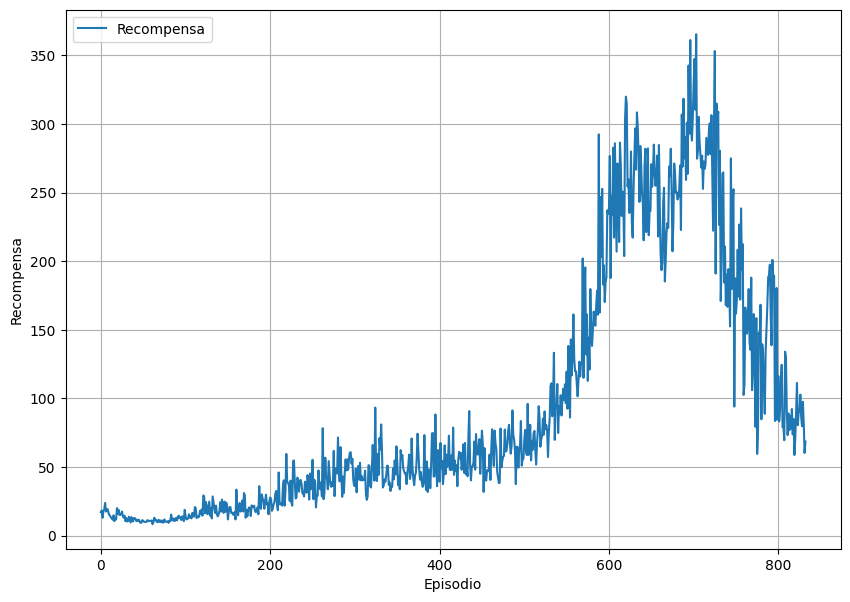

In [ ]:
retornodqn = retorno_deeplearning(5,"dqn",4,50000,100000,1)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_68 (Flatten)        (None, 4)                 0         
                                                                 
 dense_136 (Dense)           (None, 16)                80        
                                                                 
 activation_136 (Activation)  (None, 16)               0         
                                                                 
 dense_137 (Dense)           (None, 2)                 34        
                                                                 
 activation_137 (Activation)  (None, 2)                0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Training for 100000 

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3: Steps: 77
    77/100000: episode: 3, duration: 0.183s, episode steps:  20, steps per second: 109, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 0.450708, mse: 0.509762, mean_q: 0.491250
Episode 4: Steps: 99
    99/100000: episode: 4, duration: 0.241s, episode steps:  22, steps per second:  91, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 0.377398, mse: 0.491303, mean_q: 0.616392
Episode 5: Steps: 120
   120/100000: episode: 5, duration: 0.163s, episode steps:  21, steps per second: 129, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 0.301856, mse: 0.498058, mean_q: 0.726150
Episode 6: Steps: 145
   145/100000: episode: 6, duration: 0.193s, episode steps:  25, steps per second: 129, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.640 [0.000, 1.000],  loss: 0.254897, mse: 0.592

Episode 36: Steps: 661
   661/100000: episode: 36, duration: 0.172s, episode steps:  26, steps per second: 151, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 0.489754, mse: 11.180233, mean_q: 4.676409
Episode 37: Steps: 675
   675/100000: episode: 37, duration: 0.093s, episode steps:  14, steps per second: 151, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.476926, mse: 12.058821, mean_q: 4.858154
Episode 38: Steps: 691
   691/100000: episode: 38, duration: 0.122s, episode steps:  16, steps per second: 131, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.621502, mse: 12.859226, mean_q: 5.011359
Episode 39: Steps: 710
   710/100000: episode: 39, duration: 0.127s, episode steps:  19, steps per second: 150, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 0.71521

Episode 69: Steps: 1435
  1435/100000: episode: 69, duration: 0.594s, episode steps:  80, steps per second: 135, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 1.359297, mse: 41.910290, mean_q: 9.107709
Episode 70: Steps: 1456
  1456/100000: episode: 70, duration: 0.158s, episode steps:  21, steps per second: 133, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 1.461560, mse: 44.957333, mean_q: 9.428578
Episode 71: Steps: 1474
  1474/100000: episode: 71, duration: 0.144s, episode steps:  18, steps per second: 125, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 1.956313, mse: 45.910351, mean_q: 9.482674
Episode 72: Steps: 1494
  1494/100000: episode: 72, duration: 0.136s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.350 [0.000, 1.000],  loss: 1.7

Episode 101: Steps: 2269
  2269/100000: episode: 101, duration: 0.090s, episode steps:  10, steps per second: 112, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 3.003291, mse: 87.333771, mean_q: 13.106816
Episode 102: Steps: 2287
  2287/100000: episode: 102, duration: 0.142s, episode steps:  18, steps per second: 127, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 3.231612, mse: 87.396828, mean_q: 13.125278
Episode 103: Steps: 2351
  2351/100000: episode: 103, duration: 0.497s, episode steps:  64, steps per second: 129, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.107009, mse: 89.902519, mean_q: 13.344414
Episode 104: Steps: 2373
  2373/100000: episode: 104, duration: 0.152s, episode steps:  22, steps per second: 145, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],

Episode 134: Steps: 3413
  3413/100000: episode: 134, duration: 0.487s, episode steps:  74, steps per second: 152, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 4.581502, mse: 148.196838, mean_q: 17.207161
Episode 135: Steps: 3463
  3463/100000: episode: 135, duration: 0.323s, episode steps:  50, steps per second: 155, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 4.902578, mse: 149.247498, mean_q: 17.346939
Episode 136: Steps: 3545
  3545/100000: episode: 136, duration: 0.527s, episode steps:  82, steps per second: 156, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 4.145110, mse: 156.175781, mean_q: 17.765970
Episode 137: Steps: 3605
  3605/100000: episode: 137, duration: 0.386s, episode steps:  60, steps per second: 155, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.00

Episode 166: Steps: 4657
  4657/100000: episode: 166, duration: 0.527s, episode steps:  81, steps per second: 154, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 5.884055, mse: 233.670410, mean_q: 21.754036
Episode 167: Steps: 4695
  4695/100000: episode: 167, duration: 0.276s, episode steps:  38, steps per second: 138, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.891941, mse: 240.903214, mean_q: 22.073666
Episode 168: Steps: 4736
  4736/100000: episode: 168, duration: 0.270s, episode steps:  41, steps per second: 152, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 5.834633, mse: 242.322830, mean_q: 22.147907
Episode 169: Steps: 4791
  4791/100000: episode: 169, duration: 0.355s, episode steps:  55, steps per second: 155, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.527 [0.000, 1.00

Episode 198: Steps: 6409
  6409/100000: episode: 198, duration: 0.364s, episode steps:  49, steps per second: 135, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 6.106845, mse: 388.219910, mean_q: 28.230593
Episode 199: Steps: 6459
  6459/100000: episode: 199, duration: 0.345s, episode steps:  50, steps per second: 145, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 7.788895, mse: 397.637421, mean_q: 28.494549
Episode 200: Steps: 6525
  6525/100000: episode: 200, duration: 0.428s, episode steps:  66, steps per second: 154, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.217217, mse: 398.247467, mean_q: 28.405951
Episode 201: Steps: 6574
  6574/100000: episode: 201, duration: 0.339s, episode steps:  49, steps per second: 145, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.0

Episode 229: Steps: 8268
  8268/100000: episode: 229, duration: 0.345s, episode steps:  50, steps per second: 145, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 9.953897, mse: 524.394958, mean_q: 32.780228
Episode 230: Steps: 8332
  8332/100000: episode: 230, duration: 0.417s, episode steps:  64, steps per second: 154, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 9.895324, mse: 535.609253, mean_q: 33.114323
Episode 231: Steps: 8408
  8408/100000: episode: 231, duration: 0.555s, episode steps:  76, steps per second: 137, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 8.054005, mse: 536.302246, mean_q: 33.245193
Episode 232: Steps: 8475
  8475/100000: episode: 232, duration: 0.491s, episode steps:  67, steps per second: 137, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.00

Episode 260: Steps: 12198
 12198/100000: episode: 260, duration: 1.754s, episode steps: 276, steps per second: 157, episode reward: 276.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 11.833636, mse: 942.739380, mean_q: 44.230072
Episode 261: Steps: 12434
 12434/100000: episode: 261, duration: 1.551s, episode steps: 236, steps per second: 152, episode reward: 236.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 13.203875, mse: 983.437500, mean_q: 45.085590
Episode 262: Steps: 12690
 12690/100000: episode: 262, duration: 1.718s, episode steps: 256, steps per second: 149, episode reward: 256.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 12.594618, mse: 1021.721069, mean_q: 45.901955
Episode 263: Steps: 12897
 12897/100000: episode: 263, duration: 1.336s, episode steps: 207, steps per second: 155, episode reward: 207.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 

Episode 291: Steps: 23505
 23505/100000: episode: 291, duration: 3.003s, episode steps: 455, steps per second: 152, episode reward: 455.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 21.300226, mse: 2848.907715, mean_q: 77.237488
Episode 292: Steps: 23848
 23848/100000: episode: 292, duration: 2.348s, episode steps: 343, steps per second: 146, episode reward: 343.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 19.051516, mse: 2913.014160, mean_q: 78.162056
Episode 293: Steps: 24348
 24348/100000: episode: 293, duration: 4.160s, episode steps: 500, steps per second: 120, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 22.479473, mse: 2996.393555, mean_q: 79.191841
Episode 294: Steps: 24682
 24682/100000: episode: 294, duration: 2.491s, episode steps: 334, steps per second: 134, episode reward: 334.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 322: Steps: 36252
 36252/100000: episode: 322, duration: 4.771s, episode steps: 500, steps per second: 105, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 21.526606, mse: 4843.483887, mean_q: 100.210640
Episode 323: Steps: 36611
 36611/100000: episode: 323, duration: 4.248s, episode steps: 359, steps per second:  85, episode reward: 359.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 28.696423, mse: 4892.997070, mean_q: 100.698830
Episode 324: Steps: 36981
 36981/100000: episode: 324, duration: 3.201s, episode steps: 370, steps per second: 116, episode reward: 370.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 24.159269, mse: 4909.172363, mean_q: 100.783249
Episode 325: Steps: 37293
 37293/100000: episode: 325, duration: 2.961s, episode steps: 312, steps per second: 105, episode reward: 312.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 353: Steps: 48066
 48066/100000: episode: 353, duration: 2.531s, episode steps: 327, steps per second: 129, episode reward: 327.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 24.882824, mse: 5642.712891, mean_q: 107.117783
Episode 354: Steps: 48443
 48443/100000: episode: 354, duration: 2.629s, episode steps: 377, steps per second: 143, episode reward: 377.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 18.983093, mse: 5668.366699, mean_q: 107.328552
Episode 355: Steps: 48754
 48754/100000: episode: 355, duration: 2.096s, episode steps: 311, steps per second: 148, episode reward: 311.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 20.042751, mse: 5673.972656, mean_q: 107.404037
Episode 356: Steps: 49046
 49046/100000: episode: 356, duration: 2.018s, episode steps: 292, steps per second: 145, episode reward: 292.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 384: Steps: 58124
 58124/100000: episode: 384, duration: 1.966s, episode steps: 248, steps per second: 126, episode reward: 248.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 7.331590, mse: 5716.683594, mean_q: 105.979401
Episode 385: Steps: 58434
 58434/100000: episode: 385, duration: 3.312s, episode steps: 310, steps per second:  94, episode reward: 310.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 5.223179, mse: 5715.142578, mean_q: 105.859566
Episode 386: Steps: 58842
 58842/100000: episode: 386, duration: 4.013s, episode steps: 408, steps per second: 102, episode reward: 408.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 6.881569, mse: 5711.832031, mean_q: 105.739410
Episode 387: Steps: 59116
 59116/100000: episode: 387, duration: 2.070s, episode steps: 274, steps per second: 132, episode reward: 274.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 415: Steps: 66140
 66140/100000: episode: 415, duration: 1.271s, episode steps: 100, steps per second:  79, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 2.662150, mse: 5311.201660, mean_q: 101.069382
Episode 416: Steps: 66280
 66280/100000: episode: 416, duration: 2.080s, episode steps: 140, steps per second:  67, episode reward: 140.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.368252, mse: 5327.200195, mean_q: 101.275597
Episode 417: Steps: 66495
 66495/100000: episode: 417, duration: 2.017s, episode steps: 215, steps per second: 107, episode reward: 215.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 2.514509, mse: 5323.133789, mean_q: 101.167664
Episode 418: Steps: 66743
 66743/100000: episode: 418, duration: 2.195s, episode steps: 248, steps per second: 113, episode reward: 248.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 446: Steps: 76154
 76154/100000: episode: 446, duration: 3.374s, episode steps: 397, steps per second: 118, episode reward: 397.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 1.523209, mse: 4293.325195, mean_q: 89.052559
Episode 447: Steps: 76459
 76459/100000: episode: 447, duration: 2.241s, episode steps: 305, steps per second: 136, episode reward: 305.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.873917, mse: 4235.276855, mean_q: 88.362885
Episode 448: Steps: 76762
 76762/100000: episode: 448, duration: 2.820s, episode steps: 303, steps per second: 107, episode reward: 303.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 1.227245, mse: 4229.762207, mean_q: 88.231476
Episode 449: Steps: 77128
 77128/100000: episode: 449, duration: 3.379s, episode steps: 366, steps per second: 108, episode reward: 366.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [

Episode 477: Steps: 87181
 87181/100000: episode: 477, duration: 4.677s, episode steps: 330, steps per second:  71, episode reward: 330.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 1.099656, mse: 4020.211670, mean_q: 86.258400
Episode 478: Steps: 87619
 87619/100000: episode: 478, duration: 4.056s, episode steps: 438, steps per second: 108, episode reward: 438.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 0.721837, mse: 4003.011475, mean_q: 86.049675
Episode 479: Steps: 87891
 87891/100000: episode: 479, duration: 3.198s, episode steps: 272, steps per second:  85, episode reward: 272.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 1.238482, mse: 4002.765625, mean_q: 86.067024
Episode 480: Steps: 88195
 88195/100000: episode: 480, duration: 4.127s, episode steps: 304, steps per second:  74, episode reward: 304.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [

Episode 508: Steps: 99242
 99242/100000: episode: 508, duration: 4.513s, episode steps: 457, steps per second: 101, episode reward: 457.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 1.469449, mse: 4112.314453, mean_q: 87.476204
Episode 509: Steps: 99681
 99681/100000: episode: 509, duration: 4.038s, episode steps: 439, steps per second: 109, episode reward: 439.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.503 [0.000, 1.000],  loss: 1.992016, mse: 4068.624512, mean_q: 86.953926
done, took 860.385 seconds
done, took 860.385 seconds
Testing for 5 episodes ...
Episode 1: reward: 481.000, steps: 481
Episode 2: reward: 463.000, steps: 463
Episode 3: reward: 422.000, steps: 422
Episode 4: reward: 444.000, steps: 444
Episode 5: reward: 473.000, steps: 473
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_69 (Flatten)        (None,

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 45
    45/100000: episode: 1, duration: 10.015s, episode steps:  45, steps per second:   4, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 0.491733, mse: 0.501160, mean_q: 0.151148
Episode 2: Steps: 67
    67/100000: episode: 2, duration: 0.173s, episode steps:  22, steps per second: 127, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 0.501906, mse: 0.552976, mean_q: 0.366337
Episode 3: Steps: 93
    93/100000: episode: 3, duration: 0.186s, episode steps:  26, steps per second: 140, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 0.421191, mse: 0.521211, mean_q: 0.511705
Episode 4: Steps: 111
   111/100000: episode: 4, duration: 0.126s, episode steps:  18, steps per second: 143, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 0.328275, mse: 0.484

Episode 33: Steps: 679
   679/100000: episode: 33, duration: 0.142s, episode steps:  20, steps per second: 140, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 0.555160, mse: 13.299204, mean_q: 5.123378
Episode 34: Steps: 692
   692/100000: episode: 34, duration: 0.118s, episode steps:  13, steps per second: 111, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.609177, mse: 13.954177, mean_q: 5.250066
Episode 35: Steps: 711
   711/100000: episode: 35, duration: 0.133s, episode steps:  19, steps per second: 143, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 0.685970, mse: 14.660169, mean_q: 5.352694
Episode 36: Steps: 728
   728/100000: episode: 36, duration: 0.122s, episode steps:  17, steps per second: 139, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: 0.69383

Episode 65: Steps: 1484
  1484/100000: episode: 65, duration: 0.345s, episode steps:  33, steps per second:  96, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 1.267003, mse: 49.911163, mean_q: 10.002779
Episode 66: Steps: 1502
  1502/100000: episode: 66, duration: 0.135s, episode steps:  18, steps per second: 133, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.563105, mse: 52.135139, mean_q: 10.203067
Episode 67: Steps: 1539
  1539/100000: episode: 67, duration: 0.264s, episode steps:  37, steps per second: 140, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 1.480928, mse: 53.509060, mean_q: 10.331522
Episode 68: Steps: 1576
  1576/100000: episode: 68, duration: 0.281s, episode steps:  37, steps per second: 132, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 

Episode 97: Steps: 2509
  2509/100000: episode: 97, duration: 0.552s, episode steps:  76, steps per second: 138, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.933084, mse: 107.790657, mean_q: 14.736685
Episode 98: Steps: 2529
  2529/100000: episode: 98, duration: 0.149s, episode steps:  20, steps per second: 134, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 3.117151, mse: 110.096603, mean_q: 14.868637
Episode 99: Steps: 2550
  2550/100000: episode: 99, duration: 0.162s, episode steps:  21, steps per second: 130, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 2.015388, mse: 113.237122, mean_q: 15.161696
Episode 100: Steps: 2564
  2564/100000: episode: 100, duration: 0.107s, episode steps:  14, steps per second: 131, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  l

Episode 129: Steps: 3839
  3839/100000: episode: 129, duration: 0.254s, episode steps:  36, steps per second: 142, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.761649, mse: 217.107101, mean_q: 20.953142
Episode 130: Steps: 3872
  3872/100000: episode: 130, duration: 0.238s, episode steps:  33, steps per second: 138, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 5.052689, mse: 219.525925, mean_q: 21.088921
Episode 131: Steps: 3918
  3918/100000: episode: 131, duration: 0.375s, episode steps:  46, steps per second: 123, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 5.382771, mse: 220.382904, mean_q: 21.130236
Episode 132: Steps: 4008
  4008/100000: episode: 132, duration: 0.646s, episode steps:  90, steps per second: 139, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.00

Episode 161: Steps: 5407
  5407/100000: episode: 161, duration: 0.275s, episode steps:  36, steps per second: 131, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 8.526495, mse: 344.319214, mean_q: 26.427374
Episode 162: Steps: 5470
  5470/100000: episode: 162, duration: 0.582s, episode steps:  63, steps per second: 108, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 7.385562, mse: 340.553833, mean_q: 26.312630
Episode 163: Steps: 5506
  5506/100000: episode: 163, duration: 0.317s, episode steps:  36, steps per second: 113, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 5.848927, mse: 348.195374, mean_q: 26.689217
Episode 164: Steps: 5601
  5601/100000: episode: 164, duration: 0.603s, episode steps:  95, steps per second: 157, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.00

Episode 193: Steps: 7254
  7254/100000: episode: 193, duration: 0.354s, episode steps:  45, steps per second: 127, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 10.575537, mse: 488.993317, mean_q: 31.567144
Episode 194: Steps: 7287
  7287/100000: episode: 194, duration: 0.240s, episode steps:  33, steps per second: 138, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 11.544917, mse: 500.042389, mean_q: 31.908054
Episode 195: Steps: 7370
  7370/100000: episode: 195, duration: 0.610s, episode steps:  83, steps per second: 136, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 10.288612, mse: 503.484650, mean_q: 32.070747
Episode 196: Steps: 7404
  7404/100000: episode: 196, duration: 0.349s, episode steps:  34, steps per second:  97, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1

Episode 224: Steps: 9603
  9603/100000: episode: 224, duration: 0.488s, episode steps:  72, steps per second: 148, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 10.969966, mse: 708.390320, mean_q: 38.070122
Episode 225: Steps: 9665
  9665/100000: episode: 225, duration: 0.429s, episode steps:  62, steps per second: 145, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 9.076594, mse: 717.566345, mean_q: 38.444805
Episode 226: Steps: 9734
  9734/100000: episode: 226, duration: 0.482s, episode steps:  69, steps per second: 143, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 8.914701, mse: 729.399353, mean_q: 38.751286
Episode 227: Steps: 9786
  9786/100000: episode: 227, duration: 0.348s, episode steps:  52, steps per second: 149, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.0

Episode 255: Steps: 14772
 14772/100000: episode: 255, duration: 1.065s, episode steps: 164, steps per second: 154, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 8.813387, mse: 1141.611816, mean_q: 48.026337
Episode 256: Steps: 14977
 14977/100000: episode: 256, duration: 1.373s, episode steps: 205, steps per second: 149, episode reward: 205.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 12.834646, mse: 1166.361694, mean_q: 48.526142
Episode 257: Steps: 15164
 15164/100000: episode: 257, duration: 1.231s, episode steps: 187, steps per second: 152, episode reward: 187.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 10.221783, mse: 1172.593506, mean_q: 48.723114
Episode 258: Steps: 15347
 15347/100000: episode: 258, duration: 1.208s, episode steps: 183, steps per second: 151, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.530

Episode 286: Steps: 22662
 22662/100000: episode: 286, duration: 2.310s, episode steps: 283, steps per second: 122, episode reward: 283.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 14.854132, mse: 2160.911621, mean_q: 66.632591
Episode 287: Steps: 23125
 23125/100000: episode: 287, duration: 3.151s, episode steps: 463, steps per second: 147, episode reward: 463.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 14.401869, mse: 2222.463379, mean_q: 67.554024
Episode 288: Steps: 23392
 23392/100000: episode: 288, duration: 1.794s, episode steps: 267, steps per second: 149, episode reward: 267.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 13.526958, mse: 2275.628174, mean_q: 68.317223
Episode 289: Steps: 23641
 23641/100000: episode: 289, duration: 1.698s, episode steps: 249, steps per second: 147, episode reward: 249.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 317: Steps: 31594
 31594/100000: episode: 317, duration: 1.348s, episode steps: 195, steps per second: 145, episode reward: 195.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 15.705812, mse: 3230.927490, mean_q: 80.855148
Episode 318: Steps: 31837
 31837/100000: episode: 318, duration: 1.691s, episode steps: 243, steps per second: 144, episode reward: 243.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 19.589851, mse: 3251.482666, mean_q: 81.197098
Episode 319: Steps: 32050
 32050/100000: episode: 319, duration: 1.659s, episode steps: 213, steps per second: 128, episode reward: 213.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 15.125147, mse: 3281.287598, mean_q: 81.554192
Episode 320: Steps: 32271
 32271/100000: episode: 320, duration: 1.577s, episode steps: 221, steps per second: 140, episode reward: 221.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 348: Steps: 39447
 39447/100000: episode: 348, duration: 1.691s, episode steps: 241, steps per second: 142, episode reward: 241.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 17.449188, mse: 4014.639404, mean_q: 89.275162
Episode 349: Steps: 39711
 39711/100000: episode: 349, duration: 2.158s, episode steps: 264, steps per second: 122, episode reward: 264.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 17.836761, mse: 4043.444092, mean_q: 89.682022
Episode 350: Steps: 39952
 39952/100000: episode: 350, duration: 1.679s, episode steps: 241, steps per second: 143, episode reward: 241.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 13.112803, mse: 4059.478760, mean_q: 89.988487
Episode 351: Steps: 40364
 40364/100000: episode: 351, duration: 2.830s, episode steps: 412, steps per second: 146, episode reward: 412.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 379: Steps: 47453
 47453/100000: episode: 379, duration: 3.335s, episode steps: 287, steps per second:  86, episode reward: 287.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 18.841070, mse: 4427.900879, mean_q: 93.474396
Episode 380: Steps: 47678
 47678/100000: episode: 380, duration: 2.586s, episode steps: 225, steps per second:  87, episode reward: 225.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 14.171544, mse: 4431.418945, mean_q: 93.512428
Episode 381: Steps: 47898
 47898/100000: episode: 381, duration: 2.394s, episode steps: 220, steps per second:  92, episode reward: 220.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 11.913624, mse: 4475.707031, mean_q: 94.047195
Episode 382: Steps: 48127
 48127/100000: episode: 382, duration: 2.428s, episode steps: 229, steps per second:  94, episode reward: 229.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 410: Steps: 55577
 55577/100000: episode: 410, duration: 2.814s, episode steps: 229, steps per second:  81, episode reward: 229.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 8.414758, mse: 4720.092773, mean_q: 94.999931
Episode 411: Steps: 55808
 55808/100000: episode: 411, duration: 2.471s, episode steps: 231, steps per second:  93, episode reward: 231.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 5.180150, mse: 4792.354004, mean_q: 95.707268
Episode 412: Steps: 56079
 56079/100000: episode: 412, duration: 3.012s, episode steps: 271, steps per second:  90, episode reward: 271.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 5.882017, mse: 4737.918945, mean_q: 94.913429
Episode 413: Steps: 56293
 56293/100000: episode: 413, duration: 2.376s, episode steps: 214, steps per second:  90, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [

Episode 441: Steps: 63701
 63701/100000: episode: 441, duration: 2.631s, episode steps: 251, steps per second:  95, episode reward: 251.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 3.134054, mse: 4409.802246, mean_q: 88.952660
Episode 442: Steps: 63751
 63751/100000: episode: 442, duration: 0.640s, episode steps:  50, steps per second:  78, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 7.600676, mse: 4376.403320, mean_q: 88.559914
Episode 443: Steps: 64020
 64020/100000: episode: 443, duration: 2.445s, episode steps: 269, steps per second: 110, episode reward: 269.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 2.005097, mse: 4386.596191, mean_q: 88.557442
Episode 444: Steps: 64268
 64268/100000: episode: 444, duration: 2.315s, episode steps: 248, steps per second: 107, episode reward: 248.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0

Episode 472: Steps: 71036
 71036/100000: episode: 472, duration: 1.040s, episode steps: 143, steps per second: 138, episode reward: 143.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 1.318489, mse: 4010.650391, mean_q: 84.348854
Episode 473: Steps: 71303
 71303/100000: episode: 473, duration: 1.970s, episode steps: 267, steps per second: 136, episode reward: 267.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 4.502790, mse: 4015.915771, mean_q: 84.389175
Episode 474: Steps: 71469
 71469/100000: episode: 474, duration: 1.475s, episode steps: 166, steps per second: 113, episode reward: 166.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 0.575254, mse: 3982.270996, mean_q: 83.890564
Episode 475: Steps: 71838
 71838/100000: episode: 475, duration: 2.612s, episode steps: 369, steps per second: 141, episode reward: 369.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [

Episode 503: Steps: 78608
 78608/100000: episode: 503, duration: 2.638s, episode steps: 367, steps per second: 139, episode reward: 367.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 6.587899, mse: 3864.714844, mean_q: 83.768723
Episode 504: Steps: 78813
 78813/100000: episode: 504, duration: 1.431s, episode steps: 205, steps per second: 143, episode reward: 205.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 4.932464, mse: 3830.000488, mean_q: 83.414909
Episode 505: Steps: 79309
 79309/100000: episode: 505, duration: 3.586s, episode steps: 496, steps per second: 138, episode reward: 496.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 4.232657, mse: 3883.766602, mean_q: 84.253258
Episode 506: Steps: 79809
 79809/100000: episode: 506, duration: 4.458s, episode steps: 500, steps per second: 112, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [

Episode 534: Steps: 91187
 91187/100000: episode: 534, duration: 5.342s, episode steps: 484, steps per second:  91, episode reward: 484.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 6.577735, mse: 4555.505371, mean_q: 93.388481
Episode 535: Steps: 91687
 91687/100000: episode: 535, duration: 5.967s, episode steps: 500, steps per second:  84, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.686675, mse: 4580.855957, mean_q: 93.638016
Episode 536: Steps: 92130
 92130/100000: episode: 536, duration: 4.201s, episode steps: 443, steps per second: 105, episode reward: 443.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.503 [0.000, 1.000],  loss: 8.772946, mse: 4587.113770, mean_q: 93.864998
Episode 537: Steps: 92630
 92630/100000: episode: 537, duration: 5.402s, episode steps: 500, steps per second:  93, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 30
    30/100000: episode: 1, duration: 10.828s, episode steps:  30, steps per second:   3, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.502768, mse: 0.508575, mean_q: 0.149250
Episode 2: Steps: 48
    48/100000: episode: 2, duration: 0.164s, episode steps:  18, steps per second: 110, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 0.516208, mse: 0.540781, mean_q: 0.299686


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3: Steps: 73
    73/100000: episode: 3, duration: 0.213s, episode steps:  25, steps per second: 118, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 0.505026, mse: 0.567542, mean_q: 0.460853
Episode 4: Steps: 94
    94/100000: episode: 4, duration: 0.172s, episode steps:  21, steps per second: 122, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.381404, mse: 0.492002, mean_q: 0.577283
Episode 5: Steps: 105
   105/100000: episode: 5, duration: 0.097s, episode steps:  11, steps per second: 113, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 0.305750, mse: 0.482498, mean_q: 0.687574
Episode 6: Steps: 125
   125/100000: episode: 6, duration: 0.169s, episode steps:  20, steps per second: 118, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.650 [0.000, 1.000],  loss: 0.273810, mse: 0.518

Episode 36: Steps: 684
   684/100000: episode: 36, duration: 0.214s, episode steps:  25, steps per second: 117, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 0.877819, mse: 13.412529, mean_q: 5.086845
Episode 37: Steps: 700
   700/100000: episode: 37, duration: 0.142s, episode steps:  16, steps per second: 113, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 0.876639, mse: 13.926331, mean_q: 5.210944
Episode 38: Steps: 736
   736/100000: episode: 38, duration: 0.325s, episode steps:  36, steps per second: 111, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.639 [0.000, 1.000],  loss: 0.772649, mse: 14.691677, mean_q: 5.363911
Episode 39: Steps: 761
   761/100000: episode: 39, duration: 0.212s, episode steps:  25, steps per second: 118, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.360 [0.000, 1.000],  loss: 0.68344

Episode 68: Steps: 1422
  1422/100000: episode: 68, duration: 0.272s, episode steps:  14, steps per second:  51, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 1.587784, mse: 46.283909, mean_q: 9.511759
Episode 69: Steps: 1439
  1439/100000: episode: 69, duration: 0.367s, episode steps:  17, steps per second:  46, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 1.594769, mse: 46.854565, mean_q: 9.581233
Episode 70: Steps: 1459
  1459/100000: episode: 70, duration: 0.541s, episode steps:  20, steps per second:  37, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 2.355380, mse: 47.465500, mean_q: 9.594088
Episode 71: Steps: 1477
  1477/100000: episode: 71, duration: 0.602s, episode steps:  18, steps per second:  30, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 1.8

Episode 100: Steps: 2195
  2195/100000: episode: 100, duration: 0.405s, episode steps:  35, steps per second:  86, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 3.138100, mse: 85.512192, mean_q: 12.897127
Episode 101: Steps: 2238
  2238/100000: episode: 101, duration: 0.459s, episode steps:  43, steps per second:  94, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 2.140467, mse: 87.064438, mean_q: 13.126990
Episode 102: Steps: 2257
  2257/100000: episode: 102, duration: 0.233s, episode steps:  19, steps per second:  82, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.316 [0.000, 1.000],  loss: 2.758685, mse: 91.611732, mean_q: 13.443747
Episode 103: Steps: 2268
  2268/100000: episode: 103, duration: 0.154s, episode steps:  11, steps per second:  72, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],

Episode 132: Steps: 3045
  3045/100000: episode: 132, duration: 0.409s, episode steps:  39, steps per second:  95, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 3.376516, mse: 124.606850, mean_q: 15.767932
Episode 133: Steps: 3072
  3072/100000: episode: 133, duration: 0.287s, episode steps:  27, steps per second:  94, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 2.958809, mse: 126.578850, mean_q: 15.909285
Episode 134: Steps: 3119
  3119/100000: episode: 134, duration: 0.409s, episode steps:  47, steps per second: 115, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 3.711097, mse: 130.082993, mean_q: 16.061554
Episode 135: Steps: 3150
  3150/100000: episode: 135, duration: 0.282s, episode steps:  31, steps per second: 110, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.00

Episode 165: Steps: 4204
  4204/100000: episode: 165, duration: 1.156s, episode steps:  67, steps per second:  58, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 4.958820, mse: 185.124847, mean_q: 19.286119
Episode 166: Steps: 4262
  4262/100000: episode: 166, duration: 1.392s, episode steps:  58, steps per second:  42, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.791339, mse: 188.016800, mean_q: 19.438084
Episode 167: Steps: 4285
  4285/100000: episode: 167, duration: 0.294s, episode steps:  23, steps per second:  78, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 3.755574, mse: 189.271973, mean_q: 19.573149
Episode 168: Steps: 4316
  4316/100000: episode: 168, duration: 0.299s, episode steps:  31, steps per second: 104, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.00

Episode 198: Steps: 5434
  5434/100000: episode: 198, duration: 0.473s, episode steps:  57, steps per second: 120, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 6.525659, mse: 254.894104, mean_q: 22.734602
Episode 199: Steps: 5480
  5480/100000: episode: 199, duration: 0.390s, episode steps:  46, steps per second: 118, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.164815, mse: 258.298523, mean_q: 22.865036
Episode 200: Steps: 5522
  5522/100000: episode: 200, duration: 0.377s, episode steps:  42, steps per second: 111, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.810703, mse: 258.410858, mean_q: 22.887257
Episode 201: Steps: 5549
  5549/100000: episode: 201, duration: 0.224s, episode steps:  27, steps per second: 120, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.00

Episode 230: Steps: 6785
  6785/100000: episode: 230, duration: 0.608s, episode steps:  56, steps per second:  92, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 7.466141, mse: 332.229553, mean_q: 26.026245
Episode 231: Steps: 6866
  6866/100000: episode: 231, duration: 0.793s, episode steps:  81, steps per second: 102, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 8.055534, mse: 335.583252, mean_q: 26.163321
Episode 232: Steps: 6917
  6917/100000: episode: 232, duration: 0.452s, episode steps:  51, steps per second: 113, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 6.950679, mse: 340.584930, mean_q: 26.398745
Episode 233: Steps: 6952
  6952/100000: episode: 233, duration: 0.323s, episode steps:  35, steps per second: 108, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.00

Episode 262: Steps: 8417
  8417/100000: episode: 262, duration: 0.404s, episode steps:  47, steps per second: 116, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 7.241762, mse: 437.888214, mean_q: 29.954926
Episode 263: Steps: 8469
  8469/100000: episode: 263, duration: 0.442s, episode steps:  52, steps per second: 118, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 8.856394, mse: 445.902069, mean_q: 30.244612
Episode 264: Steps: 8531
  8531/100000: episode: 264, duration: 0.555s, episode steps:  62, steps per second: 112, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 7.576905, mse: 450.613647, mean_q: 30.433216
Episode 265: Steps: 8593
  8593/100000: episode: 265, duration: 0.533s, episode steps:  62, steps per second: 116, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.00

Episode 293: Steps: 10349
 10349/100000: episode: 293, duration: 0.619s, episode steps:  72, steps per second: 116, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 8.960569, mse: 565.478943, mean_q: 34.109463
Episode 294: Steps: 10395
 10395/100000: episode: 294, duration: 0.381s, episode steps:  46, steps per second: 121, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 8.491313, mse: 568.376892, mean_q: 34.207008
Episode 295: Steps: 10490
 10490/100000: episode: 295, duration: 1.041s, episode steps:  95, steps per second:  91, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 9.871093, mse: 578.278870, mean_q: 34.458183
Episode 296: Steps: 10585
 10585/100000: episode: 296, duration: 1.800s, episode steps:  95, steps per second:  53, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 

Episode 324: Steps: 12615
 12615/100000: episode: 324, duration: 0.550s, episode steps:  60, steps per second: 109, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 12.758428, mse: 725.374023, mean_q: 38.574055
Episode 325: Steps: 12708
 12708/100000: episode: 325, duration: 0.798s, episode steps:  93, steps per second: 117, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 11.143057, mse: 730.922607, mean_q: 38.786472
Episode 326: Steps: 12787
 12787/100000: episode: 326, duration: 0.677s, episode steps:  79, steps per second: 117, episode reward: 79.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 12.325257, mse: 732.100769, mean_q: 38.754826
Episode 327: Steps: 12875
 12875/100000: episode: 327, duration: 0.758s, episode steps:  88, steps per second: 116, episode reward: 88.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.00

Episode 355: Steps: 16616
 16616/100000: episode: 355, duration: 1.328s, episode steps: 154, steps per second: 116, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 14.195126, mse: 1013.912964, mean_q: 45.078449
Episode 356: Steps: 16739
 16739/100000: episode: 356, duration: 1.037s, episode steps: 123, steps per second: 119, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.439 [0.000, 1.000],  loss: 13.003313, mse: 1014.157837, mean_q: 45.062176
Episode 357: Steps: 16898
 16898/100000: episode: 357, duration: 1.319s, episode steps: 159, steps per second: 121, episode reward: 159.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 11.155327, mse: 1034.242310, mean_q: 45.653297
Episode 358: Steps: 17079
 17079/100000: episode: 358, duration: 1.510s, episode steps: 181, steps per second: 120, episode reward: 181.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 386: Steps: 22135
 22135/100000: episode: 386, duration: 2.070s, episode steps: 242, steps per second: 117, episode reward: 242.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 16.201775, mse: 1630.489868, mean_q: 57.658714
Episode 387: Steps: 22302
 22302/100000: episode: 387, duration: 1.400s, episode steps: 167, steps per second: 119, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 14.328901, mse: 1666.013794, mean_q: 58.278934
Episode 388: Steps: 22487
 22487/100000: episode: 388, duration: 1.561s, episode steps: 185, steps per second: 119, episode reward: 185.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 13.814643, mse: 1688.967407, mean_q: 58.771542
Episode 389: Steps: 22645
 22645/100000: episode: 389, duration: 1.309s, episode steps: 158, steps per second: 121, episode reward: 158.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 417: Steps: 27586
 27586/100000: episode: 417, duration: 2.097s, episode steps: 164, steps per second:  78, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 13.263587, mse: 2227.555664, mean_q: 67.148354
Episode 418: Steps: 27775
 27775/100000: episode: 418, duration: 1.570s, episode steps: 189, steps per second: 120, episode reward: 189.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 15.622235, mse: 2234.475586, mean_q: 67.117455
Episode 419: Steps: 27968
 27968/100000: episode: 419, duration: 1.630s, episode steps: 193, steps per second: 118, episode reward: 193.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 16.321388, mse: 2239.500977, mean_q: 67.154976
Episode 420: Steps: 28156
 28156/100000: episode: 420, duration: 1.679s, episode steps: 188, steps per second: 112, episode reward: 188.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 448: Steps: 33202
 33202/100000: episode: 448, duration: 1.405s, episode steps: 185, steps per second: 132, episode reward: 185.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 13.626162, mse: 2694.528076, mean_q: 72.867554
Episode 449: Steps: 33371
 33371/100000: episode: 449, duration: 1.287s, episode steps: 169, steps per second: 131, episode reward: 169.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 16.494728, mse: 2682.809082, mean_q: 72.546227
Episode 450: Steps: 33541
 33541/100000: episode: 450, duration: 1.265s, episode steps: 170, steps per second: 134, episode reward: 170.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 20.887407, mse: 2653.865234, mean_q: 71.942665
Episode 451: Steps: 33713
 33713/100000: episode: 451, duration: 1.284s, episode steps: 172, steps per second: 134, episode reward: 172.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 479: Steps: 38736
 38736/100000: episode: 479, duration: 1.584s, episode steps: 197, steps per second: 124, episode reward: 197.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 14.776875, mse: 2986.856689, mean_q: 75.833687
Episode 480: Steps: 38903
 38903/100000: episode: 480, duration: 1.746s, episode steps: 167, steps per second:  96, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 17.834127, mse: 3000.931396, mean_q: 75.930893
Episode 481: Steps: 39071
 39071/100000: episode: 481, duration: 1.575s, episode steps: 168, steps per second: 107, episode reward: 168.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 14.376548, mse: 2973.732178, mean_q: 75.643394
Episode 482: Steps: 39240
 39240/100000: episode: 482, duration: 1.484s, episode steps: 169, steps per second: 114, episode reward: 169.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 510: Steps: 43921
 43921/100000: episode: 510, duration: 2.363s, episode steps: 184, steps per second:  78, episode reward: 184.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 13.252604, mse: 3115.204590, mean_q: 76.833389
Episode 511: Steps: 44072
 44072/100000: episode: 511, duration: 1.700s, episode steps: 151, steps per second:  89, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 13.143461, mse: 3072.666504, mean_q: 76.212654
Episode 512: Steps: 44240
 44240/100000: episode: 512, duration: 1.591s, episode steps: 168, steps per second: 106, episode reward: 168.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 14.466849, mse: 3133.156738, mean_q: 76.892288
Episode 513: Steps: 44417
 44417/100000: episode: 513, duration: 1.481s, episode steps: 177, steps per second: 119, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 541: Steps: 49502
 49502/100000: episode: 541, duration: 1.253s, episode steps: 161, steps per second: 128, episode reward: 161.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 10.975838, mse: 3215.785400, mean_q: 77.306801
Episode 542: Steps: 49665
 49665/100000: episode: 542, duration: 1.282s, episode steps: 163, steps per second: 127, episode reward: 163.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 10.160625, mse: 3273.898682, mean_q: 77.980286
Episode 543: Steps: 49873
 49873/100000: episode: 543, duration: 1.740s, episode steps: 208, steps per second: 120, episode reward: 208.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 12.480721, mse: 3257.211426, mean_q: 77.808624
Episode 544: Steps: 50055
 50055/100000: episode: 544, duration: 1.583s, episode steps: 182, steps per second: 115, episode reward: 182.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.46

Episode 572: Steps: 54871
 54871/100000: episode: 572, duration: 4.068s, episode steps: 185, steps per second:  45, episode reward: 185.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 7.011572, mse: 3208.955811, mean_q: 76.114693
Episode 573: Steps: 55054
 55054/100000: episode: 573, duration: 2.453s, episode steps: 183, steps per second:  75, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 6.622223, mse: 3231.186523, mean_q: 76.608078
Episode 574: Steps: 55232
 55232/100000: episode: 574, duration: 1.761s, episode steps: 178, steps per second: 101, episode reward: 178.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 6.929018, mse: 3249.233154, mean_q: 76.805832
Episode 575: Steps: 55443
 55443/100000: episode: 575, duration: 2.184s, episode steps: 211, steps per second:  97, episode reward: 211.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [

Episode 603: Steps: 59999
 59999/100000: episode: 603, duration: 1.123s, episode steps: 154, steps per second: 137, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 5.070844, mse: 3008.489014, mean_q: 72.649643
Episode 604: Steps: 60153
 60153/100000: episode: 604, duration: 1.245s, episode steps: 154, steps per second: 124, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 1.482574, mse: 3048.344482, mean_q: 73.348129
Episode 605: Steps: 60308
 60308/100000: episode: 605, duration: 1.870s, episode steps: 155, steps per second:  83, episode reward: 155.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 1.905651, mse: 3022.883789, mean_q: 73.021347
Episode 606: Steps: 60499
 60499/100000: episode: 606, duration: 1.806s, episode steps: 191, steps per second: 106, episode reward: 191.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [

Episode 634: Steps: 65033
 65033/100000: episode: 634, duration: 1.728s, episode steps: 173, steps per second: 100, episode reward: 173.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.340405, mse: 2832.679443, mean_q: 70.673096
Episode 635: Steps: 65210
 65210/100000: episode: 635, duration: 1.379s, episode steps: 177, steps per second: 128, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 0.386739, mse: 2825.042969, mean_q: 70.619553
Episode 636: Steps: 65375
 65375/100000: episode: 636, duration: 1.200s, episode steps: 165, steps per second: 138, episode reward: 165.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 0.393542, mse: 2815.866699, mean_q: 70.504791
Episode 637: Steps: 65410
 65410/100000: episode: 637, duration: 0.269s, episode steps:  35, steps per second: 130, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0

Episode 665: Steps: 68991
 68991/100000: episode: 665, duration: 1.416s, episode steps: 153, steps per second: 108, episode reward: 153.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 0.324497, mse: 2741.866943, mean_q: 69.368629
Episode 666: Steps: 69138
 69138/100000: episode: 666, duration: 1.356s, episode steps: 147, steps per second: 108, episode reward: 147.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 0.305274, mse: 2749.295654, mean_q: 69.527718
Episode 667: Steps: 69288
 69288/100000: episode: 667, duration: 1.834s, episode steps: 150, steps per second:  82, episode reward: 150.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 0.239868, mse: 2704.761963, mean_q: 68.815575
Episode 668: Steps: 69436
 69436/100000: episode: 668, duration: 2.224s, episode steps: 148, steps per second:  67, episode reward: 148.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [

Episode 696: Steps: 73917
 73917/100000: episode: 696, duration: 1.692s, episode steps: 180, steps per second: 106, episode reward: 180.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 0.211857, mse: 2489.577881, mean_q: 65.494072
Episode 697: Steps: 74098
 74098/100000: episode: 697, duration: 1.688s, episode steps: 181, steps per second: 107, episode reward: 181.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 0.832988, mse: 2474.618896, mean_q: 65.408936
Episode 698: Steps: 74215
 74215/100000: episode: 698, duration: 1.075s, episode steps: 117, steps per second: 109, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 0.223908, mse: 2526.488525, mean_q: 66.137062
Episode 699: Steps: 74393
 74393/100000: episode: 699, duration: 1.770s, episode steps: 178, steps per second: 101, episode reward: 178.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [

Episode 727: Steps: 78460
 78460/100000: episode: 727, duration: 0.592s, episode steps:  61, steps per second: 103, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.410 [0.000, 1.000],  loss: 1.259870, mse: 2402.415283, mean_q: 64.541321
Episode 728: Steps: 78651
 78651/100000: episode: 728, duration: 1.885s, episode steps: 191, steps per second: 101, episode reward: 191.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 1.853924, mse: 2424.557617, mean_q: 65.003746
Episode 729: Steps: 78859
 78859/100000: episode: 729, duration: 2.081s, episode steps: 208, steps per second: 100, episode reward: 208.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 0.961249, mse: 2425.879150, mean_q: 65.025696
Episode 730: Steps: 79051
 79051/100000: episode: 730, duration: 1.871s, episode steps: 192, steps per second: 103, episode reward: 192.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0

Episode 758: Steps: 84016
 84016/100000: episode: 758, duration: 1.456s, episode steps: 198, steps per second: 136, episode reward: 198.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 2.099403, mse: 2441.325684, mean_q: 65.574142
Episode 759: Steps: 84155
 84155/100000: episode: 759, duration: 1.002s, episode steps: 139, steps per second: 139, episode reward: 139.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 4.851299, mse: 2441.118896, mean_q: 65.276855
Episode 760: Steps: 84184
 84184/100000: episode: 760, duration: 0.219s, episode steps:  29, steps per second: 133, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 0.647591, mse: 2430.729004, mean_q: 65.471992
Episode 761: Steps: 84370
 84370/100000: episode: 761, duration: 1.378s, episode steps: 186, steps per second: 135, episode reward: 186.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0

Episode 789: Steps: 91214
 91214/100000: episode: 789, duration: 3.705s, episode steps: 500, steps per second: 135, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.489974, mse: 2641.782959, mean_q: 68.381790
Episode 790: Steps: 91271
 91271/100000: episode: 790, duration: 0.421s, episode steps:  57, steps per second: 135, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 1.078942, mse: 2684.250000, mean_q: 69.363678
Episode 791: Steps: 91634
 91634/100000: episode: 791, duration: 2.707s, episode steps: 363, steps per second: 134, episode reward: 363.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 5.165381, mse: 2662.725342, mean_q: 68.546196
Episode 792: Steps: 91862
 91862/100000: episode: 792, duration: 1.911s, episode steps: 228, steps per second: 119, episode reward: 228.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0

Episode 820: Steps: 99441
 99441/100000: episode: 820, duration: 2.144s, episode steps: 293, steps per second: 137, episode reward: 293.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 2.876161, mse: 2823.431396, mean_q: 71.071968
Episode 821: Steps: 99535
 99535/100000: episode: 821, duration: 0.685s, episode steps:  94, steps per second: 137, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.751546, mse: 2795.749268, mean_q: 70.386108
Episode 822: Steps: 99659
 99659/100000: episode: 822, duration: 0.898s, episode steps: 124, steps per second: 138, episode reward: 124.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 3.168279, mse: 2839.419434, mean_q: 71.238205
done, took 933.681 seconds
done, took 933.681 seconds
Testing for 5 episodes ...
Episode 1: reward: 258.000, steps: 258
Episode 2: reward: 264.000, steps: 264
Episode 3: reward: 255.000, steps: 255
Ep

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1: Steps: 28
    28/100000: episode: 1, duration: 10.846s, episode steps:  28, steps per second:   3, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.495357, mse: 0.499590, mean_q: 0.150820
Episode 2: Steps: 49
    49/100000: episode: 2, duration: 0.166s, episode steps:  21, steps per second: 126, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 0.482019, mse: 0.502467, mean_q: 0.293752


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 3: Steps: 64
    64/100000: episode: 3, duration: 0.128s, episode steps:  15, steps per second: 117, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.503359, mse: 0.557550, mean_q: 0.449782
Episode 4: Steps: 108
   108/100000: episode: 4, duration: 0.381s, episode steps:  44, steps per second: 116, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 0.410497, mse: 0.531771, mean_q: 0.581828
Episode 5: Steps: 126
   126/100000: episode: 5, duration: 0.149s, episode steps:  18, steps per second: 121, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.302256, mse: 0.526861, mean_q: 0.739659
Episode 6: Steps: 149
   149/100000: episode: 6, duration: 0.173s, episode steps:  23, steps per second: 133, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 0.246264, mse: 0.63

Episode 35: Steps: 657
   657/100000: episode: 35, duration: 0.143s, episode steps:  20, steps per second: 140, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 0.518129, mse: 11.879354, mean_q: 4.857412
Episode 36: Steps: 673
   673/100000: episode: 36, duration: 0.119s, episode steps:  16, steps per second: 134, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 0.440150, mse: 12.256561, mean_q: 4.935897
Episode 37: Steps: 695
   695/100000: episode: 37, duration: 0.159s, episode steps:  22, steps per second: 138, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 0.460314, mse: 13.062867, mean_q: 5.143562
Episode 38: Steps: 718
   718/100000: episode: 38, duration: 0.171s, episode steps:  23, steps per second: 134, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 0.41806

Episode 68: Steps: 1356
  1356/100000: episode: 68, duration: 0.129s, episode steps:  18, steps per second: 140, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 1.461910, mse: 42.508801, mean_q: 9.164264
Episode 69: Steps: 1374
  1374/100000: episode: 69, duration: 0.130s, episode steps:  18, steps per second: 138, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.601621, mse: 43.533382, mean_q: 9.257833
Episode 70: Steps: 1391
  1391/100000: episode: 70, duration: 0.126s, episode steps:  17, steps per second: 135, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 1.729368, mse: 44.014057, mean_q: 9.319321
Episode 71: Steps: 1421
  1421/100000: episode: 71, duration: 0.236s, episode steps:  30, steps per second: 127, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000, 1.000],  loss: 1.6

Episode 101: Steps: 2371
  2371/100000: episode: 101, duration: 0.344s, episode steps:  48, steps per second: 140, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 2.499676, mse: 100.218140, mean_q: 14.207336
Episode 102: Steps: 2402
  2402/100000: episode: 102, duration: 0.226s, episode steps:  31, steps per second: 137, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 2.935391, mse: 102.861382, mean_q: 14.358418
Episode 103: Steps: 2434
  2434/100000: episode: 103, duration: 0.230s, episode steps:  32, steps per second: 139, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.059634, mse: 104.838219, mean_q: 14.503873
Episode 104: Steps: 2473
  2473/100000: episode: 104, duration: 0.274s, episode steps:  39, steps per second: 143, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.436 [0.000, 1.00

Episode 133: Steps: 3256
  3256/100000: episode: 133, duration: 0.264s, episode steps:  38, steps per second: 144, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 3.335991, mse: 152.960678, mean_q: 17.576361
Episode 134: Steps: 3278
  3278/100000: episode: 134, duration: 0.158s, episode steps:  22, steps per second: 139, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.470408, mse: 154.810455, mean_q: 17.667082
Episode 135: Steps: 3320
  3320/100000: episode: 135, duration: 0.292s, episode steps:  42, steps per second: 144, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 4.564394, mse: 155.757645, mean_q: 17.652813
Episode 136: Steps: 3347
  3347/100000: episode: 136, duration: 0.194s, episode steps:  27, steps per second: 139, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.00

Episode 165: Steps: 4284
  4284/100000: episode: 165, duration: 0.147s, episode steps:  19, steps per second: 129, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 4.206814, mse: 214.184296, mean_q: 20.817194
Episode 166: Steps: 4361
  4361/100000: episode: 166, duration: 0.616s, episode steps:  77, steps per second: 125, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 5.077112, mse: 221.614365, mean_q: 21.133394
Episode 167: Steps: 4408
  4408/100000: episode: 167, duration: 0.366s, episode steps:  47, steps per second: 128, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 4.975655, mse: 220.669418, mean_q: 21.076767
Episode 168: Steps: 4455
  4455/100000: episode: 168, duration: 0.327s, episode steps:  47, steps per second: 144, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.00

Episode 197: Steps: 5893
  5893/100000: episode: 197, duration: 0.317s, episode steps:  45, steps per second: 142, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 6.169439, mse: 315.130981, mean_q: 25.238153
Episode 198: Steps: 5931
  5931/100000: episode: 198, duration: 0.265s, episode steps:  38, steps per second: 143, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 5.809767, mse: 326.239960, mean_q: 25.766266
Episode 199: Steps: 5955
  5955/100000: episode: 199, duration: 0.170s, episode steps:  24, steps per second: 141, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.431688, mse: 332.027924, mean_q: 25.959398
Episode 200: Steps: 5994
  5994/100000: episode: 200, duration: 0.275s, episode steps:  39, steps per second: 142, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.00

Episode 229: Steps: 7493
  7493/100000: episode: 229, duration: 0.420s, episode steps:  56, steps per second: 133, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 6.684153, mse: 430.118195, mean_q: 29.607351
Episode 230: Steps: 7564
  7564/100000: episode: 230, duration: 0.603s, episode steps:  71, steps per second: 118, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 8.379169, mse: 429.797791, mean_q: 29.497610
Episode 231: Steps: 7593
  7593/100000: episode: 231, duration: 0.294s, episode steps:  29, steps per second:  99, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 9.184650, mse: 437.583862, mean_q: 29.803831
Episode 232: Steps: 7663
  7663/100000: episode: 232, duration: 0.780s, episode steps:  70, steps per second:  90, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.00

Episode 260: Steps: 9862
  9862/100000: episode: 260, duration: 0.899s, episode steps: 127, steps per second: 141, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000, 1.000],  loss: 7.726723, mse: 578.483948, mean_q: 34.410789
Episode 261: Steps: 9942
  9942/100000: episode: 261, duration: 0.561s, episode steps:  80, steps per second: 143, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 7.641599, mse: 584.504639, mean_q: 34.608070
Episode 262: Steps: 10058
 10058/100000: episode: 262, duration: 0.806s, episode steps: 116, steps per second: 144, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 8.595926, mse: 598.750244, mean_q: 34.971718
Episode 263: Steps: 10183
 10183/100000: episode: 263, duration: 0.877s, episode steps: 125, steps per second: 143, episode reward: 125.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000,

Episode 291: Steps: 15198
 15198/100000: episode: 291, duration: 0.664s, episode steps:  83, steps per second: 125, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.554 [0.000, 1.000],  loss: 10.704725, mse: 1126.752319, mean_q: 48.284130
Episode 292: Steps: 15420
 15420/100000: episode: 292, duration: 1.614s, episode steps: 222, steps per second: 138, episode reward: 222.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 12.297347, mse: 1139.174438, mean_q: 48.500172
Episode 293: Steps: 15680
 15680/100000: episode: 293, duration: 1.829s, episode steps: 260, steps per second: 142, episode reward: 260.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 12.544868, mse: 1154.047241, mean_q: 48.811352
Episode 294: Steps: 15874
 15874/100000: episode: 294, duration: 1.572s, episode steps: 194, steps per second: 123, episode reward: 194.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474

Episode 322: Steps: 21982
 21982/100000: episode: 322, duration: 1.573s, episode steps: 219, steps per second: 139, episode reward: 219.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 15.022773, mse: 1934.480347, mean_q: 63.333004
Episode 323: Steps: 22180
 22180/100000: episode: 323, duration: 1.414s, episode steps: 198, steps per second: 140, episode reward: 198.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 14.455096, mse: 1944.817871, mean_q: 63.486031
Episode 324: Steps: 22559
 22559/100000: episode: 324, duration: 2.724s, episode steps: 379, steps per second: 139, episode reward: 379.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 12.918592, mse: 1990.897217, mean_q: 64.288353
Episode 325: Steps: 22830
 22830/100000: episode: 325, duration: 1.944s, episode steps: 271, steps per second: 139, episode reward: 271.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 353: Steps: 29354
 29354/100000: episode: 353, duration: 1.780s, episode steps: 249, steps per second: 140, episode reward: 249.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 11.647201, mse: 2818.835938, mean_q: 75.970917
Episode 354: Steps: 29500
 29500/100000: episode: 354, duration: 1.059s, episode steps: 146, steps per second: 138, episode reward: 146.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 17.669714, mse: 2833.083984, mean_q: 76.074913
Episode 355: Steps: 29735
 29735/100000: episode: 355, duration: 1.677s, episode steps: 235, steps per second: 140, episode reward: 235.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 14.797821, mse: 2848.980957, mean_q: 76.192818
Episode 356: Steps: 29942
 29942/100000: episode: 356, duration: 1.513s, episode steps: 207, steps per second: 137, episode reward: 207.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 384: Steps: 36253
 36253/100000: episode: 384, duration: 1.809s, episode steps: 234, steps per second: 129, episode reward: 234.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 13.099407, mse: 3536.209961, mean_q: 84.532951
Episode 385: Steps: 36529
 36529/100000: episode: 385, duration: 3.040s, episode steps: 276, steps per second:  91, episode reward: 276.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 14.185248, mse: 3545.508789, mean_q: 84.525093
Episode 386: Steps: 36712
 36712/100000: episode: 386, duration: 1.331s, episode steps: 183, steps per second: 138, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 15.616665, mse: 3557.751709, mean_q: 84.604637
Episode 387: Steps: 36928
 36928/100000: episode: 387, duration: 1.582s, episode steps: 216, steps per second: 137, episode reward: 216.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 415: Steps: 42876
 42876/100000: episode: 415, duration: 2.115s, episode steps: 254, steps per second: 120, episode reward: 254.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 11.365534, mse: 3947.550049, mean_q: 88.019135
Episode 416: Steps: 43119
 43119/100000: episode: 416, duration: 1.764s, episode steps: 243, steps per second: 138, episode reward: 243.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 11.589829, mse: 3984.631104, mean_q: 88.477264
Episode 417: Steps: 43327
 43327/100000: episode: 417, duration: 1.509s, episode steps: 208, steps per second: 138, episode reward: 208.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 11.495696, mse: 3997.774658, mean_q: 88.561859
Episode 418: Steps: 43541
 43541/100000: episode: 418, duration: 1.578s, episode steps: 214, steps per second: 136, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 446: Steps: 50066
 50066/100000: episode: 446, duration: 1.518s, episode steps: 205, steps per second: 135, episode reward: 205.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 8.220175, mse: 4507.468750, mean_q: 93.176254
Episode 447: Steps: 50260
 50260/100000: episode: 447, duration: 1.455s, episode steps: 194, steps per second: 133, episode reward: 194.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 18.266226, mse: 4423.275879, mean_q: 92.229897
Episode 448: Steps: 50525
 50525/100000: episode: 448, duration: 2.000s, episode steps: 265, steps per second: 132, episode reward: 265.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 12.562185, mse: 4474.827148, mean_q: 92.841904
Episode 449: Steps: 50763
 50763/100000: episode: 449, duration: 1.761s, episode steps: 238, steps per second: 135, episode reward: 238.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479

Episode 477: Steps: 56910
 56910/100000: episode: 477, duration: 1.578s, episode steps: 211, steps per second: 134, episode reward: 211.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 4.604254, mse: 4716.101074, mean_q: 93.680023
Episode 478: Steps: 57113
 57113/100000: episode: 478, duration: 1.699s, episode steps: 203, steps per second: 119, episode reward: 203.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 4.107060, mse: 4602.196289, mean_q: 92.270851
Episode 479: Steps: 57301
 57301/100000: episode: 479, duration: 1.523s, episode steps: 188, steps per second: 123, episode reward: 188.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 3.901711, mse: 4657.160156, mean_q: 92.514839
Episode 480: Steps: 57524
 57524/100000: episode: 480, duration: 1.614s, episode steps: 223, steps per second: 138, episode reward: 223.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [

Episode 508: Steps: 63256
 63256/100000: episode: 508, duration: 1.761s, episode steps: 222, steps per second: 126, episode reward: 222.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 2.180153, mse: 4353.322266, mean_q: 88.710037
Episode 509: Steps: 63462
 63462/100000: episode: 509, duration: 1.692s, episode steps: 206, steps per second: 122, episode reward: 206.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 1.283118, mse: 4265.947754, mean_q: 87.583473
Episode 510: Steps: 63665
 63665/100000: episode: 510, duration: 1.559s, episode steps: 203, steps per second: 130, episode reward: 203.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 0.520285, mse: 4272.152832, mean_q: 87.729279
Episode 511: Steps: 63894
 63894/100000: episode: 511, duration: 1.745s, episode steps: 229, steps per second: 131, episode reward: 229.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [

Episode 539: Steps: 69803
 69803/100000: episode: 539, duration: 1.607s, episode steps: 215, steps per second: 134, episode reward: 215.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.635045, mse: 3805.089355, mean_q: 81.846970
Episode 540: Steps: 70047
 70047/100000: episode: 540, duration: 1.787s, episode steps: 244, steps per second: 137, episode reward: 244.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 1.151674, mse: 3822.116699, mean_q: 82.149399
Episode 541: Steps: 70230
 70230/100000: episode: 541, duration: 1.356s, episode steps: 183, steps per second: 135, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 1.226197, mse: 3825.859375, mean_q: 82.344429
Episode 542: Steps: 70484
 70484/100000: episode: 542, duration: 1.908s, episode steps: 254, steps per second: 133, episode reward: 254.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [

Episode 570: Steps: 76156
 76156/100000: episode: 570, duration: 1.312s, episode steps: 175, steps per second: 133, episode reward: 175.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 0.172451, mse: 3393.778564, mean_q: 77.111320
Episode 571: Steps: 76413
 76413/100000: episode: 571, duration: 1.924s, episode steps: 257, steps per second: 134, episode reward: 257.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 0.385966, mse: 3392.303955, mean_q: 77.346474
Episode 572: Steps: 76647
 76647/100000: episode: 572, duration: 1.746s, episode steps: 234, steps per second: 134, episode reward: 234.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.170738, mse: 3385.554443, mean_q: 77.066208
Episode 573: Steps: 76860
 76860/100000: episode: 573, duration: 1.583s, episode steps: 213, steps per second: 135, episode reward: 213.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [

Episode 601: Steps: 81938
 81938/100000: episode: 601, duration: 1.955s, episode steps: 232, steps per second: 119, episode reward: 232.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.917227, mse: 3196.291504, mean_q: 75.156853
Episode 602: Steps: 82153
 82153/100000: episode: 602, duration: 1.595s, episode steps: 215, steps per second: 135, episode reward: 215.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 0.156595, mse: 3138.876953, mean_q: 74.240883
Episode 603: Steps: 82357
 82357/100000: episode: 603, duration: 1.511s, episode steps: 204, steps per second: 135, episode reward: 204.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.553404, mse: 3150.825439, mean_q: 74.571815
Episode 604: Steps: 82604
 82604/100000: episode: 604, duration: 1.856s, episode steps: 247, steps per second: 133, episode reward: 247.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [

Episode 632: Steps: 89169
 89169/100000: episode: 632, duration: 1.590s, episode steps: 214, steps per second: 135, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 0.163873, mse: 3019.447998, mean_q: 72.804131
Episode 633: Steps: 89397
 89397/100000: episode: 633, duration: 1.690s, episode steps: 228, steps per second: 135, episode reward: 228.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 0.147746, mse: 3009.143799, mean_q: 72.727303
Episode 634: Steps: 89613
 89613/100000: episode: 634, duration: 1.584s, episode steps: 216, steps per second: 136, episode reward: 216.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 0.173993, mse: 3024.750488, mean_q: 72.993690
Episode 635: Steps: 89869
 89869/100000: episode: 635, duration: 1.920s, episode steps: 256, steps per second: 133, episode reward: 256.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [

Episode 663: Steps: 96013
 96013/100000: episode: 663, duration: 1.505s, episode steps: 184, steps per second: 122, episode reward: 184.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 0.666048, mse: 2953.092773, mean_q: 72.015129
Episode 664: Steps: 96063
 96063/100000: episode: 664, duration: 0.454s, episode steps:  50, steps per second: 110, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.117366, mse: 2864.369629, mean_q: 70.622902
Episode 665: Steps: 96219
 96219/100000: episode: 665, duration: 1.336s, episode steps: 156, steps per second: 117, episode reward: 156.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 1.122326, mse: 2876.628906, mean_q: 70.877876
Episode 666: Steps: 96396
 96396/100000: episode: 666, duration: 1.320s, episode steps: 177, steps per second: 134, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0

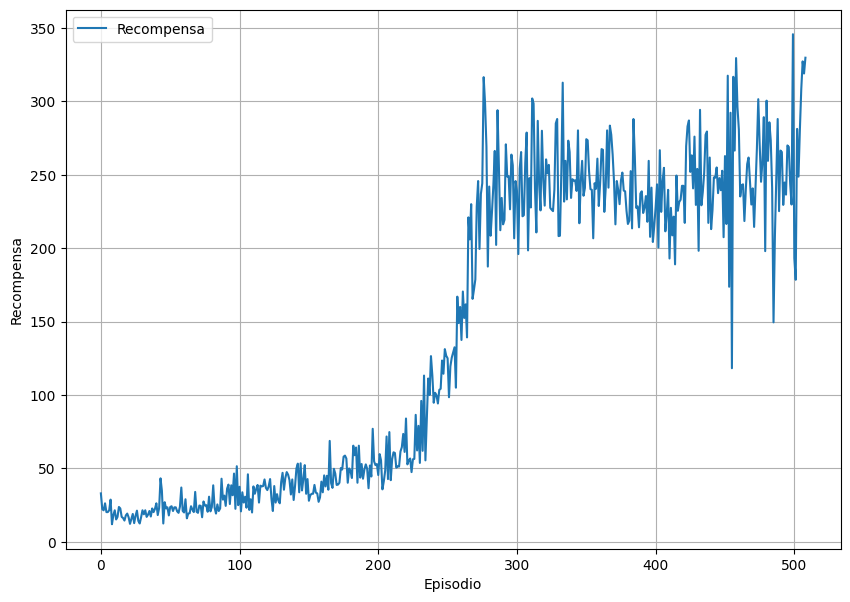

In [ ]:
retornodqn2 = retorno_deeplearning(5,"dqn",16,50000,100000,5)

### Experimentos DeepSARSA

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_72 (Flatten)        (None, 4)                 0         
                                                                 
 dense_144 (Dense)           (None, 4)                 20        
                                                                 
 activation_144 (Activation)  (None, 4)                0         
                                                                 
 dense_145 (Dense)           (None, 2)                 10        
                                                                 
 activation_145 (Activation)  (None, 2)                0         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Training for 100000 st

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 17
    17/100000: episode: 1, duration: 8.839s, episode steps:  17, steps per second:   2, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.235 [0.000, 1.000],  loss: 0.591646, mse: 0.998314, mean_q: 0.857035
Episode 2: Steps: 26
    26/100000: episode: 2, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: 0.515546, mse: 0.541252, mean_q: -0.069264
Episode 3: Steps: 36
    36/100000: episode: 3, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.594606, mse: 0.793601, mean_q: 0.526844
Episode 4: Steps: 50
    50/100000: episode: 4, duration: 0.115s, episode steps:  14, steps per second: 122, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.802013, mse: 1.0023

Episode 33: Steps: 483
   483/100000: episode: 33, duration: 0.164s, episode steps:  25, steps per second: 153, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.360 [0.000, 1.000],  loss: 0.918103, mse: 1.238398, mean_q: 1.267280
Episode 34: Steps: 496
   496/100000: episode: 34, duration: 0.085s, episode steps:  13, steps per second: 152, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 1.613477, mse: 2.124949, mean_q: 1.988449
Episode 35: Steps: 506
   506/100000: episode: 35, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 1.093772, mse: 1.363000, mean_q: 1.871064
Episode 36: Steps: 514
   514/100000: episode: 36, duration: 0.077s, episode steps:   8, steps per second: 104, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.143767, 

Episode 67: Steps: 886
   886/100000: episode: 67, duration: 0.075s, episode steps:  10, steps per second: 134, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.655822, mse: 3.066242, mean_q: 4.295155
Episode 68: Steps: 897
   897/100000: episode: 68, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 2.670208, mse: 3.295001, mean_q: 3.790368
Episode 69: Steps: 907
   907/100000: episode: 69, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.796614, mse: 3.187516, mean_q: 4.409814
Episode 70: Steps: 917
   917/100000: episode: 70, duration: 0.077s, episode steps:  10, steps per second: 130, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.835545, 

Episode 101: Steps: 1231
  1231/100000: episode: 101, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.619471, mse: 3.934242, mean_q: 5.400708
Episode 102: Steps: 1241
  1241/100000: episode: 102, duration: 0.066s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.609667, mse: 3.915959, mean_q: 5.406641
Episode 103: Steps: 1251
  1251/100000: episode: 103, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.590609, mse: 3.879055, mean_q: 5.367248
Episode 104: Steps: 1262
  1262/100000: episode: 104, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss

Episode 135: Steps: 1550
  1550/100000: episode: 135, duration: 0.099s, episode steps:  15, steps per second: 152, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.133 [0.000, 1.000],  loss: 3.518737, mse: 4.571508, mean_q: 5.343031
Episode 136: Steps: 1558
  1558/100000: episode: 136, duration: 0.053s, episode steps:   8, steps per second: 152, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.005548, mse: 4.111490, mean_q: 5.585773
Episode 137: Steps: 1567
  1567/100000: episode: 137, duration: 0.057s, episode steps:   9, steps per second: 157, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.101996, mse: 4.258867, mean_q: 5.826303
Episode 138: Steps: 1576
  1576/100000: episode: 138, duration: 0.061s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 167: Steps: 1845
  1845/100000: episode: 167, duration: 0.067s, episode steps:   9, steps per second: 134, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.234027, mse: 4.385801, mean_q: 6.130759
Episode 168: Steps: 1855
  1855/100000: episode: 168, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.434403, mse: 4.647055, mean_q: 6.549312
Episode 169: Steps: 1865
  1865/100000: episode: 169, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.367071, mse: 4.581866, mean_q: 6.473003
Episode 170: Steps: 1874
  1874/100000: episode: 170, duration: 0.062s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 200: Steps: 2165
  2165/100000: episode: 200, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.338909, mse: 4.440094, mean_q: 6.434649
Episode 201: Steps: 2174
  2174/100000: episode: 201, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.299082, mse: 4.392852, mean_q: 6.402566
Episode 202: Steps: 2183
  2183/100000: episode: 202, duration: 0.057s, episode steps:   9, steps per second: 158, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.401656, mse: 4.504253, mean_q: 6.569846
Episode 203: Steps: 2191
  2191/100000: episode: 203, duration: 0.057s, episode steps:   8, steps per second: 139, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 232: Steps: 2459
  2459/100000: episode: 232, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.416240, mse: 4.550220, mean_q: 7.047137
Episode 233: Steps: 2468
  2468/100000: episode: 233, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.428434, mse: 4.528302, mean_q: 6.787677
Episode 234: Steps: 2477
  2477/100000: episode: 234, duration: 0.058s, episode steps:   9, steps per second: 156, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.335923, mse: 4.425878, mean_q: 6.724987
Episode 235: Steps: 2485
  2485/100000: episode: 235, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 264: Steps: 2752
  2752/100000: episode: 264, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.176431, mse: 4.266887, mean_q: 6.835976
Episode 265: Steps: 2762
  2762/100000: episode: 265, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.166726, mse: 4.290229, mean_q: 7.082555
Episode 266: Steps: 2771
  2771/100000: episode: 266, duration: 0.058s, episode steps:   9, steps per second: 156, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.287386, mse: 4.375135, mean_q: 6.932009
Episode 267: Steps: 2779
  2779/100000: episode: 267, duration: 0.054s, episode steps:   8, steps per second: 148, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 296: Steps: 3052
  3052/100000: episode: 296, duration: 0.078s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.862799, mse: 3.989042, mean_q: 7.117865
Episode 297: Steps: 3061
  3061/100000: episode: 297, duration: 0.067s, episode steps:   9, steps per second: 135, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.932068, mse: 4.021597, mean_q: 6.869082
Episode 298: Steps: 3070
  3070/100000: episode: 298, duration: 0.072s, episode steps:   9, steps per second: 124, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.942041, mse: 4.020430, mean_q: 6.904652
Episode 299: Steps: 3079
  3079/100000: episode: 299, duration: 0.072s, episode steps:   9, steps per second: 126, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 328: Steps: 3350
  3350/100000: episode: 328, duration: 0.066s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.514802, mse: 3.625011, mean_q: 7.098918
Episode 329: Steps: 3359
  3359/100000: episode: 329, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.882352, mse: 3.965660, mean_q: 7.149131
Episode 330: Steps: 3369
  3369/100000: episode: 330, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.512364, mse: 3.617980, mean_q: 7.101555
Episode 331: Steps: 3378
  3378/100000: episode: 331, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 363: Steps: 3677
  3677/100000: episode: 363, duration: 0.054s, episode steps:   8, steps per second: 147, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.704099, mse: 3.753189, mean_q: 6.942181
Episode 364: Steps: 3685
  3685/100000: episode: 364, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.688458, mse: 3.739722, mean_q: 6.946191
Episode 365: Steps: 3694
  3694/100000: episode: 365, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.431919, mse: 3.510242, mean_q: 7.094268
Episode 366: Steps: 3704
  3704/100000: episode: 366, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 395: Steps: 3972
  3972/100000: episode: 395, duration: 0.053s, episode steps:   8, steps per second: 152, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.282887, mse: 3.323356, mean_q: 6.810786
Episode 396: Steps: 3980
  3980/100000: episode: 396, duration: 0.053s, episode steps:   8, steps per second: 150, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.477959, mse: 3.522912, mean_q: 7.044073
Episode 397: Steps: 3989
  3989/100000: episode: 397, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.140986, mse: 3.205296, mean_q: 7.110913
Episode 398: Steps: 3999
  3999/100000: episode: 398, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 427: Steps: 4272
  4272/100000: episode: 427, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.683033, mse: 2.741058, mean_q: 6.907334
Episode 428: Steps: 4282
  4282/100000: episode: 428, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.377714, mse: 2.463393, mean_q: 6.909932
Episode 429: Steps: 4290
  4290/100000: episode: 429, duration: 0.052s, episode steps:   8, steps per second: 153, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.951079, mse: 2.987403, mean_q: 6.805589
Episode 430: Steps: 4298
  4298/100000: episode: 430, duration: 0.051s, episode steps:   8, steps per second: 158, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 459: Steps: 4559
  4559/100000: episode: 459, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.292543, mse: 2.341469, mean_q: 6.822881
Episode 460: Steps: 4568
  4568/100000: episode: 460, duration: 0.058s, episode steps:   9, steps per second: 155, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.173850, mse: 2.224022, mean_q: 6.672618
Episode 461: Steps: 4578
  4578/100000: episode: 461, duration: 0.065s, episode steps:  10, steps per second: 154, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.980969, mse: 2.058022, mean_q: 6.845134
Episode 462: Steps: 4587
  4587/100000: episode: 462, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 491: Steps: 4864
  4864/100000: episode: 491, duration: 0.075s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.348763, mse: 1.433117, mean_q: 6.577182
Episode 492: Steps: 4873
  4873/100000: episode: 492, duration: 0.058s, episode steps:   9, steps per second: 156, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.882760, mse: 1.930498, mean_q: 6.686437
Episode 493: Steps: 4883
  4883/100000: episode: 493, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.593434, mse: 1.654123, mean_q: 6.652653
Episode 494: Steps: 4893
  4893/100000: episode: 494, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 526: Steps: 5198
  5198/100000: episode: 526, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.097425, mse: 2.126590, mean_q: 6.904122
Episode 527: Steps: 5207
  5207/100000: episode: 527, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.582182, mse: 1.620588, mean_q: 6.678312
Episode 528: Steps: 5216
  5216/100000: episode: 528, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.535112, mse: 1.576009, mean_q: 6.634105
Episode 529: Steps: 5226
  5226/100000: episode: 529, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 558: Steps: 5502
  5502/100000: episode: 558, duration: 0.082s, episode steps:  10, steps per second: 123, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.044131, mse: 1.089378, mean_q: 6.611832
Episode 559: Steps: 5511
  5511/100000: episode: 559, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.313449, mse: 1.347430, mean_q: 6.692160
Episode 560: Steps: 5519
  5519/100000: episode: 560, duration: 0.057s, episode steps:   8, steps per second: 140, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.660053, mse: 1.684852, mean_q: 6.726012
Episode 561: Steps: 5528
  5528/100000: episode: 561, duration: 0.069s, episode steps:   9, steps per second: 131, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 590: Steps: 5793
  5793/100000: episode: 590, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.800645, mse: 0.848641, mean_q: 6.460464
Episode 591: Steps: 5804
  5804/100000: episode: 591, duration: 0.072s, episode steps:  11, steps per second: 154, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.666235, mse: 0.732369, mean_q: 6.248982
Episode 592: Steps: 5814
  5814/100000: episode: 592, duration: 0.064s, episode steps:  10, steps per second: 157, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.756879, mse: 0.798522, mean_q: 6.270169
Episode 593: Steps: 5825
  5825/100000: episode: 593, duration: 0.073s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 625: Steps: 6120
  6120/100000: episode: 625, duration: 0.058s, episode steps:   9, steps per second: 154, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.786576, mse: 0.811281, mean_q: 6.336481
Episode 626: Steps: 6129
  6129/100000: episode: 626, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.723016, mse: 0.751627, mean_q: 6.206868
Episode 627: Steps: 6139
  6139/100000: episode: 627, duration: 0.083s, episode steps:  10, steps per second: 121, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.571561, mse: 0.610800, mean_q: 6.008555
Episode 628: Steps: 6148
  6148/100000: episode: 628, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 658: Steps: 6429
  6429/100000: episode: 658, duration: 0.093s, episode steps:  10, steps per second: 107, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.495143, mse: 0.541389, mean_q: 6.433268
Episode 659: Steps: 6439
  6439/100000: episode: 659, duration: 0.078s, episode steps:  10, steps per second: 128, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.446563, mse: 0.495436, mean_q: 6.178489
Episode 660: Steps: 6448
  6448/100000: episode: 660, duration: 0.080s, episode steps:   9, steps per second: 112, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.653205, mse: 0.683025, mean_q: 6.390833
Episode 661: Steps: 6457
  6457/100000: episode: 661, duration: 0.089s, episode steps:   9, steps per second: 101, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 691: Steps: 6747
  6747/100000: episode: 691, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.333819, mse: 0.366957, mean_q: 6.198449
Episode 692: Steps: 6757
  6757/100000: episode: 692, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.321263, mse: 0.356390, mean_q: 6.016137
Episode 693: Steps: 6767
  6767/100000: episode: 693, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.362355, mse: 0.396453, mean_q: 6.374350
Episode 694: Steps: 6776
  6776/100000: episode: 694, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 723: Steps: 7042
  7042/100000: episode: 723, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.288378, mse: 0.321069, mean_q: 5.842831
Episode 724: Steps: 7052
  7052/100000: episode: 724, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.283042, mse: 0.316176, mean_q: 6.188468
Episode 725: Steps: 7062
  7062/100000: episode: 725, duration: 0.065s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.299525, mse: 0.331200, mean_q: 5.908965
Episode 726: Steps: 7072
  7072/100000: episode: 726, duration: 0.066s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 757: Steps: 7368
  7368/100000: episode: 757, duration: 0.066s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.259397, mse: 0.309673, mean_q: 6.003387
Episode 758: Steps: 7377
  7377/100000: episode: 758, duration: 0.082s, episode steps:   9, steps per second: 110, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.243687, mse: 0.305197, mean_q: 5.938088
Episode 759: Steps: 7386
  7386/100000: episode: 759, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.242899, mse: 0.308561, mean_q: 5.938729
Episode 760: Steps: 7396
  7396/100000: episode: 760, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 789: Steps: 7665
  7665/100000: episode: 789, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.207080, mse: 0.302870, mean_q: 5.767556
Episode 790: Steps: 7674
  7674/100000: episode: 790, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.220410, mse: 0.299043, mean_q: 5.782042
Episode 791: Steps: 7683
  7683/100000: episode: 791, duration: 0.072s, episode steps:   9, steps per second: 124, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.218710, mse: 0.299199, mean_q: 5.885993
Episode 792: Steps: 7692
  7692/100000: episode: 792, duration: 0.069s, episode steps:   9, steps per second: 130, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 823: Steps: 7984
  7984/100000: episode: 823, duration: 0.053s, episode steps:   8, steps per second: 152, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.408436, mse: 0.564165, mean_q: 6.289107
Episode 824: Steps: 7994
  7994/100000: episode: 824, duration: 0.065s, episode steps:  10, steps per second: 154, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.191836, mse: 0.308369, mean_q: 6.022877
Episode 825: Steps: 8003
  8003/100000: episode: 825, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.181472, mse: 0.318869, mean_q: 6.130408
Episode 826: Steps: 8011
  8011/100000: episode: 826, duration: 0.054s, episode steps:   8, steps per second: 148, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 858: Steps: 8313
  8313/100000: episode: 858, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.156722, mse: 0.423646, mean_q: 5.466635
Episode 859: Steps: 8323
  8323/100000: episode: 859, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.170082, mse: 0.409262, mean_q: 5.208502
Episode 860: Steps: 8333
  8333/100000: episode: 860, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.176283, mse: 0.434912, mean_q: 5.001337
Episode 861: Steps: 8343
  8343/100000: episode: 861, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss

Episode 890: Steps: 8615
  8615/100000: episode: 890, duration: 0.099s, episode steps:  11, steps per second: 112, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 1.469987, mse: 2.466416, mean_q: 4.808162
Episode 891: Steps: 8624
  8624/100000: episode: 891, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.135734, mse: 0.606726, mean_q: 4.986576
Episode 892: Steps: 8633
  8633/100000: episode: 892, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.142144, mse: 0.606774, mean_q: 4.991920
Episode 893: Steps: 8643
  8643/100000: episode: 893, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 922: Steps: 8930
  8930/100000: episode: 922, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.147478, mse: 0.882102, mean_q: 4.150824
Episode 923: Steps: 8939
  8939/100000: episode: 923, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.117837, mse: 0.961576, mean_q: 4.638236
Episode 924: Steps: 8949
  8949/100000: episode: 924, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.136697, mse: 0.926097, mean_q: 4.285422
Episode 925: Steps: 8959
  8959/100000: episode: 925, duration: 0.065s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss

Episode 954: Steps: 9260
  9260/100000: episode: 954, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.200837, mse: 1.433307, mean_q: 3.431630
Episode 955: Steps: 9273
  9273/100000: episode: 955, duration: 0.086s, episode steps:  13, steps per second: 151, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.754142, mse: 2.406191, mean_q: 3.576941
Episode 956: Steps: 9284
  9284/100000: episode: 956, duration: 0.071s, episode steps:  11, steps per second: 156, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 0.124517, mse: 1.638466, mean_q: 3.633316
Episode 957: Steps: 9292
  9292/100000: episode: 957, duration: 0.615s, episode steps:   8, steps per second:  13, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 986: Steps: 9586
  9586/100000: episode: 986, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.660890, mse: 3.150097, mean_q: 3.878559
Episode 987: Steps: 9599
  9599/100000: episode: 987, duration: 0.087s, episode steps:  13, steps per second: 150, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: 0.626857, mse: 2.828637, mean_q: 3.797928
Episode 988: Steps: 9610
  9610/100000: episode: 988, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.782171, mse: 3.518293, mean_q: 4.133740
Episode 989: Steps: 9622
  9622/100000: episode: 989, duration: 0.080s, episode steps:  12, steps per second: 149, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss

Episode 1019: Steps: 9931
  9931/100000: episode: 1019, duration: 0.087s, episode steps:  11, steps per second: 127, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 1.164570, mse: 4.686997, mean_q: 4.585652
Episode 1020: Steps: 9941
  9941/100000: episode: 1020, duration: 0.080s, episode steps:  10, steps per second: 125, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.358229, mse: 3.072987, mean_q: 4.332330
Episode 1021: Steps: 9953
  9953/100000: episode: 1021, duration: 0.094s, episode steps:  12, steps per second: 128, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 0.854823, mse: 4.096143, mean_q: 4.331749
Episode 1022: Steps: 9962
  9962/100000: episode: 1022, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000

Episode 1052: Steps: 10281
 10281/100000: episode: 1052, duration: 0.053s, episode steps:   8, steps per second: 150, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.386902, mse: 4.857376, mean_q: 4.790147
Episode 1053: Steps: 10294
 10294/100000: episode: 1053, duration: 0.085s, episode steps:  13, steps per second: 154, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 1.964406, mse: 8.466954, mean_q: 5.085686
Episode 1054: Steps: 10303
 10303/100000: episode: 1054, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.550379, mse: 5.113679, mean_q: 4.540956
Episode 1055: Steps: 10317
 10317/100000: episode: 1055, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1

Episode 1084: Steps: 10654
 10654/100000: episode: 1084, duration: 0.109s, episode steps:  10, steps per second:  92, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 0.979557, mse: 8.829319, mean_q: 4.987475
Episode 1085: Steps: 10667
 10667/100000: episode: 1085, duration: 0.137s, episode steps:  13, steps per second:  95, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 1.565205, mse: 10.869045, mean_q: 5.309478
Episode 1086: Steps: 10680
 10680/100000: episode: 1086, duration: 0.112s, episode steps:  13, steps per second: 117, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 1.113562, mse: 9.598446, mean_q: 5.054593
Episode 1087: Steps: 10694
 10694/100000: episode: 1087, duration: 0.122s, episode steps:  14, steps per second: 115, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 

Episode 1115: Steps: 11022
 11022/100000: episode: 1115, duration: 0.070s, episode steps:  10, steps per second: 144, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 1.127229, mse: 12.424066, mean_q: 5.528159
Episode 1116: Steps: 11037
 11037/100000: episode: 1116, duration: 0.100s, episode steps:  15, steps per second: 150, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 1.517362, mse: 14.419567, mean_q: 5.844293
Episode 1117: Steps: 11052
 11052/100000: episode: 1117, duration: 0.098s, episode steps:  15, steps per second: 153, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.994896, mse: 12.652327, mean_q: 5.513673
Episode 1118: Steps: 11068
 11068/100000: episode: 1118, duration: 0.107s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000

Episode 1147: Steps: 11471
 11471/100000: episode: 1147, duration: 0.135s, episode steps:  20, steps per second: 148, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 1.621632, mse: 22.936865, mean_q: 7.249456
Episode 1148: Steps: 11481
 11481/100000: episode: 1148, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 1.130293, mse: 17.366524, mean_q: 6.175078
Episode 1149: Steps: 11491
 11491/100000: episode: 1149, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 1.288080, mse: 18.012575, mean_q: 6.336253
Episode 1150: Steps: 11507
 11507/100000: episode: 1150, duration: 0.107s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000

Episode 1179: Steps: 11968
 11968/100000: episode: 1179, duration: 0.152s, episode steps:  20, steps per second: 132, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 1.550903, mse: 31.201739, mean_q: 8.049873
Episode 1180: Steps: 11982
 11982/100000: episode: 1180, duration: 0.110s, episode steps:  14, steps per second: 127, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 1.334983, mse: 29.086980, mean_q: 7.812992
Episode 1181: Steps: 12002
 12002/100000: episode: 1181, duration: 0.143s, episode steps:  20, steps per second: 140, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.498594, mse: 30.768269, mean_q: 7.997679
Episode 1182: Steps: 12017
 12017/100000: episode: 1182, duration: 0.106s, episode steps:  15, steps per second: 141, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000

Episode 1210: Steps: 12518
 12518/100000: episode: 1210, duration: 0.102s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.063037, mse: 39.198898, mean_q: 8.950705
Episode 1211: Steps: 12535
 12535/100000: episode: 1211, duration: 0.113s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 2.097687, mse: 43.403222, mean_q: 9.583673
Episode 1212: Steps: 12566
 12566/100000: episode: 1212, duration: 0.206s, episode steps:  31, steps per second: 150, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 1.531539, mse: 49.133995, mean_q: 10.308099
Episode 1213: Steps: 12593
 12593/100000: episode: 1213, duration: 0.178s, episode steps:  27, steps per second: 152, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.00

Episode 1241: Steps: 13426
 13426/100000: episode: 1241, duration: 0.270s, episode steps:  38, steps per second: 141, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.191817, mse: 98.328960, mean_q: 14.070606
Episode 1242: Steps: 13449
 13449/100000: episode: 1242, duration: 0.157s, episode steps:  23, steps per second: 146, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 2.276405, mse: 81.260038, mean_q: 12.792088
Episode 1243: Steps: 13535
 13535/100000: episode: 1243, duration: 0.572s, episode steps:  86, steps per second: 150, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 2.155932, mse: 110.792077, mean_q: 14.863464
Episode 1244: Steps: 13559
 13559/100000: episode: 1244, duration: 0.158s, episode steps:  24, steps per second: 152, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0

Episode 1272: Steps: 14383
 14383/100000: episode: 1272, duration: 0.077s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 14.167461, mse: 141.554559, mean_q: 16.162152
Episode 1273: Steps: 14400
 14400/100000: episode: 1273, duration: 0.127s, episode steps:  17, steps per second: 134, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 8.098397, mse: 127.142560, mean_q: 15.655241
Episode 1274: Steps: 14414
 14414/100000: episode: 1274, duration: 0.115s, episode steps:  14, steps per second: 122, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 5.534852, mse: 105.282269, mean_q: 14.615842
Episode 1275: Steps: 14442
 14442/100000: episode: 1275, duration: 0.209s, episode steps:  28, steps per second: 134, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571

Episode 1303: Steps: 15117
 15117/100000: episode: 1303, duration: 0.350s, episode steps:  49, steps per second: 140, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 2.523965, mse: 127.965836, mean_q: 15.970505
Episode 1304: Steps: 15143
 15143/100000: episode: 1304, duration: 0.172s, episode steps:  26, steps per second: 151, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 5.057969, mse: 137.547408, mean_q: 16.419536
Episode 1305: Steps: 15159
 15159/100000: episode: 1305, duration: 0.107s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.886599, mse: 137.558904, mean_q: 16.331744
Episode 1306: Steps: 15168
 15168/100000: episode: 1306, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 

Episode 1334: Steps: 16222
 16222/100000: episode: 1334, duration: 0.356s, episode steps:  52, steps per second: 146, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 2.464198, mse: 142.861952, mean_q: 16.957162
Episode 1335: Steps: 16242
 16242/100000: episode: 1335, duration: 0.133s, episode steps:  20, steps per second: 150, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 6.141201, mse: 148.451985, mean_q: 16.998219
Episode 1336: Steps: 16256
 16256/100000: episode: 1336, duration: 0.091s, episode steps:  14, steps per second: 154, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.565808, mse: 142.731038, mean_q: 16.714818
Episode 1337: Steps: 16267
 16267/100000: episode: 1337, duration: 0.072s, episode steps:  11, steps per second: 153, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 

Episode 1365: Steps: 17222
 17222/100000: episode: 1365, duration: 0.456s, episode steps:  70, steps per second: 154, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.204655, mse: 158.518929, mean_q: 17.911684
Episode 1366: Steps: 17278
 17278/100000: episode: 1366, duration: 0.391s, episode steps:  56, steps per second: 143, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 2.478378, mse: 172.154746, mean_q: 18.667701
Episode 1367: Steps: 17297
 17297/100000: episode: 1367, duration: 0.121s, episode steps:  19, steps per second: 157, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 12.151229, mse: 198.047786, mean_q: 19.525502
Episode 1368: Steps: 17312
 17312/100000: episode: 1368, duration: 0.097s, episode steps:  15, steps per second: 155, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467

Episode 1397: Steps: 18229
 18229/100000: episode: 1397, duration: 0.170s, episode steps:  26, steps per second: 153, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.339289, mse: 209.428633, mean_q: 20.281087
Episode 1398: Steps: 18297
 18297/100000: episode: 1398, duration: 0.445s, episode steps:  68, steps per second: 153, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.175141, mse: 171.539026, mean_q: 18.608494
Episode 1399: Steps: 18326
 18326/100000: episode: 1399, duration: 0.188s, episode steps:  29, steps per second: 154, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.621 [0.000, 1.000],  loss: 7.348082, mse: 196.976897, mean_q: 19.706299
Episode 1400: Steps: 18388
 18388/100000: episode: 1400, duration: 0.410s, episode steps:  62, steps per second: 151, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 

Episode 1428: Steps: 19402
 19402/100000: episode: 1428, duration: 0.319s, episode steps:  33, steps per second: 103, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 8.079964, mse: 228.016320, mean_q: 21.230640
Episode 1429: Steps: 19431
 19431/100000: episode: 1429, duration: 0.371s, episode steps:  29, steps per second:  78, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 6.304502, mse: 210.163381, mean_q: 20.431812
Episode 1430: Steps: 19469
 19469/100000: episode: 1430, duration: 0.406s, episode steps:  38, steps per second:  94, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.699632, mse: 207.230261, mean_q: 20.344880
Episode 1431: Steps: 19486
 19486/100000: episode: 1431, duration: 0.178s, episode steps:  17, steps per second:  95, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 

Episode 1459: Steps: 20336
 20336/100000: episode: 1459, duration: 0.283s, episode steps:  43, steps per second: 152, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 5.414446, mse: 234.084439, mean_q: 21.552917
Episode 1460: Steps: 20386
 20386/100000: episode: 1460, duration: 0.331s, episode steps:  50, steps per second: 151, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 4.549436, mse: 238.880540, mean_q: 21.801761
Episode 1461: Steps: 20401
 20401/100000: episode: 1461, duration: 0.097s, episode steps:  15, steps per second: 154, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 15.323690, mse: 239.369722, mean_q: 21.370875
Episode 1462: Steps: 20425
 20425/100000: episode: 1462, duration: 0.159s, episode steps:  24, steps per second: 151, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417

Episode 1491: Steps: 21259
 21259/100000: episode: 1491, duration: 0.220s, episode steps:  29, steps per second: 132, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 6.258002, mse: 229.517205, mean_q: 21.459035
Episode 1492: Steps: 21310
 21310/100000: episode: 1492, duration: 0.385s, episode steps:  51, steps per second: 132, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 5.126725, mse: 232.029928, mean_q: 21.524211
Episode 1493: Steps: 21320
 21320/100000: episode: 1493, duration: 0.106s, episode steps:  10, steps per second:  94, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 19.091448, mse: 224.598687, mean_q: 20.473878
Episode 1494: Steps: 21406
 21406/100000: episode: 1494, duration: 0.628s, episode steps:  86, steps per second: 137, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512

Episode 1522: Steps: 22021
 22021/100000: episode: 1522, duration: 0.211s, episode steps:  32, steps per second: 152, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 6.285126, mse: 210.007821, mean_q: 20.354308
Episode 1523: Steps: 22098
 22098/100000: episode: 1523, duration: 0.508s, episode steps:  77, steps per second: 152, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 2.127355, mse: 211.320789, mean_q: 20.676168
Episode 1524: Steps: 22108
 22108/100000: episode: 1524, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 34.174048, mse: 310.651242, mean_q: 23.946090
Episode 1525: Steps: 22123
 22123/100000: episode: 1525, duration: 0.099s, episode steps:  15, steps per second: 151, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400

Episode 1554: Steps: 22854
 22854/100000: episode: 1554, duration: 0.080s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: 19.687970, mse: 246.154556, mean_q: 21.464304
Episode 1555: Steps: 22890
 22890/100000: episode: 1555, duration: 0.235s, episode steps:  36, steps per second: 153, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 6.340231, mse: 246.051515, mean_q: 22.024698
Episode 1556: Steps: 22941
 22941/100000: episode: 1556, duration: 0.330s, episode steps:  51, steps per second: 155, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 5.929417, mse: 236.378641, mean_q: 21.736092
Episode 1557: Steps: 22977
 22977/100000: episode: 1557, duration: 0.233s, episode steps:  36, steps per second: 155, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528

Episode 1585: Steps: 23801
 23801/100000: episode: 1585, duration: 0.224s, episode steps:  19, steps per second:  85, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 9.655823, mse: 212.705616, mean_q: 20.500128
Episode 1586: Steps: 23838
 23838/100000: episode: 1586, duration: 0.347s, episode steps:  37, steps per second: 107, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 6.907974, mse: 250.425997, mean_q: 22.253918
Episode 1587: Steps: 23863
 23863/100000: episode: 1587, duration: 0.286s, episode steps:  25, steps per second:  88, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 9.561701, mse: 254.996845, mean_q: 22.327658
Episode 1588: Steps: 23879
 23879/100000: episode: 1588, duration: 0.155s, episode steps:  16, steps per second: 103, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 1616: Steps: 24996
 24996/100000: episode: 1616, duration: 0.312s, episode steps:  47, steps per second: 151, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 4.847011, mse: 242.474263, mean_q: 21.977227
Episode 1617: Steps: 25077
 25077/100000: episode: 1617, duration: 0.541s, episode steps:  81, steps per second: 150, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 2.645420, mse: 229.188921, mean_q: 21.448349
Episode 1618: Steps: 25117
 25117/100000: episode: 1618, duration: 0.265s, episode steps:  40, steps per second: 151, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 5.547334, mse: 253.062629, mean_q: 22.379887
Episode 1619: Steps: 25139
 25139/100000: episode: 1619, duration: 0.145s, episode steps:  22, steps per second: 152, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 1647: Steps: 26072
 26072/100000: episode: 1647, duration: 0.426s, episode steps:  56, steps per second: 132, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 4.594459, mse: 260.766109, mean_q: 22.789003
Episode 1648: Steps: 26111
 26111/100000: episode: 1648, duration: 0.256s, episode steps:  39, steps per second: 152, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 5.791454, mse: 251.196794, mean_q: 22.295894
Episode 1649: Steps: 26151
 26151/100000: episode: 1649, duration: 0.290s, episode steps:  40, steps per second: 138, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 6.309297, mse: 280.087103, mean_q: 23.663218
Episode 1650: Steps: 26176
 26176/100000: episode: 1650, duration: 0.163s, episode steps:  25, steps per second: 153, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 

Episode 1679: Steps: 27171
 27171/100000: episode: 1679, duration: 0.096s, episode steps:  15, steps per second: 156, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 20.774916, mse: 305.486472, mean_q: 24.086534
Episode 1680: Steps: 27196
 27196/100000: episode: 1680, duration: 0.175s, episode steps:  25, steps per second: 143, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 12.226003, mse: 294.203223, mean_q: 24.001284
Episode 1681: Steps: 27218
 27218/100000: episode: 1681, duration: 0.167s, episode steps:  22, steps per second: 132, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.175891, mse: 292.420126, mean_q: 23.883575
Episode 1682: Steps: 27235
 27235/100000: episode: 1682, duration: 0.111s, episode steps:  17, steps per second: 153, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1710: Steps: 28140
 28140/100000: episode: 1710, duration: 0.556s, episode steps:  75, steps per second: 135, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 3.868647, mse: 277.765160, mean_q: 23.594946
Episode 1711: Steps: 28209
 28209/100000: episode: 1711, duration: 0.830s, episode steps:  69, steps per second:  83, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.551 [0.000, 1.000],  loss: 5.013041, mse: 283.315939, mean_q: 23.852438
Episode 1712: Steps: 28225
 28225/100000: episode: 1712, duration: 0.206s, episode steps:  16, steps per second:  78, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 15.464921, mse: 282.574029, mean_q: 23.249915
Episode 1713: Steps: 28240
 28240/100000: episode: 1713, duration: 0.261s, episode steps:  15, steps per second:  57, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533

Episode 1742: Steps: 29195
 29195/100000: episode: 1742, duration: 0.110s, episode steps:  16, steps per second: 145, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 15.490757, mse: 282.868993, mean_q: 23.244319
Episode 1743: Steps: 29208
 29208/100000: episode: 1743, duration: 0.088s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 20.385487, mse: 291.517778, mean_q: 23.499116
Episode 1744: Steps: 29223
 29223/100000: episode: 1744, duration: 0.098s, episode steps:  15, steps per second: 152, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 15.873240, mse: 283.946394, mean_q: 23.322749
Episode 1745: Steps: 29306
 29306/100000: episode: 1745, duration: 0.606s, episode steps:  83, steps per second: 137, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1774: Steps: 30244
 30244/100000: episode: 1774, duration: 0.202s, episode steps:  31, steps per second: 153, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 7.969177, mse: 275.672091, mean_q: 23.307328
Episode 1775: Steps: 30291
 30291/100000: episode: 1775, duration: 0.311s, episode steps:  47, steps per second: 151, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 5.165303, mse: 267.837283, mean_q: 23.089908
Episode 1776: Steps: 30314
 30314/100000: episode: 1776, duration: 0.150s, episode steps:  23, steps per second: 153, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 9.379064, mse: 282.004252, mean_q: 23.496733
Episode 1777: Steps: 30330
 30330/100000: episode: 1777, duration: 0.104s, episode steps:  16, steps per second: 154, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 

Episode 1805: Steps: 31342
 31342/100000: episode: 1805, duration: 0.328s, episode steps:  49, steps per second: 149, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 5.397357, mse: 303.631526, mean_q: 24.566620
Episode 1806: Steps: 31381
 31381/100000: episode: 1806, duration: 0.255s, episode steps:  39, steps per second: 153, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 7.503348, mse: 298.959738, mean_q: 24.297868
Episode 1807: Steps: 31432
 31432/100000: episode: 1807, duration: 0.334s, episode steps:  51, steps per second: 152, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 4.463107, mse: 277.973362, mean_q: 23.553311
Episode 1808: Steps: 31463
 31463/100000: episode: 1808, duration: 0.200s, episode steps:  31, steps per second: 155, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 

Episode 1836: Steps: 32283
 32283/100000: episode: 1836, duration: 0.098s, episode steps:  15, steps per second: 154, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 17.344301, mse: 299.664062, mean_q: 23.960009
Episode 1837: Steps: 32344
 32344/100000: episode: 1837, duration: 0.390s, episode steps:  61, steps per second: 156, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.557 [0.000, 1.000],  loss: 4.495340, mse: 285.480754, mean_q: 24.076624
Episode 1838: Steps: 32407
 32407/100000: episode: 1838, duration: 0.413s, episode steps:  63, steps per second: 153, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 4.913928, mse: 290.864748, mean_q: 24.322918
Episode 1839: Steps: 32422
 32422/100000: episode: 1839, duration: 0.120s, episode steps:  15, steps per second: 125, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533

Episode 1867: Steps: 33227
 33227/100000: episode: 1867, duration: 0.347s, episode steps:  54, steps per second: 156, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 5.145544, mse: 282.837370, mean_q: 23.705343
Episode 1868: Steps: 33261
 33261/100000: episode: 1868, duration: 0.219s, episode steps:  34, steps per second: 156, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.135497, mse: 282.326028, mean_q: 23.670528
Episode 1869: Steps: 33279
 33279/100000: episode: 1869, duration: 0.119s, episode steps:  18, steps per second: 151, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.800917, mse: 274.519681, mean_q: 23.101486
Episode 1870: Steps: 33304
 33304/100000: episode: 1870, duration: 0.190s, episode steps:  25, steps per second: 131, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480

Episode 1898: Steps: 34241
 34241/100000: episode: 1898, duration: 0.253s, episode steps:  39, steps per second: 154, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 6.679591, mse: 283.903924, mean_q: 23.707709
Episode 1899: Steps: 34316
 34316/100000: episode: 1899, duration: 0.490s, episode steps:  75, steps per second: 153, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 3.788535, mse: 305.501479, mean_q: 24.801988
Episode 1900: Steps: 34383
 34383/100000: episode: 1900, duration: 0.440s, episode steps:  67, steps per second: 152, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 4.712307, mse: 282.484287, mean_q: 23.711449
Episode 1901: Steps: 34401
 34401/100000: episode: 1901, duration: 0.114s, episode steps:  18, steps per second: 158, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 

Episode 1929: Steps: 35403
 35403/100000: episode: 1929, duration: 0.448s, episode steps:  68, steps per second: 152, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 4.886016, mse: 305.248886, mean_q: 24.754008
Episode 1930: Steps: 35454
 35454/100000: episode: 1930, duration: 0.334s, episode steps:  51, steps per second: 153, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 4.879502, mse: 284.322831, mean_q: 23.847880
Episode 1931: Steps: 35482
 35482/100000: episode: 1931, duration: 0.185s, episode steps:  28, steps per second: 152, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 8.799607, mse: 298.557882, mean_q: 24.343147
Episode 1932: Steps: 35505
 35505/100000: episode: 1932, duration: 0.153s, episode steps:  23, steps per second: 150, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 

Episode 1960: Steps: 36395
 36395/100000: episode: 1960, duration: 0.539s, episode steps:  83, steps per second: 154, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 5.382053, mse: 341.933517, mean_q: 26.079150
Episode 1961: Steps: 36413
 36413/100000: episode: 1961, duration: 0.125s, episode steps:  18, steps per second: 144, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 14.839856, mse: 304.119375, mean_q: 24.258499
Episode 1962: Steps: 36442
 36442/100000: episode: 1962, duration: 0.188s, episode steps:  29, steps per second: 155, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 9.631341, mse: 296.806771, mean_q: 24.192702
Episode 1963: Steps: 36570
 36570/100000: episode: 1963, duration: 0.852s, episode steps: 128, steps per second: 150, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 1991: Steps: 37531
 37531/100000: episode: 1991, duration: 0.117s, episode steps:  17, steps per second: 146, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 15.207718, mse: 306.188848, mean_q: 24.366879
Episode 1992: Steps: 37560
 37560/100000: episode: 1992, duration: 0.194s, episode steps:  29, steps per second: 150, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 9.035419, mse: 301.201054, mean_q: 24.414708
Episode 1993: Steps: 37572
 37572/100000: episode: 1993, duration: 0.077s, episode steps:  12, steps per second: 155, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 21.970342, mse: 300.523315, mean_q: 23.855588
Episode 1994: Steps: 37589
 37589/100000: episode: 1994, duration: 0.118s, episode steps:  17, steps per second: 144, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.58

Episode 2023: Steps: 38356
 38356/100000: episode: 2023, duration: 0.113s, episode steps:  12, steps per second: 106, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 21.931534, mse: 305.833862, mean_q: 24.031618
Episode 2024: Steps: 38379
 38379/100000: episode: 2024, duration: 0.151s, episode steps:  23, steps per second: 152, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 11.814305, mse: 299.177204, mean_q: 24.092499
Episode 2025: Steps: 38425
 38425/100000: episode: 2025, duration: 0.302s, episode steps:  46, steps per second: 152, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 5.879555, mse: 291.283808, mean_q: 24.018192
Episode 2026: Steps: 38457
 38457/100000: episode: 2026, duration: 0.208s, episode steps:  32, steps per second: 154, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2054: Steps: 39455
 39455/100000: episode: 2054, duration: 0.398s, episode steps:  60, steps per second: 151, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.434240, mse: 293.574598, mean_q: 24.282986
Episode 2055: Steps: 39478
 39478/100000: episode: 2055, duration: 0.153s, episode steps:  23, steps per second: 150, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 11.676067, mse: 294.609055, mean_q: 24.053960
Episode 2056: Steps: 39504
 39504/100000: episode: 2056, duration: 0.174s, episode steps:  26, steps per second: 150, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 10.470215, mse: 292.063989, mean_q: 24.118164
Episode 2057: Steps: 39619
 39619/100000: episode: 2057, duration: 0.797s, episode steps: 115, steps per second: 144, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2086: Steps: 40732
 40732/100000: episode: 2086, duration: 0.132s, episode steps:  20, steps per second: 151, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.772423, mse: 321.197205, mean_q: 25.213945
Episode 2087: Steps: 40817
 40817/100000: episode: 2087, duration: 0.571s, episode steps:  85, steps per second: 149, episode reward: 85.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 3.737916, mse: 283.518136, mean_q: 24.039065
Episode 2088: Steps: 40835
 40835/100000: episode: 2088, duration: 0.116s, episode steps:  18, steps per second: 155, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 18.444408, mse: 331.835715, mean_q: 25.487977
Episode 2089: Steps: 40880
 40880/100000: episode: 2089, duration: 0.291s, episode steps:  45, steps per second: 154, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 2117: Steps: 42197
 42197/100000: episode: 2117, duration: 0.200s, episode steps:  30, steps per second: 150, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.466490, mse: 350.335322, mean_q: 26.228167
Episode 2118: Steps: 42247
 42247/100000: episode: 2118, duration: 0.336s, episode steps:  50, steps per second: 149, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 6.099373, mse: 340.729748, mean_q: 26.136597
Episode 2119: Steps: 42326
 42326/100000: episode: 2119, duration: 0.514s, episode steps:  79, steps per second: 154, episode reward: 79.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 3.556862, mse: 308.152945, mean_q: 25.025251
Episode 2120: Steps: 42350
 42350/100000: episode: 2120, duration: 0.156s, episode steps:  24, steps per second: 154, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458

Episode 2149: Steps: 43489
 43489/100000: episode: 2149, duration: 0.275s, episode steps:  40, steps per second: 145, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.043448, mse: 358.405320, mean_q: 26.780863
Episode 2150: Steps: 43516
 43516/100000: episode: 2150, duration: 0.178s, episode steps:  27, steps per second: 152, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 11.970646, mse: 355.721093, mean_q: 26.585540
Episode 2151: Steps: 43538
 43538/100000: episode: 2151, duration: 0.149s, episode steps:  22, steps per second: 147, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 15.125367, mse: 357.896925, mean_q: 26.495233
Episode 2152: Steps: 43574
 43574/100000: episode: 2152, duration: 0.241s, episode steps:  36, steps per second: 149, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2180: Steps: 44863
 44863/100000: episode: 2180, duration: 0.254s, episode steps:  39, steps per second: 154, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 10.139236, mse: 400.652532, mean_q: 28.080344
Episode 2181: Steps: 44876
 44876/100000: episode: 2181, duration: 0.086s, episode steps:  13, steps per second: 152, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 24.832155, mse: 375.021220, mean_q: 26.646690
Episode 2182: Steps: 44897
 44897/100000: episode: 2182, duration: 0.136s, episode steps:  21, steps per second: 155, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 16.173282, mse: 379.653455, mean_q: 27.084140
Episode 2183: Steps: 44911
 44911/100000: episode: 2183, duration: 0.091s, episode steps:  14, steps per second: 154, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2211: Steps: 46227
 46227/100000: episode: 2211, duration: 0.254s, episode steps:  39, steps per second: 154, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 9.232761, mse: 409.018068, mean_q: 28.570681
Episode 2212: Steps: 46243
 46243/100000: episode: 2212, duration: 0.106s, episode steps:  16, steps per second: 151, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 23.760657, mse: 404.123279, mean_q: 28.022504
Episode 2213: Steps: 46270
 46270/100000: episode: 2213, duration: 0.180s, episode steps:  27, steps per second: 150, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.593 [0.000, 1.000],  loss: 13.051111, mse: 396.521934, mean_q: 28.069994
Episode 2214: Steps: 46340
 46340/100000: episode: 2214, duration: 0.452s, episode steps:  70, steps per second: 155, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2242: Steps: 47306
 47306/100000: episode: 2242, duration: 0.687s, episode steps: 103, steps per second: 150, episode reward: 103.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 1.855988, mse: 330.713776, mean_q: 25.829010
Episode 2243: Steps: 47402
 47402/100000: episode: 2243, duration: 0.636s, episode steps:  96, steps per second: 151, episode reward: 96.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 7.397887, mse: 475.091168, mean_q: 30.605042
Episode 2244: Steps: 47498
 47498/100000: episode: 2244, duration: 0.619s, episode steps:  96, steps per second: 155, episode reward: 96.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.907011, mse: 340.672373, mean_q: 26.257436
Episode 2245: Steps: 47544
 47544/100000: episode: 2245, duration: 0.300s, episode steps:  46, steps per second: 153, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522

Episode 2273: Steps: 48752
 48752/100000: episode: 2273, duration: 0.230s, episode steps:  35, steps per second: 152, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 7.643988, mse: 385.996052, mean_q: 27.875276
Episode 2274: Steps: 48769
 48769/100000: episode: 2274, duration: 0.113s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 [0.000, 1.000],  loss: 19.177928, mse: 391.767721, mean_q: 27.490812
Episode 2275: Steps: 48837
 48837/100000: episode: 2275, duration: 0.458s, episode steps:  68, steps per second: 148, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441 [0.000, 1.000],  loss: 3.826610, mse: 371.148622, mean_q: 27.368631
Episode 2276: Steps: 48856
 48856/100000: episode: 2276, duration: 0.144s, episode steps:  19, steps per second: 132, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526

Episode 2304: Steps: 49990
 49990/100000: episode: 2304, duration: 0.356s, episode steps:  54, steps per second: 152, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 5.616586, mse: 369.769686, mean_q: 27.239905
Episode 2305: Steps: 50008
 50008/100000: episode: 2305, duration: 0.116s, episode steps:  18, steps per second: 155, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.927362, mse: 419.367067, mean_q: 28.600481
Episode 2306: Steps: 50036
 50036/100000: episode: 2306, duration: 0.185s, episode steps:  28, steps per second: 151, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 11.559303, mse: 398.184090, mean_q: 28.023396
Episode 2307: Steps: 50084
 50084/100000: episode: 2307, duration: 0.316s, episode steps:  48, steps per second: 152, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2336: Steps: 51712
 51712/100000: episode: 2336, duration: 0.147s, episode steps:  23, steps per second: 156, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 18.293475, mse: 458.404341, mean_q: 29.997898
Episode 2337: Steps: 51728
 51728/100000: episode: 2337, duration: 0.105s, episode steps:  16, steps per second: 152, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 24.909166, mse: 439.899567, mean_q: 29.181404
Episode 2338: Steps: 51765
 51765/100000: episode: 2338, duration: 0.241s, episode steps:  37, steps per second: 153, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 9.106981, mse: 422.740893, mean_q: 29.052669
Episode 2339: Steps: 51787
 51787/100000: episode: 2339, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2367: Steps: 52785
 52785/100000: episode: 2367, duration: 0.273s, episode steps:  42, steps per second: 154, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 7.994366, mse: 400.010899, mean_q: 28.330259
Episode 2368: Steps: 52891
 52891/100000: episode: 2368, duration: 0.692s, episode steps: 106, steps per second: 153, episode reward: 106.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 2.036128, mse: 387.917211, mean_q: 27.966436
Episode 2369: Steps: 52946
 52946/100000: episode: 2369, duration: 0.355s, episode steps:  55, steps per second: 155, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 4.115424, mse: 357.616801, mean_q: 26.880548
Episode 2370: Steps: 53037
 53037/100000: episode: 2370, duration: 0.587s, episode steps:  91, steps per second: 155, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495

Episode 2398: Steps: 54556
 54556/100000: episode: 2398, duration: 0.632s, episode steps:  95, steps per second: 150, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 1.246382, mse: 322.805010, mean_q: 25.291060
Episode 2399: Steps: 54616
 54616/100000: episode: 2399, duration: 0.444s, episode steps:  60, steps per second: 135, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 7.719592, mse: 472.528159, mean_q: 30.713459
Episode 2400: Steps: 54745
 54745/100000: episode: 2400, duration: 1.162s, episode steps: 129, steps per second: 111, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 4.130187, mse: 485.440784, mean_q: 31.233821
Episode 2401: Steps: 54761
 54761/100000: episode: 2401, duration: 0.154s, episode steps:  16, steps per second: 104, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438

Episode 2429: Steps: 56180
 56180/100000: episode: 2429, duration: 0.317s, episode steps:  45, steps per second: 142, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 6.969760, mse: 480.581892, mean_q: 30.979383
Episode 2430: Steps: 56266
 56266/100000: episode: 2430, duration: 0.558s, episode steps:  86, steps per second: 154, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.893983, mse: 503.735842, mean_q: 31.887790
Episode 2431: Steps: 56374
 56374/100000: episode: 2431, duration: 0.703s, episode steps: 108, steps per second: 154, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.985482, mse: 578.326268, mean_q: 34.000507
Episode 2432: Steps: 56431
 56431/100000: episode: 2432, duration: 0.369s, episode steps:  57, steps per second: 155, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491

Episode 2460: Steps: 57991
 57991/100000: episode: 2460, duration: 0.144s, episode steps:  22, steps per second: 153, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 22.813061, mse: 501.849373, mean_q: 31.262516
Episode 2461: Steps: 58051
 58051/100000: episode: 2461, duration: 0.393s, episode steps:  60, steps per second: 153, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 5.398626, mse: 451.389615, mean_q: 30.088657
Episode 2462: Steps: 58071
 58071/100000: episode: 2462, duration: 0.130s, episode steps:  20, steps per second: 154, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 23.059389, mse: 506.998240, mean_q: 31.331954
Episode 2463: Steps: 58115
 58115/100000: episode: 2463, duration: 0.289s, episode steps:  44, steps per second: 152, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2492: Steps: 59247
 59247/100000: episode: 2492, duration: 0.372s, episode steps:  44, steps per second: 118, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.519229, mse: 485.952490, mean_q: 31.203106
Episode 2493: Steps: 59318
 59318/100000: episode: 2493, duration: 0.644s, episode steps:  71, steps per second: 110, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 5.280439, mse: 472.820584, mean_q: 31.031253
Episode 2494: Steps: 59340
 59340/100000: episode: 2494, duration: 0.275s, episode steps:  22, steps per second:  80, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 18.868055, mse: 494.638785, mean_q: 31.260279
Episode 2495: Steps: 59478
 59478/100000: episode: 2495, duration: 0.905s, episode steps: 138, steps per second: 153, episode reward: 138.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2523: Steps: 61082
 61082/100000: episode: 2523, duration: 0.585s, episode steps:  88, steps per second: 150, episode reward: 88.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 2.192395, mse: 425.279751, mean_q: 29.211785
Episode 2524: Steps: 61272
 61272/100000: episode: 2524, duration: 1.281s, episode steps: 190, steps per second: 148, episode reward: 190.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 1.999268, mse: 502.055721, mean_q: 31.936247
Episode 2525: Steps: 61347
 61347/100000: episode: 2525, duration: 0.502s, episode steps:  75, steps per second: 149, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 10.411533, mse: 659.105972, mean_q: 36.202681
Episode 2526: Steps: 61389
 61389/100000: episode: 2526, duration: 0.282s, episode steps:  42, steps per second: 149, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2554: Steps: 62752
 62752/100000: episode: 2554, duration: 0.449s, episode steps:  69, steps per second: 154, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 6.747691, mse: 572.568820, mean_q: 33.840765
Episode 2555: Steps: 62895
 62895/100000: episode: 2555, duration: 1.079s, episode steps: 143, steps per second: 133, episode reward: 143.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 6.012695, mse: 698.342735, mean_q: 37.344309
Episode 2556: Steps: 62929
 62929/100000: episode: 2556, duration: 0.258s, episode steps:  34, steps per second: 132, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.382 [0.000, 1.000],  loss: 11.933368, mse: 576.264445, mean_q: 33.765594
Episode 2557: Steps: 62952
 62952/100000: episode: 2557, duration: 0.164s, episode steps:  23, steps per second: 141, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2585: Steps: 64260
 64260/100000: episode: 2585, duration: 0.194s, episode steps:  29, steps per second: 149, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 13.985763, mse: 523.185970, mean_q: 32.285395
Episode 2586: Steps: 64422
 64422/100000: episode: 2586, duration: 1.088s, episode steps: 162, steps per second: 149, episode reward: 162.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 0.991594, mse: 507.679945, mean_q: 31.813625
Episode 2587: Steps: 64465
 64465/100000: episode: 2587, duration: 0.280s, episode steps:  43, steps per second: 154, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 9.531806, mse: 531.222392, mean_q: 32.673266
Episode 2588: Steps: 64525
 64525/100000: episode: 2588, duration: 0.394s, episode steps:  60, steps per second: 152, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 2617: Steps: 65906
 65906/100000: episode: 2617, duration: 1.016s, episode steps: 156, steps per second: 154, episode reward: 156.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.906235, mse: 597.452720, mean_q: 34.643043
Episode 2618: Steps: 66014
 66014/100000: episode: 2618, duration: 0.699s, episode steps: 108, steps per second: 155, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 0.624437, mse: 335.435587, mean_q: 25.376485
Episode 2619: Steps: 66047
 66047/100000: episode: 2619, duration: 0.217s, episode steps:  33, steps per second: 152, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 10.481519, mse: 503.849515, mean_q: 31.889956
Episode 2620: Steps: 66192
 66192/100000: episode: 2620, duration: 0.960s, episode steps: 145, steps per second: 151, episode reward: 145.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2648: Steps: 68662
 68662/100000: episode: 2648, duration: 1.723s, episode steps: 256, steps per second: 149, episode reward: 256.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 0.739384, mse: 522.494376, mean_q: 32.209918
Episode 2649: Steps: 68681
 68681/100000: episode: 2649, duration: 0.124s, episode steps:  19, steps per second: 153, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 33.448827, mse: 684.819909, mean_q: 36.303756
Episode 2650: Steps: 68716
 68716/100000: episode: 2650, duration: 0.225s, episode steps:  35, steps per second: 155, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 17.409333, mse: 683.710903, mean_q: 36.719315
Episode 2651: Steps: 68803
 68803/100000: episode: 2651, duration: 0.575s, episode steps:  87, steps per second: 151, episode reward: 87.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2679: Steps: 70776
 70776/100000: episode: 2679, duration: 0.719s, episode steps: 108, steps per second: 150, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 1.375214, mse: 438.676107, mean_q: 29.275597
Episode 2680: Steps: 70803
 70803/100000: episode: 2680, duration: 0.178s, episode steps:  27, steps per second: 152, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 23.374242, mse: 742.394261, mean_q: 38.255516
Episode 2681: Steps: 70970
 70970/100000: episode: 2681, duration: 1.080s, episode steps: 167, steps per second: 155, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 1.301536, mse: 499.441943, mean_q: 31.511691
Episode 2682: Steps: 71120
 71120/100000: episode: 2682, duration: 0.979s, episode steps: 150, steps per second: 153, episode reward: 150.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2711: Steps: 72998
 72998/100000: episode: 2711, duration: 0.175s, episode steps:  27, steps per second: 154, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 26.421803, mse: 798.777898, mean_q: 39.558788
Episode 2712: Steps: 73168
 73168/100000: episode: 2712, duration: 1.108s, episode steps: 170, steps per second: 153, episode reward: 170.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.010672, mse: 666.706117, mean_q: 36.812897
Episode 2713: Steps: 73184
 73184/100000: episode: 2713, duration: 0.107s, episode steps:  16, steps per second: 150, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 46.211653, mse: 768.235640, mean_q: 38.358764
Episode 2714: Steps: 73245
 73245/100000: episode: 2714, duration: 0.401s, episode steps:  61, steps per second: 152, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2743: Steps: 75410
 75410/100000: episode: 2743, duration: 1.073s, episode steps: 162, steps per second: 151, episode reward: 162.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 1.614917, mse: 573.067025, mean_q: 33.785489
Episode 2744: Steps: 75525
 75525/100000: episode: 2744, duration: 0.746s, episode steps: 115, steps per second: 154, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 2.029714, mse: 581.225795, mean_q: 34.111105
Episode 2745: Steps: 75706
 75706/100000: episode: 2745, duration: 1.186s, episode steps: 181, steps per second: 153, episode reward: 181.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 1.729123, mse: 617.485319, mean_q: 35.159980
Episode 2746: Steps: 75832
 75832/100000: episode: 2746, duration: 0.833s, episode steps: 126, steps per second: 151, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2774: Steps: 77858
 77858/100000: episode: 2774, duration: 0.739s, episode steps: 112, steps per second: 151, episode reward: 112.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 2.411901, mse: 585.499665, mean_q: 34.123136
Episode 2775: Steps: 77993
 77993/100000: episode: 2775, duration: 0.901s, episode steps: 135, steps per second: 150, episode reward: 135.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.229395, mse: 611.601502, mean_q: 34.954759
Episode 2776: Steps: 78015
 78015/100000: episode: 2776, duration: 0.144s, episode steps:  22, steps per second: 153, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 34.172710, mse: 903.743641, mean_q: 42.229443
Episode 2777: Steps: 78049
 78049/100000: episode: 2777, duration: 0.222s, episode steps:  34, steps per second: 153, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2806: Steps: 80456
 80456/100000: episode: 2806, duration: 0.213s, episode steps:  33, steps per second: 155, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 26.577066, mse: 955.500986, mean_q: 43.821585
Episode 2807: Steps: 80560
 80560/100000: episode: 2807, duration: 0.680s, episode steps: 104, steps per second: 153, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.423 [0.000, 1.000],  loss: 2.057867, mse: 588.440810, mean_q: 34.100127
Episode 2808: Steps: 80665
 80665/100000: episode: 2808, duration: 0.685s, episode steps: 105, steps per second: 153, episode reward: 105.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 2.144897, mse: 624.279413, mean_q: 35.098092
Episode 2809: Steps: 80770
 80770/100000: episode: 2809, duration: 0.722s, episode steps: 105, steps per second: 146, episode reward: 105.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2837: Steps: 83163
 83163/100000: episode: 2837, duration: 0.209s, episode steps:  32, steps per second: 153, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 27.029218, mse: 985.285135, mean_q: 44.375601
Episode 2838: Steps: 83264
 83264/100000: episode: 2838, duration: 0.657s, episode steps: 101, steps per second: 154, episode reward: 101.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 3.148297, mse: 628.014413, mean_q: 35.336312
Episode 2839: Steps: 83286
 83286/100000: episode: 2839, duration: 0.145s, episode steps:  22, steps per second: 152, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 39.346467, mse: 995.630208, mean_q: 44.268644
Episode 2840: Steps: 83301
 83301/100000: episode: 2840, duration: 0.099s, episode steps:  15, steps per second: 152, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 2868: Steps: 84988
 84988/100000: episode: 2868, duration: 0.347s, episode steps:  53, steps per second: 153, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 13.625140, mse: 930.992697, mean_q: 43.329943
Episode 2869: Steps: 85106
 85106/100000: episode: 2869, duration: 0.766s, episode steps: 118, steps per second: 154, episode reward: 118.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 4.734182, mse: 834.877955, mean_q: 41.184841
Episode 2870: Steps: 85243
 85243/100000: episode: 2870, duration: 0.911s, episode steps: 137, steps per second: 150, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.023088, mse: 636.686661, mean_q: 35.727176
Episode 2871: Steps: 85374
 85374/100000: episode: 2871, duration: 0.851s, episode steps: 131, steps per second: 154, episode reward: 131.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2899: Steps: 87688
 87688/100000: episode: 2899, duration: 0.158s, episode steps:  22, steps per second: 139, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 41.470739, mse: 989.372210, mean_q: 44.064814
Episode 2900: Steps: 87715
 87715/100000: episode: 2900, duration: 0.197s, episode steps:  27, steps per second: 137, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 30.103023, mse: 1024.941944, mean_q: 45.319878
Episode 2901: Steps: 87736
 87736/100000: episode: 2901, duration: 0.136s, episode steps:  21, steps per second: 154, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 42.830886, mse: 1022.407483, mean_q: 45.005474
Episode 2902: Steps: 87872
 87872/100000: episode: 2902, duration: 0.870s, episode steps: 136, steps per second: 156, episode reward: 136.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 2930: Steps: 90194
 90194/100000: episode: 2930, duration: 0.723s, episode steps: 107, steps per second: 148, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 3.471638, mse: 660.259984, mean_q: 36.193513
Episode 2931: Steps: 90356
 90356/100000: episode: 2931, duration: 1.509s, episode steps: 162, steps per second: 107, episode reward: 162.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 2.243681, mse: 764.387166, mean_q: 39.120217
Episode 2932: Steps: 90496
 90496/100000: episode: 2932, duration: 1.172s, episode steps: 140, steps per second: 119, episode reward: 140.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 1.750069, mse: 714.022546, mean_q: 37.652442
Episode 2933: Steps: 90564
 90564/100000: episode: 2933, duration: 0.491s, episode steps:  68, steps per second: 138, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2961: Steps: 92838
 92838/100000: episode: 2961, duration: 0.412s, episode steps:  63, steps per second: 153, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 10.302569, mse: 939.801346, mean_q: 43.447669
Episode 2962: Steps: 92867
 92867/100000: episode: 2962, duration: 0.186s, episode steps:  29, steps per second: 156, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 29.592223, mse: 1021.096422, mean_q: 45.198928
Episode 2963: Steps: 92940
 92940/100000: episode: 2963, duration: 0.494s, episode steps:  73, steps per second: 148, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 9.345734, mse: 839.177569, mean_q: 41.150989
Episode 2964: Steps: 92989
 92989/100000: episode: 2964, duration: 0.348s, episode steps:  49, steps per second: 141, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2992: Steps: 95781
 95781/100000: episode: 2992, duration: 0.681s, episode steps: 102, steps per second: 150, episode reward: 102.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 7.285522, mse: 961.354114, mean_q: 44.036424
Episode 2993: Steps: 95792
 95792/100000: episode: 2993, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 90.628432, mse: 1161.133405, mean_q: 46.518889
Episode 2994: Steps: 95809
 95809/100000: episode: 2994, duration: 0.114s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 61.018282, mse: 1132.514626, mean_q: 47.143339
Episode 2995: Steps: 95848
 95848/100000: episode: 2995, duration: 0.256s, episode steps:  39, steps per second: 152, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 3023: Steps: 98649
 98649/100000: episode: 3023, duration: 0.243s, episode steps:  37, steps per second: 152, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 25.120022, mse: 1187.282045, mean_q: 48.855355
Episode 3024: Steps: 98808
 98808/100000: episode: 3024, duration: 1.076s, episode steps: 159, steps per second: 148, episode reward: 159.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 2.792608, mse: 814.652200, mean_q: 40.454088
Episode 3025: Steps: 99006
 99006/100000: episode: 3025, duration: 1.321s, episode steps: 198, steps per second: 150, episode reward: 198.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 1.836914, mse: 927.687709, mean_q: 43.056414
Episode 3026: Steps: 99128
 99128/100000: episode: 3026, duration: 0.885s, episode steps: 122, steps per second: 138, episode reward: 122.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 17
    17/100000: episode: 1, duration: 8.920s, episode steps:  17, steps per second:   2, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.235 [0.000, 1.000],  loss: 0.591175, mse: 0.977651, mean_q: 0.831817
Episode 2: Steps: 26
    26/100000: episode: 2, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: 0.512717, mse: 0.537745, mean_q: -0.084215
Episode 3: Steps: 38
    38/100000: episode: 3, duration: 0.079s, episode steps:  12, steps per second: 153, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.627060, mse: 0.973102, mean_q: 0.702845
Episode 4: Steps: 50
    50/100000: episode: 4, duration: 0.077s, episode steps:  12, steps per second: 155, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 0.839572, mse: 1.0668

Episode 34: Steps: 534
   534/100000: episode: 34, duration: 0.091s, episode steps:  14, steps per second: 154, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.143 [0.000, 1.000],  loss: 1.235180, mse: 1.870524, mean_q: 2.106705
Episode 35: Steps: 546
   546/100000: episode: 35, duration: 0.077s, episode steps:  12, steps per second: 156, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 1.767992, mse: 2.362931, mean_q: 2.063668
Episode 36: Steps: 567
   567/100000: episode: 36, duration: 0.137s, episode steps:  21, steps per second: 153, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.238 [0.000, 1.000],  loss: 1.101458, mse: 1.704446, mean_q: 1.962586
Episode 37: Steps: 579
   579/100000: episode: 37, duration: 0.080s, episode steps:  12, steps per second: 150, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 1.470093, 

Episode 67: Steps: 898
   898/100000: episode: 67, duration: 0.089s, episode steps:  11, steps per second: 123, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 2.920917, mse: 3.819303, mean_q: 3.976289
Episode 68: Steps: 906
   906/100000: episode: 68, duration: 0.060s, episode steps:   8, steps per second: 134, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.597176, mse: 3.028155, mean_q: 4.101169
Episode 69: Steps: 916
   916/100000: episode: 69, duration: 0.119s, episode steps:  10, steps per second:  84, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.725039, mse: 3.425087, mean_q: 4.454653
Episode 70: Steps: 925
   925/100000: episode: 70, duration: 0.089s, episode steps:   9, steps per second: 101, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.792509, 

Episode 100: Steps: 1215
  1215/100000: episode: 100, duration: 0.071s, episode steps:  10, steps per second: 140, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.529455, mse: 4.197043, mean_q: 5.487504
Episode 101: Steps: 1224
  1224/100000: episode: 101, duration: 0.058s, episode steps:   9, steps per second: 155, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.450633, mse: 3.958996, mean_q: 5.172161
Episode 102: Steps: 1234
  1234/100000: episode: 102, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.508513, mse: 4.162259, mean_q: 5.395707
Episode 103: Steps: 1242
  1242/100000: episode: 103, duration: 0.053s, episode steps:   8, steps per second: 151, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 132: Steps: 1513
  1513/100000: episode: 132, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.941521, mse: 4.526539, mean_q: 5.843839
Episode 133: Steps: 1523
  1523/100000: episode: 133, duration: 0.065s, episode steps:  10, steps per second: 154, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.990905, mse: 4.716560, mean_q: 6.061284
Episode 134: Steps: 1531
  1531/100000: episode: 134, duration: 0.052s, episode steps:   8, steps per second: 153, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.910420, mse: 4.342898, mean_q: 5.632908
Episode 135: Steps: 1541
  1541/100000: episode: 135, duration: 0.064s, episode steps:  10, steps per second: 157, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 164: Steps: 1810
  1810/100000: episode: 164, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.222377, mse: 4.727647, mean_q: 6.112902
Episode 165: Steps: 1820
  1820/100000: episode: 165, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.031854, mse: 4.777408, mean_q: 6.404777
Episode 166: Steps: 1830
  1830/100000: episode: 166, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.155880, mse: 4.935644, mean_q: 6.526448
Episode 167: Steps: 1839
  1839/100000: episode: 167, duration: 0.058s, episode steps:   9, steps per second: 154, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 198: Steps: 2132
  2132/100000: episode: 198, duration: 0.086s, episode steps:  10, steps per second: 116, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.150117, mse: 4.796891, mean_q: 6.760324
Episode 199: Steps: 2142
  2142/100000: episode: 199, duration: 0.146s, episode steps:  10, steps per second:  68, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.117909, mse: 4.751736, mean_q: 6.750752
Episode 200: Steps: 2151
  2151/100000: episode: 200, duration: 0.090s, episode steps:   9, steps per second:  99, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.251909, mse: 4.762206, mean_q: 6.624250
Episode 201: Steps: 2160
  2160/100000: episode: 201, duration: 0.084s, episode steps:   9, steps per second: 107, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 230: Steps: 2432
  2432/100000: episode: 230, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.980059, mse: 4.635168, mean_q: 6.956866
Episode 231: Steps: 2442
  2442/100000: episode: 231, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.059501, mse: 4.732685, mean_q: 7.053908
Episode 232: Steps: 2452
  2452/100000: episode: 232, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.020397, mse: 4.679896, mean_q: 6.972697
Episode 233: Steps: 2462
  2462/100000: episode: 233, duration: 0.065s, episode steps:  10, steps per second: 154, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 265: Steps: 2765
  2765/100000: episode: 265, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.840671, mse: 4.480052, mean_q: 7.189628
Episode 266: Steps: 2773
  2773/100000: episode: 266, duration: 0.055s, episode steps:   8, steps per second: 144, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.140061, mse: 4.562097, mean_q: 6.837302
Episode 267: Steps: 2783
  2783/100000: episode: 267, duration: 0.064s, episode steps:  10, steps per second: 156, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.807755, mse: 4.467877, mean_q: 7.153089
Episode 268: Steps: 2792
  2792/100000: episode: 268, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 299: Steps: 3087
  3087/100000: episode: 299, duration: 0.067s, episode steps:   9, steps per second: 134, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.720540, mse: 4.239762, mean_q: 7.108625
Episode 300: Steps: 3097
  3097/100000: episode: 300, duration: 0.072s, episode steps:  10, steps per second: 139, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.523191, mse: 4.119248, mean_q: 7.241021
Episode 301: Steps: 3107
  3107/100000: episode: 301, duration: 0.077s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.455044, mse: 4.083597, mean_q: 7.217339
Episode 302: Steps: 3116
  3116/100000: episode: 302, duration: 0.070s, episode steps:   9, steps per second: 128, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 331: Steps: 3383
  3383/100000: episode: 331, duration: 0.073s, episode steps:  10, steps per second: 137, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.006441, mse: 3.559491, mean_q: 7.021742
Episode 332: Steps: 3392
  3392/100000: episode: 332, duration: 0.063s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.217687, mse: 3.685929, mean_q: 6.929424
Episode 333: Steps: 3403
  3403/100000: episode: 333, duration: 0.071s, episode steps:  11, steps per second: 155, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.785881, mse: 3.425110, mean_q: 7.059262
Episode 334: Steps: 3413
  3413/100000: episode: 334, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 366: Steps: 3714
  3714/100000: episode: 366, duration: 0.077s, episode steps:  11, steps per second: 144, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.364322, mse: 2.977901, mean_q: 6.980071
Episode 367: Steps: 3723
  3723/100000: episode: 367, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.061158, mse: 3.502122, mean_q: 7.176284
Episode 368: Steps: 3732
  3732/100000: episode: 368, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.880567, mse: 3.340969, mean_q: 6.989008
Episode 369: Steps: 3742
  3742/100000: episode: 369, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 401: Steps: 4042
  4042/100000: episode: 401, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.491075, mse: 2.921302, mean_q: 6.920490
Episode 402: Steps: 4052
  4052/100000: episode: 402, duration: 0.074s, episode steps:  10, steps per second: 136, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.146489, mse: 2.603376, mean_q: 6.825190
Episode 403: Steps: 4061
  4061/100000: episode: 403, duration: 0.066s, episode steps:   9, steps per second: 137, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.472374, mse: 2.882918, mean_q: 6.911481
Episode 404: Steps: 4071
  4071/100000: episode: 404, duration: 0.070s, episode steps:  10, steps per second: 144, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 433: Steps: 4341
  4341/100000: episode: 433, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.188562, mse: 2.558329, mean_q: 6.942973
Episode 434: Steps: 4350
  4350/100000: episode: 434, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.113160, mse: 2.478016, mean_q: 6.841457
Episode 435: Steps: 4360
  4360/100000: episode: 435, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.841300, mse: 2.289390, mean_q: 6.899893
Episode 436: Steps: 4370
  4370/100000: episode: 436, duration: 0.064s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 467: Steps: 4662
  4662/100000: episode: 467, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.467919, mse: 1.829522, mean_q: 6.820358
Episode 468: Steps: 4672
  4672/100000: episode: 468, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.411716, mse: 1.795776, mean_q: 6.748991
Episode 469: Steps: 4681
  4681/100000: episode: 469, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.592921, mse: 1.869039, mean_q: 6.584748
Episode 470: Steps: 4691
  4691/100000: episode: 470, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 499: Steps: 4960
  4960/100000: episode: 499, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.068940, mse: 1.389336, mean_q: 6.543859
Episode 500: Steps: 4970
  4970/100000: episode: 500, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.055411, mse: 1.375953, mean_q: 6.544208
Episode 501: Steps: 4980
  4980/100000: episode: 501, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.006504, mse: 1.350658, mean_q: 6.496312
Episode 502: Steps: 4990
  4990/100000: episode: 502, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 534: Steps: 5289
  5289/100000: episode: 534, duration: 0.073s, episode steps:   9, steps per second: 123, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.067254, mse: 1.344270, mean_q: 6.578914
Episode 535: Steps: 5299
  5299/100000: episode: 535, duration: 0.077s, episode steps:  10, steps per second: 130, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.780493, mse: 1.068767, mean_q: 6.364065
Episode 536: Steps: 5308
  5308/100000: episode: 536, duration: 0.071s, episode steps:   9, steps per second: 126, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.032463, mse: 1.310437, mean_q: 6.549578
Episode 537: Steps: 5318
  5318/100000: episode: 537, duration: 0.096s, episode steps:  10, steps per second: 104, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 566: Steps: 5598
  5598/100000: episode: 566, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.648144, mse: 0.903195, mean_q: 6.318415
Episode 567: Steps: 5608
  5608/100000: episode: 567, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.694791, mse: 0.940383, mean_q: 6.537251
Episode 568: Steps: 5618
  5618/100000: episode: 568, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.806172, mse: 1.092358, mean_q: 6.855064
Episode 569: Steps: 5627
  5627/100000: episode: 569, duration: 0.057s, episode steps:   9, steps per second: 158, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 598: Steps: 5899
  5899/100000: episode: 598, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.854907, mse: 1.058277, mean_q: 6.836324
Episode 599: Steps: 5907
  5907/100000: episode: 599, duration: 0.052s, episode steps:   8, steps per second: 154, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.941646, mse: 1.062760, mean_q: 6.400011
Episode 600: Steps: 5916
  5916/100000: episode: 600, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.697147, mse: 0.879361, mean_q: 6.509203
Episode 601: Steps: 5926
  5926/100000: episode: 601, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 633: Steps: 6229
  6229/100000: episode: 633, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.496091, mse: 0.641237, mean_q: 6.293695
Episode 634: Steps: 6238
  6238/100000: episode: 634, duration: 0.067s, episode steps:   9, steps per second: 133, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.470083, mse: 0.620201, mean_q: 6.244223
Episode 635: Steps: 6247
  6247/100000: episode: 635, duration: 0.063s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.445057, mse: 0.587556, mean_q: 6.216035
Episode 636: Steps: 6256
  6256/100000: episode: 636, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 665: Steps: 6537
  6537/100000: episode: 665, duration: 0.056s, episode steps:   8, steps per second: 143, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.900979, mse: 1.006920, mean_q: 6.884290
Episode 666: Steps: 6546
  6546/100000: episode: 666, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.412967, mse: 0.535912, mean_q: 6.415153
Episode 667: Steps: 6554
  6554/100000: episode: 667, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.654108, mse: 0.742100, mean_q: 6.408254
Episode 668: Steps: 6564
  6564/100000: episode: 668, duration: 0.067s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 697: Steps: 6830
  6830/100000: episode: 697, duration: 0.054s, episode steps:   8, steps per second: 148, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.429780, mse: 0.452646, mean_q: 6.117443
Episode 698: Steps: 6839
  6839/100000: episode: 698, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.318636, mse: 0.354953, mean_q: 6.443553
Episode 699: Steps: 6848
  6848/100000: episode: 699, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.301093, mse: 0.334981, mean_q: 6.214232
Episode 700: Steps: 6857
  6857/100000: episode: 700, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 731: Steps: 7154
  7154/100000: episode: 731, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.260317, mse: 0.278226, mean_q: 5.910724
Episode 732: Steps: 7163
  7163/100000: episode: 732, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.255487, mse: 0.273689, mean_q: 6.117417
Episode 733: Steps: 7173
  7173/100000: episode: 733, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.292523, mse: 0.315673, mean_q: 5.969912
Episode 734: Steps: 7182
  7182/100000: episode: 734, duration: 0.057s, episode steps:   9, steps per second: 157, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss

Episode 765: Steps: 7474
  7474/100000: episode: 765, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.239877, mse: 0.266801, mean_q: 5.749677
Episode 766: Steps: 7484
  7484/100000: episode: 766, duration: 0.071s, episode steps:  10, steps per second: 141, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.253418, mse: 0.280263, mean_q: 5.775034
Episode 767: Steps: 7492
  7492/100000: episode: 767, duration: 0.064s, episode steps:   8, steps per second: 126, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.312545, mse: 0.348062, mean_q: 6.100159
Episode 768: Steps: 7502
  7502/100000: episode: 768, duration: 0.078s, episode steps:  10, steps per second: 128, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 799: Steps: 7789
  7789/100000: episode: 799, duration: 0.064s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.225382, mse: 0.263435, mean_q: 5.847300
Episode 800: Steps: 7798
  7798/100000: episode: 800, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.212590, mse: 0.263843, mean_q: 5.418284
Episode 801: Steps: 7808
  7808/100000: episode: 801, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.227613, mse: 0.263087, mean_q: 5.515674
Episode 802: Steps: 7817
  7817/100000: episode: 802, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 834: Steps: 8121
  8121/100000: episode: 834, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.204010, mse: 0.302083, mean_q: 5.208773
Episode 835: Steps: 8130
  8130/100000: episode: 835, duration: 0.058s, episode steps:   9, steps per second: 154, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.204380, mse: 0.304072, mean_q: 5.224625
Episode 836: Steps: 8140
  8140/100000: episode: 836, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.176383, mse: 0.609360, mean_q: 4.961565
Episode 837: Steps: 8149
  8149/100000: episode: 837, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 868: Steps: 8447
  8447/100000: episode: 868, duration: 0.083s, episode steps:  10, steps per second: 120, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.573699, mse: 1.035317, mean_q: 4.767625
Episode 869: Steps: 8456
  8456/100000: episode: 869, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.176520, mse: 0.348884, mean_q: 4.807269
Episode 870: Steps: 8466
  8466/100000: episode: 870, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 1.429930, mse: 2.615265, mean_q: 4.529756
Episode 871: Steps: 8477
  8477/100000: episode: 871, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 902: Steps: 8774
  8774/100000: episode: 902, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.430209, mse: 1.001304, mean_q: 4.193480
Episode 903: Steps: 8784
  8784/100000: episode: 903, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.414353, mse: 0.984376, mean_q: 4.085162
Episode 904: Steps: 8794
  8794/100000: episode: 904, duration: 0.065s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.868746, mse: 1.487390, mean_q: 4.176905
Episode 905: Steps: 8804
  8804/100000: episode: 905, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss

Episode 936: Steps: 9112
  9112/100000: episode: 936, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.321863, mse: 1.089619, mean_q: 3.626426
Episode 937: Steps: 9124
  9124/100000: episode: 937, duration: 0.082s, episode steps:  12, steps per second: 146, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.405972, mse: 1.386264, mean_q: 3.349735
Episode 938: Steps: 9133
  9133/100000: episode: 938, duration: 0.079s, episode steps:   9, steps per second: 114, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.065700, mse: 0.936026, mean_q: 4.089955
Episode 939: Steps: 9145
  9145/100000: episode: 939, duration: 0.081s, episode steps:  12, steps per second: 148, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss

Episode 968: Steps: 9442
  9442/100000: episode: 968, duration: 0.061s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.198938, mse: 1.162772, mean_q: 3.794702
Episode 969: Steps: 9452
  9452/100000: episode: 969, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.216418, mse: 1.142889, mean_q: 3.670678
Episode 970: Steps: 9460
  9460/100000: episode: 970, duration: 0.054s, episode steps:   8, steps per second: 148, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.167207, mse: 1.195504, mean_q: 3.967233
Episode 971: Steps: 9469
  9469/100000: episode: 971, duration: 0.058s, episode steps:   9, steps per second: 155, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss

Episode 1000: Steps: 9772
  9772/100000: episode: 1000, duration: 0.076s, episode steps:  10, steps per second: 131, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.232051, mse: 1.548132, mean_q: 3.650151
Episode 1001: Steps: 9780
  9780/100000: episode: 1001, duration: 0.060s, episode steps:   8, steps per second: 134, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.179572, mse: 1.615715, mean_q: 3.934763
Episode 1002: Steps: 9789
  9789/100000: episode: 1002, duration: 0.064s, episode steps:   9, steps per second: 140, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.353559, mse: 1.869290, mean_q: 3.613189
Episode 1003: Steps: 9802
  9802/100000: episode: 1003, duration: 0.099s, episode steps:  13, steps per second: 132, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000

Episode 1034: Steps: 10126
 10126/100000: episode: 1034, duration: 0.084s, episode steps:  12, steps per second: 143, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 2.105008, mse: 5.605645, mean_q: 4.197862
Episode 1035: Steps: 10138
 10138/100000: episode: 1035, duration: 0.080s, episode steps:  12, steps per second: 149, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 1.543667, mse: 4.638790, mean_q: 4.130887
Episode 1036: Steps: 10150
 10150/100000: episode: 1036, duration: 0.089s, episode steps:  12, steps per second: 135, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 2.011515, mse: 5.578417, mean_q: 4.319526
Episode 1037: Steps: 10160
 10160/100000: episode: 1037, duration: 0.079s, episode steps:  10, steps per second: 127, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1

Episode 1067: Steps: 10476
 10476/100000: episode: 1067, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.283022, mse: 3.482131, mean_q: 4.602069
Episode 1068: Steps: 10487
 10487/100000: episode: 1068, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 0.499753, mse: 3.852295, mean_q: 4.060818
Episode 1069: Steps: 10495
 10495/100000: episode: 1069, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.324899, mse: 3.603269, mean_q: 4.559878
Episode 1070: Steps: 10509
 10509/100000: episode: 1070, duration: 0.108s, episode steps:  14, steps per second: 130, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1

Episode 1100: Steps: 10829
 10829/100000: episode: 1100, duration: 0.120s, episode steps:  13, steps per second: 109, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 0.513199, mse: 5.766479, mean_q: 4.630668
Episode 1101: Steps: 10839
 10839/100000: episode: 1101, duration: 0.100s, episode steps:  10, steps per second: 100, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 1.455861, mse: 7.777430, mean_q: 5.247714
Episode 1102: Steps: 10851
 10851/100000: episode: 1102, duration: 0.106s, episode steps:  12, steps per second: 113, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 0.700144, mse: 7.417321, mean_q: 4.991941
Episode 1103: Steps: 10862
 10862/100000: episode: 1103, duration: 0.079s, episode steps:  11, steps per second: 139, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1

Episode 1133: Steps: 11179
 11179/100000: episode: 1133, duration: 0.058s, episode steps:   9, steps per second: 155, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.501055, mse: 7.452658, mean_q: 5.221801
Episode 1134: Steps: 11190
 11190/100000: episode: 1134, duration: 0.076s, episode steps:  11, steps per second: 144, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 1.942060, mse: 11.359771, mean_q: 5.692670
Episode 1135: Steps: 11202
 11202/100000: episode: 1135, duration: 0.078s, episode steps:  12, steps per second: 153, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.827693, mse: 8.804808, mean_q: 5.141869
Episode 1136: Steps: 11215
 11215/100000: episode: 1136, duration: 0.089s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 

Episode 1164: Steps: 11530
 11530/100000: episode: 1164, duration: 0.079s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.982738, mse: 11.128020, mean_q: 5.362621
Episode 1165: Steps: 11542
 11542/100000: episode: 1165, duration: 0.080s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 0.635362, mse: 10.883497, mean_q: 5.399578
Episode 1166: Steps: 11554
 11554/100000: episode: 1166, duration: 0.082s, episode steps:  12, steps per second: 146, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.653535, mse: 10.258389, mean_q: 5.239430
Episode 1167: Steps: 11564
 11564/100000: episode: 1167, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000

Episode 1195: Steps: 11926
 11926/100000: episode: 1195, duration: 0.109s, episode steps:  14, steps per second: 128, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 0.849297, mse: 15.023165, mean_q: 5.876979
Episode 1196: Steps: 11945
 11945/100000: episode: 1196, duration: 0.148s, episode steps:  19, steps per second: 128, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 1.205604, mse: 17.508585, mean_q: 6.312812
Episode 1197: Steps: 11958
 11958/100000: episode: 1197, duration: 0.093s, episode steps:  13, steps per second: 140, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 1.154465, mse: 18.066603, mean_q: 6.553204
Episode 1198: Steps: 11972
 11972/100000: episode: 1198, duration: 0.098s, episode steps:  14, steps per second: 143, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000

Episode 1226: Steps: 12361
 12361/100000: episode: 1226, duration: 0.114s, episode steps:  16, steps per second: 141, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 1.277939, mse: 24.634411, mean_q: 7.383158
Episode 1227: Steps: 12376
 12376/100000: episode: 1227, duration: 0.098s, episode steps:  15, steps per second: 153, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.756423, mse: 27.052372, mean_q: 7.721642
Episode 1228: Steps: 12390
 12390/100000: episode: 1228, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 1.553188, mse: 24.843196, mean_q: 7.281080
Episode 1229: Steps: 12404
 12404/100000: episode: 1229, duration: 0.092s, episode steps:  14, steps per second: 153, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000

Episode 1257: Steps: 12885
 12885/100000: episode: 1257, duration: 0.100s, episode steps:  15, steps per second: 150, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 1.786092, mse: 34.510105, mean_q: 8.426519
Episode 1258: Steps: 12901
 12901/100000: episode: 1258, duration: 0.103s, episode steps:  16, steps per second: 155, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 1.740899, mse: 36.264613, mean_q: 8.643148
Episode 1259: Steps: 12916
 12916/100000: episode: 1259, duration: 0.098s, episode steps:  15, steps per second: 154, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.566616, mse: 38.077001, mean_q: 8.874288
Episode 1260: Steps: 13010
 13010/100000: episode: 1260, duration: 0.612s, episode steps:  94, steps per second: 154, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000

Episode 1288: Steps: 13843
 13843/100000: episode: 1288, duration: 0.127s, episode steps:  19, steps per second: 149, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 6.586069, mse: 102.593905, mean_q: 14.314546
Episode 1289: Steps: 13894
 13894/100000: episode: 1289, duration: 0.357s, episode steps:  51, steps per second: 143, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 1.491207, mse: 77.787445, mean_q: 12.517844
Episode 1290: Steps: 13931
 13931/100000: episode: 1290, duration: 0.248s, episode steps:  37, steps per second: 149, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 3.276978, mse: 92.194156, mean_q: 13.538030
Episode 1291: Steps: 13956
 13956/100000: episode: 1291, duration: 0.165s, episode steps:  25, steps per second: 152, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0

Episode 1320: Steps: 14828
 14828/100000: episode: 1320, duration: 0.104s, episode steps:  16, steps per second: 153, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 8.693087, mse: 131.743898, mean_q: 15.863017
Episode 1321: Steps: 14843
 14843/100000: episode: 1321, duration: 0.098s, episode steps:  15, steps per second: 153, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 8.253387, mse: 125.790375, mean_q: 15.449672
Episode 1322: Steps: 14876
 14876/100000: episode: 1322, duration: 0.217s, episode steps:  33, steps per second: 152, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 4.117109, mse: 123.580221, mean_q: 15.627939
Episode 1323: Steps: 14891
 14891/100000: episode: 1323, duration: 0.099s, episode steps:  15, steps per second: 151, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 

Episode 1352: Steps: 15738
 15738/100000: episode: 1352, duration: 0.198s, episode steps:  30, steps per second: 152, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.937129, mse: 139.942099, mean_q: 16.749657
Episode 1353: Steps: 15759
 15759/100000: episode: 1353, duration: 0.135s, episode steps:  21, steps per second: 155, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 5.440424, mse: 127.210603, mean_q: 15.751274
Episode 1354: Steps: 15777
 15777/100000: episode: 1354, duration: 0.120s, episode steps:  18, steps per second: 151, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 6.730017, mse: 130.627532, mean_q: 15.865154
Episode 1355: Steps: 15796
 15796/100000: episode: 1355, duration: 0.126s, episode steps:  19, steps per second: 151, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 

Episode 1383: Steps: 16586
 16586/100000: episode: 1383, duration: 0.204s, episode steps:  26, steps per second: 128, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 4.039816, mse: 130.470200, mean_q: 16.127976
Episode 1384: Steps: 16600
 16600/100000: episode: 1384, duration: 0.106s, episode steps:  14, steps per second: 132, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 8.378370, mse: 143.518418, mean_q: 16.702627
Episode 1385: Steps: 16619
 16619/100000: episode: 1385, duration: 0.143s, episode steps:  19, steps per second: 133, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 5.325685, mse: 139.861805, mean_q: 16.712864
Episode 1386: Steps: 16634
 16634/100000: episode: 1386, duration: 0.124s, episode steps:  15, steps per second: 121, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 

Episode 1414: Steps: 17608
 17608/100000: episode: 1414, duration: 0.157s, episode steps:  24, steps per second: 153, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 5.837333, mse: 155.152953, mean_q: 17.563872
Episode 1415: Steps: 17622
 17622/100000: episode: 1415, duration: 0.108s, episode steps:  14, steps per second: 129, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 14.023604, mse: 194.759356, mean_q: 19.270987
Episode 1416: Steps: 17641
 17641/100000: episode: 1416, duration: 0.130s, episode steps:  19, steps per second: 146, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 10.362761, mse: 196.057090, mean_q: 19.492043
Episode 1417: Steps: 17685
 17685/100000: episode: 1417, duration: 0.292s, episode steps:  44, steps per second: 151, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 1445: Steps: 18532
 18532/100000: episode: 1445, duration: 0.294s, episode steps:  45, steps per second: 153, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 3.803861, mse: 180.540696, mean_q: 19.028665
Episode 1446: Steps: 18573
 18573/100000: episode: 1446, duration: 0.274s, episode steps:  41, steps per second: 150, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.439 [0.000, 1.000],  loss: 3.333254, mse: 174.034361, mean_q: 18.664571
Episode 1447: Steps: 18639
 18639/100000: episode: 1447, duration: 0.455s, episode steps:  66, steps per second: 145, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 2.912215, mse: 188.618044, mean_q: 19.526518
Episode 1448: Steps: 18658
 18658/100000: episode: 1448, duration: 0.146s, episode steps:  19, steps per second: 130, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 

Episode 1477: Steps: 19551
 19551/100000: episode: 1477, duration: 0.257s, episode steps:  38, steps per second: 148, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 4.138505, mse: 203.164714, mean_q: 20.207424
Episode 1478: Steps: 19570
 19570/100000: episode: 1478, duration: 0.125s, episode steps:  19, steps per second: 152, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 12.971072, mse: 224.843879, mean_q: 20.955528
Episode 1479: Steps: 19669
 19669/100000: episode: 1479, duration: 0.674s, episode steps:  99, steps per second: 147, episode reward: 99.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 2.716075, mse: 222.986543, mean_q: 21.192883
Episode 1480: Steps: 19709
 19709/100000: episode: 1480, duration: 0.262s, episode steps:  40, steps per second: 153, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475

Episode 1508: Steps: 20597
 20597/100000: episode: 1508, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 17.916119, mse: 224.536391, mean_q: 20.644180
Episode 1509: Steps: 20637
 20637/100000: episode: 1509, duration: 0.266s, episode steps:  40, steps per second: 150, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.963014, mse: 227.113087, mean_q: 21.211194
Episode 1510: Steps: 20721
 20721/100000: episode: 1510, duration: 0.570s, episode steps:  84, steps per second: 147, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 1.911881, mse: 185.901217, mean_q: 19.334105
Episode 1511: Steps: 20740
 20740/100000: episode: 1511, duration: 0.129s, episode steps:  19, steps per second: 147, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421

Episode 1540: Steps: 21554
 21554/100000: episode: 1540, duration: 0.597s, episode steps:  91, steps per second: 153, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 3.205960, mse: 243.865145, mean_q: 22.081677
Episode 1541: Steps: 21595
 21595/100000: episode: 1541, duration: 0.271s, episode steps:  41, steps per second: 151, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 4.912258, mse: 205.613630, mean_q: 20.311866
Episode 1542: Steps: 21668
 21668/100000: episode: 1542, duration: 0.488s, episode steps:  73, steps per second: 150, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 2.820843, mse: 206.886337, mean_q: 20.441154
Episode 1543: Steps: 21690
 21690/100000: episode: 1543, duration: 0.167s, episode steps:  22, steps per second: 131, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 

Episode 1572: Steps: 22676
 22676/100000: episode: 1572, duration: 0.107s, episode steps:  16, steps per second: 150, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.922329, mse: 266.503816, mean_q: 22.583407
Episode 1573: Steps: 22690
 22690/100000: episode: 1573, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 18.896333, mse: 263.148205, mean_q: 22.245456
Episode 1574: Steps: 22740
 22740/100000: episode: 1574, duration: 0.331s, episode steps:  50, steps per second: 151, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 4.658769, mse: 234.549951, mean_q: 21.634462
Episode 1575: Steps: 22789
 22789/100000: episode: 1575, duration: 0.326s, episode steps:  49, steps per second: 150, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 1604: Steps: 23770
 23770/100000: episode: 1604, duration: 0.464s, episode steps:  48, steps per second: 103, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 3.323737, mse: 252.951568, mean_q: 22.701624
Episode 1605: Steps: 23784
 23784/100000: episode: 1605, duration: 0.139s, episode steps:  14, steps per second: 101, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 14.140394, mse: 241.606931, mean_q: 21.427779
Episode 1606: Steps: 23847
 23847/100000: episode: 1606, duration: 0.610s, episode steps:  63, steps per second: 103, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 3.654478, mse: 242.185800, mean_q: 22.028218
Episode 1607: Steps: 23882
 23882/100000: episode: 1607, duration: 0.380s, episode steps:  35, steps per second:  92, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457

Episode 1635: Steps: 24871
 24871/100000: episode: 1635, duration: 0.219s, episode steps:  33, steps per second: 151, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 9.844515, mse: 299.551866, mean_q: 24.273515
Episode 1636: Steps: 24886
 24886/100000: episode: 1636, duration: 0.104s, episode steps:  15, steps per second: 145, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 20.532156, mse: 312.102312, mean_q: 24.230443
Episode 1637: Steps: 24895
 24895/100000: episode: 1637, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: 39.662409, mse: 332.054024, mean_q: 24.373996
Episode 1638: Steps: 24914
 24914/100000: episode: 1638, duration: 0.126s, episode steps:  19, steps per second: 150, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 1667: Steps: 25757
 25757/100000: episode: 1667, duration: 0.155s, episode steps:  20, steps per second: 129, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.921390, mse: 253.829385, mean_q: 22.310059
Episode 1668: Steps: 25808
 25808/100000: episode: 1668, duration: 0.375s, episode steps:  51, steps per second: 136, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: 5.234301, mse: 277.181878, mean_q: 23.441197
Episode 1669: Steps: 25833
 25833/100000: episode: 1669, duration: 0.193s, episode steps:  25, steps per second: 129, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 11.055370, mse: 282.830411, mean_q: 23.480863
Episode 1670: Steps: 25869
 25869/100000: episode: 1670, duration: 0.272s, episode steps:  36, steps per second: 132, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 1698: Steps: 26743
 26743/100000: episode: 1698, duration: 0.520s, episode steps:  67, steps per second: 129, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 5.016961, mse: 270.946655, mean_q: 23.296564
Episode 1699: Steps: 26782
 26782/100000: episode: 1699, duration: 0.265s, episode steps:  39, steps per second: 147, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.590 [0.000, 1.000],  loss: 6.668527, mse: 268.453103, mean_q: 23.090466
Episode 1700: Steps: 26793
 26793/100000: episode: 1700, duration: 0.072s, episode steps:  11, steps per second: 153, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 24.922834, mse: 292.317294, mean_q: 23.303115
Episode 1701: Steps: 26812
 26812/100000: episode: 1701, duration: 0.125s, episode steps:  19, steps per second: 152, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421

Episode 1729: Steps: 27591
 27591/100000: episode: 1729, duration: 0.209s, episode steps:  32, steps per second: 153, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.499902, mse: 268.324911, mean_q: 22.967053
Episode 1730: Steps: 27613
 27613/100000: episode: 1730, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 11.118766, mse: 267.333701, mean_q: 22.839160
Episode 1731: Steps: 27630
 27630/100000: episode: 1731, duration: 0.112s, episode steps:  17, steps per second: 152, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 14.638701, mse: 270.842904, mean_q: 22.785853
Episode 1732: Steps: 27665
 27665/100000: episode: 1732, duration: 0.230s, episode steps:  35, steps per second: 152, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 1760: Steps: 28493
 28493/100000: episode: 1760, duration: 0.353s, episode steps:  53, steps per second: 150, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 4.711582, mse: 258.142517, mean_q: 22.683522
Episode 1761: Steps: 28522
 28522/100000: episode: 1761, duration: 0.198s, episode steps:  29, steps per second: 146, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 7.324953, mse: 258.087622, mean_q: 22.569448
Episode 1762: Steps: 28567
 28567/100000: episode: 1762, duration: 0.298s, episode steps:  45, steps per second: 151, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.422 [0.000, 1.000],  loss: 4.137741, mse: 250.465238, mean_q: 22.410845
Episode 1763: Steps: 28583
 28583/100000: episode: 1763, duration: 0.104s, episode steps:  16, steps per second: 154, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 

Episode 1792: Steps: 29512
 29512/100000: episode: 1792, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 24.244496, mse: 286.609085, mean_q: 23.121158
Episode 1793: Steps: 29548
 29548/100000: episode: 1793, duration: 0.234s, episode steps:  36, steps per second: 154, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 6.109076, mse: 260.902428, mean_q: 22.764311
Episode 1794: Steps: 29565
 29565/100000: episode: 1794, duration: 0.115s, episode steps:  17, steps per second: 148, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 12.800788, mse: 257.944306, mean_q: 22.377920
Episode 1795: Steps: 29590
 29590/100000: episode: 1795, duration: 0.164s, episode steps:  25, steps per second: 152, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.56

Episode 1823: Steps: 30636
 30636/100000: episode: 1823, duration: 0.349s, episode steps:  54, steps per second: 155, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 5.358728, mse: 270.632660, mean_q: 23.209564
Episode 1824: Steps: 30663
 30663/100000: episode: 1824, duration: 0.174s, episode steps:  27, steps per second: 155, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 10.379065, mse: 292.759108, mean_q: 23.933958
Episode 1825: Steps: 30688
 30688/100000: episode: 1825, duration: 0.164s, episode steps:  25, steps per second: 152, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 10.774262, mse: 289.883823, mean_q: 23.779247
Episode 1826: Steps: 30713
 30713/100000: episode: 1826, duration: 0.161s, episode steps:  25, steps per second: 155, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.40

Episode 1854: Steps: 31769
 31769/100000: episode: 1854, duration: 0.426s, episode steps:  65, steps per second: 153, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 4.568294, mse: 287.737922, mean_q: 23.997003
Episode 1855: Steps: 31839
 31839/100000: episode: 1855, duration: 0.464s, episode steps:  70, steps per second: 151, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 4.248799, mse: 297.188631, mean_q: 24.382336
Episode 1856: Steps: 31858
 31858/100000: episode: 1856, duration: 0.124s, episode steps:  19, steps per second: 153, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 13.288925, mse: 282.172696, mean_q: 23.445089
Episode 1857: Steps: 31892
 31892/100000: episode: 1857, duration: 0.223s, episode steps:  34, steps per second: 152, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441

Episode 1885: Steps: 32734
 32734/100000: episode: 1885, duration: 0.335s, episode steps:  43, steps per second: 128, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 7.226630, mse: 286.260400, mean_q: 23.863603
Episode 1886: Steps: 32754
 32754/100000: episode: 1886, duration: 0.146s, episode steps:  20, steps per second: 137, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 11.929581, mse: 289.462634, mean_q: 23.733328
Episode 1887: Steps: 32771
 32771/100000: episode: 1887, duration: 0.122s, episode steps:  17, steps per second: 140, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 14.623703, mse: 276.638565, mean_q: 23.237930
Episode 1888: Steps: 32827
 32827/100000: episode: 1888, duration: 0.366s, episode steps:  56, steps per second: 153, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 1916: Steps: 33799
 33799/100000: episode: 1916, duration: 0.342s, episode steps:  52, steps per second: 152, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 6.038757, mse: 304.846628, mean_q: 24.600375
Episode 1917: Steps: 33817
 33817/100000: episode: 1917, duration: 0.121s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 15.893149, mse: 301.922654, mean_q: 24.182783
Episode 1918: Steps: 33829
 33829/100000: episode: 1918, duration: 0.079s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 25.546610, mse: 302.914752, mean_q: 23.954197
Episode 1919: Steps: 33940
 33940/100000: episode: 1919, duration: 0.736s, episode steps: 111, steps per second: 151, episode reward: 111.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1948: Steps: 34712
 34712/100000: episode: 1948, duration: 0.260s, episode steps:  40, steps per second: 154, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.660110, mse: 290.747624, mean_q: 24.018869
Episode 1949: Steps: 34740
 34740/100000: episode: 1949, duration: 0.185s, episode steps:  28, steps per second: 152, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 9.969383, mse: 292.685473, mean_q: 23.996091
Episode 1950: Steps: 34822
 34822/100000: episode: 1950, duration: 0.610s, episode steps:  82, steps per second: 135, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 3.495562, mse: 293.414906, mean_q: 24.281925
Episode 1951: Steps: 34840
 34840/100000: episode: 1951, duration: 0.146s, episode steps:  18, steps per second: 123, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 

Episode 1980: Steps: 35846
 35846/100000: episode: 1980, duration: 0.164s, episode steps:  25, steps per second: 152, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 11.351020, mse: 294.744223, mean_q: 24.037432
Episode 1981: Steps: 35884
 35884/100000: episode: 1981, duration: 0.256s, episode steps:  38, steps per second: 149, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 6.921507, mse: 286.320851, mean_q: 23.921140
Episode 1982: Steps: 35895
 35895/100000: episode: 1982, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 24.923215, mse: 288.051080, mean_q: 23.236368
Episode 1983: Steps: 35921
 35921/100000: episode: 1983, duration: 0.172s, episode steps:  26, steps per second: 151, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2012: Steps: 37107
 37107/100000: episode: 2012, duration: 0.784s, episode steps:  80, steps per second: 102, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.564165, mse: 285.778282, mean_q: 23.958460
Episode 2013: Steps: 37181
 37181/100000: episode: 2013, duration: 0.552s, episode steps:  74, steps per second: 134, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 3.796006, mse: 311.847112, mean_q: 25.000065
Episode 2014: Steps: 37193
 37193/100000: episode: 2014, duration: 0.089s, episode steps:  12, steps per second: 135, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 23.020671, mse: 312.067696, mean_q: 24.282664
Episode 2015: Steps: 37208
 37208/100000: episode: 2015, duration: 0.105s, episode steps:  15, steps per second: 143, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600

Episode 2044: Steps: 38266
 38266/100000: episode: 2044, duration: 0.396s, episode steps:  59, steps per second: 149, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 4.916997, mse: 309.877264, mean_q: 24.942562
Episode 2045: Steps: 38308
 38308/100000: episode: 2045, duration: 0.283s, episode steps:  42, steps per second: 149, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 5.977429, mse: 303.027269, mean_q: 24.554509
Episode 2046: Steps: 38329
 38329/100000: episode: 2046, duration: 0.138s, episode steps:  21, steps per second: 152, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 13.356662, mse: 313.605756, mean_q: 24.704690
Episode 2047: Steps: 38367
 38367/100000: episode: 2047, duration: 0.255s, episode steps:  38, steps per second: 149, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474

Episode 2076: Steps: 39396
 39396/100000: episode: 2076, duration: 0.360s, episode steps:  48, steps per second: 133, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 6.746170, mse: 329.313769, mean_q: 25.646833
Episode 2077: Steps: 39460
 39460/100000: episode: 2077, duration: 0.501s, episode steps:  64, steps per second: 128, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.208617, mse: 307.013930, mean_q: 24.793416
Episode 2078: Steps: 39529
 39529/100000: episode: 2078, duration: 0.525s, episode steps:  69, steps per second: 131, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 6.133287, mse: 342.094706, mean_q: 26.113551
Episode 2079: Steps: 39554
 39554/100000: episode: 2079, duration: 0.190s, episode steps:  25, steps per second: 132, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 

Episode 2107: Steps: 40582
 40582/100000: episode: 2107, duration: 0.247s, episode steps:  38, steps per second: 154, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 8.519057, mse: 341.745103, mean_q: 25.987680
Episode 2108: Steps: 40602
 40602/100000: episode: 2108, duration: 0.137s, episode steps:  20, steps per second: 146, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 15.810394, mse: 326.354165, mean_q: 25.275395
Episode 2109: Steps: 40638
 40638/100000: episode: 2109, duration: 0.245s, episode steps:  36, steps per second: 147, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 8.374409, mse: 330.670483, mean_q: 25.673098
Episode 2110: Steps: 40666
 40666/100000: episode: 2110, duration: 0.201s, episode steps:  28, steps per second: 140, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536

Episode 2138: Steps: 41650
 41650/100000: episode: 2138, duration: 0.101s, episode steps:  13, steps per second: 129, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 20.532405, mse: 322.982333, mean_q: 24.716689
Episode 2139: Steps: 41682
 41682/100000: episode: 2139, duration: 0.255s, episode steps:  32, steps per second: 125, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 8.017121, mse: 314.610959, mean_q: 25.007905
Episode 2140: Steps: 41701
 41701/100000: episode: 2140, duration: 0.171s, episode steps:  19, steps per second: 111, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 14.473300, mse: 325.712012, mean_q: 25.133681
Episode 2141: Steps: 41727
 41727/100000: episode: 2141, duration: 0.204s, episode steps:  26, steps per second: 128, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 2169: Steps: 42592
 42592/100000: episode: 2169, duration: 0.082s, episode steps:  12, steps per second: 146, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 24.091018, mse: 330.138641, mean_q: 24.958040
Episode 2170: Steps: 42609
 42609/100000: episode: 2170, duration: 0.112s, episode steps:  17, steps per second: 152, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 17.129243, mse: 332.012257, mean_q: 25.299559
Episode 2171: Steps: 42641
 42641/100000: episode: 2171, duration: 0.210s, episode steps:  32, steps per second: 153, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.854971, mse: 326.773663, mean_q: 25.397044
Episode 2172: Steps: 42688
 42688/100000: episode: 2172, duration: 0.308s, episode steps:  47, steps per second: 153, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 2201: Steps: 43719
 43719/100000: episode: 2201, duration: 0.304s, episode steps:  46, steps per second: 151, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 7.186776, mse: 327.851377, mean_q: 25.507008
Episode 2202: Steps: 43774
 43774/100000: episode: 2202, duration: 0.370s, episode steps:  55, steps per second: 149, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 4.193484, mse: 300.893914, mean_q: 24.499367
Episode 2203: Steps: 43834
 43834/100000: episode: 2203, duration: 0.394s, episode steps:  60, steps per second: 152, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 5.454768, mse: 330.116419, mean_q: 25.716432
Episode 2204: Steps: 43889
 43889/100000: episode: 2204, duration: 0.360s, episode steps:  55, steps per second: 153, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 

Episode 2232: Steps: 44786
 44786/100000: episode: 2232, duration: 0.313s, episode steps:  48, steps per second: 153, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 5.323537, mse: 310.224509, mean_q: 24.895339
Episode 2233: Steps: 44861
 44861/100000: episode: 2233, duration: 0.497s, episode steps:  75, steps per second: 151, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 3.009440, mse: 294.056118, mean_q: 24.334206
Episode 2234: Steps: 44890
 44890/100000: episode: 2234, duration: 0.194s, episode steps:  29, steps per second: 150, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 9.196714, mse: 328.767781, mean_q: 25.440486
Episode 2235: Steps: 44939
 44939/100000: episode: 2235, duration: 0.330s, episode steps:  49, steps per second: 149, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 

Episode 2263: Steps: 46298
 46298/100000: episode: 2263, duration: 0.377s, episode steps:  48, steps per second: 127, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.030352, mse: 361.060277, mean_q: 26.772806
Episode 2264: Steps: 46339
 46339/100000: episode: 2264, duration: 0.309s, episode steps:  41, steps per second: 133, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 6.478159, mse: 339.433729, mean_q: 25.990745
Episode 2265: Steps: 46387
 46387/100000: episode: 2265, duration: 0.361s, episode steps:  48, steps per second: 133, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 6.485915, mse: 355.855360, mean_q: 26.809505
Episode 2266: Steps: 46400
 46400/100000: episode: 2266, duration: 0.106s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 

Episode 2294: Steps: 47424
 47424/100000: episode: 2294, duration: 0.215s, episode steps:  32, steps per second: 149, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 11.641375, mse: 359.505099, mean_q: 26.680603
Episode 2295: Steps: 47444
 47444/100000: episode: 2295, duration: 0.131s, episode steps:  20, steps per second: 153, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 14.681820, mse: 343.325504, mean_q: 25.940266
Episode 2296: Steps: 47487
 47487/100000: episode: 2296, duration: 0.303s, episode steps:  43, steps per second: 142, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 7.134407, mse: 350.201324, mean_q: 26.401066
Episode 2297: Steps: 47504
 47504/100000: episode: 2297, duration: 0.113s, episode steps:  17, steps per second: 151, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2325: Steps: 48677
 48677/100000: episode: 2325, duration: 0.260s, episode steps:  34, steps per second: 131, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 10.311430, mse: 346.652614, mean_q: 26.143913
Episode 2326: Steps: 48701
 48701/100000: episode: 2326, duration: 0.198s, episode steps:  24, steps per second: 121, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 12.766442, mse: 362.380118, mean_q: 26.673294
Episode 2327: Steps: 48754
 48754/100000: episode: 2327, duration: 0.398s, episode steps:  53, steps per second: 133, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 7.266411, mse: 368.066448, mean_q: 27.045584
Episode 2328: Steps: 48832
 48832/100000: episode: 2328, duration: 0.575s, episode steps:  78, steps per second: 136, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 2357: Steps: 49779
 49779/100000: episode: 2357, duration: 0.168s, episode steps:  25, steps per second: 149, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 13.074839, mse: 362.704514, mean_q: 26.619212
Episode 2358: Steps: 49789
 49789/100000: episode: 2358, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 29.238178, mse: 333.475508, mean_q: 24.977367
Episode 2359: Steps: 49857
 49857/100000: episode: 2359, duration: 0.447s, episode steps:  68, steps per second: 152, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.905172, mse: 384.215652, mean_q: 27.686149
Episode 2360: Steps: 49873
 49873/100000: episode: 2360, duration: 0.116s, episode steps:  16, steps per second: 137, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.43

Episode 2388: Steps: 51124
 51124/100000: episode: 2388, duration: 0.607s, episode steps:  87, steps per second: 143, episode reward: 87.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 3.108600, mse: 359.223504, mean_q: 26.940221
Episode 2389: Steps: 51201
 51201/100000: episode: 2389, duration: 0.564s, episode steps:  77, steps per second: 137, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 3.086667, mse: 328.498787, mean_q: 25.741660
Episode 2390: Steps: 51257
 51257/100000: episode: 2390, duration: 0.368s, episode steps:  56, steps per second: 152, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 5.138709, mse: 345.681021, mean_q: 26.384365
Episode 2391: Steps: 51271
 51271/100000: episode: 2391, duration: 0.092s, episode steps:  14, steps per second: 152, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 

Episode 2419: Steps: 52540
 52540/100000: episode: 2419, duration: 0.310s, episode steps:  47, steps per second: 152, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 6.974940, mse: 371.701580, mean_q: 27.370629
Episode 2420: Steps: 52562
 52562/100000: episode: 2420, duration: 0.145s, episode steps:  22, steps per second: 151, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 15.609514, mse: 393.254063, mean_q: 27.829819
Episode 2421: Steps: 52599
 52599/100000: episode: 2421, duration: 0.244s, episode steps:  37, steps per second: 152, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 7.799365, mse: 369.700444, mean_q: 27.156123
Episode 2422: Steps: 52655
 52655/100000: episode: 2422, duration: 0.366s, episode steps:  56, steps per second: 153, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518

Episode 2451: Steps: 53958
 53958/100000: episode: 2451, duration: 0.347s, episode steps:  51, steps per second: 147, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 6.876423, mse: 411.311214, mean_q: 28.722036
Episode 2452: Steps: 53976
 53976/100000: episode: 2452, duration: 0.129s, episode steps:  18, steps per second: 140, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 19.187051, mse: 393.045040, mean_q: 27.694682
Episode 2453: Steps: 53991
 53991/100000: episode: 2453, duration: 0.101s, episode steps:  15, steps per second: 149, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 19.978240, mse: 400.679398, mean_q: 27.871665
Episode 2454: Steps: 54014
 54014/100000: episode: 2454, duration: 0.153s, episode steps:  23, steps per second: 150, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2482: Steps: 55240
 55240/100000: episode: 2482, duration: 0.394s, episode steps:  60, steps per second: 152, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.246450, mse: 394.356028, mean_q: 28.177681
Episode 2483: Steps: 55258
 55258/100000: episode: 2483, duration: 0.122s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.442172, mse: 413.507922, mean_q: 28.340021
Episode 2484: Steps: 55297
 55297/100000: episode: 2484, duration: 0.259s, episode steps:  39, steps per second: 151, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 6.924905, mse: 360.890187, mean_q: 26.850060
Episode 2485: Steps: 55347
 55347/100000: episode: 2485, duration: 0.336s, episode steps:  50, steps per second: 149, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480

Episode 2513: Steps: 56460
 56460/100000: episode: 2513, duration: 0.276s, episode steps:  42, steps per second: 152, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 8.147690, mse: 385.331456, mean_q: 27.745529
Episode 2514: Steps: 56552
 56552/100000: episode: 2514, duration: 0.720s, episode steps:  92, steps per second: 128, episode reward: 92.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.259443, mse: 329.456218, mean_q: 25.831398
Episode 2515: Steps: 56602
 56602/100000: episode: 2515, duration: 0.330s, episode steps:  50, steps per second: 152, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 9.677492, mse: 437.322981, mean_q: 29.396514
Episode 2516: Steps: 56617
 56617/100000: episode: 2516, duration: 0.122s, episode steps:  15, steps per second: 123, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 

Episode 2545: Steps: 57898
 57898/100000: episode: 2545, duration: 0.106s, episode steps:  13, steps per second: 123, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 29.928778, mse: 403.809705, mean_q: 27.701493
Episode 2546: Steps: 57990
 57990/100000: episode: 2546, duration: 0.686s, episode steps:  92, steps per second: 134, episode reward: 92.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 1.146134, mse: 282.169538, mean_q: 23.674092
Episode 2547: Steps: 58091
 58091/100000: episode: 2547, duration: 0.690s, episode steps: 101, steps per second: 146, episode reward: 101.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 4.680663, mse: 440.823353, mean_q: 29.734537
Episode 2548: Steps: 58148
 58148/100000: episode: 2548, duration: 0.374s, episode steps:  57, steps per second: 153, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.49

Episode 2576: Steps: 59806
 59806/100000: episode: 2576, duration: 1.467s, episode steps: 220, steps per second: 150, episode reward: 220.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 4.380276, mse: 743.028743, mean_q: 38.529678
Episode 2577: Steps: 59835
 59835/100000: episode: 2577, duration: 0.191s, episode steps:  29, steps per second: 152, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 12.169931, mse: 457.796633, mean_q: 30.083642
Episode 2578: Steps: 59861
 59861/100000: episode: 2578, duration: 0.173s, episode steps:  26, steps per second: 150, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 15.931081, mse: 471.424249, mean_q: 30.556957
Episode 2579: Steps: 59877
 59877/100000: episode: 2579, duration: 0.106s, episode steps:  16, steps per second: 151, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 2607: Steps: 61046
 61046/100000: episode: 2607, duration: 0.268s, episode steps:  41, steps per second: 153, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 11.455799, mse: 483.634161, mean_q: 30.980932
Episode 2608: Steps: 61110
 61110/100000: episode: 2608, duration: 0.418s, episode steps:  64, steps per second: 153, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 4.643660, mse: 410.706678, mean_q: 28.781055
Episode 2609: Steps: 61174
 61174/100000: episode: 2609, duration: 0.413s, episode steps:  64, steps per second: 155, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 9.639112, mse: 570.314983, mean_q: 33.686177
Episode 2610: Steps: 61189
 61189/100000: episode: 2610, duration: 0.103s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400

Episode 2638: Steps: 62447
 62447/100000: episode: 2638, duration: 0.302s, episode steps:  34, steps per second: 112, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 17.285062, mse: 525.905080, mean_q: 32.022693
Episode 2639: Steps: 62525
 62525/100000: episode: 2639, duration: 0.590s, episode steps:  78, steps per second: 132, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000, 1.000],  loss: 2.220822, mse: 379.847491, mean_q: 27.538303
Episode 2640: Steps: 62548
 62548/100000: episode: 2640, duration: 0.167s, episode steps:  23, steps per second: 138, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 16.655727, mse: 456.720810, mean_q: 30.131803
Episode 2641: Steps: 62679
 62679/100000: episode: 2641, duration: 0.990s, episode steps: 131, steps per second: 132, episode reward: 131.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2669: Steps: 63877
 63877/100000: episode: 2669, duration: 0.766s, episode steps: 115, steps per second: 150, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 1.606137, mse: 413.978777, mean_q: 28.818541
Episode 2670: Steps: 63957
 63957/100000: episode: 2670, duration: 0.565s, episode steps:  80, steps per second: 142, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 1.189242, mse: 310.547892, mean_q: 24.686314
Episode 2671: Steps: 63983
 63983/100000: episode: 2671, duration: 0.169s, episode steps:  26, steps per second: 154, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.939662, mse: 457.108580, mean_q: 30.204074
Episode 2672: Steps: 64043
 64043/100000: episode: 2672, duration: 0.393s, episode steps:  60, steps per second: 153, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 2700: Steps: 65144
 65144/100000: episode: 2700, duration: 0.297s, episode steps:  45, steps per second: 151, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 5.508781, mse: 422.387254, mean_q: 29.102931
Episode 2701: Steps: 65192
 65192/100000: episode: 2701, duration: 0.334s, episode steps:  48, steps per second: 144, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 4.804432, mse: 379.462559, mean_q: 27.569986
Episode 2702: Steps: 65219
 65219/100000: episode: 2702, duration: 0.176s, episode steps:  27, steps per second: 154, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 11.298585, mse: 433.069140, mean_q: 29.307249
Episode 2703: Steps: 65252
 65252/100000: episode: 2703, duration: 0.241s, episode steps:  33, steps per second: 137, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455

Episode 2731: Steps: 67044
 67044/100000: episode: 2731, duration: 0.298s, episode steps:  36, steps per second: 121, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.547272, mse: 547.335326, mean_q: 33.173837
Episode 2732: Steps: 67062
 67062/100000: episode: 2732, duration: 0.138s, episode steps:  18, steps per second: 131, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 25.100870, mse: 502.718894, mean_q: 31.416172
Episode 2733: Steps: 67077
 67077/100000: episode: 2733, duration: 0.116s, episode steps:  15, steps per second: 129, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 31.077339, mse: 515.005840, mean_q: 31.798955
Episode 2734: Steps: 67103
 67103/100000: episode: 2734, duration: 0.200s, episode steps:  26, steps per second: 130, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2762: Steps: 68745
 68745/100000: episode: 2762, duration: 0.445s, episode steps:  66, steps per second: 148, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 5.529304, mse: 453.065005, mean_q: 30.315340
Episode 2763: Steps: 68787
 68787/100000: episode: 2763, duration: 0.280s, episode steps:  42, steps per second: 150, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 11.486463, mse: 582.243501, mean_q: 33.980756
Episode 2764: Steps: 68890
 68890/100000: episode: 2764, duration: 0.681s, episode steps: 103, steps per second: 151, episode reward: 103.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 0.533786, mse: 290.695629, mean_q: 23.285642
Episode 2765: Steps: 69011
 69011/100000: episode: 2765, duration: 0.789s, episode steps: 121, steps per second: 153, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2793: Steps: 70410
 70410/100000: episode: 2793, duration: 0.276s, episode steps:  42, steps per second: 152, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 7.636163, mse: 473.585526, mean_q: 30.872116
Episode 2794: Steps: 70497
 70497/100000: episode: 2794, duration: 0.587s, episode steps:  87, steps per second: 148, episode reward: 87.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 2.258855, mse: 425.217584, mean_q: 29.255091
Episode 2795: Steps: 70610
 70610/100000: episode: 2795, duration: 0.747s, episode steps: 113, steps per second: 151, episode reward: 113.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.000, 1.000],  loss: 0.453344, mse: 357.640637, mean_q: 25.808151
Episode 2796: Steps: 70684
 70684/100000: episode: 2796, duration: 0.488s, episode steps:  74, steps per second: 152, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459

Episode 2825: Steps: 72918
 72918/100000: episode: 2825, duration: 0.414s, episode steps:  59, steps per second: 142, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 6.496461, mse: 581.991383, mean_q: 34.219101
Episode 2826: Steps: 72941
 72941/100000: episode: 2826, duration: 0.153s, episode steps:  23, steps per second: 150, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 26.227410, mse: 693.502636, mean_q: 37.014346
Episode 2827: Steps: 73054
 73054/100000: episode: 2827, duration: 0.734s, episode steps: 113, steps per second: 154, episode reward: 113.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 2.040514, mse: 536.285880, mean_q: 32.698446
Episode 2828: Steps: 73210
 73210/100000: episode: 2828, duration: 1.040s, episode steps: 156, steps per second: 150, episode reward: 156.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2856: Steps: 74948
 74948/100000: episode: 2856, duration: 0.269s, episode steps:  41, steps per second: 153, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 14.029419, mse: 690.584811, mean_q: 37.236824
Episode 2857: Steps: 75001
 75001/100000: episode: 2857, duration: 0.366s, episode steps:  53, steps per second: 145, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 9.651967, mse: 675.382725, mean_q: 36.923034
Episode 2858: Steps: 75022
 75022/100000: episode: 2858, duration: 0.139s, episode steps:  21, steps per second: 151, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 30.144534, mse: 715.987820, mean_q: 37.518548
Episode 2859: Steps: 75048
 75048/100000: episode: 2859, duration: 0.174s, episode steps:  26, steps per second: 150, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 2887: Steps: 76481
 76481/100000: episode: 2887, duration: 0.659s, episode steps:  62, steps per second:  94, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 9.223404, mse: 649.800912, mean_q: 36.246913
Episode 2888: Steps: 76608
 76608/100000: episode: 2888, duration: 1.261s, episode steps: 127, steps per second: 101, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000, 1.000],  loss: 0.763529, mse: 447.681674, mean_q: 29.260091
Episode 2889: Steps: 76716
 76716/100000: episode: 2889, duration: 0.756s, episode steps: 108, steps per second: 143, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 0.776011, mse: 414.928209, mean_q: 28.223822
Episode 2890: Steps: 76811
 76811/100000: episode: 2890, duration: 0.626s, episode steps:  95, steps per second: 152, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 2918: Steps: 78299
 78299/100000: episode: 2918, duration: 0.160s, episode steps:  24, steps per second: 150, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 27.598410, mse: 729.409291, mean_q: 38.110748
Episode 2919: Steps: 78406
 78406/100000: episode: 2919, duration: 0.761s, episode steps: 107, steps per second: 141, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.439 [0.000, 1.000],  loss: 1.169008, mse: 420.266153, mean_q: 28.508030
Episode 2920: Steps: 78425
 78425/100000: episode: 2920, duration: 0.135s, episode steps:  19, steps per second: 141, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 33.921116, mse: 703.065725, mean_q: 37.297896
Episode 2921: Steps: 78539
 78539/100000: episode: 2921, duration: 0.871s, episode steps: 114, steps per second: 131, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2949: Steps: 80256
 80256/100000: episode: 2949, duration: 0.266s, episode steps:  39, steps per second: 147, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 13.695162, mse: 686.223137, mean_q: 37.203199
Episode 2950: Steps: 80277
 80277/100000: episode: 2950, duration: 0.141s, episode steps:  21, steps per second: 149, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 29.840037, mse: 709.110309, mean_q: 37.452131
Episode 2951: Steps: 80343
 80343/100000: episode: 2951, duration: 0.457s, episode steps:  66, steps per second: 144, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.919653, mse: 797.985767, mean_q: 40.108937
Episode 2952: Steps: 80383
 80383/100000: episode: 2952, duration: 0.267s, episode steps:  40, steps per second: 150, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2981: Steps: 82574
 82574/100000: episode: 2981, duration: 0.239s, episode steps:  36, steps per second: 150, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 18.525750, mse: 771.095011, mean_q: 39.466157
Episode 2982: Steps: 82696
 82696/100000: episode: 2982, duration: 0.828s, episode steps: 122, steps per second: 147, episode reward: 122.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: 1.528254, mse: 529.328730, mean_q: 32.173079
Episode 2983: Steps: 82823
 82823/100000: episode: 2983, duration: 0.845s, episode steps: 127, steps per second: 150, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000, 1.000],  loss: 1.029685, mse: 550.966805, mean_q: 32.772691
Episode 2984: Steps: 82946
 82946/100000: episode: 2984, duration: 0.813s, episode steps: 123, steps per second: 151, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 3013: Steps: 84790
 84790/100000: episode: 3013, duration: 0.209s, episode steps:  31, steps per second: 149, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 23.762897, mse: 793.651506, mean_q: 39.642310
Episode 3014: Steps: 84890
 84890/100000: episode: 3014, duration: 0.675s, episode steps: 100, steps per second: 148, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 2.699708, mse: 563.319522, mean_q: 33.561381
Episode 3015: Steps: 84985
 84985/100000: episode: 3015, duration: 0.622s, episode steps:  95, steps per second: 153, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.000, 1.000],  loss: 3.302763, mse: 630.721886, mean_q: 35.679289
Episode 3016: Steps: 85046
 85046/100000: episode: 3016, duration: 0.415s, episode steps:  61, steps per second: 147, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 3045: Steps: 87177
 87177/100000: episode: 3045, duration: 0.256s, episode steps:  36, steps per second: 141, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 22.333338, mse: 884.842048, mean_q: 42.113745
Episode 3046: Steps: 87202
 87202/100000: episode: 3046, duration: 0.164s, episode steps:  25, steps per second: 152, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 30.275105, mse: 842.446485, mean_q: 40.944872
Episode 3047: Steps: 87222
 87222/100000: episode: 3047, duration: 0.133s, episode steps:  20, steps per second: 151, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 39.790037, mse: 851.403500, mean_q: 41.091232
Episode 3048: Steps: 87235
 87235/100000: episode: 3048, duration: 0.084s, episode steps:  13, steps per second: 155, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 3076: Steps: 89686
 89686/100000: episode: 3076, duration: 0.800s, episode steps:  98, steps per second: 122, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 13.737494, mse: 1159.964653, mean_q: 48.002352
Episode 3077: Steps: 89732
 89732/100000: episode: 3077, duration: 0.453s, episode steps:  46, steps per second: 102, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 14.386379, mse: 843.123573, mean_q: 41.093974
Episode 3078: Steps: 89749
 89749/100000: episode: 3078, duration: 0.156s, episode steps:  17, steps per second: 109, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 46.768475, mse: 872.132832, mean_q: 40.893089
Episode 3079: Steps: 89882
 89882/100000: episode: 3079, duration: 1.286s, episode steps: 133, steps per second: 103, episode reward: 133.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 3107: Steps: 92349
 92349/100000: episode: 3107, duration: 0.768s, episode steps:  97, steps per second: 126, episode reward: 97.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 8.149351, mse: 895.107843, mean_q: 42.572743
Episode 3108: Steps: 92382
 92382/100000: episode: 3108, duration: 0.238s, episode steps:  33, steps per second: 139, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.424 [0.000, 1.000],  loss: 24.346707, mse: 945.892937, mean_q: 43.651053
Episode 3109: Steps: 92430
 92430/100000: episode: 3109, duration: 0.364s, episode steps:  48, steps per second: 132, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 13.627820, mse: 928.039453, mean_q: 43.260423
Episode 3110: Steps: 92455
 92455/100000: episode: 3110, duration: 0.179s, episode steps:  25, steps per second: 140, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 3139: Steps: 94810
 94810/100000: episode: 3139, duration: 0.141s, episode steps:  21, steps per second: 149, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 41.380943, mse: 1002.487067, mean_q: 44.695764
Episode 3140: Steps: 94836
 94836/100000: episode: 3140, duration: 0.181s, episode steps:  26, steps per second: 144, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 37.637764, mse: 1053.741829, mean_q: 45.960546
Episode 3141: Steps: 94853
 94853/100000: episode: 3141, duration: 0.113s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 54.369625, mse: 1066.408726, mean_q: 45.745811
Episode 3142: Steps: 94966
 94966/100000: episode: 3142, duration: 0.745s, episode steps: 113, steps per second: 152, episode reward: 113.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 3170: Steps: 96476
 96476/100000: episode: 3170, duration: 0.207s, episode steps:  28, steps per second: 136, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 27.673806, mse: 899.050668, mean_q: 42.520285
Episode 3171: Steps: 96521
 96521/100000: episode: 3171, duration: 0.302s, episode steps:  45, steps per second: 149, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 13.827299, mse: 811.271654, mean_q: 40.521918
Episode 3172: Steps: 96630
 96630/100000: episode: 3172, duration: 0.724s, episode steps: 109, steps per second: 150, episode reward: 109.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 2.463686, mse: 580.239207, mean_q: 33.753350
Episode 3173: Steps: 96754
 96754/100000: episode: 3173, duration: 0.816s, episode steps: 124, steps per second: 152, episode reward: 124.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 3201: Steps: 99381
 99381/100000: episode: 3201, duration: 0.950s, episode steps: 130, steps per second: 137, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 2.718377, mse: 690.422603, mean_q: 36.911546
Episode 3202: Steps: 99406
 99406/100000: episode: 3202, duration: 0.162s, episode steps:  25, steps per second: 155, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 35.515586, mse: 1037.486320, mean_q: 45.579839
Episode 3203: Steps: 99545
 99545/100000: episode: 3203, duration: 0.918s, episode steps: 139, steps per second: 151, episode reward: 139.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 1.922548, mse: 671.606181, mean_q: 36.532590
Episode 3204: Steps: 99605
 99605/100000: episode: 3204, duration: 0.392s, episode steps:  60, steps per second: 153, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 17
    17/100000: episode: 1, duration: 9.355s, episode steps:  17, steps per second:   2, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.235 [0.000, 1.000],  loss: 0.590758, mse: 0.994026, mean_q: 0.853263
Episode 2: Steps: 26
    26/100000: episode: 2, duration: 0.066s, episode steps:   9, steps per second: 136, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: 0.514803, mse: 0.540693, mean_q: -0.075492
Episode 3: Steps: 38
    38/100000: episode: 3, duration: 0.091s, episode steps:  12, steps per second: 132, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.616418, mse: 0.924104, mean_q: 0.644517
Episode 4: Steps: 48
    48/100000: episode: 4, duration: 0.077s, episode steps:  10, steps per second: 131, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.890578, mse: 1.0502

Episode 35: Steps: 492
   492/100000: episode: 35, duration: 0.102s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 2.096088, mse: 2.731228, mean_q: 1.670562
Episode 36: Steps: 503
   503/100000: episode: 36, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 1.934481, mse: 2.673245, mean_q: 2.252751
Episode 37: Steps: 513
   513/100000: episode: 37, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.247784, mse: 1.956329, mean_q: 2.499446
Episode 38: Steps: 522
   522/100000: episode: 38, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.211264, 

Episode 69: Steps: 859
   859/100000: episode: 69, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.641571, mse: 3.457722, mean_q: 4.352797
Episode 70: Steps: 870
   870/100000: episode: 70, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 2.654668, mse: 3.464391, mean_q: 3.821362
Episode 71: Steps: 880
   880/100000: episode: 71, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.645182, mse: 3.439411, mean_q: 4.336947
Episode 72: Steps: 890
   890/100000: episode: 72, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 4.170303, 

Episode 101: Steps: 1159
  1159/100000: episode: 101, duration: 0.069s, episode steps:   9, steps per second: 130, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.431061, mse: 4.100784, mean_q: 5.073083
Episode 102: Steps: 1167
  1167/100000: episode: 102, duration: 0.057s, episode steps:   8, steps per second: 142, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.319492, mse: 3.829958, mean_q: 4.853334
Episode 103: Steps: 1176
  1176/100000: episode: 103, duration: 0.084s, episode steps:   9, steps per second: 107, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.526817, mse: 4.255585, mean_q: 5.243846
Episode 104: Steps: 1187
  1187/100000: episode: 104, duration: 0.089s, episode steps:  11, steps per second: 124, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss

Episode 136: Steps: 1488
  1488/100000: episode: 136, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.087549, mse: 4.995499, mean_q: 6.106610
Episode 137: Steps: 1498
  1498/100000: episode: 137, duration: 0.071s, episode steps:  10, steps per second: 141, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.098421, mse: 5.035026, mean_q: 6.082405
Episode 138: Steps: 1507
  1507/100000: episode: 138, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.994577, mse: 4.744699, mean_q: 5.850687
Episode 139: Steps: 1517
  1517/100000: episode: 139, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 171: Steps: 1822
  1822/100000: episode: 171, duration: 0.054s, episode steps:   8, steps per second: 149, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.293875, mse: 4.812850, mean_q: 6.100077
Episode 172: Steps: 1832
  1832/100000: episode: 172, duration: 0.071s, episode steps:  10, steps per second: 141, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.331430, mse: 5.169110, mean_q: 6.604893
Episode 173: Steps: 1842
  1842/100000: episode: 173, duration: 0.077s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.197988, mse: 4.975264, mean_q: 6.465481
Episode 174: Steps: 1851
  1851/100000: episode: 174, duration: 0.066s, episode steps:   9, steps per second: 136, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 205: Steps: 2150
  2150/100000: episode: 205, duration: 0.076s, episode steps:  10, steps per second: 131, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.272101, mse: 4.916624, mean_q: 6.823410
Episode 206: Steps: 2159
  2159/100000: episode: 206, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.403802, mse: 4.916466, mean_q: 6.644673
Episode 207: Steps: 2169
  2169/100000: episode: 207, duration: 0.078s, episode steps:  10, steps per second: 128, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.423481, mse: 5.133306, mean_q: 6.973192
Episode 208: Steps: 2179
  2179/100000: episode: 208, duration: 0.078s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 240: Steps: 2478
  2478/100000: episode: 240, duration: 0.062s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.320401, mse: 4.858724, mean_q: 6.897154
Episode 241: Steps: 2488
  2488/100000: episode: 241, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.275146, mse: 4.970406, mean_q: 7.148064
Episode 242: Steps: 2498
  2498/100000: episode: 242, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.240293, mse: 4.891767, mean_q: 7.118675
Episode 243: Steps: 2507
  2507/100000: episode: 243, duration: 0.059s, episode steps:   9, steps per second: 153, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 274: Steps: 2798
  2798/100000: episode: 274, duration: 0.084s, episode steps:  10, steps per second: 119, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.971300, mse: 4.598140, mean_q: 7.201466
Episode 275: Steps: 2808
  2808/100000: episode: 275, duration: 0.070s, episode steps:  10, steps per second: 142, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.956682, mse: 4.628091, mean_q: 7.223531
Episode 276: Steps: 2817
  2817/100000: episode: 276, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.041291, mse: 4.568047, mean_q: 6.957971
Episode 277: Steps: 2827
  2827/100000: episode: 277, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 306: Steps: 3099
  3099/100000: episode: 306, duration: 0.073s, episode steps:  11, steps per second: 151, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.457578, mse: 4.207926, mean_q: 7.275414
Episode 307: Steps: 3109
  3109/100000: episode: 307, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.691463, mse: 4.320038, mean_q: 7.292139
Episode 308: Steps: 3118
  3118/100000: episode: 308, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.742642, mse: 4.234109, mean_q: 7.006000
Episode 309: Steps: 3128
  3128/100000: episode: 309, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 338: Steps: 3400
  3400/100000: episode: 338, duration: 0.085s, episode steps:  10, steps per second: 118, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.298291, mse: 3.884725, mean_q: 7.202310
Episode 339: Steps: 3410
  3410/100000: episode: 339, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.292439, mse: 3.838038, mean_q: 7.176953
Episode 340: Steps: 3420
  3420/100000: episode: 340, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.205600, mse: 3.734938, mean_q: 7.078177
Episode 341: Steps: 3430
  3430/100000: episode: 341, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 373: Steps: 3731
  3731/100000: episode: 373, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.146112, mse: 3.577018, mean_q: 7.057508
Episode 374: Steps: 3740
  3740/100000: episode: 374, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.032379, mse: 3.433199, mean_q: 6.928124
Episode 375: Steps: 3751
  3751/100000: episode: 375, duration: 0.074s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.610257, mse: 3.251674, mean_q: 7.157536
Episode 376: Steps: 3762
  3762/100000: episode: 376, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 405: Steps: 4034
  4034/100000: episode: 405, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.455118, mse: 2.932586, mean_q: 7.036155
Episode 406: Steps: 4043
  4043/100000: episode: 406, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.841546, mse: 3.280380, mean_q: 7.151328
Episode 407: Steps: 4052
  4052/100000: episode: 407, duration: 0.063s, episode steps:   9, steps per second: 143, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.814074, mse: 3.226454, mean_q: 7.122352
Episode 408: Steps: 4062
  4062/100000: episode: 408, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 437: Steps: 4327
  4327/100000: episode: 437, duration: 0.071s, episode steps:   9, steps per second: 126, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.394151, mse: 2.799123, mean_q: 6.977963
Episode 438: Steps: 4336
  4336/100000: episode: 438, duration: 0.070s, episode steps:   9, steps per second: 129, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.342160, mse: 2.723347, mean_q: 6.927556
Episode 439: Steps: 4346
  4346/100000: episode: 439, duration: 0.098s, episode steps:  10, steps per second: 102, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.045370, mse: 2.498728, mean_q: 6.947254
Episode 440: Steps: 4356
  4356/100000: episode: 440, duration: 0.088s, episode steps:  10, steps per second: 113, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 470: Steps: 4645
  4645/100000: episode: 470, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.606907, mse: 1.911975, mean_q: 6.748182
Episode 471: Steps: 4655
  4655/100000: episode: 471, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.629840, mse: 1.956424, mean_q: 6.816249
Episode 472: Steps: 4665
  4665/100000: episode: 472, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.525538, mse: 1.846254, mean_q: 6.655915
Episode 473: Steps: 4675
  4675/100000: episode: 473, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 505: Steps: 4966
  4966/100000: episode: 505, duration: 0.061s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.480453, mse: 1.693191, mean_q: 6.590701
Episode 506: Steps: 4976
  4976/100000: episode: 506, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.205007, mse: 1.497316, mean_q: 6.622211
Episode 507: Steps: 4985
  4985/100000: episode: 507, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.343271, mse: 1.538218, mean_q: 6.380209
Episode 508: Steps: 4995
  4995/100000: episode: 508, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 540: Steps: 5289
  5289/100000: episode: 540, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.870264, mse: 1.146956, mean_q: 6.468478
Episode 541: Steps: 5299
  5299/100000: episode: 541, duration: 0.067s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.764206, mse: 1.011213, mean_q: 6.182794
Episode 542: Steps: 5308
  5308/100000: episode: 542, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.187480, mse: 1.423773, mean_q: 6.628328
Episode 543: Steps: 5316
  5316/100000: episode: 543, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 574: Steps: 5601
  5601/100000: episode: 574, duration: 0.067s, episode steps:   8, steps per second: 120, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.327083, mse: 1.490469, mean_q: 6.673852
Episode 575: Steps: 5610
  5610/100000: episode: 575, duration: 0.087s, episode steps:   9, steps per second: 104, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.876221, mse: 1.098901, mean_q: 6.437690
Episode 576: Steps: 5619
  5619/100000: episode: 576, duration: 0.082s, episode steps:   9, steps per second: 110, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.782003, mse: 0.953973, mean_q: 6.205520
Episode 577: Steps: 5628
  5628/100000: episode: 577, duration: 0.079s, episode steps:   9, steps per second: 115, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 608: Steps: 5926
  5926/100000: episode: 608, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.504780, mse: 0.713086, mean_q: 6.190250
Episode 609: Steps: 5934
  5934/100000: episode: 609, duration: 0.054s, episode steps:   8, steps per second: 148, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.168336, mse: 1.306651, mean_q: 6.699642
Episode 610: Steps: 5945
  5945/100000: episode: 610, duration: 0.075s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.537563, mse: 0.800188, mean_q: 6.274448
Episode 611: Steps: 5954
  5954/100000: episode: 611, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 640: Steps: 6226
  6226/100000: episode: 640, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.476948, mse: 0.672867, mean_q: 6.364847
Episode 641: Steps: 6237
  6237/100000: episode: 641, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.497520, mse: 0.700213, mean_q: 5.942483
Episode 642: Steps: 6246
  6246/100000: episode: 642, duration: 0.059s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.668124, mse: 0.815815, mean_q: 6.526022
Episode 643: Steps: 6255
  6255/100000: episode: 643, duration: 0.063s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 674: Steps: 6549
  6549/100000: episode: 674, duration: 0.060s, episode steps:   8, steps per second: 134, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.738928, mse: 0.856065, mean_q: 6.381935
Episode 675: Steps: 6558
  6558/100000: episode: 675, duration: 0.065s, episode steps:   9, steps per second: 139, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.487447, mse: 0.642941, mean_q: 6.436245
Episode 676: Steps: 6568
  6568/100000: episode: 676, duration: 0.072s, episode steps:  10, steps per second: 139, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.438417, mse: 0.615119, mean_q: 6.353904
Episode 677: Steps: 6579
  6579/100000: episode: 677, duration: 0.081s, episode steps:  11, steps per second: 136, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss

Episode 709: Steps: 6886
  6886/100000: episode: 709, duration: 0.064s, episode steps:   9, steps per second: 140, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.383745, mse: 0.412329, mean_q: 6.328965
Episode 710: Steps: 6895
  6895/100000: episode: 710, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.358279, mse: 0.396688, mean_q: 6.289302
Episode 711: Steps: 6904
  6904/100000: episode: 711, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.426320, mse: 0.458677, mean_q: 6.539218
Episode 712: Steps: 6914
  6914/100000: episode: 712, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 743: Steps: 7209
  7209/100000: episode: 743, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.386114, mse: 0.411084, mean_q: 6.571769
Episode 744: Steps: 7218
  7218/100000: episode: 744, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.355945, mse: 0.377361, mean_q: 6.475429
Episode 745: Steps: 7228
  7228/100000: episode: 745, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.299175, mse: 0.331661, mean_q: 6.522384
Episode 746: Steps: 7237
  7237/100000: episode: 746, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 778: Steps: 7541
  7541/100000: episode: 778, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.271419, mse: 0.288957, mean_q: 6.193089
Episode 779: Steps: 7551
  7551/100000: episode: 779, duration: 0.073s, episode steps:  10, steps per second: 137, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.284669, mse: 0.302691, mean_q: 5.965484
Episode 780: Steps: 7561
  7561/100000: episode: 780, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.281220, mse: 0.297798, mean_q: 5.834101
Episode 781: Steps: 7570
  7570/100000: episode: 781, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 810: Steps: 7837
  7837/100000: episode: 810, duration: 0.056s, episode steps:   8, steps per second: 142, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.439023, mse: 0.449495, mean_q: 6.461878
Episode 811: Steps: 7846
  7846/100000: episode: 811, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.224945, mse: 0.237125, mean_q: 5.888727
Episode 812: Steps: 7855
  7855/100000: episode: 812, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.232918, mse: 0.244193, mean_q: 6.376516
Episode 813: Steps: 7865
  7865/100000: episode: 813, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 845: Steps: 8168
  8168/100000: episode: 845, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.218681, mse: 0.255155, mean_q: 5.320638
Episode 846: Steps: 8177
  8177/100000: episode: 846, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.200348, mse: 0.242837, mean_q: 5.609893
Episode 847: Steps: 8187
  8187/100000: episode: 847, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.193766, mse: 0.242772, mean_q: 5.392728
Episode 848: Steps: 8196
  8196/100000: episode: 848, duration: 0.059s, episode steps:   9, steps per second: 154, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss

Episode 877: Steps: 8468
  8468/100000: episode: 877, duration: 0.065s, episode steps:   9, steps per second: 139, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.173587, mse: 0.281024, mean_q: 5.095262
Episode 878: Steps: 8477
  8477/100000: episode: 878, duration: 0.061s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.169041, mse: 0.292735, mean_q: 5.098227
Episode 879: Steps: 8485
  8485/100000: episode: 879, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.143066, mse: 0.274903, mean_q: 5.453697
Episode 880: Steps: 8493
  8493/100000: episode: 880, duration: 0.052s, episode steps:   8, steps per second: 155, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 911: Steps: 8795
  8795/100000: episode: 911, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.186415, mse: 0.432199, mean_q: 4.291855
Episode 912: Steps: 8805
  8805/100000: episode: 912, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.184922, mse: 0.417090, mean_q: 4.484379
Episode 913: Steps: 8815
  8815/100000: episode: 913, duration: 0.082s, episode steps:  10, steps per second: 121, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.610777, mse: 1.334300, mean_q: 4.110353
Episode 914: Steps: 8824
  8824/100000: episode: 914, duration: 0.071s, episode steps:   9, steps per second: 126, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 946: Steps: 9136
  9136/100000: episode: 946, duration: 0.058s, episode steps:   8, steps per second: 138, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.141638, mse: 0.617331, mean_q: 4.386555
Episode 947: Steps: 9145
  9145/100000: episode: 947, duration: 0.063s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.440926, mse: 1.134495, mean_q: 4.243554
Episode 948: Steps: 9157
  9157/100000: episode: 948, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.548312, mse: 1.330364, mean_q: 3.889216
Episode 949: Steps: 9166
  9166/100000: episode: 949, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss

Episode 980: Steps: 9460
  9460/100000: episode: 980, duration: 0.064s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.156923, mse: 0.830361, mean_q: 4.108372
Episode 981: Steps: 9470
  9470/100000: episode: 981, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.182234, mse: 0.805917, mean_q: 4.054067
Episode 982: Steps: 9480
  9480/100000: episode: 982, duration: 0.086s, episode steps:  10, steps per second: 116, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.177962, mse: 0.816878, mean_q: 3.930711
Episode 983: Steps: 9489
  9489/100000: episode: 983, duration: 0.062s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 1013: Steps: 9779
  9779/100000: episode: 1013, duration: 0.069s, episode steps:   8, steps per second: 115, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.145685, mse: 1.059010, mean_q: 4.108004
Episode 1014: Steps: 9791
  9791/100000: episode: 1014, duration: 0.133s, episode steps:  12, steps per second:  90, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 1.025218, mse: 2.519478, mean_q: 4.005278
Episode 1015: Steps: 9800
  9800/100000: episode: 1015, duration: 0.094s, episode steps:   9, steps per second:  96, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.165737, mse: 1.066372, mean_q: 3.853972
Episode 1016: Steps: 9808
  9808/100000: episode: 1016, duration: 0.072s, episode steps:   8, steps per second: 111, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000

Episode 1046: Steps: 10098
 10098/100000: episode: 1046, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.803281, mse: 2.560988, mean_q: 4.095046
Episode 1047: Steps: 10108
 10108/100000: episode: 1047, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 1.123051, mse: 3.151501, mean_q: 4.585550
Episode 1048: Steps: 10117
 10117/100000: episode: 1048, duration: 0.060s, episode steps:   9, steps per second: 149, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: 0.538176, mse: 2.071511, mean_q: 4.219090
Episode 1049: Steps: 10126
 10126/100000: episode: 1049, duration: 0.082s, episode steps:   9, steps per second: 109, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1

Episode 1078: Steps: 10420
 10420/100000: episode: 1078, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.320333, mse: 2.290847, mean_q: 4.090533
Episode 1079: Steps: 10430
 10430/100000: episode: 1079, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.675647, mse: 3.117129, mean_q: 4.185850
Episode 1080: Steps: 10438
 10438/100000: episode: 1080, duration: 0.053s, episode steps:   8, steps per second: 151, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.188055, mse: 2.243744, mean_q: 4.410970
Episode 1081: Steps: 10446
 10446/100000: episode: 1081, duration: 0.052s, episode steps:   8, steps per second: 153, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0

Episode 1110: Steps: 10744
 10744/100000: episode: 1110, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.786461, mse: 4.330876, mean_q: 4.848023
Episode 1111: Steps: 10756
 10756/100000: episode: 1111, duration: 0.082s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.167286, mse: 5.332582, mean_q: 4.416859
Episode 1112: Steps: 10766
 10766/100000: episode: 1112, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.117848, mse: 2.938833, mean_q: 4.500170
Episode 1113: Steps: 10777
 10777/100000: episode: 1113, duration: 0.081s, episode steps:  11, steps per second: 136, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1

Episode 1144: Steps: 11121
 11121/100000: episode: 1144, duration: 0.125s, episode steps:  16, steps per second: 128, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 1.153803, mse: 7.240856, mean_q: 4.694566
Episode 1145: Steps: 11135
 11135/100000: episode: 1145, duration: 0.107s, episode steps:  14, steps per second: 130, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.770876, mse: 6.725904, mean_q: 4.818193
Episode 1146: Steps: 11144
 11144/100000: episode: 1146, duration: 0.065s, episode steps:   9, steps per second: 139, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.143370, mse: 4.764621, mean_q: 4.670394
Episode 1147: Steps: 11154
 11154/100000: episode: 1147, duration: 0.075s, episode steps:  10, steps per second: 134, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1

Episode 1176: Steps: 11473
 11473/100000: episode: 1176, duration: 0.074s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 0.576955, mse: 7.899435, mean_q: 4.820734
Episode 1177: Steps: 11484
 11484/100000: episode: 1177, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 0.779092, mse: 7.958965, mean_q: 5.109007
Episode 1178: Steps: 11496
 11496/100000: episode: 1178, duration: 0.078s, episode steps:  12, steps per second: 154, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.780893, mse: 7.559902, mean_q: 4.717897
Episode 1179: Steps: 11505
 11505/100000: episode: 1179, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1

Episode 1209: Steps: 11860
 11860/100000: episode: 1209, duration: 0.088s, episode steps:  11, steps per second: 125, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 1.352886, mse: 12.134638, mean_q: 5.577985
Episode 1210: Steps: 11870
 11870/100000: episode: 1210, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.548324, mse: 10.049588, mean_q: 5.571357
Episode 1211: Steps: 11882
 11882/100000: episode: 1211, duration: 0.080s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 0.930908, mse: 11.656632, mean_q: 5.709528
Episode 1212: Steps: 11894
 11894/100000: episode: 1212, duration: 0.080s, episode steps:  12, steps per second: 150, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000

Episode 1240: Steps: 12283
 12283/100000: episode: 1240, duration: 0.133s, episode steps:  20, steps per second: 150, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 1.124482, mse: 18.565312, mean_q: 6.398911
Episode 1241: Steps: 12295
 12295/100000: episode: 1241, duration: 0.080s, episode steps:  12, steps per second: 149, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 1.189190, mse: 17.846746, mean_q: 6.284595
Episode 1242: Steps: 12305
 12305/100000: episode: 1242, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.952146, mse: 15.856393, mean_q: 5.874573
Episode 1243: Steps: 12328
 12328/100000: episode: 1243, duration: 0.154s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000

Episode 1271: Steps: 12830
 12830/100000: episode: 1271, duration: 0.076s, episode steps:  11, steps per second: 144, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 2.097943, mse: 31.357948, mean_q: 8.108154
Episode 1272: Steps: 12841
 12841/100000: episode: 1272, duration: 0.085s, episode steps:  11, steps per second: 129, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 1.539354, mse: 28.044180, mean_q: 7.694215
Episode 1273: Steps: 12858
 12858/100000: episode: 1273, duration: 0.121s, episode steps:  17, steps per second: 140, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 1.811894, mse: 35.366075, mean_q: 8.804396
Episode 1274: Steps: 12867
 12867/100000: episode: 1274, duration: 0.065s, episode steps:   9, steps per second: 139, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000

Episode 1302: Steps: 13519
 13519/100000: episode: 1302, duration: 0.404s, episode steps:  52, steps per second: 129, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 1.095798, mse: 55.802089, mean_q: 10.679988
Episode 1303: Steps: 13547
 13547/100000: episode: 1303, duration: 0.208s, episode steps:  28, steps per second: 134, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.805812, mse: 56.515987, mean_q: 10.671249
Episode 1304: Steps: 13569
 13569/100000: episode: 1304, duration: 0.167s, episode steps:  22, steps per second: 131, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.113803, mse: 55.018137, mean_q: 10.518653
Episode 1305: Steps: 13660
 13660/100000: episode: 1305, duration: 0.616s, episode steps:  91, steps per second: 148, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.

Episode 1333: Steps: 14382
 14382/100000: episode: 1333, duration: 0.302s, episode steps:  45, steps per second: 149, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 3.010788, mse: 93.181694, mean_q: 13.780493
Episode 1334: Steps: 14396
 14396/100000: episode: 1334, duration: 0.094s, episode steps:  14, steps per second: 150, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: 7.389140, mse: 102.709593, mean_q: 14.032888
Episode 1335: Steps: 14406
 14406/100000: episode: 1335, duration: 0.065s, episode steps:  10, steps per second: 155, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 10.697324, mse: 103.542482, mean_q: 13.926435
Episode 1336: Steps: 14425
 14425/100000: episode: 1336, duration: 0.123s, episode steps:  19, steps per second: 155, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 

Episode 1364: Steps: 15005
 15005/100000: episode: 1364, duration: 0.152s, episode steps:  22, steps per second: 145, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 5.055591, mse: 100.150926, mean_q: 14.035527
Episode 1365: Steps: 15032
 15032/100000: episode: 1365, duration: 0.183s, episode steps:  27, steps per second: 147, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 4.124965, mse: 104.244631, mean_q: 14.302932
Episode 1366: Steps: 15071
 15071/100000: episode: 1366, duration: 0.261s, episode steps:  39, steps per second: 149, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 3.338332, mse: 99.647440, mean_q: 14.174420
Episode 1367: Steps: 15085
 15085/100000: episode: 1367, duration: 0.096s, episode steps:  14, steps per second: 146, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [

Episode 1395: Steps: 16049
 16049/100000: episode: 1395, duration: 0.218s, episode steps:  33, steps per second: 152, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 4.042197, mse: 133.629876, mean_q: 16.540978
Episode 1396: Steps: 16065
 16065/100000: episode: 1396, duration: 0.106s, episode steps:  16, steps per second: 150, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 5.542021, mse: 120.082976, mean_q: 15.325779
Episode 1397: Steps: 16119
 16119/100000: episode: 1397, duration: 0.358s, episode steps:  54, steps per second: 151, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.152875, mse: 114.280314, mean_q: 15.209589
Episode 1398: Steps: 16155
 16155/100000: episode: 1398, duration: 0.247s, episode steps:  36, steps per second: 145, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 

Episode 1426: Steps: 16769
 16769/100000: episode: 1426, duration: 0.116s, episode steps:  17, steps per second: 147, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 5.579967, mse: 120.638113, mean_q: 15.459316
Episode 1427: Steps: 16782
 16782/100000: episode: 1427, duration: 0.089s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 7.693841, mse: 124.248195, mean_q: 15.454026
Episode 1428: Steps: 16890
 16890/100000: episode: 1428, duration: 0.706s, episode steps: 108, steps per second: 153, episode reward: 108.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.843914, mse: 97.658179, mean_q: 14.141578
Episode 1429: Steps: 16932
 16932/100000: episode: 1429, duration: 0.288s, episode steps:  42, steps per second: 146, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 

Episode 1457: Steps: 17927
 17927/100000: episode: 1457, duration: 0.656s, episode steps:  85, steps per second: 130, episode reward: 85.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 2.712572, mse: 168.978822, mean_q: 18.498047
Episode 1458: Steps: 17949
 17949/100000: episode: 1458, duration: 0.174s, episode steps:  22, steps per second: 127, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.548649, mse: 185.290824, mean_q: 18.955049
Episode 1459: Steps: 17964
 17964/100000: episode: 1459, duration: 0.115s, episode steps:  15, steps per second: 131, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 14.472298, mse: 204.134989, mean_q: 19.800262
Episode 1460: Steps: 17979
 17979/100000: episode: 1460, duration: 0.147s, episode steps:  15, steps per second: 102, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533

Episode 1488: Steps: 18925
 18925/100000: episode: 1488, duration: 0.519s, episode steps:  78, steps per second: 150, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.766679, mse: 194.161122, mean_q: 19.704276
Episode 1489: Steps: 18953
 18953/100000: episode: 1489, duration: 0.204s, episode steps:  28, steps per second: 137, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 7.727731, mse: 190.474708, mean_q: 19.323539
Episode 1490: Steps: 18991
 18991/100000: episode: 1490, duration: 0.253s, episode steps:  38, steps per second: 150, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.652392, mse: 195.765969, mean_q: 19.651405
Episode 1491: Steps: 19049
 19049/100000: episode: 1491, duration: 0.386s, episode steps:  58, steps per second: 150, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 

Episode 1519: Steps: 19713
 19713/100000: episode: 1519, duration: 0.298s, episode steps:  45, steps per second: 151, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 4.169226, mse: 178.269311, mean_q: 18.920540
Episode 1520: Steps: 19731
 19731/100000: episode: 1520, duration: 0.122s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 10.950919, mse: 196.142251, mean_q: 19.430919
Episode 1521: Steps: 19759
 19759/100000: episode: 1521, duration: 0.185s, episode steps:  28, steps per second: 151, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.034713, mse: 198.320137, mean_q: 19.700928
Episode 1522: Steps: 19789
 19789/100000: episode: 1522, duration: 0.198s, episode steps:  30, steps per second: 151, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600

Episode 1550: Steps: 20572
 20572/100000: episode: 1550, duration: 0.152s, episode steps:  23, steps per second: 152, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 6.231736, mse: 187.004786, mean_q: 19.196989
Episode 1551: Steps: 20617
 20617/100000: episode: 1551, duration: 0.318s, episode steps:  45, steps per second: 141, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 3.471324, mse: 185.945340, mean_q: 19.267420
Episode 1552: Steps: 20638
 20638/100000: episode: 1552, duration: 0.139s, episode steps:  21, steps per second: 151, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 7.901466, mse: 188.770718, mean_q: 19.148876
Episode 1553: Steps: 20652
 20652/100000: episode: 1553, duration: 0.097s, episode steps:  14, steps per second: 144, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 

Episode 1581: Steps: 21369
 21369/100000: episode: 1581, duration: 0.122s, episode steps:  18, steps per second: 147, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.615364, mse: 233.954389, mean_q: 21.267734
Episode 1582: Steps: 21419
 21419/100000: episode: 1582, duration: 0.331s, episode steps:  50, steps per second: 151, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 5.671027, mse: 214.411732, mean_q: 20.652731
Episode 1583: Steps: 21451
 21451/100000: episode: 1583, duration: 0.211s, episode steps:  32, steps per second: 152, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 5.783426, mse: 196.269705, mean_q: 19.728146
Episode 1584: Steps: 21482
 21482/100000: episode: 1584, duration: 0.203s, episode steps:  31, steps per second: 153, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484

Episode 1612: Steps: 22400
 22400/100000: episode: 1612, duration: 0.356s, episode steps:  48, steps per second: 135, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 3.853069, mse: 218.494722, mean_q: 20.831854
Episode 1613: Steps: 22422
 22422/100000: episode: 1613, duration: 0.162s, episode steps:  22, steps per second: 136, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 7.767897, mse: 207.053895, mean_q: 20.166284
Episode 1614: Steps: 22443
 22443/100000: episode: 1614, duration: 0.161s, episode steps:  21, steps per second: 131, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 7.499067, mse: 200.976085, mean_q: 19.846905
Episode 1615: Steps: 22521
 22521/100000: episode: 1615, duration: 0.606s, episode steps:  78, steps per second: 129, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 

Episode 1645: Steps: 23705
 23705/100000: episode: 1645, duration: 0.095s, episode steps:  14, steps per second: 148, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 19.733160, mse: 278.263351, mean_q: 22.951053
Episode 1646: Steps: 23718
 23718/100000: episode: 1646, duration: 0.089s, episode steps:  13, steps per second: 146, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 13.328991, mse: 223.230546, mean_q: 20.842169
Episode 1647: Steps: 23784
 23784/100000: episode: 1647, duration: 0.439s, episode steps:  66, steps per second: 150, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.530 [0.000, 1.000],  loss: 5.138054, mse: 245.729933, mean_q: 22.227954
Episode 1648: Steps: 23806
 23806/100000: episode: 1648, duration: 0.166s, episode steps:  22, steps per second: 132, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 1676: Steps: 24642
 24642/100000: episode: 1676, duration: 0.214s, episode steps:  27, steps per second: 126, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 9.600035, mse: 251.629586, mean_q: 22.303888
Episode 1677: Steps: 24658
 24658/100000: episode: 1677, duration: 0.122s, episode steps:  16, steps per second: 131, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 15.910361, mse: 264.490383, mean_q: 22.569518
Episode 1678: Steps: 24676
 24676/100000: episode: 1678, duration: 0.136s, episode steps:  18, steps per second: 133, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.078996, mse: 262.157446, mean_q: 22.504611
Episode 1679: Steps: 24689
 24689/100000: episode: 1679, duration: 0.104s, episode steps:  13, steps per second: 125, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.76

Episode 1708: Steps: 25411
 25411/100000: episode: 1708, duration: 0.194s, episode steps:  28, steps per second: 145, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 8.289236, mse: 242.632754, mean_q: 21.860129
Episode 1709: Steps: 25435
 25435/100000: episode: 1709, duration: 0.174s, episode steps:  24, steps per second: 138, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 8.570564, mse: 235.436196, mean_q: 21.471387
Episode 1710: Steps: 25494
 25494/100000: episode: 1710, duration: 0.382s, episode steps:  59, steps per second: 154, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 4.361137, mse: 231.173346, mean_q: 21.508960
Episode 1711: Steps: 25543
 25543/100000: episode: 1711, duration: 0.364s, episode steps:  49, steps per second: 135, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 

Episode 1739: Steps: 26524
 26524/100000: episode: 1739, duration: 0.369s, episode steps:  56, steps per second: 152, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 4.785902, mse: 259.830443, mean_q: 22.721293
Episode 1740: Steps: 26539
 26539/100000: episode: 1740, duration: 0.102s, episode steps:  15, steps per second: 147, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 13.458954, mse: 248.151342, mean_q: 21.786953
Episode 1741: Steps: 26692
 26692/100000: episode: 1741, duration: 1.034s, episode steps: 153, steps per second: 148, episode reward: 153.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 1.571472, mse: 201.950703, mean_q: 20.209351
Episode 1742: Steps: 26732
 26732/100000: episode: 1742, duration: 0.268s, episode steps:  40, steps per second: 149, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 1771: Steps: 27623
 27623/100000: episode: 1771, duration: 0.206s, episode steps:  31, steps per second: 151, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 8.402325, mse: 280.207381, mean_q: 23.523664
Episode 1772: Steps: 27635
 27635/100000: episode: 1772, duration: 0.080s, episode steps:  12, steps per second: 149, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 17.978034, mse: 250.371008, mean_q: 21.796047
Episode 1773: Steps: 27676
 27676/100000: episode: 1773, duration: 0.277s, episode steps:  41, steps per second: 148, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 6.484773, mse: 271.918477, mean_q: 23.246181
Episode 1774: Steps: 27706
 27706/100000: episode: 1774, duration: 0.210s, episode steps:  30, steps per second: 143, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500

Episode 1804: Steps: 28748
 28748/100000: episode: 1804, duration: 0.116s, episode steps:  17, steps per second: 146, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 17.038807, mse: 296.199772, mean_q: 23.820066
Episode 1805: Steps: 28791
 28791/100000: episode: 1805, duration: 0.287s, episode steps:  43, steps per second: 150, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 7.243623, mse: 274.015376, mean_q: 23.360297
Episode 1806: Steps: 28810
 28810/100000: episode: 1806, duration: 0.148s, episode steps:  19, steps per second: 128, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 12.304775, mse: 270.593235, mean_q: 22.975144
Episode 1807: Steps: 28829
 28829/100000: episode: 1807, duration: 0.126s, episode steps:  19, steps per second: 151, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.57

Episode 1835: Steps: 29664
 29664/100000: episode: 1835, duration: 0.161s, episode steps:  24, steps per second: 149, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.021773, mse: 274.150502, mean_q: 23.207680
Episode 1836: Steps: 29677
 29677/100000: episode: 1836, duration: 0.089s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 19.534599, mse: 282.443877, mean_q: 23.160513
Episode 1837: Steps: 29692
 29692/100000: episode: 1837, duration: 0.101s, episode steps:  15, steps per second: 149, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 16.584509, mse: 273.274173, mean_q: 22.826512
Episode 1838: Steps: 29735
 29735/100000: episode: 1838, duration: 0.286s, episode steps:  43, steps per second: 150, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1866: Steps: 30648
 30648/100000: episode: 1866, duration: 0.545s, episode steps:  82, steps per second: 150, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.285506, mse: 266.985239, mean_q: 23.151775
Episode 1867: Steps: 30677
 30677/100000: episode: 1867, duration: 0.221s, episode steps:  29, steps per second: 131, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.414 [0.000, 1.000],  loss: 7.555667, mse: 269.963449, mean_q: 23.168154
Episode 1868: Steps: 30758
 30758/100000: episode: 1868, duration: 0.536s, episode steps:  81, steps per second: 151, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 3.044924, mse: 252.362788, mean_q: 22.538044
Episode 1869: Steps: 30817
 30817/100000: episode: 1869, duration: 0.392s, episode steps:  59, steps per second: 151, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.576 

Episode 1897: Steps: 31829
 31829/100000: episode: 1897, duration: 0.214s, episode steps:  32, steps per second: 150, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 8.576998, mse: 293.886636, mean_q: 24.101765
Episode 1898: Steps: 31864
 31864/100000: episode: 1898, duration: 0.231s, episode steps:  35, steps per second: 152, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 7.862393, mse: 300.383197, mean_q: 24.330669
Episode 1899: Steps: 31878
 31878/100000: episode: 1899, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.360141, mse: 310.818010, mean_q: 24.314656
Episode 1900: Steps: 31922
 31922/100000: episode: 1900, duration: 0.287s, episode steps:  44, steps per second: 154, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545

Episode 1929: Steps: 32919
 32919/100000: episode: 1929, duration: 0.310s, episode steps:  44, steps per second: 142, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 6.641548, mse: 294.324615, mean_q: 24.186741
Episode 1930: Steps: 32992
 32992/100000: episode: 1930, duration: 0.475s, episode steps:  73, steps per second: 154, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 4.386530, mse: 305.701097, mean_q: 24.726735
Episode 1931: Steps: 33019
 33019/100000: episode: 1931, duration: 0.176s, episode steps:  27, steps per second: 153, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 10.928913, mse: 296.507953, mean_q: 24.143394
Episode 1932: Steps: 33046
 33046/100000: episode: 1932, duration: 0.175s, episode steps:  27, steps per second: 154, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444

Episode 1960: Steps: 34100
 34100/100000: episode: 1960, duration: 0.386s, episode steps:  58, steps per second: 150, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 5.574933, mse: 314.351036, mean_q: 24.986185
Episode 1961: Steps: 34125
 34125/100000: episode: 1961, duration: 0.169s, episode steps:  25, steps per second: 148, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 10.820448, mse: 297.147598, mean_q: 24.211122
Episode 1962: Steps: 34145
 34145/100000: episode: 1962, duration: 0.132s, episode steps:  20, steps per second: 152, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 15.948253, mse: 317.338011, mean_q: 24.952000
Episode 1963: Steps: 34180
 34180/100000: episode: 1963, duration: 0.248s, episode steps:  35, steps per second: 141, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 1992: Steps: 35004
 35004/100000: episode: 1992, duration: 0.314s, episode steps:  43, steps per second: 137, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.000, 1.000],  loss: 5.762475, mse: 307.479731, mean_q: 24.721733
Episode 1993: Steps: 35057
 35057/100000: episode: 1993, duration: 0.353s, episode steps:  53, steps per second: 150, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 4.589750, mse: 286.604376, mean_q: 23.896961
Episode 1994: Steps: 35071
 35071/100000: episode: 1994, duration: 0.093s, episode steps:  14, steps per second: 151, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.442731, mse: 304.006443, mean_q: 24.128566
Episode 1995: Steps: 35093
 35093/100000: episode: 1995, duration: 0.149s, episode steps:  22, steps per second: 148, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591

Episode 2023: Steps: 36218
 36218/100000: episode: 2023, duration: 0.378s, episode steps:  50, steps per second: 132, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 5.209034, mse: 300.507026, mean_q: 24.491033
Episode 2024: Steps: 36249
 36249/100000: episode: 2024, duration: 0.220s, episode steps:  31, steps per second: 141, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 8.753243, mse: 312.925447, mean_q: 24.919892
Episode 2025: Steps: 36305
 36305/100000: episode: 2025, duration: 0.368s, episode steps:  56, steps per second: 152, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.687166, mse: 305.663642, mean_q: 24.690139
Episode 2026: Steps: 36370
 36370/100000: episode: 2026, duration: 0.434s, episode steps:  65, steps per second: 150, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 

Episode 2054: Steps: 37504
 37504/100000: episode: 2054, duration: 1.008s, episode steps: 153, steps per second: 152, episode reward: 153.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 1.847295, mse: 314.791086, mean_q: 25.205813
Episode 2055: Steps: 37526
 37526/100000: episode: 2055, duration: 0.143s, episode steps:  22, steps per second: 154, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.290919, mse: 349.018374, mean_q: 26.196146
Episode 2056: Steps: 37557
 37557/100000: episode: 2056, duration: 0.204s, episode steps:  31, steps per second: 152, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 10.920933, mse: 335.296723, mean_q: 25.607493
Episode 2057: Steps: 37577
 37577/100000: episode: 2057, duration: 0.130s, episode steps:  20, steps per second: 154, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2085: Steps: 38649
 38649/100000: episode: 2085, duration: 0.139s, episode steps:  19, steps per second: 136, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 17.246728, mse: 345.470973, mean_q: 25.900184
Episode 2086: Steps: 38683
 38683/100000: episode: 2086, duration: 0.225s, episode steps:  34, steps per second: 151, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 10.322868, mse: 348.182122, mean_q: 26.325866
Episode 2087: Steps: 38714
 38714/100000: episode: 2087, duration: 0.206s, episode steps:  31, steps per second: 151, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 9.919798, mse: 330.800103, mean_q: 25.567490
Episode 2088: Steps: 38738
 38738/100000: episode: 2088, duration: 0.160s, episode steps:  24, steps per second: 150, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2116: Steps: 39724
 39724/100000: episode: 2116, duration: 0.257s, episode steps:  39, steps per second: 152, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 8.357419, mse: 331.889694, mean_q: 25.663040
Episode 2117: Steps: 39740
 39740/100000: episode: 2117, duration: 0.106s, episode steps:  16, steps per second: 151, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 20.791520, mse: 342.316168, mean_q: 25.828872
Episode 2118: Steps: 39830
 39830/100000: episode: 2118, duration: 0.588s, episode steps:  90, steps per second: 153, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.315951, mse: 374.352031, mean_q: 27.422779
Episode 2119: Steps: 39880
 39880/100000: episode: 2119, duration: 0.331s, episode steps:  50, steps per second: 151, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480

Episode 2147: Steps: 40918
 40918/100000: episode: 2147, duration: 0.396s, episode steps:  57, steps per second: 144, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.544 [0.000, 1.000],  loss: 6.623198, mse: 370.975383, mean_q: 27.266226
Episode 2148: Steps: 40936
 40936/100000: episode: 2148, duration: 0.140s, episode steps:  18, steps per second: 129, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 17.621519, mse: 358.484921, mean_q: 26.355450
Episode 2149: Steps: 40984
 40984/100000: episode: 2149, duration: 0.324s, episode steps:  48, steps per second: 148, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 4.447117, mse: 295.935518, mean_q: 24.416991
Episode 2150: Steps: 41049
 41049/100000: episode: 2150, duration: 0.436s, episode steps:  65, steps per second: 149, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523

Episode 2178: Steps: 42484
 42484/100000: episode: 2178, duration: 0.254s, episode steps:  39, steps per second: 153, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 7.900253, mse: 363.578588, mean_q: 26.944081
Episode 2179: Steps: 42541
 42541/100000: episode: 2179, duration: 0.377s, episode steps:  57, steps per second: 151, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 7.613820, mse: 413.536685, mean_q: 28.797928
Episode 2180: Steps: 42563
 42563/100000: episode: 2180, duration: 0.170s, episode steps:  22, steps per second: 129, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 16.400963, mse: 378.974766, mean_q: 27.294576
Episode 2181: Steps: 42579
 42579/100000: episode: 2181, duration: 0.106s, episode steps:  16, steps per second: 152, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625

Episode 2209: Steps: 43582
 43582/100000: episode: 2209, duration: 0.409s, episode steps:  61, steps per second: 149, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 4.382773, mse: 355.236977, mean_q: 26.746344
Episode 2210: Steps: 43601
 43601/100000: episode: 2210, duration: 0.147s, episode steps:  19, steps per second: 129, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 18.654688, mse: 379.559882, mean_q: 27.346938
Episode 2211: Steps: 43633
 43633/100000: episode: 2211, duration: 0.214s, episode steps:  32, steps per second: 149, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 10.898838, mse: 367.430399, mean_q: 26.902261
Episode 2212: Steps: 43687
 43687/100000: episode: 2212, duration: 0.363s, episode steps:  54, steps per second: 149, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 2240: Steps: 44739
 44739/100000: episode: 2240, duration: 0.650s, episode steps:  76, steps per second: 117, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 6.253862, mse: 394.305089, mean_q: 28.217240
Episode 2241: Steps: 44781
 44781/100000: episode: 2241, duration: 0.291s, episode steps:  42, steps per second: 144, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.093058, mse: 370.738235, mean_q: 27.199375
Episode 2242: Steps: 44851
 44851/100000: episode: 2242, duration: 0.466s, episode steps:  70, steps per second: 150, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 3.781199, mse: 354.510492, mean_q: 26.673396
Episode 2243: Steps: 44894
 44894/100000: episode: 2243, duration: 0.292s, episode steps:  43, steps per second: 147, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 

Episode 2271: Steps: 45925
 45925/100000: episode: 2271, duration: 0.453s, episode steps:  66, steps per second: 146, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 5.096751, mse: 372.624767, mean_q: 27.367896
Episode 2272: Steps: 45983
 45983/100000: episode: 2272, duration: 0.390s, episode steps:  58, steps per second: 149, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.129846, mse: 397.419953, mean_q: 28.118456
Episode 2273: Steps: 45998
 45998/100000: episode: 2273, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 20.979335, mse: 381.520909, mean_q: 26.912236
Episode 2274: Steps: 46027
 46027/100000: episode: 2274, duration: 0.209s, episode steps:  29, steps per second: 139, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483

Episode 2303: Steps: 47091
 47091/100000: episode: 2303, duration: 0.193s, episode steps:  27, steps per second: 140, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 11.324756, mse: 372.718649, mean_q: 27.157045
Episode 2304: Steps: 47110
 47110/100000: episode: 2304, duration: 0.140s, episode steps:  19, steps per second: 136, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 16.805909, mse: 373.684511, mean_q: 27.063186
Episode 2305: Steps: 47141
 47141/100000: episode: 2305, duration: 0.209s, episode steps:  31, steps per second: 148, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 12.103039, mse: 376.286687, mean_q: 27.484527
Episode 2306: Steps: 47162
 47162/100000: episode: 2306, duration: 0.139s, episode steps:  21, steps per second: 151, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2334: Steps: 48377
 48377/100000: episode: 2334, duration: 0.476s, episode steps:  72, steps per second: 151, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 4.674011, mse: 343.510513, mean_q: 26.349944
Episode 2335: Steps: 48424
 48424/100000: episode: 2335, duration: 0.308s, episode steps:  47, steps per second: 152, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 7.437515, mse: 375.443912, mean_q: 27.435705
Episode 2336: Steps: 48452
 48452/100000: episode: 2336, duration: 0.184s, episode steps:  28, steps per second: 152, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.393 [0.000, 1.000],  loss: 10.032711, mse: 393.452757, mean_q: 27.857167
Episode 2337: Steps: 48535
 48535/100000: episode: 2337, duration: 0.540s, episode steps:  83, steps per second: 154, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482

Episode 2365: Steps: 49713
 49713/100000: episode: 2365, duration: 0.728s, episode steps:  86, steps per second: 118, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 2.254715, mse: 319.583488, mean_q: 25.335037
Episode 2366: Steps: 49780
 49780/100000: episode: 2366, duration: 0.519s, episode steps:  67, steps per second: 129, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 5.169783, mse: 363.008256, mean_q: 27.060232
Episode 2367: Steps: 49804
 49804/100000: episode: 2367, duration: 0.191s, episode steps:  24, steps per second: 125, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 15.136757, mse: 401.656299, mean_q: 28.136718
Episode 2368: Steps: 49838
 49838/100000: episode: 2368, duration: 0.233s, episode steps:  34, steps per second: 146, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471

Episode 2396: Steps: 51493
 51493/100000: episode: 2396, duration: 0.593s, episode steps:  89, steps per second: 150, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 5.366275, mse: 462.381408, mean_q: 30.511998
Episode 2397: Steps: 51549
 51549/100000: episode: 2397, duration: 0.373s, episode steps:  56, steps per second: 150, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 6.440506, mse: 427.438788, mean_q: 29.269986
Episode 2398: Steps: 51581
 51581/100000: episode: 2398, duration: 0.211s, episode steps:  32, steps per second: 152, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 11.414989, mse: 464.063291, mean_q: 30.345353
Episode 2399: Steps: 51598
 51598/100000: episode: 2399, duration: 0.110s, episode steps:  17, steps per second: 155, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529

Episode 2428: Steps: 52928
 52928/100000: episode: 2428, duration: 0.749s, episode steps: 112, steps per second: 150, episode reward: 112.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 4.541805, mse: 462.446343, mean_q: 30.513615
Episode 2429: Steps: 53017
 53017/100000: episode: 2429, duration: 0.580s, episode steps:  89, steps per second: 154, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 7.058290, mse: 518.384694, mean_q: 32.111659
Episode 2430: Steps: 53054
 53054/100000: episode: 2430, duration: 0.245s, episode steps:  37, steps per second: 151, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 12.285282, mse: 459.883869, mean_q: 30.295768
Episode 2431: Steps: 53085
 53085/100000: episode: 2431, duration: 0.202s, episode steps:  31, steps per second: 154, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 2459: Steps: 54486
 54486/100000: episode: 2459, duration: 0.286s, episode steps:  42, steps per second: 147, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.764569, mse: 454.226635, mean_q: 30.063701
Episode 2460: Steps: 54555
 54555/100000: episode: 2460, duration: 0.478s, episode steps:  69, steps per second: 144, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000, 1.000],  loss: 2.458554, mse: 337.993476, mean_q: 26.077660
Episode 2461: Steps: 54639
 54639/100000: episode: 2461, duration: 0.558s, episode steps:  84, steps per second: 151, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 6.150440, mse: 482.782050, mean_q: 31.076059
Episode 2462: Steps: 54681
 54681/100000: episode: 2462, duration: 0.277s, episode steps:  42, steps per second: 152, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 

Episode 2490: Steps: 56056
 56056/100000: episode: 2490, duration: 0.154s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 16.210954, mse: 469.444111, mean_q: 30.401604
Episode 2491: Steps: 56075
 56075/100000: episode: 2491, duration: 0.123s, episode steps:  19, steps per second: 154, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 22.228810, mse: 455.236838, mean_q: 29.901308
Episode 2492: Steps: 56192
 56192/100000: episode: 2492, duration: 0.779s, episode steps: 117, steps per second: 150, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.453 [0.000, 1.000],  loss: 1.070129, mse: 366.029320, mean_q: 26.852421
Episode 2493: Steps: 56212
 56212/100000: episode: 2493, duration: 0.130s, episode steps:  20, steps per second: 153, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2522: Steps: 57784
 57784/100000: episode: 2522, duration: 0.151s, episode steps:  17, steps per second: 113, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 25.531888, mse: 511.968422, mean_q: 31.361115
Episode 2523: Steps: 57821
 57821/100000: episode: 2523, duration: 0.306s, episode steps:  37, steps per second: 121, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 12.842781, mse: 516.315954, mean_q: 31.898540
Episode 2524: Steps: 57843
 57843/100000: episode: 2524, duration: 0.149s, episode steps:  22, steps per second: 147, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 22.215444, mse: 509.987839, mean_q: 31.451279
Episode 2525: Steps: 57899
 57899/100000: episode: 2525, duration: 0.379s, episode steps:  56, steps per second: 148, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2553: Steps: 59178
 59178/100000: episode: 2553, duration: 0.207s, episode steps:  31, steps per second: 150, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 11.913176, mse: 490.674379, mean_q: 31.242832
Episode 2554: Steps: 59190
 59190/100000: episode: 2554, duration: 0.082s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 36.971986, mse: 487.210707, mean_q: 30.689236
Episode 2555: Steps: 59234
 59234/100000: episode: 2555, duration: 0.286s, episode steps:  44, steps per second: 154, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 11.532031, mse: 539.971724, mean_q: 33.012450
Episode 2556: Steps: 59279
 59279/100000: episode: 2556, duration: 0.299s, episode steps:  45, steps per second: 151, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2584: Steps: 60564
 60564/100000: episode: 2584, duration: 0.450s, episode steps:  68, steps per second: 151, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 1.738659, mse: 340.654002, mean_q: 26.058463
Episode 2585: Steps: 60622
 60622/100000: episode: 2585, duration: 0.401s, episode steps:  58, steps per second: 145, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 7.147895, mse: 476.378164, mean_q: 31.012075
Episode 2586: Steps: 60684
 60684/100000: episode: 2586, duration: 0.408s, episode steps:  62, steps per second: 152, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 4.194345, mse: 443.441295, mean_q: 29.916030
Episode 2587: Steps: 60725
 60725/100000: episode: 2587, duration: 0.268s, episode steps:  41, steps per second: 153, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 

Episode 2615: Steps: 61951
 61951/100000: episode: 2615, duration: 0.372s, episode steps:  41, steps per second: 110, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.415 [0.000, 1.000],  loss: 7.950334, mse: 411.591734, mean_q: 28.855928
Episode 2616: Steps: 62089
 62089/100000: episode: 2616, duration: 1.394s, episode steps: 138, steps per second:  99, episode reward: 138.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 1.615280, mse: 391.517465, mean_q: 28.153961
Episode 2617: Steps: 62165
 62165/100000: episode: 2617, duration: 0.600s, episode steps:  76, steps per second: 127, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 10.646458, mse: 617.641595, mean_q: 34.946582
Episode 2618: Steps: 62207
 62207/100000: episode: 2618, duration: 0.276s, episode steps:  42, steps per second: 152, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2647: Steps: 64043
 64043/100000: episode: 2647, duration: 0.238s, episode steps:  36, steps per second: 151, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 11.690696, mse: 520.254642, mean_q: 32.371555
Episode 2648: Steps: 64067
 64067/100000: episode: 2648, duration: 0.165s, episode steps:  24, steps per second: 146, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 17.940549, mse: 514.819240, mean_q: 32.051076
Episode 2649: Steps: 64252
 64252/100000: episode: 2649, duration: 1.266s, episode steps: 185, steps per second: 146, episode reward: 185.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 0.433057, mse: 441.479736, mean_q: 28.771571
Episode 2650: Steps: 64288
 64288/100000: episode: 2650, duration: 0.237s, episode steps:  36, steps per second: 152, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2678: Steps: 66133
 66133/100000: episode: 2678, duration: 0.630s, episode steps:  93, steps per second: 148, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 4.115892, mse: 598.342214, mean_q: 34.791518
Episode 2679: Steps: 66146
 66146/100000: episode: 2679, duration: 0.086s, episode steps:  13, steps per second: 152, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 40.003485, mse: 603.027301, mean_q: 34.186394
Episode 2680: Steps: 66173
 66173/100000: episode: 2680, duration: 0.178s, episode steps:  27, steps per second: 151, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 18.442735, mse: 586.760054, mean_q: 34.224761
Episode 2681: Steps: 66204
 66204/100000: episode: 2681, duration: 0.233s, episode steps:  31, steps per second: 133, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 2709: Steps: 67814
 67814/100000: episode: 2709, duration: 0.298s, episode steps:  40, steps per second: 134, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 11.399982, mse: 588.494510, mean_q: 34.387614
Episode 2710: Steps: 67928
 67928/100000: episode: 2710, duration: 0.882s, episode steps: 114, steps per second: 129, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 0.522611, mse: 350.303183, mean_q: 25.423173
Episode 2711: Steps: 67946
 67946/100000: episode: 2711, duration: 0.139s, episode steps:  18, steps per second: 129, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 26.413102, mse: 562.286883, mean_q: 33.424816
Episode 2712: Steps: 67987
 67987/100000: episode: 2712, duration: 0.302s, episode steps:  41, steps per second: 136, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2740: Steps: 70092
 70092/100000: episode: 2740, duration: 0.307s, episode steps:  47, steps per second: 153, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 8.552857, mse: 607.586417, mean_q: 35.047865
Episode 2741: Steps: 70115
 70115/100000: episode: 2741, duration: 0.150s, episode steps:  23, steps per second: 154, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 28.097743, mse: 705.094682, mean_q: 37.477858
Episode 2742: Steps: 70134
 70134/100000: episode: 2742, duration: 0.125s, episode steps:  19, steps per second: 152, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 32.175087, mse: 682.438822, mean_q: 36.800384
Episode 2743: Steps: 70148
 70148/100000: episode: 2743, duration: 0.111s, episode steps:  14, steps per second: 126, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2772: Steps: 72508
 72508/100000: episode: 2772, duration: 1.630s, episode steps: 226, steps per second: 139, episode reward: 226.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 3.389627, mse: 814.021672, mean_q: 40.552269
Episode 2773: Steps: 72523
 72523/100000: episode: 2773, duration: 0.115s, episode steps:  15, steps per second: 130, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 43.923971, mse: 768.454041, mean_q: 38.298291
Episode 2774: Steps: 72538
 72538/100000: episode: 2774, duration: 0.120s, episode steps:  15, steps per second: 125, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 48.251360, mse: 780.775992, mean_q: 38.630560
Episode 2775: Steps: 72594
 72594/100000: episode: 2775, duration: 0.412s, episode steps:  56, steps per second: 136, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2804: Steps: 74884
 74884/100000: episode: 2804, duration: 0.147s, episode steps:  19, steps per second: 129, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 40.820436, mse: 853.792148, mean_q: 40.995893
Episode 2805: Steps: 74915
 74915/100000: episode: 2805, duration: 0.231s, episode steps:  31, steps per second: 134, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 22.087571, mse: 822.643705, mean_q: 40.492717
Episode 2806: Steps: 74957
 74957/100000: episode: 2806, duration: 0.350s, episode steps:  42, steps per second: 120, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 15.919492, mse: 803.349441, mean_q: 40.161447
Episode 2807: Steps: 74996
 74996/100000: episode: 2807, duration: 0.321s, episode steps:  39, steps per second: 122, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2835: Steps: 77283
 77283/100000: episode: 2835, duration: 1.015s, episode steps: 134, steps per second: 132, episode reward: 134.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.470 [0.000, 1.000],  loss: 2.076617, mse: 570.265159, mean_q: 33.656778
Episode 2836: Steps: 77383
 77383/100000: episode: 2836, duration: 0.677s, episode steps: 100, steps per second: 148, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 3.174531, mse: 657.976338, mean_q: 36.301703
Episode 2837: Steps: 77416
 77416/100000: episode: 2837, duration: 0.224s, episode steps:  33, steps per second: 147, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.424 [0.000, 1.000],  loss: 22.627100, mse: 903.724775, mean_q: 42.236534
Episode 2838: Steps: 77580
 77580/100000: episode: 2838, duration: 1.141s, episode steps: 164, steps per second: 144, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2867: Steps: 79685
 79685/100000: episode: 2867, duration: 0.173s, episode steps:  24, steps per second: 139, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 37.346538, mse: 962.306105, mean_q: 43.508468
Episode 2868: Steps: 79726
 79726/100000: episode: 2868, duration: 0.276s, episode steps:  41, steps per second: 149, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.439 [0.000, 1.000],  loss: 17.061446, mse: 847.357742, mean_q: 41.263030
Episode 2869: Steps: 79831
 79831/100000: episode: 2869, duration: 0.696s, episode steps: 105, steps per second: 151, episode reward: 105.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 2.145233, mse: 631.160122, mean_q: 35.423364
Episode 2870: Steps: 79860
 79860/100000: episode: 2870, duration: 0.193s, episode steps:  29, steps per second: 150, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2898: Steps: 82400
 82400/100000: episode: 2898, duration: 1.026s, episode steps: 154, steps per second: 150, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.937965, mse: 721.687929, mean_q: 38.014100
Episode 2899: Steps: 82493
 82493/100000: episode: 2899, duration: 0.610s, episode steps:  93, steps per second: 152, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 10.570216, mse: 1067.579112, mean_q: 46.341671
Episode 2900: Steps: 82619
 82619/100000: episode: 2900, duration: 0.826s, episode steps: 126, steps per second: 152, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 5.547976, mse: 1033.750474, mean_q: 45.716752
Episode 2901: Steps: 82733
 82733/100000: episode: 2901, duration: 0.756s, episode steps: 114, steps per second: 151, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 2930: Steps: 85073
 85073/100000: episode: 2930, duration: 0.111s, episode steps:  16, steps per second: 145, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 62.660255, mse: 1075.555611, mean_q: 45.799085
Episode 2931: Steps: 85114
 85114/100000: episode: 2931, duration: 0.300s, episode steps:  41, steps per second: 137, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 19.420824, mse: 1004.415924, mean_q: 44.888540
Episode 2932: Steps: 85131
 85131/100000: episode: 2932, duration: 0.111s, episode steps:  17, steps per second: 153, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 49.867426, mse: 1051.626438, mean_q: 45.353506
Episode 2933: Steps: 85153
 85153/100000: episode: 2933, duration: 0.152s, episode steps:  22, steps per second: 145, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 2962: Steps: 87673
 87673/100000: episode: 2962, duration: 0.545s, episode steps:  83, steps per second: 152, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 9.881941, mse: 1091.813414, mean_q: 46.998885
Episode 2963: Steps: 87701
 87701/100000: episode: 2963, duration: 0.188s, episode steps:  28, steps per second: 149, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 33.097347, mse: 1083.675370, mean_q: 46.129136
Episode 2964: Steps: 87827
 87827/100000: episode: 2964, duration: 0.836s, episode steps: 126, steps per second: 151, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 1.614401, mse: 673.075824, mean_q: 36.337776
Episode 2965: Steps: 87962
 87962/100000: episode: 2965, duration: 0.905s, episode steps: 135, steps per second: 149, episode reward: 135.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 2993: Steps: 90647
 90647/100000: episode: 2993, duration: 0.810s, episode steps: 115, steps per second: 142, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.443 [0.000, 1.000],  loss: 1.941429, mse: 772.733652, mean_q: 38.858756
Episode 2994: Steps: 90766
 90766/100000: episode: 2994, duration: 0.937s, episode steps: 119, steps per second: 127, episode reward: 119.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 6.194062, mse: 950.482103, mean_q: 43.865223
Episode 2995: Steps: 90869
 90869/100000: episode: 2995, duration: 0.793s, episode steps: 103, steps per second: 130, episode reward: 103.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 3.413825, mse: 811.690897, mean_q: 40.354147
Episode 2996: Steps: 90996
 90996/100000: episode: 2996, duration: 0.882s, episode steps: 127, steps per second: 144, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 3024: Steps: 93729
 93729/100000: episode: 3024, duration: 1.089s, episode steps: 160, steps per second: 147, episode reward: 160.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 1.630848, mse: 886.840034, mean_q: 41.656350
Episode 3025: Steps: 93849
 93849/100000: episode: 3025, duration: 0.794s, episode steps: 120, steps per second: 151, episode reward: 120.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.549185, mse: 814.365634, mean_q: 39.968482
Episode 3026: Steps: 93977
 93977/100000: episode: 3026, duration: 0.846s, episode steps: 128, steps per second: 151, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 2.276160, mse: 761.090814, mean_q: 38.720361
Episode 3027: Steps: 94211
 94211/100000: episode: 3027, duration: 1.601s, episode steps: 234, steps per second: 146, episode reward: 234.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 3055: Steps: 96774
 96774/100000: episode: 3055, duration: 0.927s, episode steps: 141, steps per second: 152, episode reward: 141.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 2.152809, mse: 890.573739, mean_q: 41.788193
Episode 3056: Steps: 96800
 96800/100000: episode: 3056, duration: 0.169s, episode steps:  26, steps per second: 154, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 44.151523, mse: 1272.743936, mean_q: 50.451746
Episode 3057: Steps: 96930
 96930/100000: episode: 3057, duration: 0.915s, episode steps: 130, steps per second: 142, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 3.249924, mse: 808.277216, mean_q: 39.992012
Episode 3058: Steps: 97057
 97057/100000: episode: 3058, duration: 1.138s, episode steps: 127, steps per second: 112, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

                                                                 
 activation_151 (Activation)  (None, 2)                0         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Training for 100000 steps ...


C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 17
    17/100000: episode: 1, duration: 9.773s, episode steps:  17, steps per second:   2, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.235 [0.000, 1.000],  loss: 0.591235, mse: 1.006953, mean_q: 0.868459
Episode 2: Steps: 27
    27/100000: episode: 2, duration: 0.070s, episode steps:  10, steps per second: 142, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 0.509589, mse: 0.548103, mean_q: -0.089809
Episode 3: Steps: 38
    38/100000: episode: 3, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.914259, mse: 1.174974, mean_q: 0.566098
Episode 4: Steps: 49
    49/100000: episode: 4, duration: 0.076s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.906068, mse: 1.1181

Episode 34: Steps: 529
   529/100000: episode: 34, duration: 0.073s, episode steps:  10, steps per second: 136, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.116381, mse: 1.412334, mean_q: 2.205294
Episode 35: Steps: 542
   542/100000: episode: 35, duration: 0.100s, episode steps:  13, steps per second: 129, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.077 [0.000, 1.000],  loss: 1.167817, mse: 1.559625, mean_q: 2.202308
Episode 36: Steps: 552
   552/100000: episode: 36, duration: 0.079s, episode steps:  10, steps per second: 127, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 0.501504, mse: 0.802488, mean_q: 0.802861
Episode 37: Steps: 564
   564/100000: episode: 37, duration: 0.121s, episode steps:  12, steps per second:  99, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 1.153924, 

Episode 68: Steps: 909
   909/100000: episode: 68, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.645139, mse: 2.975606, mean_q: 4.390401
Episode 69: Steps: 918
   918/100000: episode: 69, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.508480, mse: 2.737719, mean_q: 4.114616
Episode 70: Steps: 928
   928/100000: episode: 70, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 2.657446, mse: 3.258644, mean_q: 3.705370
Episode 71: Steps: 936
   936/100000: episode: 71, duration: 0.053s, episode steps:   8, steps per second: 151, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.493982, 

Episode 102: Steps: 1231
  1231/100000: episode: 102, duration: 0.068s, episode steps:  10, steps per second: 147, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.514838, mse: 3.797683, mean_q: 5.402219
Episode 103: Steps: 1240
  1240/100000: episode: 103, duration: 0.061s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.494698, mse: 3.721961, mean_q: 5.227359
Episode 104: Steps: 1251
  1251/100000: episode: 104, duration: 0.074s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.575444, mse: 3.927784, mean_q: 5.559807
Episode 105: Steps: 1262
  1262/100000: episode: 105, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 137: Steps: 1564
  1564/100000: episode: 137, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.894489, mse: 4.007500, mean_q: 5.575849
Episode 138: Steps: 1573
  1573/100000: episode: 138, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.954493, mse: 4.113580, mean_q: 5.851327
Episode 139: Steps: 1582
  1582/100000: episode: 139, duration: 0.059s, episode steps:   9, steps per second: 154, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.016090, mse: 4.183068, mean_q: 5.898835
Episode 140: Steps: 1592
  1592/100000: episode: 140, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 171: Steps: 1883
  1883/100000: episode: 171, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.266192, mse: 4.463022, mean_q: 6.557577
Episode 172: Steps: 1891
  1891/100000: episode: 172, duration: 0.053s, episode steps:   8, steps per second: 151, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.257092, mse: 4.360750, mean_q: 6.126679
Episode 173: Steps: 1901
  1901/100000: episode: 173, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.152334, mse: 4.343636, mean_q: 6.455356
Episode 174: Steps: 1911
  1911/100000: episode: 174, duration: 0.067s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 203: Steps: 2186
  2186/100000: episode: 203, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.138500, mse: 4.238128, mean_q: 6.483217
Episode 204: Steps: 2196
  2196/100000: episode: 204, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.160176, mse: 4.311956, mean_q: 6.739709
Episode 205: Steps: 2205
  2205/100000: episode: 205, duration: 0.063s, episode steps:   9, steps per second: 143, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.143012, mse: 4.245988, mean_q: 6.501716
Episode 206: Steps: 2215
  2215/100000: episode: 206, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 237: Steps: 2506
  2506/100000: episode: 237, duration: 0.072s, episode steps:   9, steps per second: 125, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.244227, mse: 4.355273, mean_q: 6.874079
Episode 238: Steps: 2514
  2514/100000: episode: 238, duration: 0.059s, episode steps:   8, steps per second: 137, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.231522, mse: 4.303589, mean_q: 6.556530
Episode 239: Steps: 2523
  2523/100000: episode: 239, duration: 0.077s, episode steps:   9, steps per second: 117, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.041182, mse: 4.131858, mean_q: 6.615288
Episode 240: Steps: 2532
  2532/100000: episode: 240, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 272: Steps: 2829
  2829/100000: episode: 272, duration: 0.072s, episode steps:   9, steps per second: 125, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.023197, mse: 4.118760, mean_q: 6.975785
Episode 273: Steps: 2837
  2837/100000: episode: 273, duration: 0.068s, episode steps:   8, steps per second: 118, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 4.096942, mse: 4.163799, mean_q: 6.728260
Episode 274: Steps: 2847
  2847/100000: episode: 274, duration: 0.077s, episode steps:  10, steps per second: 129, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.830292, mse: 3.963974, mean_q: 7.072191
Episode 275: Steps: 2856
  2856/100000: episode: 275, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 306: Steps: 3147
  3147/100000: episode: 306, duration: 0.064s, episode steps:   9, steps per second: 141, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.812918, mse: 3.904474, mean_q: 7.111639
Episode 307: Steps: 3157
  3157/100000: episode: 307, duration: 0.069s, episode steps:  10, steps per second: 144, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.429116, mse: 3.556274, mean_q: 7.009948
Episode 308: Steps: 3168
  3168/100000: episode: 308, duration: 0.071s, episode steps:  11, steps per second: 154, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.234048, mse: 3.388176, mean_q: 7.084532
Episode 309: Steps: 3177
  3177/100000: episode: 309, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 341: Steps: 3473
  3473/100000: episode: 341, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.466204, mse: 3.542641, mean_q: 7.110141
Episode 342: Steps: 3481
  3481/100000: episode: 342, duration: 0.055s, episode steps:   8, steps per second: 147, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.579107, mse: 3.631485, mean_q: 6.865930
Episode 343: Steps: 3491
  3491/100000: episode: 343, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.034774, mse: 3.132095, mean_q: 6.984907
Episode 344: Steps: 3500
  3500/100000: episode: 344, duration: 0.064s, episode steps:   9, steps per second: 141, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 376: Steps: 3801
  3801/100000: episode: 376, duration: 0.079s, episode steps:   9, steps per second: 114, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 3.120081, mse: 3.198993, mean_q: 7.173550
Episode 377: Steps: 3811
  3811/100000: episode: 377, duration: 0.075s, episode steps:  10, steps per second: 133, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.813049, mse: 2.924492, mean_q: 7.220054
Episode 378: Steps: 3820
  3820/100000: episode: 378, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.913731, mse: 2.977642, mean_q: 6.909352
Episode 379: Steps: 3829
  3829/100000: episode: 379, duration: 0.060s, episode steps:   9, steps per second: 150, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 409: Steps: 4106
  4106/100000: episode: 409, duration: 0.105s, episode steps:   9, steps per second:  85, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.572020, mse: 2.626612, mean_q: 6.888602
Episode 410: Steps: 4115
  4115/100000: episode: 410, duration: 0.121s, episode steps:   9, steps per second:  75, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.683300, mse: 2.742276, mean_q: 7.082200
Episode 411: Steps: 4125
  4125/100000: episode: 411, duration: 0.094s, episode steps:  10, steps per second: 106, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.357490, mse: 2.449527, mean_q: 7.084073
Episode 412: Steps: 4133
  4133/100000: episode: 412, duration: 0.073s, episode steps:   8, steps per second: 109, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 442: Steps: 4412
  4412/100000: episode: 442, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.767401, mse: 1.842592, mean_q: 6.658290
Episode 443: Steps: 4420
  4420/100000: episode: 443, duration: 0.055s, episode steps:   8, steps per second: 145, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.376506, mse: 2.410305, mean_q: 6.661093
Episode 444: Steps: 4429
  4429/100000: episode: 444, duration: 0.062s, episode steps:   9, steps per second: 144, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.289392, mse: 2.341745, mean_q: 7.012708
Episode 445: Steps: 4438
  4438/100000: episode: 445, duration: 0.058s, episode steps:   9, steps per second: 155, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 474: Steps: 4713
  4713/100000: episode: 474, duration: 0.063s, episode steps:   9, steps per second: 143, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.888669, mse: 1.915799, mean_q: 6.886526
Episode 475: Steps: 4721
  4721/100000: episode: 475, duration: 0.055s, episode steps:   8, steps per second: 145, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 2.007825, mse: 2.028909, mean_q: 6.536127
Episode 476: Steps: 4730
  4730/100000: episode: 476, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.687803, mse: 1.714071, mean_q: 6.605990
Episode 477: Steps: 4740
  4740/100000: episode: 477, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 508: Steps: 5029
  5029/100000: episode: 508, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.454833, mse: 1.478850, mean_q: 6.590498
Episode 509: Steps: 5039
  5039/100000: episode: 509, duration: 0.078s, episode steps:  10, steps per second: 128, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.368300, mse: 1.402119, mean_q: 6.938022
Episode 510: Steps: 5049
  5049/100000: episode: 510, duration: 0.082s, episode steps:  10, steps per second: 121, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.238433, mse: 1.273082, mean_q: 6.507146
Episode 511: Steps: 5057
  5057/100000: episode: 511, duration: 0.065s, episode steps:   8, steps per second: 124, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 541: Steps: 5341
  5341/100000: episode: 541, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.125484, mse: 1.162493, mean_q: 6.878338
Episode 542: Steps: 5351
  5351/100000: episode: 542, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.071339, mse: 1.105949, mean_q: 6.675395
Episode 543: Steps: 5360
  5360/100000: episode: 543, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 1.164966, mse: 1.187853, mean_q: 6.446160
Episode 544: Steps: 5369
  5369/100000: episode: 544, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 573: Steps: 5633
  5633/100000: episode: 573, duration: 0.075s, episode steps:  10, steps per second: 134, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.900322, mse: 0.932335, mean_q: 6.733210
Episode 574: Steps: 5642
  5642/100000: episode: 574, duration: 0.063s, episode steps:   9, steps per second: 143, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.987968, mse: 1.007965, mean_q: 6.434320
Episode 575: Steps: 5652
  5652/100000: episode: 575, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.844571, mse: 0.875563, mean_q: 6.435837
Episode 576: Steps: 5662
  5662/100000: episode: 576, duration: 0.068s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 605: Steps: 5932
  5932/100000: episode: 605, duration: 0.065s, episode steps:   9, steps per second: 137, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.786698, mse: 0.807603, mean_q: 6.408764
Episode 606: Steps: 5942
  5942/100000: episode: 606, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.694824, mse: 0.725102, mean_q: 6.647061
Episode 607: Steps: 5952
  5952/100000: episode: 607, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.673447, mse: 0.702061, mean_q: 6.473259
Episode 608: Steps: 5962
  5962/100000: episode: 608, duration: 0.066s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 637: Steps: 6232
  6232/100000: episode: 637, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.625488, mse: 0.641723, mean_q: 6.413399
Episode 638: Steps: 6241
  6241/100000: episode: 638, duration: 0.063s, episode steps:   9, steps per second: 143, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.595338, mse: 0.612442, mean_q: 6.264642
Episode 639: Steps: 6250
  6250/100000: episode: 639, duration: 0.060s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.723075, mse: 0.739485, mean_q: 6.733729
Episode 640: Steps: 6259
  6259/100000: episode: 640, duration: 0.062s, episode steps:   9, steps per second: 145, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 672: Steps: 6556
  6556/100000: episode: 672, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.550419, mse: 0.566894, mean_q: 6.601710
Episode 673: Steps: 6566
  6566/100000: episode: 673, duration: 0.067s, episode steps:  10, steps per second: 150, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.367858, mse: 0.391610, mean_q: 6.471791
Episode 674: Steps: 6575
  6575/100000: episode: 674, duration: 0.062s, episode steps:   9, steps per second: 145, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.484770, mse: 0.501052, mean_q: 6.522778
Episode 675: Steps: 6585
  6585/100000: episode: 675, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 707: Steps: 6879
  6879/100000: episode: 707, duration: 0.053s, episode steps:   8, steps per second: 150, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.600644, mse: 0.618241, mean_q: 6.485643
Episode 708: Steps: 6888
  6888/100000: episode: 708, duration: 0.062s, episode steps:   9, steps per second: 145, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.325394, mse: 0.343078, mean_q: 6.349673
Episode 709: Steps: 6897
  6897/100000: episode: 709, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.303120, mse: 0.320358, mean_q: 6.249479
Episode 710: Steps: 6906
  6906/100000: episode: 710, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 739: Steps: 7180
  7180/100000: episode: 739, duration: 0.081s, episode steps:  10, steps per second: 124, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.266524, mse: 0.302340, mean_q: 5.867292
Episode 740: Steps: 7189
  7189/100000: episode: 740, duration: 0.071s, episode steps:   9, steps per second: 127, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.222230, mse: 0.275851, mean_q: 5.722585
Episode 741: Steps: 7199
  7199/100000: episode: 741, duration: 0.076s, episode steps:  10, steps per second: 131, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.244335, mse: 0.298703, mean_q: 5.483670
Episode 742: Steps: 7208
  7208/100000: episode: 742, duration: 0.068s, episode steps:   9, steps per second: 132, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 772: Steps: 7487
  7487/100000: episode: 772, duration: 0.059s, episode steps:   9, steps per second: 152, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.191603, mse: 0.278818, mean_q: 5.905985
Episode 773: Steps: 7497
  7497/100000: episode: 773, duration: 0.070s, episode steps:  10, steps per second: 143, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.209098, mse: 0.295070, mean_q: 5.541838
Episode 774: Steps: 7506
  7506/100000: episode: 774, duration: 0.061s, episode steps:   9, steps per second: 148, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.215254, mse: 0.312699, mean_q: 6.229219
Episode 775: Steps: 7514
  7514/100000: episode: 775, duration: 0.056s, episode steps:   8, steps per second: 143, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 804: Steps: 7784
  7784/100000: episode: 804, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.166964, mse: 0.308862, mean_q: 5.586170
Episode 805: Steps: 7793
  7793/100000: episode: 805, duration: 0.062s, episode steps:   9, steps per second: 146, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.161494, mse: 0.307800, mean_q: 5.609857
Episode 806: Steps: 7801
  7801/100000: episode: 806, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.232669, mse: 0.388878, mean_q: 5.771859
Episode 807: Steps: 7809
  7809/100000: episode: 807, duration: 0.055s, episode steps:   8, steps per second: 145, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss

Episode 836: Steps: 8079
  8079/100000: episode: 836, duration: 0.054s, episode steps:   8, steps per second: 147, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.127370, mse: 0.428676, mean_q: 5.155167
Episode 837: Steps: 8090
  8090/100000: episode: 837, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.510239, mse: 0.993815, mean_q: 4.821655
Episode 838: Steps: 8100
  8100/100000: episode: 838, duration: 0.066s, episode steps:  10, steps per second: 152, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.081595, mse: 0.620687, mean_q: 5.269832
Episode 839: Steps: 8111
  8111/100000: episode: 839, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss

Episode 868: Steps: 8395
  8395/100000: episode: 868, duration: 0.116s, episode steps:  10, steps per second:  86, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.983905, mse: 1.888051, mean_q: 4.540994
Episode 869: Steps: 8404
  8404/100000: episode: 869, duration: 0.094s, episode steps:   9, steps per second:  96, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.649433, mse: 1.416143, mean_q: 4.592316
Episode 870: Steps: 8412
  8412/100000: episode: 870, duration: 0.110s, episode steps:   8, steps per second:  73, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.139349, mse: 0.716148, mean_q: 5.184920
Episode 871: Steps: 8422
  8422/100000: episode: 871, duration: 0.100s, episode steps:  10, steps per second: 100, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss

Episode 901: Steps: 8722
  8722/100000: episode: 901, duration: 0.066s, episode steps:   9, steps per second: 136, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.113366, mse: 0.980221, mean_q: 4.601651
Episode 902: Steps: 8735
  8735/100000: episode: 902, duration: 0.088s, episode steps:  13, steps per second: 148, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 1.798805, mse: 3.494925, mean_q: 3.971873
Episode 903: Steps: 8746
  8746/100000: episode: 903, duration: 0.076s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 1.160718, mse: 2.575130, mean_q: 4.170019
Episode 904: Steps: 8755
  8755/100000: episode: 904, duration: 0.063s, episode steps:   9, steps per second: 142, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss

Episode 935: Steps: 9060
  9060/100000: episode: 935, duration: 0.064s, episode steps:   9, steps per second: 140, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.104419, mse: 1.450547, mean_q: 4.237612
Episode 936: Steps: 9071
  9071/100000: episode: 936, duration: 0.074s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 2.300609, mse: 5.256110, mean_q: 4.367983
Episode 937: Steps: 9081
  9081/100000: episode: 937, duration: 0.072s, episode steps:  10, steps per second: 139, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.212869, mse: 1.641548, mean_q: 3.857157
Episode 938: Steps: 9089
  9089/100000: episode: 938, duration: 0.059s, episode steps:   8, steps per second: 135, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss

Episode 968: Steps: 9407
  9407/100000: episode: 968, duration: 0.080s, episode steps:  11, steps per second: 137, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.527522, mse: 3.091213, mean_q: 4.025907
Episode 969: Steps: 9416
  9416/100000: episode: 969, duration: 0.072s, episode steps:   9, steps per second: 125, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.105817, mse: 2.149316, mean_q: 3.753739
Episode 970: Steps: 9428
  9428/100000: episode: 970, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.820373, mse: 3.611226, mean_q: 3.968192
Episode 971: Steps: 9440
  9440/100000: episode: 971, duration: 0.098s, episode steps:  12, steps per second: 122, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss

Episode 1000: Steps: 9746
  9746/100000: episode: 1000, duration: 0.079s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.470387, mse: 4.295351, mean_q: 4.246024
Episode 1001: Steps: 9757
  9757/100000: episode: 1001, duration: 0.076s, episode steps:  11, steps per second: 145, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 0.611137, mse: 5.550057, mean_q: 4.417666
Episode 1002: Steps: 9768
  9768/100000: episode: 1002, duration: 0.076s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.430269, mse: 4.136229, mean_q: 4.391509
Episode 1003: Steps: 9780
  9780/100000: episode: 1003, duration: 0.084s, episode steps:  12, steps per second: 143, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000

Episode 1032: Steps: 10097
 10097/100000: episode: 1032, duration: 0.067s, episode steps:  10, steps per second: 149, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.181357, mse: 5.215517, mean_q: 4.664078
Episode 1033: Steps: 10105
 10105/100000: episode: 1033, duration: 0.053s, episode steps:   8, steps per second: 150, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.517488, mse: 5.711862, mean_q: 4.717098
Episode 1034: Steps: 10115
 10115/100000: episode: 1034, duration: 0.065s, episode steps:  10, steps per second: 153, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.193629, mse: 5.551281, mean_q: 4.837556
Episode 1035: Steps: 10127
 10127/100000: episode: 1035, duration: 0.082s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1

Episode 1065: Steps: 10467
 10467/100000: episode: 1065, duration: 0.055s, episode steps:   8, steps per second: 146, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.811071, mse: 8.988243, mean_q: 5.334765
Episode 1066: Steps: 10477
 10477/100000: episode: 1066, duration: 0.068s, episode steps:  10, steps per second: 148, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 0.509001, mse: 8.302153, mean_q: 4.819654
Episode 1067: Steps: 10492
 10492/100000: episode: 1067, duration: 0.099s, episode steps:  15, steps per second: 152, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.732281, mse: 9.100190, mean_q: 4.856775
Episode 1068: Steps: 10507
 10507/100000: episode: 1068, duration: 0.122s, episode steps:  15, steps per second: 123, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1

Episode 1097: Steps: 10878
 10878/100000: episode: 1097, duration: 0.091s, episode steps:  13, steps per second: 143, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 1.199551, mse: 15.490875, mean_q: 6.021474
Episode 1098: Steps: 10887
 10887/100000: episode: 1098, duration: 0.072s, episode steps:   9, steps per second: 125, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.058789, mse: 14.421064, mean_q: 5.747569
Episode 1099: Steps: 10899
 10899/100000: episode: 1099, duration: 0.079s, episode steps:  12, steps per second: 152, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 1.101370, mse: 14.976159, mean_q: 5.840937
Episode 1100: Steps: 10914
 10914/100000: episode: 1100, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000

Episode 1131: Steps: 11318
 11318/100000: episode: 1131, duration: 0.094s, episode steps:  14, steps per second: 148, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 1.396619, mse: 21.625891, mean_q: 6.981189
Episode 1132: Steps: 11336
 11336/100000: episode: 1132, duration: 0.121s, episode steps:  18, steps per second: 149, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 1.217769, mse: 22.531390, mean_q: 7.205534
Episode 1133: Steps: 11347
 11347/100000: episode: 1133, duration: 0.073s, episode steps:  11, steps per second: 151, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 1.255082, mse: 21.281294, mean_q: 7.035008
Episode 1134: Steps: 11366
 11366/100000: episode: 1134, duration: 0.128s, episode steps:  19, steps per second: 149, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000

Episode 1163: Steps: 11773
 11773/100000: episode: 1163, duration: 0.094s, episode steps:  12, steps per second: 127, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 1.648277, mse: 29.513507, mean_q: 8.065148
Episode 1164: Steps: 11785
 11785/100000: episode: 1164, duration: 0.093s, episode steps:  12, steps per second: 129, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 1.735621, mse: 27.273315, mean_q: 7.714735
Episode 1165: Steps: 11805
 11805/100000: episode: 1165, duration: 0.145s, episode steps:  20, steps per second: 138, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 1.246946, mse: 27.511959, mean_q: 7.730797
Episode 1166: Steps: 11815
 11815/100000: episode: 1166, duration: 0.073s, episode steps:  10, steps per second: 136, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000

Episode 1195: Steps: 12316
 12316/100000: episode: 1195, duration: 0.308s, episode steps:  46, steps per second: 149, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 1.377685, mse: 43.604252, mean_q: 9.528524
Episode 1196: Steps: 12340
 12340/100000: episode: 1196, duration: 0.161s, episode steps:  24, steps per second: 149, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.483691, mse: 39.418666, mean_q: 9.011564
Episode 1197: Steps: 12351
 12351/100000: episode: 1197, duration: 0.074s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 2.875339, mse: 39.995187, mean_q: 8.964317
Episode 1198: Steps: 12381
 12381/100000: episode: 1198, duration: 0.198s, episode steps:  30, steps per second: 151, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000

Episode 1226: Steps: 13198
 13198/100000: episode: 1226, duration: 0.255s, episode steps:  37, steps per second: 145, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 2.493980, mse: 88.035930, mean_q: 13.438482
Episode 1227: Steps: 13226
 13226/100000: episode: 1227, duration: 0.217s, episode steps:  28, steps per second: 129, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 2.276718, mse: 64.905430, mean_q: 11.579761
Episode 1228: Steps: 13278
 13278/100000: episode: 1228, duration: 0.351s, episode steps:  52, steps per second: 148, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 1.347180, mse: 68.699085, mean_q: 11.911042
Episode 1229: Steps: 13314
 13314/100000: episode: 1229, duration: 0.247s, episode steps:  36, steps per second: 146, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.

Episode 1257: Steps: 14422
 14422/100000: episode: 1257, duration: 0.590s, episode steps:  89, steps per second: 151, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 2.707249, mse: 179.458331, mean_q: 18.936157
Episode 1258: Steps: 14444
 14444/100000: episode: 1258, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.018106, mse: 148.531917, mean_q: 17.038710
Episode 1259: Steps: 14473
 14473/100000: episode: 1259, duration: 0.216s, episode steps:  29, steps per second: 134, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.586 [0.000, 1.000],  loss: 7.002105, mse: 140.917986, mean_q: 16.713232
Episode 1260: Steps: 14493
 14493/100000: episode: 1260, duration: 0.145s, episode steps:  20, steps per second: 138, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 1289: Steps: 15028
 15028/100000: episode: 1289, duration: 0.165s, episode steps:  22, steps per second: 134, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 6.364675, mse: 137.761512, mean_q: 16.435435
Episode 1290: Steps: 15040
 15040/100000: episode: 1290, duration: 0.091s, episode steps:  12, steps per second: 131, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 11.659098, mse: 145.705734, mean_q: 16.585047
Episode 1291: Steps: 15057
 15057/100000: episode: 1291, duration: 0.128s, episode steps:  17, steps per second: 132, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 7.881271, mse: 140.343900, mean_q: 16.449797
Episode 1292: Steps: 15071
 15071/100000: episode: 1292, duration: 0.104s, episode steps:  14, steps per second: 135, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571

Episode 1320: Steps: 16162
 16162/100000: episode: 1320, duration: 0.116s, episode steps:  14, steps per second: 120, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 9.083834, mse: 161.088860, mean_q: 17.656323
Episode 1321: Steps: 16184
 16184/100000: episode: 1321, duration: 0.163s, episode steps:  22, steps per second: 135, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.691245, mse: 143.378452, mean_q: 16.808768
Episode 1322: Steps: 16229
 16229/100000: episode: 1322, duration: 0.376s, episode steps:  45, steps per second: 120, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 3.124890, mse: 150.949753, mean_q: 17.519454
Episode 1323: Steps: 16240
 16240/100000: episode: 1323, duration: 0.088s, episode steps:  11, steps per second: 126, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 

Episode 1352: Steps: 16897
 16897/100000: episode: 1352, duration: 0.315s, episode steps:  32, steps per second: 102, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 3.618207, mse: 146.097311, mean_q: 17.160308
Episode 1353: Steps: 16921
 16921/100000: episode: 1353, duration: 0.244s, episode steps:  24, steps per second:  98, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 5.101616, mse: 156.353829, mean_q: 17.672756
Episode 1354: Steps: 16937
 16937/100000: episode: 1354, duration: 0.168s, episode steps:  16, steps per second:  95, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 7.025894, mse: 148.504041, mean_q: 17.197104
Episode 1355: Steps: 16947
 16947/100000: episode: 1355, duration: 0.090s, episode steps:  10, steps per second: 111, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 

Episode 1383: Steps: 17963
 17963/100000: episode: 1383, duration: 0.314s, episode steps:  47, steps per second: 150, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 4.221965, mse: 167.786845, mean_q: 18.419129
Episode 1384: Steps: 18020
 18020/100000: episode: 1384, duration: 0.379s, episode steps:  57, steps per second: 151, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 5.708116, mse: 225.946045, mean_q: 21.265308
Episode 1385: Steps: 18042
 18042/100000: episode: 1385, duration: 0.147s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.703864, mse: 244.246512, mean_q: 21.874758
Episode 1386: Steps: 18081
 18081/100000: episode: 1386, duration: 0.269s, episode steps:  39, steps per second: 145, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513

Episode 1414: Steps: 18622
 18622/100000: episode: 1414, duration: 0.141s, episode steps:  21, steps per second: 148, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 9.988705, mse: 201.946665, mean_q: 19.921502
Episode 1415: Steps: 18644
 18644/100000: episode: 1415, duration: 0.167s, episode steps:  22, steps per second: 132, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 9.889285, mse: 201.351372, mean_q: 19.889505
Episode 1416: Steps: 18659
 18659/100000: episode: 1416, duration: 0.104s, episode steps:  15, steps per second: 144, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 14.654316, mse: 206.867488, mean_q: 19.903232
Episode 1417: Steps: 18680
 18680/100000: episode: 1417, duration: 0.139s, episode steps:  21, steps per second: 151, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476

Episode 1445: Steps: 19411
 19411/100000: episode: 1445, duration: 0.201s, episode steps:  30, steps per second: 149, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 6.271027, mse: 191.842442, mean_q: 19.415976
Episode 1446: Steps: 19423
 19423/100000: episode: 1446, duration: 0.081s, episode steps:  12, steps per second: 148, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.607147, mse: 200.878166, mean_q: 19.396201
Episode 1447: Steps: 19446
 19446/100000: episode: 1447, duration: 0.158s, episode steps:  23, steps per second: 145, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 8.487851, mse: 195.529371, mean_q: 19.481104
Episode 1448: Steps: 19466
 19466/100000: episode: 1448, duration: 0.136s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.650

Episode 1477: Steps: 20323
 20323/100000: episode: 1477, duration: 0.124s, episode steps:  14, steps per second: 113, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 11.269547, mse: 197.533133, mean_q: 19.452712
Episode 1478: Steps: 20345
 20345/100000: episode: 1478, duration: 0.150s, episode steps:  22, steps per second: 147, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 6.612289, mse: 180.160104, mean_q: 18.783456
Episode 1479: Steps: 20364
 20364/100000: episode: 1479, duration: 0.126s, episode steps:  19, steps per second: 150, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 8.233455, mse: 185.314199, mean_q: 19.004337
Episode 1480: Steps: 20404
 20404/100000: episode: 1480, duration: 0.271s, episode steps:  40, steps per second: 148, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475

Episode 1508: Steps: 20924
 20924/100000: episode: 1508, duration: 0.240s, episode steps:  32, steps per second: 133, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.406 [0.000, 1.000],  loss: 3.545334, mse: 184.120436, mean_q: 19.455212
Episode 1509: Steps: 20938
 20938/100000: episode: 1509, duration: 0.103s, episode steps:  14, steps per second: 136, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 8.794671, mse: 158.667830, mean_q: 17.552204
Episode 1510: Steps: 20952
 20952/100000: episode: 1510, duration: 0.105s, episode steps:  14, steps per second: 133, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 9.444002, mse: 174.729308, mean_q: 18.409851
Episode 1511: Steps: 20973
 20973/100000: episode: 1511, duration: 0.162s, episode steps:  21, steps per second: 130, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 

Episode 1540: Steps: 22326
 22326/100000: episode: 1540, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 18.347525, mse: 273.355283, mean_q: 22.795971
Episode 1541: Steps: 22360
 22360/100000: episode: 1541, duration: 0.229s, episode steps:  34, steps per second: 148, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 9.538664, mse: 246.377133, mean_q: 22.036887
Episode 1542: Steps: 22398
 22398/100000: episode: 1542, duration: 0.258s, episode steps:  38, steps per second: 147, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.134406, mse: 245.905128, mean_q: 22.011284
Episode 1543: Steps: 22420
 22420/100000: episode: 1543, duration: 0.151s, episode steps:  22, steps per second: 146, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636

Episode 1571: Steps: 23293
 23293/100000: episode: 1571, duration: 0.175s, episode steps:  26, steps per second: 149, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  loss: 9.247942, mse: 235.801689, mean_q: 21.614496
Episode 1572: Steps: 23315
 23315/100000: episode: 1572, duration: 0.164s, episode steps:  22, steps per second: 135, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 11.220210, mse: 253.255248, mean_q: 22.231380
Episode 1573: Steps: 23340
 23340/100000: episode: 1573, duration: 0.168s, episode steps:  25, steps per second: 149, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 8.902966, mse: 240.653819, mean_q: 21.747991
Episode 1574: Steps: 23356
 23356/100000: episode: 1574, duration: 0.108s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562

Episode 1603: Steps: 24721
 24721/100000: episode: 1603, duration: 0.213s, episode steps:  31, steps per second: 146, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 9.198872, mse: 276.004388, mean_q: 23.259933
Episode 1604: Steps: 24749
 24749/100000: episode: 1604, duration: 0.196s, episode steps:  28, steps per second: 143, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 10.627388, mse: 294.324549, mean_q: 24.022433
Episode 1605: Steps: 24762
 24762/100000: episode: 1605, duration: 0.089s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 22.662093, mse: 290.986394, mean_q: 23.418069
Episode 1606: Steps: 24806
 24806/100000: episode: 1606, duration: 0.295s, episode steps:  44, steps per second: 149, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 1634: Steps: 25928
 25928/100000: episode: 1634, duration: 0.219s, episode steps:  33, steps per second: 151, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.424 [0.000, 1.000],  loss: 7.590163, mse: 287.696623, mean_q: 23.829792
Episode 1635: Steps: 25945
 25945/100000: episode: 1635, duration: 0.112s, episode steps:  17, steps per second: 152, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 15.037522, mse: 279.629245, mean_q: 23.195464
Episode 1636: Steps: 25956
 25956/100000: episode: 1636, duration: 0.073s, episode steps:  11, steps per second: 151, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 28.594158, mse: 310.816330, mean_q: 24.081315
Episode 1637: Steps: 25970
 25970/100000: episode: 1637, duration: 0.095s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.35

Episode 1665: Steps: 26800
 26800/100000: episode: 1665, duration: 0.208s, episode steps:  31, steps per second: 149, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 8.415398, mse: 292.508225, mean_q: 23.975946
Episode 1666: Steps: 26817
 26817/100000: episode: 1666, duration: 0.112s, episode steps:  17, steps per second: 152, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 16.378090, mse: 294.908160, mean_q: 23.804491
Episode 1667: Steps: 26828
 26828/100000: episode: 1667, duration: 0.076s, episode steps:  11, steps per second: 145, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 24.745473, mse: 287.108200, mean_q: 23.138263
Episode 1668: Steps: 26869
 26869/100000: episode: 1668, duration: 0.274s, episode steps:  41, steps per second: 149, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 1696: Steps: 27541
 27541/100000: episode: 1696, duration: 0.303s, episode steps:  38, steps per second: 125, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 7.323042, mse: 272.367796, mean_q: 23.226861
Episode 1697: Steps: 27562
 27562/100000: episode: 1697, duration: 0.171s, episode steps:  21, steps per second: 123, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 10.852019, mse: 272.098670, mean_q: 23.176962
Episode 1698: Steps: 27587
 27587/100000: episode: 1698, duration: 0.199s, episode steps:  25, steps per second: 126, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 9.058117, mse: 262.746248, mean_q: 22.759580
Episode 1699: Steps: 27607
 27607/100000: episode: 1699, duration: 0.164s, episode steps:  20, steps per second: 122, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450

Episode 1728: Steps: 28305
 28305/100000: episode: 1728, duration: 0.099s, episode steps:  14, steps per second: 142, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 20.825566, mse: 294.800413, mean_q: 23.624240
Episode 1729: Steps: 28329
 28329/100000: episode: 1729, duration: 0.166s, episode steps:  24, steps per second: 144, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 9.871682, mse: 275.878836, mean_q: 23.135090
Episode 1730: Steps: 28345
 28345/100000: episode: 1730, duration: 0.114s, episode steps:  16, steps per second: 140, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 18.075224, mse: 284.022787, mean_q: 23.342144
Episode 1731: Steps: 28365
 28365/100000: episode: 1731, duration: 0.147s, episode steps:  20, steps per second: 136, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 1760: Steps: 29374
 29374/100000: episode: 1760, duration: 0.135s, episode steps:  19, steps per second: 141, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 12.271170, mse: 256.383698, mean_q: 22.364778
Episode 1761: Steps: 29407
 29407/100000: episode: 1761, duration: 0.228s, episode steps:  33, steps per second: 145, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 8.993942, mse: 276.695732, mean_q: 23.394922
Episode 1762: Steps: 29431
 29431/100000: episode: 1762, duration: 0.167s, episode steps:  24, steps per second: 144, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 10.993631, mse: 278.426302, mean_q: 23.291924
Episode 1763: Steps: 29448
 29448/100000: episode: 1763, duration: 0.122s, episode steps:  17, steps per second: 140, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 1791: Steps: 30278
 30278/100000: episode: 1791, duration: 0.224s, episode steps:  33, steps per second: 147, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 7.080069, mse: 266.269261, mean_q: 22.867084
Episode 1792: Steps: 30297
 30297/100000: episode: 1792, duration: 0.134s, episode steps:  19, steps per second: 142, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 11.061275, mse: 251.252787, mean_q: 22.105996
Episode 1793: Steps: 30315
 30315/100000: episode: 1793, duration: 0.119s, episode steps:  18, steps per second: 151, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 11.436161, mse: 246.581878, mean_q: 21.892987
Episode 1794: Steps: 30330
 30330/100000: episode: 1794, duration: 0.100s, episode steps:  15, steps per second: 150, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 1822: Steps: 31263
 31263/100000: episode: 1822, duration: 0.155s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 11.690400, mse: 288.212766, mean_q: 23.772038
Episode 1823: Steps: 31277
 31277/100000: episode: 1823, duration: 0.096s, episode steps:  14, steps per second: 145, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 19.711688, mse: 292.834642, mean_q: 23.717512
Episode 1824: Steps: 31318
 31318/100000: episode: 1824, duration: 0.273s, episode steps:  41, steps per second: 150, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 7.653386, mse: 284.625885, mean_q: 23.653146
Episode 1825: Steps: 31440
 31440/100000: episode: 1825, duration: 0.829s, episode steps: 122, steps per second: 147, episode reward: 122.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1854: Steps: 32680
 32680/100000: episode: 1854, duration: 0.420s, episode steps:  58, steps per second: 138, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000, 1.000],  loss: 7.265292, mse: 333.831182, mean_q: 25.648932
Episode 1855: Steps: 32719
 32719/100000: episode: 1855, duration: 0.276s, episode steps:  39, steps per second: 141, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 8.622817, mse: 323.082565, mean_q: 25.332819
Episode 1856: Steps: 32793
 32793/100000: episode: 1856, duration: 0.511s, episode steps:  74, steps per second: 145, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 3.448860, mse: 325.459031, mean_q: 25.617796
Episode 1857: Steps: 32857
 32857/100000: episode: 1857, duration: 0.436s, episode steps:  64, steps per second: 147, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 

Episode 1885: Steps: 33934
 33934/100000: episode: 1885, duration: 0.325s, episode steps:  44, steps per second: 135, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 7.168791, mse: 311.078714, mean_q: 24.871512
Episode 1886: Steps: 33965
 33965/100000: episode: 1886, duration: 0.215s, episode steps:  31, steps per second: 144, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 9.207273, mse: 316.871331, mean_q: 24.960490
Episode 1887: Steps: 33980
 33980/100000: episode: 1887, duration: 0.121s, episode steps:  15, steps per second: 124, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 20.490100, mse: 327.821073, mean_q: 25.073979
Episode 1888: Steps: 34024
 34024/100000: episode: 1888, duration: 0.520s, episode steps:  44, steps per second:  85, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477

Episode 1917: Steps: 34978
 34978/100000: episode: 1917, duration: 0.105s, episode steps:  13, steps per second: 124, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 19.905101, mse: 314.828959, mean_q: 24.540290
Episode 1918: Steps: 35010
 35010/100000: episode: 1918, duration: 0.229s, episode steps:  32, steps per second: 140, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 8.209151, mse: 295.662702, mean_q: 24.209848
Episode 1919: Steps: 35021
 35021/100000: episode: 1919, duration: 0.075s, episode steps:  11, steps per second: 146, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 25.259416, mse: 320.737488, mean_q: 24.501627
Episode 1920: Steps: 35037
 35037/100000: episode: 1920, duration: 0.110s, episode steps:  16, steps per second: 146, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.62

Episode 1948: Steps: 36289
 36289/100000: episode: 1948, duration: 0.116s, episode steps:  14, steps per second: 121, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 17.288762, mse: 331.642815, mean_q: 25.187443
Episode 1949: Steps: 36311
 36311/100000: episode: 1949, duration: 0.187s, episode steps:  22, steps per second: 118, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 12.101950, mse: 317.927999, mean_q: 24.826468
Episode 1950: Steps: 36357
 36357/100000: episode: 1950, duration: 0.378s, episode steps:  46, steps per second: 122, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 6.350582, mse: 315.162718, mean_q: 25.139157
Episode 1951: Steps: 36463
 36463/100000: episode: 1951, duration: 0.796s, episode steps: 106, steps per second: 133, episode reward: 106.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1979: Steps: 37505
 37505/100000: episode: 1979, duration: 0.227s, episode steps:  34, steps per second: 150, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.045360, mse: 352.247177, mean_q: 26.386599
Episode 1980: Steps: 37525
 37525/100000: episode: 1980, duration: 0.136s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 17.517457, mse: 358.440905, mean_q: 26.393901
Episode 1981: Steps: 37549
 37549/100000: episode: 1981, duration: 0.162s, episode steps:  24, steps per second: 148, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.516229, mse: 358.942322, mean_q: 26.523915
Episode 1982: Steps: 37571
 37571/100000: episode: 1982, duration: 0.147s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2010: Steps: 38126
 38126/100000: episode: 2010, duration: 0.251s, episode steps:  38, steps per second: 152, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 7.826010, mse: 303.787240, mean_q: 24.736127
Episode 2011: Steps: 38173
 38173/100000: episode: 2011, duration: 0.332s, episode steps:  47, steps per second: 141, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 4.721590, mse: 296.180131, mean_q: 24.311520
Episode 2012: Steps: 38205
 38205/100000: episode: 2012, duration: 0.227s, episode steps:  32, steps per second: 141, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 6.708883, mse: 288.914809, mean_q: 23.955626
Episode 2013: Steps: 38274
 38274/100000: episode: 2013, duration: 0.614s, episode steps:  69, steps per second: 112, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 

Episode 2042: Steps: 39368
 39368/100000: episode: 2042, duration: 0.249s, episode steps:  37, steps per second: 149, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 7.205262, mse: 314.165649, mean_q: 25.078052
Episode 2043: Steps: 39390
 39390/100000: episode: 2043, duration: 0.149s, episode steps:  22, steps per second: 148, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 12.342526, mse: 315.812150, mean_q: 24.812339
Episode 2044: Steps: 39419
 39419/100000: episode: 2044, duration: 0.194s, episode steps:  29, steps per second: 149, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 11.231240, mse: 317.183058, mean_q: 24.854407
Episode 2045: Steps: 39447
 39447/100000: episode: 2045, duration: 0.185s, episode steps:  28, steps per second: 151, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.42

Episode 2073: Steps: 40530
 40530/100000: episode: 2073, duration: 1.192s, episode steps: 177, steps per second: 149, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 2.274108, mse: 307.138545, mean_q: 24.930356
Episode 2074: Steps: 40606
 40606/100000: episode: 2074, duration: 0.508s, episode steps:  76, steps per second: 150, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 4.730400, mse: 393.818281, mean_q: 28.159142
Episode 2075: Steps: 40658
 40658/100000: episode: 2075, duration: 0.371s, episode steps:  52, steps per second: 140, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 6.440337, mse: 372.474320, mean_q: 27.328395
Episode 2076: Steps: 40678
 40678/100000: episode: 2076, duration: 0.134s, episode steps:  20, steps per second: 149, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450

Episode 2105: Steps: 42105
 42105/100000: episode: 2105, duration: 0.576s, episode steps:  82, steps per second: 142, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 3.791284, mse: 314.486339, mean_q: 25.194062
Episode 2106: Steps: 42154
 42154/100000: episode: 2106, duration: 0.331s, episode steps:  49, steps per second: 148, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 5.638514, mse: 350.058689, mean_q: 26.591828
Episode 2107: Steps: 42169
 42169/100000: episode: 2107, duration: 0.102s, episode steps:  15, steps per second: 147, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 20.530582, mse: 367.755325, mean_q: 26.555125
Episode 2108: Steps: 42184
 42184/100000: episode: 2108, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467

Episode 2136: Steps: 43183
 43183/100000: episode: 2136, duration: 0.176s, episode steps:  23, steps per second: 131, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 13.051235, mse: 351.844477, mean_q: 26.242303
Episode 2137: Steps: 43292
 43292/100000: episode: 2137, duration: 0.730s, episode steps: 109, steps per second: 149, episode reward: 109.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 3.147470, mse: 379.232277, mean_q: 27.709318
Episode 2138: Steps: 43323
 43323/100000: episode: 2138, duration: 0.207s, episode steps:  31, steps per second: 150, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 10.294904, mse: 363.871967, mean_q: 26.899285
Episode 2139: Steps: 43346
 43346/100000: episode: 2139, duration: 0.155s, episode steps:  23, steps per second: 148, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2167: Steps: 44481
 44481/100000: episode: 2167, duration: 0.460s, episode steps:  69, steps per second: 150, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 4.773926, mse: 361.707300, mean_q: 26.978976
Episode 2168: Steps: 44573
 44573/100000: episode: 2168, duration: 0.636s, episode steps:  92, steps per second: 145, episode reward: 92.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 1.447309, mse: 289.442662, mean_q: 24.165740
Episode 2169: Steps: 44591
 44591/100000: episode: 2169, duration: 0.122s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 16.784273, mse: 368.466569, mean_q: 26.633214
Episode 2170: Steps: 44655
 44655/100000: episode: 2170, duration: 0.425s, episode steps:  64, steps per second: 151, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516

Episode 2199: Steps: 45857
 45857/100000: episode: 2199, duration: 0.263s, episode steps:  38, steps per second: 145, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 11.041002, mse: 403.272597, mean_q: 28.279459
Episode 2200: Steps: 45950
 45950/100000: episode: 2200, duration: 0.648s, episode steps:  93, steps per second: 143, episode reward: 93.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 2.079748, mse: 326.556522, mean_q: 25.624502
Episode 2201: Steps: 46007
 46007/100000: episode: 2201, duration: 0.393s, episode steps:  57, steps per second: 145, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 5.083657, mse: 380.041748, mean_q: 27.619209
Episode 2202: Steps: 46049
 46049/100000: episode: 2202, duration: 0.289s, episode steps:  42, steps per second: 145, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452

Episode 2230: Steps: 46985
 46985/100000: episode: 2230, duration: 0.467s, episode steps:  49, steps per second: 105, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 6.358621, mse: 349.828126, mean_q: 26.528185
Episode 2231: Steps: 47045
 47045/100000: episode: 2231, duration: 0.650s, episode steps:  60, steps per second:  92, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 3.589321, mse: 345.684851, mean_q: 26.384232
Episode 2232: Steps: 47068
 47068/100000: episode: 2232, duration: 0.179s, episode steps:  23, steps per second: 128, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 14.220755, mse: 367.888966, mean_q: 26.924959
Episode 2233: Steps: 47106
 47106/100000: episode: 2233, duration: 0.268s, episode steps:  38, steps per second: 142, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474

Episode 2261: Steps: 48274
 48274/100000: episode: 2261, duration: 0.226s, episode steps:  33, steps per second: 146, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.424 [0.000, 1.000],  loss: 9.667129, mse: 378.790062, mean_q: 27.333638
Episode 2262: Steps: 48296
 48296/100000: episode: 2262, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 16.925790, mse: 386.851641, mean_q: 27.397250
Episode 2263: Steps: 48312
 48312/100000: episode: 2263, duration: 0.125s, episode steps:  16, steps per second: 128, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 18.138852, mse: 375.221649, mean_q: 26.788018
Episode 2264: Steps: 48327
 48327/100000: episode: 2264, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.33

Episode 2292: Steps: 49600
 49600/100000: episode: 2292, duration: 1.055s, episode steps: 154, steps per second: 146, episode reward: 154.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.074914, mse: 400.341142, mean_q: 28.447989
Episode 2293: Steps: 49646
 49646/100000: episode: 2293, duration: 0.306s, episode steps:  46, steps per second: 150, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.725659, mse: 395.507015, mean_q: 28.087589
Episode 2294: Steps: 49664
 49664/100000: episode: 2294, duration: 0.121s, episode steps:  18, steps per second: 149, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 17.329870, mse: 372.647499, mean_q: 27.015925
Episode 2295: Steps: 49691
 49691/100000: episode: 2295, duration: 0.190s, episode steps:  27, steps per second: 142, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.51

Episode 2323: Steps: 51143
 51143/100000: episode: 2323, duration: 0.431s, episode steps:  52, steps per second: 121, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 7.841939, mse: 431.740692, mean_q: 29.462854
Episode 2324: Steps: 51195
 51195/100000: episode: 2324, duration: 0.493s, episode steps:  52, steps per second: 106, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 7.528658, mse: 441.825003, mean_q: 29.765630
Episode 2325: Steps: 51292
 51292/100000: episode: 2325, duration: 0.964s, episode steps:  97, steps per second: 101, episode reward: 97.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 7.009538, mse: 542.738153, mean_q: 32.804105
Episode 2326: Steps: 51318
 51318/100000: episode: 2326, duration: 0.244s, episode steps:  26, steps per second: 106, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 2355: Steps: 52544
 52544/100000: episode: 2355, duration: 0.375s, episode steps:  49, steps per second: 131, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 8.103178, mse: 429.482070, mean_q: 29.232365
Episode 2356: Steps: 52657
 52657/100000: episode: 2356, duration: 0.757s, episode steps: 113, steps per second: 149, episode reward: 113.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: 1.060763, mse: 286.570819, mean_q: 23.858247
Episode 2357: Steps: 52685
 52685/100000: episode: 2357, duration: 0.187s, episode steps:  28, steps per second: 150, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 11.730560, mse: 419.747253, mean_q: 28.799670
Episode 2358: Steps: 52724
 52724/100000: episode: 2358, duration: 0.262s, episode steps:  39, steps per second: 149, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 2386: Steps: 54268
 54268/100000: episode: 2386, duration: 0.517s, episode steps:  70, steps per second: 135, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 7.174602, mse: 485.148910, mean_q: 31.181889
Episode 2387: Steps: 54383
 54383/100000: episode: 2387, duration: 0.881s, episode steps: 115, steps per second: 130, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.543084, mse: 453.672999, mean_q: 30.298656
Episode 2388: Steps: 54400
 54400/100000: episode: 2388, duration: 0.122s, episode steps:  17, steps per second: 139, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 25.712454, mse: 485.629259, mean_q: 30.622665
Episode 2389: Steps: 54453
 54453/100000: episode: 2389, duration: 0.454s, episode steps:  53, steps per second: 117, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 2418: Steps: 55960
 55960/100000: episode: 2418, duration: 0.083s, episode steps:  12, steps per second: 144, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 34.239375, mse: 481.966494, mean_q: 30.305478
Episode 2419: Steps: 55979
 55979/100000: episode: 2419, duration: 0.128s, episode steps:  19, steps per second: 148, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 22.535789, mse: 481.072283, mean_q: 30.670218
Episode 2420: Steps: 56003
 56003/100000: episode: 2420, duration: 0.160s, episode steps:  24, steps per second: 150, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 17.895530, mse: 483.837990, mean_q: 30.950849
Episode 2421: Steps: 56059
 56059/100000: episode: 2421, duration: 0.380s, episode steps:  56, steps per second: 147, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2449: Steps: 57676
 57676/100000: episode: 2449, duration: 0.194s, episode steps:  29, steps per second: 149, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 16.352171, mse: 538.052762, mean_q: 32.687358
Episode 2450: Steps: 57741
 57741/100000: episode: 2450, duration: 0.433s, episode steps:  65, steps per second: 150, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 5.614126, mse: 488.848122, mean_q: 31.358400
Episode 2451: Steps: 57835
 57835/100000: episode: 2451, duration: 0.648s, episode steps:  94, steps per second: 145, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 2.234185, mse: 395.249684, mean_q: 28.180987
Episode 2452: Steps: 57875
 57875/100000: episode: 2452, duration: 0.268s, episode steps:  40, steps per second: 149, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500

Episode 2480: Steps: 59211
 59211/100000: episode: 2480, duration: 0.504s, episode steps:  75, steps per second: 149, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 3.441822, mse: 446.671143, mean_q: 30.089700
Episode 2481: Steps: 59243
 59243/100000: episode: 2481, duration: 0.222s, episode steps:  32, steps per second: 144, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 17.266161, mse: 567.816449, mean_q: 33.415872
Episode 2482: Steps: 59265
 59265/100000: episode: 2482, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 20.190449, mse: 541.282985, mean_q: 32.717811
Episode 2483: Steps: 59278
 59278/100000: episode: 2483, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.38

Episode 2511: Steps: 61097
 61097/100000: episode: 2511, duration: 0.692s, episode steps:  89, steps per second: 129, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 2.060299, mse: 417.519515, mean_q: 28.931599
Episode 2512: Steps: 61129
 61129/100000: episode: 2512, duration: 0.228s, episode steps:  32, steps per second: 140, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.443514, mse: 579.566680, mean_q: 33.835684
Episode 2513: Steps: 61174
 61174/100000: episode: 2513, duration: 0.371s, episode steps:  45, steps per second: 121, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 14.021316, mse: 612.864825, mean_q: 34.868846
Episode 2514: Steps: 61269
 61269/100000: episode: 2514, duration: 0.693s, episode steps:  95, steps per second: 137, episode reward: 95.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 2542: Steps: 62257
 62257/100000: episode: 2542, duration: 0.594s, episode steps:  89, steps per second: 150, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.449 [0.000, 1.000],  loss: 1.663965, mse: 394.986375, mean_q: 28.036706
Episode 2543: Steps: 62288
 62288/100000: episode: 2543, duration: 0.211s, episode steps:  31, steps per second: 147, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 13.542861, mse: 511.473078, mean_q: 31.943757
Episode 2544: Steps: 62377
 62377/100000: episode: 2544, duration: 0.622s, episode steps:  89, steps per second: 143, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 1.227462, mse: 345.764965, mean_q: 26.136963
Episode 2545: Steps: 62419
 62419/100000: episode: 2545, duration: 0.278s, episode steps:  42, steps per second: 151, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452

Episode 2574: Steps: 64253
 64253/100000: episode: 2574, duration: 1.148s, episode steps: 114, steps per second:  99, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 1.369860, mse: 452.725551, mean_q: 30.048464
Episode 2575: Steps: 64299
 64299/100000: episode: 2575, duration: 0.360s, episode steps:  46, steps per second: 128, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 10.006534, mse: 527.311264, mean_q: 32.544166
Episode 2576: Steps: 64411
 64411/100000: episode: 2576, duration: 0.779s, episode steps: 112, steps per second: 144, episode reward: 112.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 1.532150, mse: 449.353341, mean_q: 29.975215
Episode 2577: Steps: 64442
 64442/100000: episode: 2577, duration: 0.210s, episode steps:  31, steps per second: 147, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2606: Steps: 66158
 66158/100000: episode: 2606, duration: 0.617s, episode steps:  92, steps per second: 149, episode reward: 92.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0.000, 1.000],  loss: 2.358363, mse: 456.839344, mean_q: 30.265158
Episode 2607: Steps: 66196
 66196/100000: episode: 2607, duration: 0.258s, episode steps:  38, steps per second: 147, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 10.494346, mse: 557.899608, mean_q: 33.494904
Episode 2608: Steps: 66219
 66219/100000: episode: 2608, duration: 0.154s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 21.743812, mse: 581.032357, mean_q: 34.009314
Episode 2609: Steps: 66308
 66308/100000: episode: 2609, duration: 0.592s, episode steps:  89, steps per second: 150, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.43

Episode 2637: Steps: 68180
 68180/100000: episode: 2637, duration: 0.675s, episode steps: 103, steps per second: 153, episode reward: 103.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 1.934089, mse: 422.004314, mean_q: 29.068817
Episode 2638: Steps: 68223
 68223/100000: episode: 2638, duration: 0.287s, episode steps:  43, steps per second: 150, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.465 [0.000, 1.000],  loss: 10.995406, mse: 604.581627, mean_q: 34.857371
Episode 2639: Steps: 68297
 68297/100000: episode: 2639, duration: 0.496s, episode steps:  74, steps per second: 149, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0.000, 1.000],  loss: 4.761520, mse: 502.281547, mean_q: 31.872559
Episode 2640: Steps: 68347
 68347/100000: episode: 2640, duration: 0.367s, episode steps:  50, steps per second: 136, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 2668: Steps: 70121
 70121/100000: episode: 2668, duration: 0.272s, episode steps:  36, steps per second: 132, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 18.464622, mse: 713.626383, mean_q: 37.868929
Episode 2669: Steps: 70189
 70189/100000: episode: 2669, duration: 0.519s, episode steps:  68, steps per second: 131, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441 [0.000, 1.000],  loss: 4.137330, mse: 529.685036, mean_q: 32.730173
Episode 2670: Steps: 70218
 70218/100000: episode: 2670, duration: 0.218s, episode steps:  29, steps per second: 133, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 16.063586, mse: 616.764505, mean_q: 35.263797
Episode 2671: Steps: 70353
 70353/100000: episode: 2671, duration: 0.913s, episode steps: 135, steps per second: 148, episode reward: 135.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2699: Steps: 72016
 72016/100000: episode: 2699, duration: 0.249s, episode steps:  37, steps per second: 149, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 18.918513, mse: 726.039629, mean_q: 37.900283
Episode 2700: Steps: 72093
 72093/100000: episode: 2700, duration: 0.512s, episode steps:  77, steps per second: 150, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 8.795317, mse: 717.277884, mean_q: 38.018555
Episode 2701: Steps: 72133
 72133/100000: episode: 2701, duration: 0.297s, episode steps:  40, steps per second: 134, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 16.760333, mse: 708.503571, mean_q: 37.751239
Episode 2702: Steps: 72297
 72297/100000: episode: 2702, duration: 1.126s, episode steps: 164, steps per second: 146, episode reward: 164.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2731: Steps: 74415
 74415/100000: episode: 2731, duration: 0.199s, episode steps:  29, steps per second: 146, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 22.817614, mse: 733.096418, mean_q: 38.353055
Episode 2732: Steps: 74485
 74485/100000: episode: 2732, duration: 0.511s, episode steps:  70, steps per second: 137, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 11.343890, mse: 829.336753, mean_q: 40.836605
Episode 2733: Steps: 74545
 74545/100000: episode: 2733, duration: 0.470s, episode steps:  60, steps per second: 128, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 9.451020, mse: 649.616508, mean_q: 36.124850
Episode 2734: Steps: 74663
 74663/100000: episode: 2734, duration: 0.957s, episode steps: 118, steps per second: 123, episode reward: 118.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2762: Steps: 77099
 77099/100000: episode: 2762, duration: 0.942s, episode steps:  88, steps per second:  93, episode reward: 88.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.443 [0.000, 1.000],  loss: 4.013407, mse: 661.704413, mean_q: 36.522216
Episode 2763: Steps: 77142
 77142/100000: episode: 2763, duration: 0.437s, episode steps:  43, steps per second:  98, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.000, 1.000],  loss: 13.657204, mse: 742.479797, mean_q: 38.696179
Episode 2764: Steps: 77163
 77163/100000: episode: 2764, duration: 0.233s, episode steps:  21, steps per second:  90, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 33.632623, mse: 823.484290, mean_q: 40.225776
Episode 2765: Steps: 77229
 77229/100000: episode: 2765, duration: 0.579s, episode steps:  66, steps per second: 114, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 2793: Steps: 79323
 79323/100000: episode: 2793, duration: 0.594s, episode steps:  83, steps per second: 140, episode reward: 83.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0.000, 1.000],  loss: 5.148719, mse: 686.901231, mean_q: 37.159069
Episode 2794: Steps: 79460
 79460/100000: episode: 2794, duration: 0.923s, episode steps: 137, steps per second: 148, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 1.981478, mse: 657.059037, mean_q: 36.074996
Episode 2795: Steps: 79705
 79705/100000: episode: 2795, duration: 1.635s, episode steps: 245, steps per second: 150, episode reward: 245.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 1.400859, mse: 718.394908, mean_q: 37.903410
Episode 2796: Steps: 79751
 79751/100000: episode: 2796, duration: 0.312s, episode steps:  46, steps per second: 147, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 2825: Steps: 81784
 81784/100000: episode: 2825, duration: 0.091s, episode steps:  13, steps per second: 143, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 62.995082, mse: 920.500758, mean_q: 42.040342
Episode 2826: Steps: 81799
 81799/100000: episode: 2826, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 52.751182, mse: 906.629451, mean_q: 41.921274
Episode 2827: Steps: 81823
 81823/100000: episode: 2827, duration: 0.184s, episode steps:  24, steps per second: 131, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 29.165453, mse: 869.525916, mean_q: 41.580096
Episode 2828: Steps: 81836
 81836/100000: episode: 2828, duration: 0.099s, episode steps:  13, steps per second: 131, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 2856: Steps: 83415
 83415/100000: episode: 2856, duration: 0.873s, episode steps: 128, steps per second: 147, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.453 [0.000, 1.000],  loss: 1.903862, mse: 561.763310, mean_q: 33.441301
Episode 2857: Steps: 83529
 83529/100000: episode: 2857, duration: 0.826s, episode steps: 114, steps per second: 138, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 3.797282, mse: 553.211845, mean_q: 33.289251
Episode 2858: Steps: 83554
 83554/100000: episode: 2858, duration: 0.187s, episode steps:  25, steps per second: 134, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 36.953825, mse: 875.293655, mean_q: 41.301391
Episode 2859: Steps: 83650
 83650/100000: episode: 2859, duration: 0.759s, episode steps:  96, steps per second: 127, episode reward: 96.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2888: Steps: 86242
 86242/100000: episode: 2888, duration: 0.212s, episode steps:  32, steps per second: 151, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 21.499210, mse: 936.829470, mean_q: 43.168558
Episode 2889: Steps: 86267
 86267/100000: episode: 2889, duration: 0.166s, episode steps:  25, steps per second: 151, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 30.755711, mse: 920.505219, mean_q: 42.971354
Episode 2890: Steps: 86321
 86321/100000: episode: 2890, duration: 0.362s, episode steps:  54, steps per second: 149, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 14.627081, mse: 923.015920, mean_q: 42.931366
Episode 2891: Steps: 86451
 86451/100000: episode: 2891, duration: 0.884s, episode steps: 130, steps per second: 147, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2919: Steps: 88954
 88954/100000: episode: 2919, duration: 0.905s, episode steps: 135, steps per second: 149, episode reward: 135.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 2.752448, mse: 715.525384, mean_q: 37.786748
Episode 2920: Steps: 89090
 89090/100000: episode: 2920, duration: 0.903s, episode steps: 136, steps per second: 151, episode reward: 136.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 3.222962, mse: 688.015250, mean_q: 37.301780
Episode 2921: Steps: 89291
 89291/100000: episode: 2921, duration: 1.420s, episode steps: 201, steps per second: 142, episode reward: 201.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 2.042093, mse: 764.431540, mean_q: 39.153266
Episode 2922: Steps: 89361
 89361/100000: episode: 2922, duration: 0.478s, episode steps:  70, steps per second: 146, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2951: Steps: 91839
 91839/100000: episode: 2951, duration: 1.005s, episode steps: 151, steps per second: 150, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 2.225035, mse: 755.785428, mean_q: 38.806674
Episode 2952: Steps: 91955
 91955/100000: episode: 2952, duration: 0.799s, episode steps: 116, steps per second: 145, episode reward: 116.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 3.037169, mse: 688.219442, mean_q: 37.111682
Episode 2953: Steps: 92000
 92000/100000: episode: 2953, duration: 0.320s, episode steps:  45, steps per second: 140, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 18.605956, mse: 1041.592434, mean_q: 45.859025
Episode 2954: Steps: 92094
 92094/100000: episode: 2954, duration: 0.629s, episode steps:  94, steps per second: 150, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 2982: Steps: 94984
 94984/100000: episode: 2982, duration: 0.995s, episode steps: 131, steps per second: 132, episode reward: 131.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 2.861093, mse: 813.058615, mean_q: 40.280666
Episode 2983: Steps: 95098
 95098/100000: episode: 2983, duration: 0.800s, episode steps: 114, steps per second: 143, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 4.126494, mse: 841.435279, mean_q: 41.175173
Episode 2984: Steps: 95163
 95163/100000: episode: 2984, duration: 0.434s, episode steps:  65, steps per second: 150, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 17.008207, mse: 1216.321022, mean_q: 49.468795
Episode 2985: Steps: 95283
 95283/100000: episode: 2985, duration: 0.826s, episode steps: 120, steps per second: 145, episode reward: 120.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 3014: Steps: 97823
 97823/100000: episode: 3014, duration: 0.911s, episode steps: 133, steps per second: 146, episode reward: 133.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 2.649975, mse: 826.867567, mean_q: 40.536749
Episode 3015: Steps: 97905
 97905/100000: episode: 3015, duration: 0.553s, episode steps:  82, steps per second: 148, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.503293, mse: 1377.070894, mean_q: 52.460347
Episode 3016: Steps: 97942
 97942/100000: episode: 3016, duration: 0.248s, episode steps:  37, steps per second: 149, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 26.793210, mse: 1178.380174, mean_q: 48.599338
Episode 3017: Steps: 98093
 98093/100000: episode: 3017, duration: 1.005s, episode steps: 151, steps per second: 150, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 3045: Steps: 99712
 99712/100000: episode: 3045, duration: 0.983s, episode steps: 147, steps per second: 150, episode reward: 147.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 2.142858, mse: 757.434215, mean_q: 38.759670
Episode 3046: Steps: 99768
 99768/100000: episode: 3046, duration: 0.372s, episode steps:  56, steps per second: 150, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0.000, 1.000],  loss: 18.363330, mse: 1195.895771, mean_q: 48.884338
Episode 3047: Steps: 99813
 99813/100000: episode: 3047, duration: 0.309s, episode steps:  45, steps per second: 146, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 20.030978, mse: 1125.806799, mean_q: 47.641487
Episode 3048: Steps: 99992
 99992/100000: episode: 3048, duration: 1.226s, episode steps: 179, steps per second: 146, episode reward: 179.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

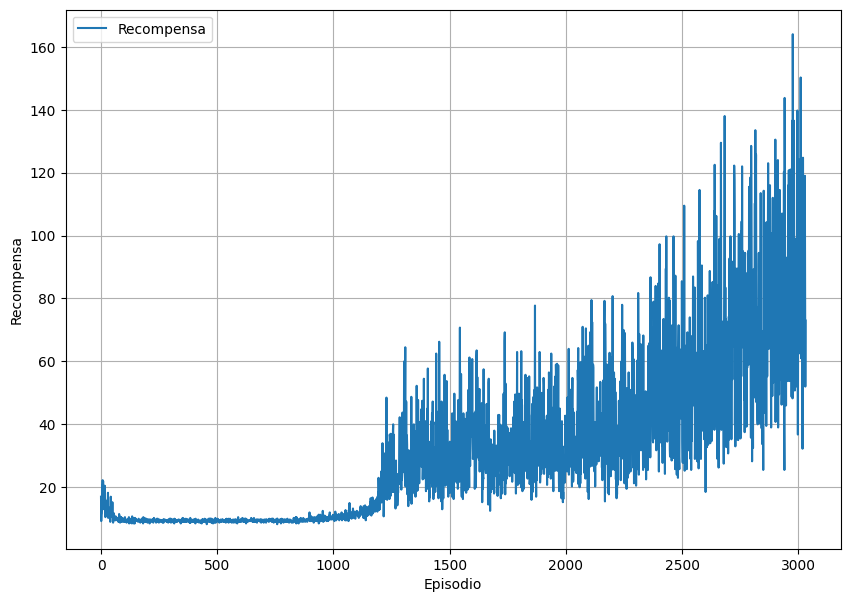

In [ ]:
retornosarsa = retorno_deeplearning(5,"deep_sarsa",4,50000,100000,1)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_76 (Flatten)        (None, 4)                 0         
                                                                 
 dense_152 (Dense)           (None, 16)                80        
                                                                 
 activation_152 (Activation)  (None, 16)               0         
                                                                 
 dense_153 (Dense)           (None, 2)                 34        
                                                                 
 activation_153 (Activation)  (None, 2)                0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
Training for 100000 

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 40
    40/100000: episode: 1, duration: 9.449s, episode steps:  40, steps per second:   4, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 0.516475, mse: 0.531464, mean_q: 0.266196
Episode 2: Steps: 107
   107/100000: episode: 2, duration: 0.511s, episode steps:  67, steps per second: 131, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 0.513496, mse: 0.547255, mean_q: 0.281751
Episode 3: Steps: 138
   138/100000: episode: 3, duration: 0.238s, episode steps:  31, steps per second: 130, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 0.504738, mse: 0.586235, mean_q: 0.462543
Episode 4: Steps: 162
   162/100000: episode: 4, duration: 0.188s, episode steps:  24, steps per second: 127, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.580451, mse: 0.63

Episode 33: Steps: 753
   753/100000: episode: 33, duration: 0.214s, episode steps:  28, steps per second: 131, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.939634, mse: 9.236881, mean_q: 4.363267
Episode 34: Steps: 768
   768/100000: episode: 34, duration: 0.106s, episode steps:  15, steps per second: 142, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 2.476884, mse: 13.536745, mean_q: 4.904508
Episode 35: Steps: 794
   794/100000: episode: 35, duration: 0.174s, episode steps:  26, steps per second: 150, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.423 [0.000, 1.000],  loss: 1.159927, mse: 12.796415, mean_q: 4.973506
Episode 36: Steps: 815
   815/100000: episode: 36, duration: 0.142s, episode steps:  21, steps per second: 148, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 1.288396

Episode 65: Steps: 1215
  1215/100000: episode: 65, duration: 0.077s, episode steps:  11, steps per second: 143, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 3.215505, mse: 28.631314, mean_q: 7.963645
Episode 66: Steps: 1224
  1224/100000: episode: 66, duration: 0.064s, episode steps:   9, steps per second: 140, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 4.809137, mse: 31.332120, mean_q: 8.282089
Episode 67: Steps: 1239
  1239/100000: episode: 67, duration: 0.100s, episode steps:  15, steps per second: 150, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 3.371751, mse: 26.976522, mean_q: 7.783613
Episode 68: Steps: 1249
  1249/100000: episode: 68, duration: 0.070s, episode steps:  10, steps per second: 144, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 3.9

Episode 98: Steps: 1772
  1772/100000: episode: 98, duration: 0.115s, episode steps:  16, steps per second: 139, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 2.756041, mse: 42.141263, mean_q: 9.159221
Episode 99: Steps: 1786
  1786/100000: episode: 99, duration: 0.108s, episode steps:  14, steps per second: 130, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 3.970306, mse: 45.367402, mean_q: 9.442169
Episode 100: Steps: 1803
  1803/100000: episode: 100, duration: 0.117s, episode steps:  17, steps per second: 146, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 2.877849, mse: 41.757884, mean_q: 9.293821
Episode 101: Steps: 1821
  1821/100000: episode: 101, duration: 0.119s, episode steps:  18, steps per second: 151, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss:

Episode 131: Steps: 2280
  2280/100000: episode: 131, duration: 0.117s, episode steps:  15, steps per second: 129, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 3.772824, mse: 53.646620, mean_q: 10.439525
Episode 132: Steps: 2293
  2293/100000: episode: 132, duration: 0.102s, episode steps:  13, steps per second: 128, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 4.235055, mse: 54.757353, mean_q: 10.545597
Episode 133: Steps: 2305
  2305/100000: episode: 133, duration: 0.107s, episode steps:  12, steps per second: 112, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 4.218567, mse: 52.824266, mean_q: 10.380643
Episode 134: Steps: 2322
  2322/100000: episode: 134, duration: 0.168s, episode steps:  17, steps per second: 101, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],

Episode 163: Steps: 3238
  3238/100000: episode: 163, duration: 0.169s, episode steps:  25, steps per second: 148, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 5.452302, mse: 119.134774, mean_q: 15.456432
Episode 164: Steps: 3253
  3253/100000: episode: 164, duration: 0.103s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 8.087326, mse: 121.474553, mean_q: 15.426980
Episode 165: Steps: 3266
  3266/100000: episode: 165, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 9.137161, mse: 123.536325, mean_q: 15.526683
Episode 166: Steps: 3281
  3281/100000: episode: 166, duration: 0.102s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.00

Episode 195: Steps: 3986
  3986/100000: episode: 195, duration: 0.175s, episode steps:  26, steps per second: 149, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.778760, mse: 141.040284, mean_q: 16.630011
Episode 196: Steps: 4005
  4005/100000: episode: 196, duration: 0.127s, episode steps:  19, steps per second: 149, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 8.403979, mse: 149.110460, mean_q: 17.007526
Episode 197: Steps: 4019
  4019/100000: episode: 197, duration: 0.095s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 11.973584, mse: 157.667889, mean_q: 17.398928
Episode 198: Steps: 4029
  4029/100000: episode: 198, duration: 0.069s, episode steps:  10, steps per second: 145, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.0

Episode 228: Steps: 4574
  4574/100000: episode: 228, duration: 0.100s, episode steps:  12, steps per second: 120, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 12.814340, mse: 155.206578, mean_q: 17.202455
Episode 229: Steps: 4591
  4591/100000: episode: 229, duration: 0.135s, episode steps:  17, steps per second: 126, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.647 [0.000, 1.000],  loss: 8.993654, mse: 147.026888, mean_q: 16.988202
Episode 230: Steps: 4614
  4614/100000: episode: 230, duration: 0.181s, episode steps:  23, steps per second: 127, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.652 [0.000, 1.000],  loss: 7.104434, mse: 143.872142, mean_q: 17.000081
Episode 231: Steps: 4636
  4636/100000: episode: 231, duration: 0.170s, episode steps:  22, steps per second: 129, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.682 [0.000, 1.0

Episode 261: Steps: 5257
  5257/100000: episode: 261, duration: 0.520s, episode steps:  78, steps per second: 150, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.079266, mse: 141.326729, mean_q: 16.847374
Episode 262: Steps: 5275
  5275/100000: episode: 262, duration: 0.131s, episode steps:  18, steps per second: 137, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 10.101193, mse: 164.355641, mean_q: 17.830592
Episode 263: Steps: 5297
  5297/100000: episode: 263, duration: 0.156s, episode steps:  22, steps per second: 141, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 7.024431, mse: 153.618380, mean_q: 17.494820
Episode 264: Steps: 5325
  5325/100000: episode: 264, duration: 0.192s, episode steps:  28, steps per second: 146, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.321 [0.000, 1.0

Episode 292: Steps: 5955
  5955/100000: episode: 292, duration: 0.437s, episode steps:  56, steps per second: 128, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 2.466827, mse: 143.222010, mean_q: 16.973958
Episode 293: Steps: 5991
  5991/100000: episode: 293, duration: 0.242s, episode steps:  36, steps per second: 149, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 4.050316, mse: 147.698649, mean_q: 17.175767
Episode 294: Steps: 6026
  6026/100000: episode: 294, duration: 0.235s, episode steps:  35, steps per second: 149, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 3.904450, mse: 145.644778, mean_q: 16.989433
Episode 295: Steps: 6065
  6065/100000: episode: 295, duration: 0.265s, episode steps:  39, steps per second: 147, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.436 [0.000, 1.00

Episode 325: Steps: 6970
  6970/100000: episode: 325, duration: 0.391s, episode steps:  54, steps per second: 138, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 3.228935, mse: 177.038277, mean_q: 18.790434
Episode 326: Steps: 6992
  6992/100000: episode: 326, duration: 0.150s, episode steps:  22, steps per second: 147, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 8.593794, mse: 191.910591, mean_q: 19.344703
Episode 327: Steps: 7005
  7005/100000: episode: 327, duration: 0.088s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 13.912669, mse: 197.705802, mean_q: 19.286395
Episode 328: Steps: 7023
  7023/100000: episode: 328, duration: 0.121s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.0

Episode 356: Steps: 7744
  7744/100000: episode: 356, duration: 0.528s, episode steps:  78, steps per second: 148, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 2.789508, mse: 193.087360, mean_q: 19.750122
Episode 357: Steps: 7755
  7755/100000: episode: 357, duration: 0.077s, episode steps:  11, steps per second: 144, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 22.046555, mse: 233.281551, mean_q: 20.774757
Episode 358: Steps: 7780
  7780/100000: episode: 358, duration: 0.168s, episode steps:  25, steps per second: 149, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 6.771566, mse: 176.848339, mean_q: 18.812060
Episode 359: Steps: 7830
  7830/100000: episode: 359, duration: 0.338s, episode steps:  50, steps per second: 148, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.0

Episode 387: Steps: 8479
  8479/100000: episode: 387, duration: 0.457s, episode steps:  68, steps per second: 149, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 2.700520, mse: 190.455714, mean_q: 19.459511
Episode 388: Steps: 8535
  8535/100000: episode: 388, duration: 0.385s, episode steps:  56, steps per second: 145, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 3.832307, mse: 198.210926, mean_q: 19.879397
Episode 389: Steps: 8559
  8559/100000: episode: 389, duration: 0.184s, episode steps:  24, steps per second: 131, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 8.979390, mse: 204.942689, mean_q: 20.076132
Episode 390: Steps: 8573
  8573/100000: episode: 390, duration: 0.097s, episode steps:  14, steps per second: 144, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.00

Episode 418: Steps: 9228
  9228/100000: episode: 418, duration: 0.167s, episode steps:  21, steps per second: 126, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 10.007098, mse: 203.173504, mean_q: 19.830977
Episode 419: Steps: 9248
  9248/100000: episode: 419, duration: 0.148s, episode steps:  20, steps per second: 135, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.997884, mse: 193.216039, mean_q: 19.573232
Episode 420: Steps: 9286
  9286/100000: episode: 420, duration: 0.253s, episode steps:  38, steps per second: 150, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 5.504757, mse: 192.472102, mean_q: 19.597466
Episode 421: Steps: 9302
  9302/100000: episode: 421, duration: 0.105s, episode steps:  16, steps per second: 152, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.0

Episode 449: Steps: 9901
  9901/100000: episode: 449, duration: 0.208s, episode steps:  31, steps per second: 149, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 5.322170, mse: 181.249398, mean_q: 19.052002
Episode 450: Steps: 9917
  9917/100000: episode: 450, duration: 0.118s, episode steps:  16, steps per second: 136, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 9.380707, mse: 180.512113, mean_q: 18.701925
Episode 451: Steps: 9929
  9929/100000: episode: 451, duration: 0.087s, episode steps:  12, steps per second: 137, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 12.891129, mse: 181.793311, mean_q: 18.516204
Episode 452: Steps: 9973
  9973/100000: episode: 452, duration: 0.319s, episode steps:  44, steps per second: 138, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.0

Episode 480: Steps: 10653
 10653/100000: episode: 480, duration: 0.123s, episode steps:  18, steps per second: 147, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 9.076072, mse: 182.135740, mean_q: 18.770686
Episode 481: Steps: 10681
 10681/100000: episode: 481, duration: 0.190s, episode steps:  28, steps per second: 147, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.641614, mse: 201.903204, mean_q: 19.892253
Episode 482: Steps: 10696
 10696/100000: episode: 482, duration: 0.103s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 13.675640, mse: 212.284227, mean_q: 20.039235
Episode 483: Steps: 10725
 10725/100000: episode: 483, duration: 0.196s, episode steps:  29, steps per second: 148, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000,

Episode 511: Steps: 11462
 11462/100000: episode: 511, duration: 0.309s, episode steps:  45, steps per second: 146, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 4.327865, mse: 189.214410, mean_q: 19.411779
Episode 512: Steps: 11491
 11491/100000: episode: 512, duration: 0.194s, episode steps:  29, steps per second: 150, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.586 [0.000, 1.000],  loss: 6.459063, mse: 199.835627, mean_q: 19.820685
Episode 513: Steps: 11525
 11525/100000: episode: 513, duration: 0.243s, episode steps:  34, steps per second: 140, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 5.594730, mse: 200.506954, mean_q: 19.890632
Episode 514: Steps: 11550
 11550/100000: episode: 514, duration: 0.169s, episode steps:  25, steps per second: 148, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 

Episode 542: Steps: 12307
 12307/100000: episode: 542, duration: 0.120s, episode steps:  18, steps per second: 150, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 11.528260, mse: 218.401400, mean_q: 20.672546
Episode 543: Steps: 12322
 12322/100000: episode: 543, duration: 0.103s, episode steps:  15, steps per second: 146, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 13.859133, mse: 215.194035, mean_q: 20.263366
Episode 544: Steps: 12371
 12371/100000: episode: 544, duration: 0.334s, episode steps:  49, steps per second: 147, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 4.103936, mse: 205.010360, mean_q: 20.263977
Episode 545: Steps: 12421
 12421/100000: episode: 545, duration: 0.334s, episode steps:  50, steps per second: 150, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000

Episode 574: Steps: 13296
 13296/100000: episode: 574, duration: 0.326s, episode steps:  46, steps per second: 141, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 4.598215, mse: 224.336454, mean_q: 21.315831
Episode 575: Steps: 13321
 13321/100000: episode: 575, duration: 0.169s, episode steps:  25, steps per second: 148, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 8.135910, mse: 223.856459, mean_q: 21.062238
Episode 576: Steps: 13343
 13343/100000: episode: 576, duration: 0.150s, episode steps:  22, steps per second: 146, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.956107, mse: 217.520408, mean_q: 20.611418
Episode 577: Steps: 13359
 13359/100000: episode: 577, duration: 0.109s, episode steps:  16, steps per second: 147, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 

Episode 606: Steps: 14091
 14091/100000: episode: 606, duration: 0.210s, episode steps:  31, steps per second: 148, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 7.050561, mse: 227.662397, mean_q: 21.199177
Episode 607: Steps: 14151
 14151/100000: episode: 607, duration: 0.403s, episode steps:  60, steps per second: 149, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 5.177960, mse: 224.808175, mean_q: 21.311563
Episode 608: Steps: 14172
 14172/100000: episode: 608, duration: 0.170s, episode steps:  21, steps per second: 123, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 10.723486, mse: 226.689880, mean_q: 21.106008
Episode 609: Steps: 14183
 14183/100000: episode: 609, duration: 0.078s, episode steps:  11, steps per second: 142, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000,

Episode 638: Steps: 15080
 15080/100000: episode: 638, duration: 0.472s, episode steps:  69, steps per second: 146, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 2.984250, mse: 215.907891, mean_q: 20.920823
Episode 639: Steps: 15104
 15104/100000: episode: 639, duration: 0.183s, episode steps:  24, steps per second: 131, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 8.754249, mse: 229.678591, mean_q: 21.208623
Episode 640: Steps: 15117
 15117/100000: episode: 640, duration: 0.090s, episode steps:  13, steps per second: 144, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 16.111716, mse: 238.644215, mean_q: 21.362604
Episode 641: Steps: 15129
 15129/100000: episode: 641, duration: 0.080s, episode steps:  12, steps per second: 149, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000,

Episode 669: Steps: 15953
 15953/100000: episode: 669, duration: 0.589s, episode steps:  81, steps per second: 138, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 3.130873, mse: 236.972457, mean_q: 21.783998
Episode 670: Steps: 15995
 15995/100000: episode: 670, duration: 0.280s, episode steps:  42, steps per second: 150, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.343027, mse: 253.802506, mean_q: 22.430182
Episode 671: Steps: 16040
 16040/100000: episode: 671, duration: 0.300s, episode steps:  45, steps per second: 150, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 5.424033, mse: 237.927267, mean_q: 21.861266
Episode 672: Steps: 16091
 16091/100000: episode: 672, duration: 0.345s, episode steps:  51, steps per second: 148, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 

Episode 701: Steps: 16934
 16934/100000: episode: 701, duration: 0.183s, episode steps:  27, steps per second: 148, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 8.584230, mse: 247.734245, mean_q: 22.109558
Episode 702: Steps: 16953
 16953/100000: episode: 702, duration: 0.127s, episode steps:  19, steps per second: 150, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 12.859143, mse: 252.502068, mean_q: 22.295321
Episode 703: Steps: 17017
 17017/100000: episode: 703, duration: 0.429s, episode steps:  64, steps per second: 149, episode reward: 64.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.900008, mse: 251.285873, mean_q: 22.405734
Episode 704: Steps: 17036
 17036/100000: episode: 704, duration: 0.129s, episode steps:  19, steps per second: 147, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000,

Episode 732: Steps: 17762
 17762/100000: episode: 732, duration: 0.128s, episode steps:  18, steps per second: 141, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 9.977614, mse: 227.547892, mean_q: 21.100618
Episode 733: Steps: 17788
 17788/100000: episode: 733, duration: 0.172s, episode steps:  26, steps per second: 151, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.912361, mse: 260.514174, mean_q: 22.603420
Episode 734: Steps: 17803
 17803/100000: episode: 734, duration: 0.100s, episode steps:  15, steps per second: 151, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 11.776149, mse: 228.753508, mean_q: 21.060865
Episode 735: Steps: 17875
 17875/100000: episode: 735, duration: 0.476s, episode steps:  72, steps per second: 151, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000

Episode 763: Steps: 18489
 18489/100000: episode: 763, duration: 0.171s, episode steps:  23, steps per second: 134, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 8.874530, mse: 221.496775, mean_q: 21.027510
Episode 764: Steps: 18515
 18515/100000: episode: 764, duration: 0.189s, episode steps:  26, steps per second: 137, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  loss: 8.247025, mse: 224.509877, mean_q: 21.095168
Episode 765: Steps: 18567
 18567/100000: episode: 765, duration: 0.378s, episode steps:  52, steps per second: 137, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.500348, mse: 229.615573, mean_q: 21.487194
Episode 766: Steps: 18596
 18596/100000: episode: 766, duration: 0.233s, episode steps:  29, steps per second: 125, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 

Episode 794: Steps: 19228
 19228/100000: episode: 794, duration: 0.206s, episode steps:  27, steps per second: 131, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 6.329425, mse: 214.552780, mean_q: 20.618504
Episode 795: Steps: 19277
 19277/100000: episode: 795, duration: 0.329s, episode steps:  49, steps per second: 149, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 4.733712, mse: 230.564725, mean_q: 21.525930
Episode 796: Steps: 19291
 19291/100000: episode: 796, duration: 0.094s, episode steps:  14, steps per second: 150, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 15.554600, mse: 240.785845, mean_q: 21.500919
Episode 797: Steps: 19313
 19313/100000: episode: 797, duration: 0.152s, episode steps:  22, steps per second: 145, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000,

Episode 825: Steps: 20262
 20262/100000: episode: 825, duration: 0.360s, episode steps:  46, steps per second: 128, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 6.153978, mse: 253.491913, mean_q: 22.346538
Episode 826: Steps: 20278
 20278/100000: episode: 826, duration: 0.124s, episode steps:  16, steps per second: 129, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 18.985763, mse: 282.476165, mean_q: 23.174954
Episode 827: Steps: 20330
 20330/100000: episode: 827, duration: 0.397s, episode steps:  52, steps per second: 131, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 5.670798, mse: 253.708429, mean_q: 22.449704
Episode 828: Steps: 20350
 20350/100000: episode: 828, duration: 0.197s, episode steps:  20, steps per second: 101, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000,

Episode 858: Steps: 20915
 20915/100000: episode: 858, duration: 0.156s, episode steps:  20, steps per second: 128, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 9.591461, mse: 199.763047, mean_q: 19.631511
Episode 859: Steps: 20938
 20938/100000: episode: 859, duration: 0.172s, episode steps:  23, steps per second: 134, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 6.723956, mse: 199.639567, mean_q: 19.810803
Episode 860: Steps: 20954
 20954/100000: episode: 860, duration: 0.110s, episode steps:  16, steps per second: 146, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 7.836555, mse: 186.017497, mean_q: 19.093476
Episode 861: Steps: 20969
 20969/100000: episode: 861, duration: 0.098s, episode steps:  15, steps per second: 152, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 

Episode 890: Steps: 21579
 21579/100000: episode: 890, duration: 0.182s, episode steps:  26, steps per second: 143, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.346 [0.000, 1.000],  loss: 5.997224, mse: 198.580643, mean_q: 19.889408
Episode 891: Steps: 21612
 21612/100000: episode: 891, duration: 0.221s, episode steps:  33, steps per second: 149, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 4.852473, mse: 192.560902, mean_q: 19.499000
Episode 892: Steps: 21629
 21629/100000: episode: 892, duration: 0.114s, episode steps:  17, steps per second: 149, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 9.978103, mse: 193.977516, mean_q: 19.288642
Episode 893: Steps: 21704
 21704/100000: episode: 893, duration: 0.497s, episode steps:  75, steps per second: 151, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 

Episode 921: Steps: 22597
 22597/100000: episode: 921, duration: 0.275s, episode steps:  37, steps per second: 134, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 5.530902, mse: 220.603928, mean_q: 21.016533
Episode 922: Steps: 22635
 22635/100000: episode: 922, duration: 0.329s, episode steps:  38, steps per second: 115, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 5.636067, mse: 229.471737, mean_q: 21.366673
Episode 923: Steps: 22657
 22657/100000: episode: 923, duration: 0.177s, episode steps:  22, steps per second: 125, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.938042, mse: 217.190101, mean_q: 20.658786
Episode 924: Steps: 22697
 22697/100000: episode: 924, duration: 0.316s, episode steps:  40, steps per second: 127, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 

Episode 953: Steps: 23448
 23448/100000: episode: 953, duration: 0.075s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 12.684985, mse: 195.453069, mean_q: 19.383575
Episode 954: Steps: 23457
 23457/100000: episode: 954, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 14.808208, mse: 191.845486, mean_q: 19.058323
Episode 955: Steps: 23515
 23515/100000: episode: 955, duration: 0.408s, episode steps:  58, steps per second: 142, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 3.782029, mse: 230.838015, mean_q: 21.619436
Episode 956: Steps: 23527
 23527/100000: episode: 956, duration: 0.082s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000

Episode 986: Steps: 24147
 24147/100000: episode: 986, duration: 0.077s, episode steps:  11, steps per second: 142, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 18.793635, mse: 222.108998, mean_q: 20.373100
Episode 987: Steps: 24164
 24164/100000: episode: 987, duration: 0.114s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 8.932652, mse: 191.742698, mean_q: 19.212290
Episode 988: Steps: 24198
 24198/100000: episode: 988, duration: 0.227s, episode steps:  34, steps per second: 150, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441 [0.000, 1.000],  loss: 4.193852, mse: 197.145464, mean_q: 19.686242
Episode 989: Steps: 24209
 24209/100000: episode: 989, duration: 0.074s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000,

Episode 1017: Steps: 25036
 25036/100000: episode: 1017, duration: 0.542s, episode steps:  81, steps per second: 149, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 2.547476, mse: 206.936938, mean_q: 20.316041
Episode 1018: Steps: 25056
 25056/100000: episode: 1018, duration: 0.152s, episode steps:  20, steps per second: 131, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.347203, mse: 225.294059, mean_q: 20.957673
Episode 1019: Steps: 25067
 25067/100000: episode: 1019, duration: 0.078s, episode steps:  11, steps per second: 141, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 15.719669, mse: 204.901671, mean_q: 19.638233
Episode 1020: Steps: 25076
 25076/100000: episode: 1020, duration: 0.059s, episode steps:   9, steps per second: 151, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.22

Episode 1049: Steps: 25945
 25945/100000: episode: 1049, duration: 0.102s, episode steps:  15, steps per second: 147, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 13.346110, mse: 236.669879, mean_q: 21.383180
Episode 1050: Steps: 26012
 26012/100000: episode: 1050, duration: 0.450s, episode steps:  67, steps per second: 149, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 3.432870, mse: 227.535293, mean_q: 21.322879
Episode 1051: Steps: 26061
 26061/100000: episode: 1051, duration: 0.349s, episode steps:  49, steps per second: 140, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 3.699915, mse: 233.537112, mean_q: 21.573522
Episode 1052: Steps: 26089
 26089/100000: episode: 1052, duration: 0.208s, episode steps:  28, steps per second: 135, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500

Episode 1080: Steps: 26932
 26932/100000: episode: 1080, duration: 0.106s, episode steps:  13, steps per second: 123, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 17.882141, mse: 256.570365, mean_q: 22.115674
Episode 1081: Steps: 26955
 26955/100000: episode: 1081, duration: 0.176s, episode steps:  23, steps per second: 130, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 9.318787, mse: 245.408123, mean_q: 21.857313
Episode 1082: Steps: 26983
 26983/100000: episode: 1082, duration: 0.243s, episode steps:  28, steps per second: 115, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.393 [0.000, 1.000],  loss: 6.639870, mse: 242.470944, mean_q: 21.893040
Episode 1083: Steps: 27011
 27011/100000: episode: 1083, duration: 0.240s, episode steps:  28, steps per second: 117, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536

Episode 1111: Steps: 28088
 28088/100000: episode: 1111, duration: 0.416s, episode steps:  57, steps per second: 137, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 4.683173, mse: 261.809305, mean_q: 22.903681
Episode 1112: Steps: 28105
 28105/100000: episode: 1112, duration: 0.113s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 16.521411, mse: 280.597650, mean_q: 23.230169
Episode 1113: Steps: 28124
 28124/100000: episode: 1113, duration: 0.129s, episode steps:  19, steps per second: 147, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 13.516716, mse: 270.358220, mean_q: 22.937405
Episode 1114: Steps: 28176
 28176/100000: episode: 1114, duration: 0.349s, episode steps:  52, steps per second: 149, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.48

Episode 1142: Steps: 29058
 29058/100000: episode: 1142, duration: 0.220s, episode steps:  33, steps per second: 150, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 6.886009, mse: 271.305111, mean_q: 23.261235
Episode 1143: Steps: 29129
 29129/100000: episode: 1143, duration: 0.542s, episode steps:  71, steps per second: 131, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 3.810978, mse: 276.829203, mean_q: 23.559837
Episode 1144: Steps: 29189
 29189/100000: episode: 1144, duration: 0.454s, episode steps:  60, steps per second: 132, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 4.145683, mse: 279.975198, mean_q: 23.731246
Episode 1145: Steps: 29259
 29259/100000: episode: 1145, duration: 0.533s, episode steps:  70, steps per second: 131, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 

Episode 1173: Steps: 30194
 30194/100000: episode: 1173, duration: 0.490s, episode steps:  72, steps per second: 147, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 4.371368, mse: 295.577017, mean_q: 24.434000
Episode 1174: Steps: 30207
 30207/100000: episode: 1174, duration: 0.090s, episode steps:  13, steps per second: 145, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 23.721943, mse: 316.036527, mean_q: 24.535243
Episode 1175: Steps: 30266
 30266/100000: episode: 1175, duration: 0.401s, episode steps:  59, steps per second: 147, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 5.253373, mse: 312.386795, mean_q: 24.994554
Episode 1176: Steps: 30283
 30283/100000: episode: 1176, duration: 0.115s, episode steps:  17, steps per second: 147, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588

Episode 1205: Steps: 31369
 31369/100000: episode: 1205, duration: 0.332s, episode steps:  38, steps per second: 114, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 8.289813, mse: 323.950943, mean_q: 25.433606
Episode 1206: Steps: 31381
 31381/100000: episode: 1206, duration: 0.140s, episode steps:  12, steps per second:  86, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 24.992019, mse: 336.647150, mean_q: 25.270096
Episode 1207: Steps: 31396
 31396/100000: episode: 1207, duration: 0.156s, episode steps:  15, steps per second:  96, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 18.908270, mse: 329.438468, mean_q: 25.280302
Episode 1208: Steps: 31407
 31407/100000: episode: 1208, duration: 0.085s, episode steps:  11, steps per second: 129, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.45

Episode 1236: Steps: 32393
 32393/100000: episode: 1236, duration: 0.279s, episode steps:  41, steps per second: 147, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 5.993666, mse: 305.085578, mean_q: 24.803156
Episode 1237: Steps: 32417
 32417/100000: episode: 1237, duration: 0.165s, episode steps:  24, steps per second: 146, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.333984, mse: 292.097338, mean_q: 24.162210
Episode 1238: Steps: 32447
 32447/100000: episode: 1238, duration: 0.203s, episode steps:  30, steps per second: 148, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 8.801259, mse: 292.167172, mean_q: 24.053439
Episode 1239: Steps: 32463
 32463/100000: episode: 1239, duration: 0.108s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438

Episode 1268: Steps: 33596
 33596/100000: episode: 1268, duration: 0.137s, episode steps:  18, steps per second: 131, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 15.267925, mse: 329.035482, mean_q: 25.437057
Episode 1269: Steps: 33621
 33621/100000: episode: 1269, duration: 0.201s, episode steps:  25, steps per second: 125, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 9.368487, mse: 329.332776, mean_q: 25.704370
Episode 1270: Steps: 33652
 33652/100000: episode: 1270, duration: 0.243s, episode steps:  31, steps per second: 128, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 8.619423, mse: 309.243493, mean_q: 24.785264
Episode 1271: Steps: 33685
 33685/100000: episode: 1271, duration: 0.256s, episode steps:  33, steps per second: 129, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515

Episode 1299: Steps: 34832
 34832/100000: episode: 1299, duration: 0.209s, episode steps:  31, steps per second: 148, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 12.519370, mse: 372.680714, mean_q: 27.089284
Episode 1300: Steps: 34856
 34856/100000: episode: 1300, duration: 0.161s, episode steps:  24, steps per second: 149, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 15.307154, mse: 369.144387, mean_q: 26.801853
Episode 1301: Steps: 34866
 34866/100000: episode: 1301, duration: 0.071s, episode steps:  10, steps per second: 141, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 35.141114, mse: 373.069031, mean_q: 26.221280
Episode 1302: Steps: 34882
 34882/100000: episode: 1302, duration: 0.108s, episode steps:  16, steps per second: 148, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1331: Steps: 35983
 35983/100000: episode: 1331, duration: 0.224s, episode steps:  28, steps per second: 125, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 10.258466, mse: 331.805777, mean_q: 25.681306
Episode 1332: Steps: 36029
 36029/100000: episode: 1332, duration: 0.380s, episode steps:  46, steps per second: 121, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 6.008222, mse: 342.068747, mean_q: 26.364655
Episode 1333: Steps: 36080
 36080/100000: episode: 1333, duration: 0.361s, episode steps:  51, steps per second: 141, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 4.674125, mse: 343.865075, mean_q: 26.388295
Episode 1334: Steps: 36093
 36093/100000: episode: 1334, duration: 0.090s, episode steps:  13, steps per second: 144, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462

Episode 1362: Steps: 37881
 37881/100000: episode: 1362, duration: 0.522s, episode steps:  77, steps per second: 147, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 6.137975, mse: 470.917913, mean_q: 30.914502
Episode 1363: Steps: 37896
 37896/100000: episode: 1363, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 34.262496, mse: 505.602624, mean_q: 31.187137
Episode 1364: Steps: 37919
 37919/100000: episode: 1364, duration: 0.154s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 21.486791, mse: 487.111575, mean_q: 30.839051
Episode 1365: Steps: 37987
 37987/100000: episode: 1365, duration: 0.458s, episode steps:  68, steps per second: 148, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 1394: Steps: 39724
 39724/100000: episode: 1394, duration: 0.115s, episode steps:  17, steps per second: 148, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 25.882147, mse: 527.133150, mean_q: 32.171566
Episode 1395: Steps: 39742
 39742/100000: episode: 1395, duration: 0.122s, episode steps:  18, steps per second: 147, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 22.936434, mse: 513.780789, mean_q: 31.945969
Episode 1396: Steps: 39765
 39765/100000: episode: 1396, duration: 0.156s, episode steps:  23, steps per second: 147, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 16.739680, mse: 508.856479, mean_q: 32.005475
Episode 1397: Steps: 39788
 39788/100000: episode: 1397, duration: 0.155s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1425: Steps: 40778
 40778/100000: episode: 1425, duration: 0.348s, episode steps:  50, steps per second: 144, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.935582, mse: 481.033701, mean_q: 31.161046
Episode 1426: Steps: 40915
 40915/100000: episode: 1426, duration: 0.918s, episode steps: 137, steps per second: 149, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 3.998437, mse: 543.689070, mean_q: 33.149032
Episode 1427: Steps: 40965
 40965/100000: episode: 1427, duration: 0.334s, episode steps:  50, steps per second: 150, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.155206, mse: 488.208013, mean_q: 31.435113
Episode 1428: Steps: 40977
 40977/100000: episode: 1428, duration: 0.081s, episode steps:  12, steps per second: 147, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417

Episode 1456: Steps: 42353
 42353/100000: episode: 1456, duration: 0.287s, episode steps:  38, steps per second: 132, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 15.830108, mse: 563.811211, mean_q: 33.282878
Episode 1457: Steps: 42380
 42380/100000: episode: 1457, duration: 0.183s, episode steps:  27, steps per second: 148, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 21.016060, mse: 531.363342, mean_q: 32.301939
Episode 1458: Steps: 42412
 42412/100000: episode: 1458, duration: 0.219s, episode steps:  32, steps per second: 146, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.998554, mse: 548.733234, mean_q: 32.844310
Episode 1459: Steps: 42440
 42440/100000: episode: 1459, duration: 0.188s, episode steps:  28, steps per second: 149, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1489: Steps: 44232
 44232/100000: episode: 1489, duration: 0.135s, episode steps:  18, steps per second: 133, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 30.391680, mse: 562.630220, mean_q: 32.871501
Episode 1490: Steps: 44250
 44250/100000: episode: 1490, duration: 0.136s, episode steps:  18, steps per second: 133, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 22.665771, mse: 545.697013, mean_q: 32.720260
Episode 1491: Steps: 44267
 44267/100000: episode: 1491, duration: 0.124s, episode steps:  17, steps per second: 137, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 29.651174, mse: 531.099438, mean_q: 31.963190
Episode 1492: Steps: 44287
 44287/100000: episode: 1492, duration: 0.143s, episode steps:  20, steps per second: 140, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 1520: Steps: 46174
 46174/100000: episode: 1520, duration: 0.402s, episode steps:  61, steps per second: 152, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 7.375138, mse: 597.395120, mean_q: 34.689319
Episode 1521: Steps: 46201
 46201/100000: episode: 1521, duration: 0.181s, episode steps:  27, steps per second: 149, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 20.778789, mse: 660.645051, mean_q: 36.285795
Episode 1522: Steps: 46217
 46217/100000: episode: 1522, duration: 0.121s, episode steps:  16, steps per second: 132, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 33.238509, mse: 617.555518, mean_q: 34.582912
Episode 1523: Steps: 46261
 46261/100000: episode: 1523, duration: 0.324s, episode steps:  44, steps per second: 136, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.54

Episode 1551: Steps: 48571
 48571/100000: episode: 1551, duration: 0.217s, episode steps:  29, steps per second: 133, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 23.004158, mse: 781.315735, mean_q: 39.394731
Episode 1552: Steps: 48587
 48587/100000: episode: 1552, duration: 0.116s, episode steps:  16, steps per second: 138, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 45.447756, mse: 817.143022, mean_q: 39.876522
Episode 1553: Steps: 48598
 48598/100000: episode: 1553, duration: 0.088s, episode steps:  11, steps per second: 125, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 60.600869, mse: 792.103400, mean_q: 38.608155
Episode 1554: Steps: 48615
 48615/100000: episode: 1554, duration: 0.136s, episode steps:  17, steps per second: 125, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1583: Steps: 49633
 49633/100000: episode: 1583, duration: 1.034s, episode steps: 150, steps per second: 145, episode reward: 150.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.315815, mse: 674.345394, mean_q: 37.038999
Episode 1584: Steps: 49699
 49699/100000: episode: 1584, duration: 0.474s, episode steps:  66, steps per second: 139, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 4.161658, mse: 489.558312, mean_q: 31.402220
Episode 1585: Steps: 49747
 49747/100000: episode: 1585, duration: 0.330s, episode steps:  48, steps per second: 146, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 14.674285, mse: 743.396416, mean_q: 38.763732
Episode 1586: Steps: 49765
 49765/100000: episode: 1586, duration: 0.124s, episode steps:  18, steps per second: 145, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 1615: Steps: 51274
 51274/100000: episode: 1615, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 44.898026, mse: 663.414851, mean_q: 35.521090
Episode 1616: Steps: 51332
 51332/100000: episode: 1616, duration: 0.394s, episode steps:  58, steps per second: 147, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 9.327093, mse: 562.639505, mean_q: 33.694807
Episode 1617: Steps: 51347
 51347/100000: episode: 1617, duration: 0.101s, episode steps:  15, steps per second: 148, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 41.177006, mse: 647.300690, mean_q: 35.114003
Episode 1618: Steps: 51362
 51362/100000: episode: 1618, duration: 0.124s, episode steps:  15, steps per second: 120, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.60

Episode 1646: Steps: 52956
 52956/100000: episode: 1646, duration: 1.503s, episode steps: 174, steps per second: 116, episode reward: 174.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 3.404083, mse: 607.300664, mean_q: 35.201648
Episode 1647: Steps: 52985
 52985/100000: episode: 1647, duration: 0.367s, episode steps:  29, steps per second:  79, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 25.994693, mse: 708.549741, mean_q: 37.282068
Episode 1648: Steps: 53008
 53008/100000: episode: 1648, duration: 0.248s, episode steps:  23, steps per second:  93, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 25.917944, mse: 662.408386, mean_q: 36.024219
Episode 1649: Steps: 53038
 53038/100000: episode: 1649, duration: 0.275s, episode steps:  30, steps per second: 109, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1677: Steps: 54423
 54423/100000: episode: 1677, duration: 1.654s, episode steps: 243, steps per second: 147, episode reward: 243.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 2.847692, mse: 527.702217, mean_q: 32.765600
Episode 1678: Steps: 54441
 54441/100000: episode: 1678, duration: 0.119s, episode steps:  18, steps per second: 152, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 29.370408, mse: 628.739549, mean_q: 34.903212
Episode 1679: Steps: 54698
 54698/100000: episode: 1679, duration: 1.721s, episode steps: 257, steps per second: 149, episode reward: 257.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 1.153711, mse: 523.768261, mean_q: 32.526086
Episode 1680: Steps: 54763
 54763/100000: episode: 1680, duration: 0.441s, episode steps:  65, steps per second: 147, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1709: Steps: 56497
 56497/100000: episode: 1709, duration: 0.122s, episode steps:  18, steps per second: 148, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 26.069890, mse: 553.549424, mean_q: 32.861325
Episode 1710: Steps: 56509
 56509/100000: episode: 1710, duration: 0.091s, episode steps:  12, steps per second: 131, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 35.333928, mse: 520.722548, mean_q: 31.875522
Episode 1711: Steps: 56521
 56521/100000: episode: 1711, duration: 0.086s, episode steps:  12, steps per second: 140, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 33.229567, mse: 514.953328, mean_q: 31.631957
Episode 1712: Steps: 56536
 56536/100000: episode: 1712, duration: 0.119s, episode steps:  15, steps per second: 126, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1740: Steps: 57127
 57127/100000: episode: 1740, duration: 0.272s, episode steps:  36, steps per second: 132, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 11.697396, mse: 524.753339, mean_q: 32.597255
Episode 1741: Steps: 57143
 57143/100000: episode: 1741, duration: 0.118s, episode steps:  16, steps per second: 136, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 25.873765, mse: 446.187712, mean_q: 29.451631
Episode 1742: Steps: 57166
 57166/100000: episode: 1742, duration: 0.159s, episode steps:  23, steps per second: 145, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 16.907550, mse: 492.677805, mean_q: 31.298570
Episode 1743: Steps: 57207
 57207/100000: episode: 1743, duration: 0.353s, episode steps:  41, steps per second: 116, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1771: Steps: 59848
 59848/100000: episode: 1771, duration: 0.280s, episode steps:  42, steps per second: 150, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 13.950484, mse: 722.187046, mean_q: 38.213824
Episode 1772: Steps: 59982
 59982/100000: episode: 1772, duration: 0.916s, episode steps: 134, steps per second: 146, episode reward: 134.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 9.434392, mse: 975.298589, mean_q: 44.372778
Episode 1773: Steps: 59997
 59997/100000: episode: 1773, duration: 0.102s, episode steps:  15, steps per second: 147, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 44.420122, mse: 745.385454, mean_q: 38.429993
Episode 1774: Steps: 60083
 60083/100000: episode: 1774, duration: 0.572s, episode steps:  86, steps per second: 150, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1803: Steps: 61519
 61519/100000: episode: 1803, duration: 0.606s, episode steps:  82, steps per second: 135, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.561 [0.000, 1.000],  loss: 3.072516, mse: 467.498863, mean_q: 30.737450
Episode 1804: Steps: 61623
 61623/100000: episode: 1804, duration: 0.713s, episode steps: 104, steps per second: 146, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 1.873994, mse: 403.546237, mean_q: 28.515326
Episode 1805: Steps: 61755
 61755/100000: episode: 1805, duration: 0.905s, episode steps: 132, steps per second: 146, episode reward: 132.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 1.509590, mse: 492.576595, mean_q: 31.264787
Episode 1806: Steps: 61870
 61870/100000: episode: 1806, duration: 0.780s, episode steps: 115, steps per second: 147, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1834: Steps: 64796
 64796/100000: episode: 1834, duration: 1.024s, episode steps: 130, steps per second: 127, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 14.120412, mse: 1321.193472, mean_q: 51.197504
Episode 1835: Steps: 64911
 64911/100000: episode: 1835, duration: 0.923s, episode steps: 115, steps per second: 125, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.557 [0.000, 1.000],  loss: 2.821766, mse: 650.175423, mean_q: 36.074712
Episode 1836: Steps: 65028
 65028/100000: episode: 1836, duration: 0.824s, episode steps: 117, steps per second: 142, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.547 [0.000, 1.000],  loss: 3.303701, mse: 669.235778, mean_q: 36.708156
Episode 1837: Steps: 65063
 65063/100000: episode: 1837, duration: 0.236s, episode steps:  35, steps per second: 148, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 1865: Steps: 67937
 67937/100000: episode: 1865, duration: 0.148s, episode steps:  22, steps per second: 149, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 51.374421, mse: 1185.127636, mean_q: 48.045189
Episode 1866: Steps: 67977
 67977/100000: episode: 1866, duration: 0.271s, episode steps:  40, steps per second: 148, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 26.495061, mse: 1107.635432, mean_q: 46.964985
Episode 1867: Steps: 67988
 67988/100000: episode: 1867, duration: 0.073s, episode steps:  11, steps per second: 151, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 97.787254, mse: 1164.303857, mean_q: 46.521858
Episode 1868: Steps: 68185
 68185/100000: episode: 1868, duration: 1.327s, episode steps: 197, steps per second: 148, episode reward: 197.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1896: Steps: 72172
 72172/100000: episode: 1896, duration: 1.042s, episode steps: 155, steps per second: 149, episode reward: 155.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.503 [0.000, 1.000],  loss: 9.758523, mse: 1475.082786, mean_q: 54.624915
Episode 1897: Steps: 72338
 72338/100000: episode: 1897, duration: 1.146s, episode steps: 166, steps per second: 145, episode reward: 166.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 6.489308, mse: 1297.077511, mean_q: 51.329361
Episode 1898: Steps: 72385
 72385/100000: episode: 1898, duration: 0.319s, episode steps:  47, steps per second: 148, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 40.747763, mse: 1752.493421, mean_q: 58.943613
Episode 1899: Steps: 72472
 72472/100000: episode: 1899, duration: 0.586s, episode steps:  87, steps per second: 148, episode reward: 87.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1927: Steps: 74527
 74527/100000: episode: 1927, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 76.137356, mse: 1246.758423, mean_q: 49.109301
Episode 1928: Steps: 74543
 74543/100000: episode: 1928, duration: 0.107s, episode steps:  16, steps per second: 150, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 66.967250, mse: 1206.768323, mean_q: 48.374905
Episode 1929: Steps: 74555
 74555/100000: episode: 1929, duration: 0.080s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 79.641908, mse: 1202.428683, mean_q: 48.361174
Episode 1930: Steps: 74568
 74568/100000: episode: 1930, duration: 0.088s, episode steps:  13, steps per second: 148, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1959: Steps: 75212
 75212/100000: episode: 1959, duration: 0.208s, episode steps:  31, steps per second: 149, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 37.846253, mse: 1107.077028, mean_q: 46.523353
Episode 1960: Steps: 75234
 75234/100000: episode: 1960, duration: 0.146s, episode steps:  22, steps per second: 151, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 43.420311, mse: 1023.896807, mean_q: 44.768250
Episode 1961: Steps: 75250
 75250/100000: episode: 1961, duration: 0.109s, episode steps:  16, steps per second: 147, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 58.697804, mse: 1015.427828, mean_q: 44.121849
Episode 1962: Steps: 75267
 75267/100000: episode: 1962, duration: 0.115s, episode steps:  17, steps per second: 148, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1990: Steps: 76617
 76617/100000: episode: 1990, duration: 0.293s, episode steps:  41, steps per second: 140, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 20.816100, mse: 976.317958, mean_q: 44.449870
Episode 1991: Steps: 76727
 76727/100000: episode: 1991, duration: 0.736s, episode steps: 110, steps per second: 150, episode reward: 110.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 6.220253, mse: 726.865863, mean_q: 38.369761
Episode 1992: Steps: 76877
 76877/100000: episode: 1992, duration: 1.035s, episode steps: 150, steps per second: 145, episode reward: 150.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.332591, mse: 812.635281, mean_q: 40.631468
Episode 1993: Steps: 76903
 76903/100000: episode: 1993, duration: 0.178s, episode steps:  26, steps per second: 146, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 2021: Steps: 80357
 80357/100000: episode: 2021, duration: 1.996s, episode steps: 284, steps per second: 142, episode reward: 284.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 7.575053, mse: 1595.028981, mean_q: 56.593385
Episode 2022: Steps: 80512
 80512/100000: episode: 2022, duration: 1.283s, episode steps: 155, steps per second: 121, episode reward: 155.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 11.174935, mse: 1585.008837, mean_q: 56.551559
Episode 2023: Steps: 80573
 80573/100000: episode: 2023, duration: 1.066s, episode steps:  61, steps per second:  57, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 20.002964, mse: 1287.110950, mean_q: 50.909236
Episode 2024: Steps: 80754
 80754/100000: episode: 2024, duration: 1.233s, episode steps: 181, steps per second: 147, episode reward: 181.000, mean reward:  1.000 [ 1.000,  1.000], mean action

Episode 2053: Steps: 84415
 84415/100000: episode: 2053, duration: 0.166s, episode steps:  25, steps per second: 151, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 74.389463, mse: 1827.761134, mean_q: 59.616219
Episode 2054: Steps: 84438
 84438/100000: episode: 2054, duration: 0.158s, episode steps:  23, steps per second: 145, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 75.260446, mse: 1805.879383, mean_q: 59.358772
Episode 2055: Steps: 84462
 84462/100000: episode: 2055, duration: 0.162s, episode steps:  24, steps per second: 149, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 65.886905, mse: 1625.856891, mean_q: 56.290665
Episode 2056: Steps: 84493
 84493/100000: episode: 2056, duration: 0.210s, episode steps:  31, steps per second: 147, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 2084: Steps: 89542
 89542/100000: episode: 2084, duration: 1.892s, episode steps: 236, steps per second: 125, episode reward: 236.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 2.492183, mse: 1506.328001, mean_q: 54.975252
Episode 2085: Steps: 89921
 89921/100000: episode: 2085, duration: 2.561s, episode steps: 379, steps per second: 148, episode reward: 379.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 1.991797, mse: 2071.051848, mean_q: 64.262677
Episode 2086: Steps: 90142
 90142/100000: episode: 2086, duration: 1.499s, episode steps: 221, steps per second: 147, episode reward: 221.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 2.482175, mse: 2118.313123, mean_q: 64.235508
Episode 2087: Steps: 90180
 90180/100000: episode: 2087, duration: 0.257s, episode steps:  38, steps per second: 148, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 2115: Steps: 94481
 94481/100000: episode: 2115, duration: 0.799s, episode steps: 115, steps per second: 144, episode reward: 115.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.530 [0.000, 1.000],  loss: 3.817694, mse: 1191.433666, mean_q: 47.441638
Episode 2116: Steps: 94664
 94664/100000: episode: 2116, duration: 1.297s, episode steps: 183, steps per second: 141, episode reward: 183.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 2.917315, mse: 1247.825129, mean_q: 49.114876
Episode 2117: Steps: 95036
 95036/100000: episode: 2117, duration: 2.594s, episode steps: 372, steps per second: 143, episode reward: 372.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 1.751968, mse: 1935.743432, mean_q: 61.519431
Episode 2118: Steps: 95161
 95161/100000: episode: 2118, duration: 0.834s, episode steps: 125, steps per second: 150, episode reward: 125.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 2147: Steps: 98009
 98009/100000: episode: 2147, duration: 0.095s, episode steps:  14, steps per second: 148, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 159.892718, mse: 2173.168373, mean_q: 63.903049
Episode 2148: Steps: 98021
 98021/100000: episode: 2148, duration: 0.086s, episode steps:  12, steps per second: 140, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 160.651288, mse: 2023.864802, mean_q: 61.622319
Episode 2149: Steps: 98035
 98035/100000: episode: 2149, duration: 0.095s, episode steps:  14, steps per second: 148, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 159.333741, mse: 2185.177255, mean_q: 64.215830
Episode 2150: Steps: 98064
 98064/100000: episode: 2150, duration: 0.212s, episode steps:  29, steps per second: 137, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean actio

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 42
    42/100000: episode: 1, duration: 9.765s, episode steps:  42, steps per second:   4, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.514797, mse: 0.529113, mean_q: 0.242018
Episode 2: Steps: 83
    83/100000: episode: 2, duration: 0.269s, episode steps:  41, steps per second: 152, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 0.512501, mse: 0.541565, mean_q: 0.292925
Episode 3: Steps: 109
   109/100000: episode: 3, duration: 0.178s, episode steps:  26, steps per second: 146, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 0.501110, mse: 0.562411, mean_q: 0.367614
Episode 4: Steps: 168
   168/100000: episode: 4, duration: 0.399s, episode steps:  59, steps per second: 148, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 0.553341, mse: 0.607

Episode 34: Steps: 817
   817/100000: episode: 34, duration: 0.069s, episode steps:  10, steps per second: 146, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 4.504723, mse: 20.378991, mean_q: 6.872167
Episode 35: Steps: 829
   829/100000: episode: 35, duration: 0.082s, episode steps:  12, steps per second: 146, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 2.732047, mse: 22.078315, mean_q: 7.069370
Episode 36: Steps: 840
   840/100000: episode: 36, duration: 0.074s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 4.955164, mse: 23.630999, mean_q: 7.338120
Episode 37: Steps: 850
   850/100000: episode: 37, duration: 0.066s, episode steps:  10, steps per second: 151, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 5.90113

Episode 67: Steps: 1186
  1186/100000: episode: 67, duration: 0.075s, episode steps:  11, steps per second: 147, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 4.229567, mse: 30.249621, mean_q: 8.031256
Episode 68: Steps: 1198
  1198/100000: episode: 68, duration: 0.080s, episode steps:  12, steps per second: 150, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: 3.556954, mse: 29.862535, mean_q: 8.022506
Episode 69: Steps: 1217
  1217/100000: episode: 69, duration: 0.131s, episode steps:  19, steps per second: 145, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 2.229451, mse: 23.504107, mean_q: 7.324937
Episode 70: Steps: 1231
  1231/100000: episode: 70, duration: 0.096s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 2.6

Episode 100: Steps: 1653
  1653/100000: episode: 100, duration: 0.155s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 1.918914, mse: 32.437309, mean_q: 8.553749
Episode 101: Steps: 1670
  1670/100000: episode: 101, duration: 0.117s, episode steps:  17, steps per second: 146, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 3.160270, mse: 36.894730, mean_q: 8.935301
Episode 102: Steps: 1683
  1683/100000: episode: 102, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 3.181104, mse: 33.859773, mean_q: 8.672347
Episode 103: Steps: 1697
  1697/100000: episode: 103, duration: 0.094s, episode steps:  14, steps per second: 148, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  l

Episode 132: Steps: 2079
  2079/100000: episode: 132, duration: 0.077s, episode steps:  11, steps per second: 143, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 3.875865, mse: 41.558955, mean_q: 9.463346
Episode 133: Steps: 2096
  2096/100000: episode: 133, duration: 0.114s, episode steps:  17, steps per second: 150, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 2.855352, mse: 40.862581, mean_q: 9.513955
Episode 134: Steps: 2110
  2110/100000: episode: 134, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 3.814086, mse: 40.723584, mean_q: 9.533758
Episode 135: Steps: 2126
  2126/100000: episode: 135, duration: 0.108s, episode steps:  16, steps per second: 147, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  l

Episode 164: Steps: 2471
  2471/100000: episode: 164, duration: 0.088s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 2.791590, mse: 37.579606, mean_q: 9.156788
Episode 165: Steps: 2483
  2483/100000: episode: 165, duration: 0.084s, episode steps:  12, steps per second: 143, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 3.111587, mse: 38.834667, mean_q: 9.198375
Episode 166: Steps: 2495
  2495/100000: episode: 166, duration: 0.096s, episode steps:  12, steps per second: 125, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 3.426780, mse: 40.282728, mean_q: 9.461311
Episode 167: Steps: 2513
  2513/100000: episode: 167, duration: 0.129s, episode steps:  18, steps per second: 139, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  l

Episode 197: Steps: 2923
  2923/100000: episode: 197, duration: 0.167s, episode steps:  25, steps per second: 150, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 1.787268, mse: 44.318857, mean_q: 9.809764
Episode 198: Steps: 2938
  2938/100000: episode: 198, duration: 0.102s, episode steps:  15, steps per second: 147, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 2.438559, mse: 43.092094, mean_q: 9.604685
Episode 199: Steps: 2951
  2951/100000: episode: 199, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 2.902147, mse: 42.307861, mean_q: 9.277682
Episode 200: Steps: 2965
  2965/100000: episode: 200, duration: 0.097s, episode steps:  14, steps per second: 144, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  l

Episode 229: Steps: 3730
  3730/100000: episode: 229, duration: 0.263s, episode steps:  35, steps per second: 133, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 2.195969, mse: 87.555006, mean_q: 13.379834
Episode 230: Steps: 3744
  3744/100000: episode: 230, duration: 0.095s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 5.117388, mse: 86.096253, mean_q: 13.154816
Episode 231: Steps: 3788
  3788/100000: episode: 231, duration: 0.294s, episode steps:  44, steps per second: 150, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 1.813388, mse: 90.681272, mean_q: 13.614842
Episode 232: Steps: 3816
  3816/100000: episode: 232, duration: 0.188s, episode steps:  28, steps per second: 149, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],

Episode 261: Steps: 4738
  4738/100000: episode: 261, duration: 0.326s, episode steps:  49, steps per second: 150, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 4.265904, mse: 170.137042, mean_q: 18.489731
Episode 262: Steps: 4765
  4765/100000: episode: 262, duration: 0.180s, episode steps:  27, steps per second: 150, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.593 [0.000, 1.000],  loss: 7.919855, mse: 180.665247, mean_q: 18.824686
Episode 263: Steps: 4847
  4847/100000: episode: 263, duration: 0.541s, episode steps:  82, steps per second: 152, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.847731, mse: 156.627561, mean_q: 17.916179
Episode 264: Steps: 4869
  4869/100000: episode: 264, duration: 0.146s, episode steps:  22, steps per second: 150, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.00

Episode 293: Steps: 5738
  5738/100000: episode: 293, duration: 0.397s, episode steps:  32, steps per second:  81, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 4.804248, mse: 181.509661, mean_q: 19.180963
Episode 294: Steps: 5754
  5754/100000: episode: 294, duration: 0.240s, episode steps:  16, steps per second:  67, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 14.078183, mse: 222.474548, mean_q: 20.543458
Episode 295: Steps: 5775
  5775/100000: episode: 295, duration: 0.252s, episode steps:  21, steps per second:  83, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 10.407121, mse: 220.077528, mean_q: 20.653834
Episode 296: Steps: 5793
  5793/100000: episode: 296, duration: 0.291s, episode steps:  18, steps per second:  62, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.

Episode 324: Steps: 6546
  6546/100000: episode: 324, duration: 0.267s, episode steps:  33, steps per second: 123, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 7.648831, mse: 218.585029, mean_q: 20.787316
Episode 325: Steps: 6565
  6565/100000: episode: 325, duration: 0.208s, episode steps:  19, steps per second:  91, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 14.386965, mse: 237.968822, mean_q: 21.343896
Episode 326: Steps: 6575
  6575/100000: episode: 326, duration: 0.108s, episode steps:  10, steps per second:  93, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 34.473971, mse: 282.008191, mean_q: 22.380894
Episode 327: Steps: 6589
  6589/100000: episode: 327, duration: 0.137s, episode steps:  14, steps per second: 102, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.

Episode 355: Steps: 7119
  7119/100000: episode: 355, duration: 0.224s, episode steps:  21, steps per second:  94, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 9.276537, mse: 195.898263, mean_q: 19.440330
Episode 356: Steps: 7139
  7139/100000: episode: 356, duration: 0.243s, episode steps:  20, steps per second:  82, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 10.162035, mse: 200.752785, mean_q: 19.846775
Episode 357: Steps: 7160
  7160/100000: episode: 357, duration: 0.235s, episode steps:  21, steps per second:  89, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 8.860338, mse: 194.127795, mean_q: 19.397039
Episode 358: Steps: 7189
  7189/100000: episode: 358, duration: 0.221s, episode steps:  29, steps per second: 131, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.0

Episode 387: Steps: 8050
  8050/100000: episode: 387, duration: 0.158s, episode steps:  21, steps per second: 133, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 8.214413, mse: 202.177354, mean_q: 19.895697
Episode 388: Steps: 8088
  8088/100000: episode: 388, duration: 0.285s, episode steps:  38, steps per second: 133, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.648443, mse: 197.168627, mean_q: 19.791709
Episode 389: Steps: 8154
  8154/100000: episode: 389, duration: 0.527s, episode steps:  66, steps per second: 125, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 2.760774, mse: 208.950303, mean_q: 20.538830
Episode 390: Steps: 8171
  8171/100000: episode: 390, duration: 0.134s, episode steps:  17, steps per second: 127, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.00

Episode 418: Steps: 8728
  8728/100000: episode: 418, duration: 0.162s, episode steps:  19, steps per second: 118, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.737 [0.000, 1.000],  loss: 11.549223, mse: 198.984801, mean_q: 19.801024
Episode 419: Steps: 8744
  8744/100000: episode: 419, duration: 0.158s, episode steps:  16, steps per second: 101, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 11.763333, mse: 197.588706, mean_q: 19.649847
Episode 420: Steps: 8755
  8755/100000: episode: 420, duration: 0.088s, episode steps:  11, steps per second: 125, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 17.693537, mse: 204.658401, mean_q: 19.693628
Episode 421: Steps: 8778
  8778/100000: episode: 421, duration: 0.227s, episode steps:  23, steps per second: 101, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1

Episode 449: Steps: 9335
  9335/100000: episode: 449, duration: 0.269s, episode steps:  20, steps per second:  74, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 7.488608, mse: 183.909159, mean_q: 19.174763
Episode 450: Steps: 9349
  9349/100000: episode: 450, duration: 0.175s, episode steps:  14, steps per second:  80, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 10.619857, mse: 184.427254, mean_q: 18.951032
Episode 451: Steps: 9374
  9374/100000: episode: 451, duration: 0.344s, episode steps:  25, steps per second:  73, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.000],  loss: 5.869584, mse: 174.589159, mean_q: 18.623047
Episode 452: Steps: 9388
  9388/100000: episode: 452, duration: 0.195s, episode steps:  14, steps per second:  72, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.0

Episode 480: Steps: 10281
 10281/100000: episode: 480, duration: 0.265s, episode steps:  31, steps per second: 117, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 7.674429, mse: 223.980524, mean_q: 21.045602
Episode 481: Steps: 10297
 10297/100000: episode: 481, duration: 0.151s, episode steps:  16, steps per second: 106, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 10.184564, mse: 195.462645, mean_q: 19.522396
Episode 482: Steps: 10359
 10359/100000: episode: 482, duration: 0.597s, episode steps:  62, steps per second: 104, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 3.890919, mse: 214.602886, mean_q: 20.788720
Episode 483: Steps: 10395
 10395/100000: episode: 483, duration: 0.332s, episode steps:  36, steps per second: 108, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000,

Episode 511: Steps: 11039
 11039/100000: episode: 511, duration: 0.129s, episode steps:  15, steps per second: 116, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 11.930849, mse: 207.024366, mean_q: 19.892036
Episode 512: Steps: 11067
 11067/100000: episode: 512, duration: 0.296s, episode steps:  28, steps per second:  95, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.847609, mse: 209.798897, mean_q: 20.310612
Episode 513: Steps: 11081
 11081/100000: episode: 513, duration: 0.158s, episode steps:  14, steps per second:  88, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 15.726630, mse: 218.253521, mean_q: 20.350681
Episode 514: Steps: 11095
 11095/100000: episode: 514, duration: 0.192s, episode steps:  14, steps per second:  73, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000

Episode 542: Steps: 11872
 11872/100000: episode: 542, duration: 0.318s, episode steps:  40, steps per second: 126, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 5.024292, mse: 217.002129, mean_q: 20.782582
Episode 543: Steps: 11895
 11895/100000: episode: 543, duration: 0.241s, episode steps:  23, steps per second:  96, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.348 [0.000, 1.000],  loss: 8.672804, mse: 219.497208, mean_q: 20.593452
Episode 544: Steps: 11916
 11916/100000: episode: 544, duration: 0.226s, episode steps:  21, steps per second:  93, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 10.177062, mse: 221.905986, mean_q: 20.774719
Episode 545: Steps: 11943
 11943/100000: episode: 545, duration: 0.219s, episode steps:  27, steps per second: 123, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000,

Episode 574: Steps: 13027
 13027/100000: episode: 574, duration: 1.288s, episode steps: 130, steps per second: 101, episode reward: 130.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 2.082924, mse: 226.834545, mean_q: 21.463651
Episode 575: Steps: 13058
 13058/100000: episode: 575, duration: 0.324s, episode steps:  31, steps per second:  96, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 7.151953, mse: 236.889971, mean_q: 21.521483
Episode 576: Steps: 13111
 13111/100000: episode: 576, duration: 0.572s, episode steps:  53, steps per second:  93, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 4.345478, mse: 250.087616, mean_q: 22.379507
Episode 577: Steps: 13128
 13128/100000: episode: 577, duration: 0.141s, episode steps:  17, steps per second: 121, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000,

Episode 606: Steps: 14023
 14023/100000: episode: 606, duration: 0.154s, episode steps:  18, steps per second: 117, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.398762, mse: 286.347077, mean_q: 23.425761
Episode 607: Steps: 14041
 14041/100000: episode: 607, duration: 0.257s, episode steps:  18, steps per second:  70, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 16.941692, mse: 283.389989, mean_q: 23.304142
Episode 608: Steps: 14060
 14060/100000: episode: 608, duration: 0.225s, episode steps:  19, steps per second:  85, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 14.982984, mse: 277.584533, mean_q: 23.160121
Episode 609: Steps: 14077
 14077/100000: episode: 609, duration: 0.173s, episode steps:  17, steps per second:  98, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.00

Episode 638: Steps: 14929
 14929/100000: episode: 638, duration: 0.291s, episode steps:  35, steps per second: 120, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 6.588335, mse: 250.837471, mean_q: 22.340374
Episode 639: Steps: 14959
 14959/100000: episode: 639, duration: 0.317s, episode steps:  30, steps per second:  95, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 7.541847, mse: 253.014732, mean_q: 22.481871
Episode 640: Steps: 14974
 14974/100000: episode: 640, duration: 0.138s, episode steps:  15, steps per second: 108, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 15.197567, mse: 254.791260, mean_q: 22.126139
Episode 641: Steps: 15054
 15054/100000: episode: 641, duration: 0.690s, episode steps:  80, steps per second: 116, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000,

Episode 669: Steps: 15688
 15688/100000: episode: 669, duration: 0.168s, episode steps:  12, steps per second:  71, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 22.346325, mse: 275.456694, mean_q: 22.666020
Episode 670: Steps: 15705
 15705/100000: episode: 670, duration: 0.261s, episode steps:  17, steps per second:  65, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 15.308483, mse: 264.517974, mean_q: 22.499131
Episode 671: Steps: 15757
 15757/100000: episode: 671, duration: 0.771s, episode steps:  52, steps per second:  67, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 5.435292, mse: 255.167556, mean_q: 22.537902
Episode 672: Steps: 15783
 15783/100000: episode: 672, duration: 0.539s, episode steps:  26, steps per second:  48, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.654 [0.000

Episode 700: Steps: 16829
 16829/100000: episode: 700, duration: 0.233s, episode steps:  28, steps per second: 120, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.982727, mse: 298.461778, mean_q: 24.114536
Episode 701: Steps: 16849
 16849/100000: episode: 701, duration: 0.163s, episode steps:  20, steps per second: 123, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 14.711044, mse: 309.369553, mean_q: 24.376916
Episode 702: Steps: 16868
 16868/100000: episode: 702, duration: 0.158s, episode steps:  19, steps per second: 120, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 11.544670, mse: 256.874352, mean_q: 22.512489
Episode 703: Steps: 16886
 16886/100000: episode: 703, duration: 0.142s, episode steps:  18, steps per second: 127, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.00

Episode 732: Steps: 17613
 17613/100000: episode: 732, duration: 0.137s, episode steps:  17, steps per second: 124, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: 12.850156, mse: 254.248678, mean_q: 22.135177
Episode 733: Steps: 17634
 17634/100000: episode: 733, duration: 0.165s, episode steps:  21, steps per second: 127, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 13.076488, mse: 279.365594, mean_q: 23.182653
Episode 734: Steps: 17649
 17649/100000: episode: 734, duration: 0.152s, episode steps:  15, steps per second:  98, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 15.263081, mse: 257.020505, mean_q: 22.025165
Episode 735: Steps: 17663
 17663/100000: episode: 735, duration: 0.114s, episode steps:  14, steps per second: 123, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.00

Episode 765: Steps: 18426
 18426/100000: episode: 765, duration: 0.567s, episode steps:  69, steps per second: 122, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 3.192178, mse: 233.565079, mean_q: 21.556931
Episode 766: Steps: 18454
 18454/100000: episode: 766, duration: 0.231s, episode steps:  28, steps per second: 121, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.132376, mse: 229.663972, mean_q: 21.198369
Episode 767: Steps: 18508
 18508/100000: episode: 767, duration: 0.464s, episode steps:  54, steps per second: 116, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 3.417426, mse: 242.773509, mean_q: 21.991092
Episode 768: Steps: 18547
 18547/100000: episode: 768, duration: 0.380s, episode steps:  39, steps per second: 103, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 

Episode 796: Steps: 19110
 19110/100000: episode: 796, duration: 0.507s, episode steps:  32, steps per second:  63, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 7.699137, mse: 238.054062, mean_q: 21.742637
Episode 797: Steps: 19124
 19124/100000: episode: 797, duration: 0.209s, episode steps:  14, steps per second:  67, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: 18.595136, mse: 253.884847, mean_q: 22.019221
Episode 798: Steps: 19147
 19147/100000: episode: 798, duration: 0.410s, episode steps:  23, steps per second:  56, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 10.682713, mse: 239.262169, mean_q: 21.606080
Episode 799: Steps: 19158
 19158/100000: episode: 799, duration: 0.223s, episode steps:  11, steps per second:  49, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000

Episode 829: Steps: 19820
 19820/100000: episode: 829, duration: 0.156s, episode steps:  19, steps per second: 122, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 11.862585, mse: 230.366557, mean_q: 21.006445
Episode 830: Steps: 19840
 19840/100000: episode: 830, duration: 0.187s, episode steps:  20, steps per second: 107, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.350 [0.000, 1.000],  loss: 12.167652, mse: 226.132478, mean_q: 20.904494
Episode 831: Steps: 19860
 19860/100000: episode: 831, duration: 0.162s, episode steps:  20, steps per second: 123, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.350 [0.000, 1.000],  loss: 11.668884, mse: 226.269829, mean_q: 20.936842
Episode 832: Steps: 19873
 19873/100000: episode: 832, duration: 0.107s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.00

Episode 861: Steps: 20531
 20531/100000: episode: 861, duration: 0.190s, episode steps:  23, steps per second: 121, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 6.727392, mse: 195.660022, mean_q: 19.559839
Episode 862: Steps: 20583
 20583/100000: episode: 862, duration: 0.528s, episode steps:  52, steps per second:  98, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 3.058745, mse: 196.948872, mean_q: 19.842681
Episode 863: Steps: 20595
 20595/100000: episode: 863, duration: 0.134s, episode steps:  12, steps per second:  90, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 13.565278, mse: 191.280007, mean_q: 19.030789
Episode 864: Steps: 20617
 20617/100000: episode: 864, duration: 0.233s, episode steps:  22, steps per second:  95, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000,

Episode 893: Steps: 21229
 21229/100000: episode: 893, duration: 0.142s, episode steps:  18, steps per second: 127, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.611111, mse: 196.320205, mean_q: 19.566100
Episode 894: Steps: 21254
 21254/100000: episode: 894, duration: 0.195s, episode steps:  25, steps per second: 129, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 8.174606, mse: 201.750057, mean_q: 19.788586
Episode 895: Steps: 21311
 21311/100000: episode: 895, duration: 0.475s, episode steps:  57, steps per second: 120, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 3.471208, mse: 194.842830, mean_q: 19.727801
Episode 896: Steps: 21356
 21356/100000: episode: 896, duration: 0.363s, episode steps:  45, steps per second: 124, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 

Episode 924: Steps: 22163
 22163/100000: episode: 924, duration: 0.879s, episode steps: 107, steps per second: 122, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 1.975612, mse: 203.932120, mean_q: 20.209338
Episode 925: Steps: 22199
 22199/100000: episode: 925, duration: 0.322s, episode steps:  36, steps per second: 112, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 6.546161, mse: 233.015631, mean_q: 21.376109
Episode 926: Steps: 22228
 22228/100000: episode: 926, duration: 0.306s, episode steps:  29, steps per second:  95, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.414 [0.000, 1.000],  loss: 8.877176, mse: 232.035224, mean_q: 21.141387
Episode 927: Steps: 22257
 22257/100000: episode: 927, duration: 0.291s, episode steps:  29, steps per second: 100, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.345 [0.000,

Episode 956: Steps: 23013
 23013/100000: episode: 956, duration: 0.119s, episode steps:  13, steps per second: 109, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 20.729353, mse: 254.867582, mean_q: 21.859897
Episode 957: Steps: 23041
 23041/100000: episode: 957, duration: 0.226s, episode steps:  28, steps per second: 124, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 6.542187, mse: 214.393169, mean_q: 20.474357
Episode 958: Steps: 23066
 23066/100000: episode: 958, duration: 0.199s, episode steps:  25, steps per second: 125, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 7.530491, mse: 209.756840, mean_q: 20.256676
Episode 959: Steps: 23082
 23082/100000: episode: 959, duration: 0.133s, episode steps:  16, steps per second: 120, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000,

Episode 987: Steps: 23989
 23989/100000: episode: 987, duration: 0.460s, episode steps:  55, steps per second: 120, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 4.121953, mse: 233.692323, mean_q: 21.688838
Episode 988: Steps: 24025
 24025/100000: episode: 988, duration: 0.292s, episode steps:  36, steps per second: 123, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 7.056624, mse: 239.486738, mean_q: 21.826521
Episode 989: Steps: 24074
 24074/100000: episode: 989, duration: 0.398s, episode steps:  49, steps per second: 123, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 4.989849, mse: 234.595986, mean_q: 21.738983
Episode 990: Steps: 24089
 24089/100000: episode: 990, duration: 0.154s, episode steps:  15, steps per second:  98, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 

Episode 1018: Steps: 24777
 24777/100000: episode: 1018, duration: 0.138s, episode steps:  17, steps per second: 124, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 13.277474, mse: 236.816370, mean_q: 21.401435
Episode 1019: Steps: 24789
 24789/100000: episode: 1019, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 18.723748, mse: 237.798934, mean_q: 21.181271
Episode 1020: Steps: 24805
 24805/100000: episode: 1020, duration: 0.131s, episode steps:  16, steps per second: 122, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 13.171734, mse: 231.654857, mean_q: 21.150778
Episode 1021: Steps: 24833
 24833/100000: episode: 1021, duration: 0.229s, episode steps:  28, steps per second: 122, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1049: Steps: 25443
 25443/100000: episode: 1049, duration: 0.303s, episode steps:  35, steps per second: 115, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 5.805285, mse: 211.643048, mean_q: 20.564122
Episode 1050: Steps: 25453
 25453/100000: episode: 1050, duration: 0.086s, episode steps:  10, steps per second: 117, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 21.334858, mse: 222.941377, mean_q: 20.856435
Episode 1051: Steps: 25468
 25468/100000: episode: 1051, duration: 0.130s, episode steps:  15, steps per second: 116, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 12.676999, mse: 213.732329, mean_q: 20.440030
Episode 1052: Steps: 25481
 25481/100000: episode: 1052, duration: 0.111s, episode steps:  13, steps per second: 118, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.61

Episode 1080: Steps: 26053
 26053/100000: episode: 1080, duration: 0.368s, episode steps:  20, steps per second:  54, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.596902, mse: 211.759220, mean_q: 20.207092
Episode 1081: Steps: 26098
 26098/100000: episode: 1081, duration: 0.501s, episode steps:  45, steps per second:  90, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.378 [0.000, 1.000],  loss: 3.629967, mse: 196.796373, mean_q: 19.823166
Episode 1082: Steps: 26114
 26114/100000: episode: 1082, duration: 0.139s, episode steps:  16, steps per second: 115, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 13.349925, mse: 214.097443, mean_q: 20.100817
Episode 1083: Steps: 26127
 26127/100000: episode: 1083, duration: 0.106s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.84

Episode 1111: Steps: 26931
 26931/100000: episode: 1111, duration: 0.169s, episode steps:  21, steps per second: 124, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 9.030349, mse: 211.527560, mean_q: 20.227487
Episode 1112: Steps: 26945
 26945/100000: episode: 1112, duration: 0.111s, episode steps:  14, steps per second: 126, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 15.121729, mse: 232.496769, mean_q: 21.026163
Episode 1113: Steps: 26979
 26979/100000: episode: 1113, duration: 0.272s, episode steps:  34, steps per second: 125, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.618 [0.000, 1.000],  loss: 5.449803, mse: 205.601531, mean_q: 20.172752
Episode 1114: Steps: 27016
 27016/100000: episode: 1114, duration: 0.302s, episode steps:  37, steps per second: 123, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514

Episode 1143: Steps: 27735
 27735/100000: episode: 1143, duration: 0.344s, episode steps:  41, steps per second: 119, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.366 [0.000, 1.000],  loss: 5.345110, mse: 213.472488, mean_q: 20.927536
Episode 1144: Steps: 27744
 27744/100000: episode: 1144, duration: 0.077s, episode steps:   9, steps per second: 117, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 25.098826, mse: 232.255173, mean_q: 20.844518
Episode 1145: Steps: 27757
 27757/100000: episode: 1145, duration: 0.094s, episode steps:  13, steps per second: 138, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 15.470560, mse: 220.841259, mean_q: 20.738246
Episode 1146: Steps: 27768
 27768/100000: episode: 1146, duration: 0.088s, episode steps:  11, steps per second: 125, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.09

Episode 1174: Steps: 28302
 28302/100000: episode: 1174, duration: 0.204s, episode steps:  31, steps per second: 152, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.613 [0.000, 1.000],  loss: 5.432817, mse: 189.046991, mean_q: 19.341761
Episode 1175: Steps: 28317
 28317/100000: episode: 1175, duration: 0.099s, episode steps:  15, steps per second: 151, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 11.468880, mse: 186.900166, mean_q: 18.885879
Episode 1176: Steps: 28345
 28345/100000: episode: 1176, duration: 0.188s, episode steps:  28, steps per second: 149, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.398727, mse: 199.507381, mean_q: 19.780780
Episode 1177: Steps: 28361
 28361/100000: episode: 1177, duration: 0.109s, episode steps:  16, steps per second: 147, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250

Episode 1205: Steps: 29210
 29210/100000: episode: 1205, duration: 0.243s, episode steps:  28, steps per second: 115, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 7.117004, mse: 209.815057, mean_q: 20.301320
Episode 1206: Steps: 29294
 29294/100000: episode: 1206, duration: 0.746s, episode steps:  84, steps per second: 113, episode reward: 84.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 2.667805, mse: 201.327363, mean_q: 20.138186
Episode 1207: Steps: 29308
 29308/100000: episode: 1207, duration: 0.120s, episode steps:  14, steps per second: 117, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 15.703550, mse: 223.214744, mean_q: 20.586416
Episode 1208: Steps: 29321
 29321/100000: episode: 1208, duration: 0.111s, episode steps:  13, steps per second: 117, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692

Episode 1236: Steps: 29958
 29958/100000: episode: 1236, duration: 0.344s, episode steps:  42, steps per second: 122, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 5.665184, mse: 212.647598, mean_q: 20.593427
Episode 1237: Steps: 29979
 29979/100000: episode: 1237, duration: 0.173s, episode steps:  21, steps per second: 122, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 7.712056, mse: 197.103155, mean_q: 19.693961
Episode 1238: Steps: 29991
 29991/100000: episode: 1238, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 13.182142, mse: 187.700867, mean_q: 18.832406
Episode 1239: Steps: 30011
 30011/100000: episode: 1239, duration: 0.167s, episode steps:  20, steps per second: 120, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450

Episode 1267: Steps: 30768
 30768/100000: episode: 1267, duration: 0.436s, episode steps:  52, steps per second: 119, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 4.633441, mse: 210.542154, mean_q: 20.617048
Episode 1268: Steps: 30824
 30824/100000: episode: 1268, duration: 0.481s, episode steps:  56, steps per second: 116, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.482 [0.000, 1.000],  loss: 3.498588, mse: 206.303234, mean_q: 20.339765
Episode 1269: Steps: 30846
 30846/100000: episode: 1269, duration: 0.179s, episode steps:  22, steps per second: 123, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.733696, mse: 213.919152, mean_q: 20.643027
Episode 1270: Steps: 30868
 30868/100000: episode: 1270, duration: 0.180s, episode steps:  22, steps per second: 122, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 

Episode 1298: Steps: 31414
 31414/100000: episode: 1298, duration: 0.093s, episode steps:  11, steps per second: 118, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 22.345607, mse: 247.230173, mean_q: 21.251138
Episode 1299: Steps: 31446
 31446/100000: episode: 1299, duration: 0.260s, episode steps:  32, steps per second: 123, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.456692, mse: 186.890975, mean_q: 19.247025
Episode 1300: Steps: 31471
 31471/100000: episode: 1300, duration: 0.203s, episode steps:  25, steps per second: 123, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 10.372389, mse: 224.796469, mean_q: 20.852194
Episode 1301: Steps: 31485
 31485/100000: episode: 1301, duration: 0.138s, episode steps:  14, steps per second: 101, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.42

Episode 1329: Steps: 32366
 32366/100000: episode: 1329, duration: 0.378s, episode steps:  47, steps per second: 124, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 4.482669, mse: 218.462773, mean_q: 20.792251
Episode 1330: Steps: 32380
 32380/100000: episode: 1330, duration: 0.115s, episode steps:  14, steps per second: 121, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 14.437522, mse: 226.022540, mean_q: 20.691295
Episode 1331: Steps: 32402
 32402/100000: episode: 1331, duration: 0.178s, episode steps:  22, steps per second: 123, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.364150, mse: 225.887759, mean_q: 20.990098
Episode 1332: Steps: 32425
 32425/100000: episode: 1332, duration: 0.184s, episode steps:  23, steps per second: 125, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 1361: Steps: 33230
 33230/100000: episode: 1361, duration: 0.132s, episode steps:  12, steps per second:  91, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 18.579771, mse: 238.426762, mean_q: 21.156903
Episode 1362: Steps: 33242
 33242/100000: episode: 1362, duration: 0.112s, episode steps:  12, steps per second: 107, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: 18.045151, mse: 226.550050, mean_q: 20.993321
Episode 1363: Steps: 33257
 33257/100000: episode: 1363, duration: 0.196s, episode steps:  15, steps per second:  77, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 13.230151, mse: 220.575877, mean_q: 20.891421
Episode 1364: Steps: 33329
 33329/100000: episode: 1364, duration: 0.766s, episode steps:  72, steps per second:  94, episode reward: 72.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1393: Steps: 34029
 34029/100000: episode: 1393, duration: 0.181s, episode steps:  22, steps per second: 122, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.455061, mse: 217.363037, mean_q: 20.763860
Episode 1394: Steps: 34047
 34047/100000: episode: 1394, duration: 0.149s, episode steps:  18, steps per second: 121, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 9.407636, mse: 204.128319, mean_q: 20.135316
Episode 1395: Steps: 34067
 34067/100000: episode: 1395, duration: 0.164s, episode steps:  20, steps per second: 122, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 8.261585, mse: 204.358921, mean_q: 20.141891
Episode 1396: Steps: 34121
 34121/100000: episode: 1396, duration: 0.436s, episode steps:  54, steps per second: 124, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 

Episode 1426: Steps: 34832
 34832/100000: episode: 1426, duration: 0.084s, episode steps:  10, steps per second: 120, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 21.137844, mse: 224.194222, mean_q: 21.191722
Episode 1427: Steps: 34843
 34843/100000: episode: 1427, duration: 0.088s, episode steps:  11, steps per second: 124, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 20.097716, mse: 223.537421, mean_q: 20.995609
Episode 1428: Steps: 34853
 34853/100000: episode: 1428, duration: 0.080s, episode steps:  10, steps per second: 126, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 19.268160, mse: 211.889013, mean_q: 20.701243
Episode 1429: Steps: 34864
 34864/100000: episode: 1429, duration: 0.091s, episode steps:  11, steps per second: 121, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.8

Episode 1458: Steps: 35428
 35428/100000: episode: 1458, duration: 0.129s, episode steps:  16, steps per second: 124, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 13.887030, mse: 231.165896, mean_q: 21.006837
Episode 1459: Steps: 35463
 35463/100000: episode: 1459, duration: 0.287s, episode steps:  35, steps per second: 122, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 5.020906, mse: 191.013537, mean_q: 19.452274
Episode 1460: Steps: 35483
 35483/100000: episode: 1460, duration: 0.171s, episode steps:  20, steps per second: 117, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 7.584214, mse: 184.601850, mean_q: 18.913956
Episode 1461: Steps: 35531
 35531/100000: episode: 1461, duration: 0.387s, episode steps:  48, steps per second: 124, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.396

Episode 1489: Steps: 36173
 36173/100000: episode: 1489, duration: 0.147s, episode steps:  18, steps per second: 122, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 9.978104, mse: 192.080476, mean_q: 19.576937
Episode 1490: Steps: 36191
 36191/100000: episode: 1490, duration: 0.147s, episode steps:  18, steps per second: 122, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 9.520643, mse: 189.157974, mean_q: 19.263019
Episode 1491: Steps: 36207
 36207/100000: episode: 1491, duration: 0.128s, episode steps:  16, steps per second: 125, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 10.013210, mse: 184.524710, mean_q: 19.037536
Episode 1492: Steps: 36219
 36219/100000: episode: 1492, duration: 0.100s, episode steps:  12, steps per second: 121, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250

Episode 1521: Steps: 36978
 36978/100000: episode: 1521, duration: 0.162s, episode steps:  20, steps per second: 123, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 11.262772, mse: 214.860439, mean_q: 20.395350
Episode 1522: Steps: 36999
 36999/100000: episode: 1522, duration: 0.172s, episode steps:  21, steps per second: 122, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 10.397880, mse: 209.704604, mean_q: 20.322331
Episode 1523: Steps: 37024
 37024/100000: episode: 1523, duration: 0.222s, episode steps:  25, steps per second: 113, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 8.239140, mse: 208.930496, mean_q: 20.292268
Episode 1524: Steps: 37037
 37037/100000: episode: 1524, duration: 0.106s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.53

Episode 1552: Steps: 37928
 37928/100000: episode: 1552, duration: 0.217s, episode steps:  26, steps per second: 120, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 8.711352, mse: 222.352499, mean_q: 20.873264
Episode 1553: Steps: 37977
 37977/100000: episode: 1553, duration: 0.406s, episode steps:  49, steps per second: 121, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 4.238148, mse: 216.466419, mean_q: 20.918415
Episode 1554: Steps: 38016
 38016/100000: episode: 1554, duration: 0.315s, episode steps:  39, steps per second: 124, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.564 [0.000, 1.000],  loss: 5.950576, mse: 222.015584, mean_q: 20.985113
Episode 1555: Steps: 38123
 38123/100000: episode: 1555, duration: 0.872s, episode steps: 107, steps per second: 123, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514

Episode 1584: Steps: 38920
 38920/100000: episode: 1584, duration: 0.225s, episode steps:  25, steps per second: 111, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 9.870042, mse: 247.943964, mean_q: 21.948171
Episode 1585: Steps: 38980
 38980/100000: episode: 1585, duration: 0.474s, episode steps:  60, steps per second: 127, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 4.295904, mse: 239.364217, mean_q: 21.796762
Episode 1586: Steps: 38995
 38995/100000: episode: 1586, duration: 0.117s, episode steps:  15, steps per second: 128, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 15.357686, mse: 248.414398, mean_q: 21.794207
Episode 1587: Steps: 39041
 39041/100000: episode: 1587, duration: 0.373s, episode steps:  46, steps per second: 123, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391

Episode 1615: Steps: 39712
 39712/100000: episode: 1615, duration: 0.292s, episode steps:  37, steps per second: 127, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.595 [0.000, 1.000],  loss: 6.281840, mse: 233.467233, mean_q: 21.612207
Episode 1616: Steps: 39729
 39729/100000: episode: 1616, duration: 0.133s, episode steps:  17, steps per second: 128, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 13.084152, mse: 238.655347, mean_q: 21.446643
Episode 1617: Steps: 39750
 39750/100000: episode: 1617, duration: 0.219s, episode steps:  21, steps per second:  96, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 10.631919, mse: 234.950164, mean_q: 21.455502
Episode 1618: Steps: 39768
 39768/100000: episode: 1618, duration: 0.149s, episode steps:  18, steps per second: 121, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.55

Episode 1646: Steps: 40476
 40476/100000: episode: 1646, duration: 0.242s, episode steps:  22, steps per second:  91, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 9.134592, mse: 222.594136, mean_q: 20.778640
Episode 1647: Steps: 40504
 40504/100000: episode: 1647, duration: 0.264s, episode steps:  28, steps per second: 106, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 9.522337, mse: 236.433313, mean_q: 21.465248
Episode 1648: Steps: 40544
 40544/100000: episode: 1648, duration: 0.322s, episode steps:  40, steps per second: 124, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 5.047489, mse: 222.608451, mean_q: 20.998217
Episode 1649: Steps: 40556
 40556/100000: episode: 1649, duration: 0.099s, episode steps:  12, steps per second: 122, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 

Episode 1677: Steps: 41610
 41610/100000: episode: 1677, duration: 0.376s, episode steps:  43, steps per second: 114, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.442 [0.000, 1.000],  loss: 5.745097, mse: 258.206380, mean_q: 22.674383
Episode 1678: Steps: 41623
 41623/100000: episode: 1678, duration: 0.118s, episode steps:  13, steps per second: 110, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 18.192438, mse: 264.333570, mean_q: 22.345008
Episode 1679: Steps: 41663
 41663/100000: episode: 1679, duration: 0.345s, episode steps:  40, steps per second: 116, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 5.991339, mse: 254.538878, mean_q: 22.519983
Episode 1680: Steps: 41711
 41711/100000: episode: 1680, duration: 0.411s, episode steps:  48, steps per second: 117, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479

Episode 1709: Steps: 42458
 42458/100000: episode: 1709, duration: 0.211s, episode steps:  24, steps per second: 114, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 11.010576, mse: 268.852444, mean_q: 22.862501
Episode 1710: Steps: 42491
 42491/100000: episode: 1710, duration: 0.289s, episode steps:  33, steps per second: 114, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: 8.803947, mse: 259.585737, mean_q: 22.662525
Episode 1711: Steps: 42542
 42542/100000: episode: 1711, duration: 0.439s, episode steps:  51, steps per second: 116, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 5.490708, mse: 260.560638, mean_q: 22.739061
Episode 1712: Steps: 42557
 42557/100000: episode: 1712, duration: 0.128s, episode steps:  15, steps per second: 117, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467

Episode 1740: Steps: 43397
 43397/100000: episode: 1740, duration: 0.213s, episode steps:  26, steps per second: 122, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.610123, mse: 268.488478, mean_q: 23.096253
Episode 1741: Steps: 43423
 43423/100000: episode: 1741, duration: 0.209s, episode steps:  26, steps per second: 124, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 9.467105, mse: 261.179591, mean_q: 22.696760
Episode 1742: Steps: 43436
 43436/100000: episode: 1742, duration: 0.107s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 18.764507, mse: 264.441667, mean_q: 22.365458
Episode 1743: Steps: 43471
 43471/100000: episode: 1743, duration: 0.281s, episode steps:  35, steps per second: 124, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.343

Episode 1771: Steps: 44195
 44195/100000: episode: 1771, duration: 0.549s, episode steps:  68, steps per second: 124, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.456 [0.000, 1.000],  loss: 3.490222, mse: 244.916229, mean_q: 22.118520
Episode 1772: Steps: 44210
 44210/100000: episode: 1772, duration: 0.119s, episode steps:  15, steps per second: 126, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 16.364006, mse: 257.646804, mean_q: 22.171382
Episode 1773: Steps: 44238
 44238/100000: episode: 1773, duration: 0.229s, episode steps:  28, steps per second: 122, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 8.444493, mse: 249.593009, mean_q: 22.078218
Episode 1774: Steps: 44257
 44257/100000: episode: 1774, duration: 0.153s, episode steps:  19, steps per second: 124, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579

Episode 1802: Steps: 45009
 45009/100000: episode: 1802, duration: 0.235s, episode steps:  27, steps per second: 115, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.704 [0.000, 1.000],  loss: 9.834547, mse: 249.136242, mean_q: 22.382389
Episode 1803: Steps: 45031
 45031/100000: episode: 1803, duration: 0.184s, episode steps:  22, steps per second: 120, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 10.878408, mse: 251.737479, mean_q: 22.160069
Episode 1804: Steps: 45042
 45042/100000: episode: 1804, duration: 0.095s, episode steps:  11, steps per second: 116, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.909 [0.000, 1.000],  loss: 22.947571, mse: 259.272302, mean_q: 22.250991
Episode 1805: Steps: 45057
 45057/100000: episode: 1805, duration: 0.130s, episode steps:  15, steps per second: 115, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.66

Episode 1833: Steps: 45836
 45836/100000: episode: 1833, duration: 0.247s, episode steps:  23, steps per second:  93, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 10.314045, mse: 250.407725, mean_q: 22.085362
Episode 1834: Steps: 45855
 45855/100000: episode: 1834, duration: 0.174s, episode steps:  19, steps per second: 109, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 13.067743, mse: 254.143250, mean_q: 22.282405
Episode 1835: Steps: 45865
 45865/100000: episode: 1835, duration: 0.081s, episode steps:  10, steps per second: 123, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 25.131178, mse: 265.108154, mean_q: 22.294471
Episode 1836: Steps: 45885
 45885/100000: episode: 1836, duration: 0.161s, episode steps:  20, steps per second: 124, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 1864: Steps: 46601
 46601/100000: episode: 1864, duration: 0.651s, episode steps:  41, steps per second:  63, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 4.416307, mse: 225.718867, mean_q: 21.106239
Episode 1865: Steps: 46618
 46618/100000: episode: 1865, duration: 0.361s, episode steps:  17, steps per second:  47, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.647 [0.000, 1.000],  loss: 15.644774, mse: 270.460088, mean_q: 22.711455
Episode 1866: Steps: 46644
 46644/100000: episode: 1866, duration: 0.620s, episode steps:  26, steps per second:  42, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 6.717189, mse: 219.832937, mean_q: 20.743533
Episode 1867: Steps: 46672
 46672/100000: episode: 1867, duration: 0.257s, episode steps:  28, steps per second: 109, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536

Episode 1896: Steps: 47261
 47261/100000: episode: 1896, duration: 0.124s, episode steps:  15, steps per second: 121, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 14.320780, mse: 226.889551, mean_q: 20.810082
Episode 1897: Steps: 47285
 47285/100000: episode: 1897, duration: 0.187s, episode steps:  24, steps per second: 128, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 8.541733, mse: 220.374503, mean_q: 20.923205
Episode 1898: Steps: 47301
 47301/100000: episode: 1898, duration: 0.130s, episode steps:  16, steps per second: 124, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 12.987386, mse: 225.644410, mean_q: 20.765760
Episode 1899: Steps: 47334
 47334/100000: episode: 1899, duration: 0.284s, episode steps:  33, steps per second: 116, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.42

Episode 1927: Steps: 48083
 48083/100000: episode: 1927, duration: 0.417s, episode steps:  49, steps per second: 118, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 4.376678, mse: 218.166054, mean_q: 20.801579
Episode 1928: Steps: 48093
 48093/100000: episode: 1928, duration: 0.081s, episode steps:  10, steps per second: 124, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 24.182057, mse: 248.775389, mean_q: 21.340055
Episode 1929: Steps: 48107
 48107/100000: episode: 1929, duration: 0.120s, episode steps:  14, steps per second: 117, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 17.403560, mse: 239.112572, mean_q: 21.224982
Episode 1930: Steps: 48129
 48129/100000: episode: 1930, duration: 0.174s, episode steps:  22, steps per second: 127, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.36

Episode 1958: Steps: 49153
 49153/100000: episode: 1958, duration: 0.482s, episode steps:  61, steps per second: 127, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.443 [0.000, 1.000],  loss: 3.717260, mse: 242.662858, mean_q: 21.982162
Episode 1959: Steps: 49197
 49197/100000: episode: 1959, duration: 0.364s, episode steps:  44, steps per second: 121, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.113859, mse: 253.027012, mean_q: 22.425329
Episode 1960: Steps: 49263
 49263/100000: episode: 1960, duration: 0.616s, episode steps:  66, steps per second: 107, episode reward: 66.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.853250, mse: 246.368850, mean_q: 22.281378
Episode 1961: Steps: 49324
 49324/100000: episode: 1961, duration: 0.644s, episode steps:  61, steps per second:  95, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 

Episode 1990: Steps: 50216
 50216/100000: episode: 1990, duration: 0.125s, episode steps:  16, steps per second: 128, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 16.292752, mse: 281.086735, mean_q: 23.215349
Episode 1991: Steps: 50238
 50238/100000: episode: 1991, duration: 0.173s, episode steps:  22, steps per second: 127, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.084525, mse: 271.272171, mean_q: 22.994529
Episode 1992: Steps: 50303
 50303/100000: episode: 1992, duration: 0.519s, episode steps:  65, steps per second: 125, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 4.066834, mse: 264.114359, mean_q: 22.977249
Episode 1993: Steps: 50322
 50322/100000: episode: 1993, duration: 0.160s, episode steps:  19, steps per second: 119, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.52

Episode 2022: Steps: 50966
 50966/100000: episode: 2022, duration: 0.315s, episode steps:  38, steps per second: 121, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 6.124163, mse: 243.791807, mean_q: 21.957481
Episode 2023: Steps: 51025
 51025/100000: episode: 2023, duration: 0.587s, episode steps:  59, steps per second: 101, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 4.123920, mse: 241.234907, mean_q: 21.982067
Episode 2024: Steps: 51042
 51042/100000: episode: 2024, duration: 0.178s, episode steps:  17, steps per second:  95, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 12.790174, mse: 243.304949, mean_q: 21.724004
Episode 2025: Steps: 51056
 51056/100000: episode: 2025, duration: 0.149s, episode steps:  14, steps per second:  94, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357

Episode 2054: Steps: 51969
 51969/100000: episode: 2054, duration: 0.199s, episode steps:  25, steps per second: 126, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 9.439328, mse: 258.878442, mean_q: 22.497613
Episode 2055: Steps: 51991
 51991/100000: episode: 2055, duration: 0.178s, episode steps:  22, steps per second: 124, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 11.004032, mse: 257.176823, mean_q: 22.483121
Episode 2056: Steps: 52017
 52017/100000: episode: 2056, duration: 0.211s, episode steps:  26, steps per second: 123, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 8.901961, mse: 256.891075, mean_q: 22.499473
Episode 2057: Steps: 52030
 52030/100000: episode: 2057, duration: 0.105s, episode steps:  13, steps per second: 124, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385

Episode 2085: Steps: 52996
 52996/100000: episode: 2085, duration: 0.448s, episode steps:  39, steps per second:  87, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 5.230228, mse: 264.142089, mean_q: 22.878085
Episode 2086: Steps: 53014
 53014/100000: episode: 2086, duration: 0.192s, episode steps:  18, steps per second:  94, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 17.323109, mse: 306.304617, mean_q: 24.191125
Episode 2087: Steps: 53043
 53043/100000: episode: 2087, duration: 0.369s, episode steps:  29, steps per second:  79, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 11.396517, mse: 290.314720, mean_q: 23.922553
Episode 2088: Steps: 53055
 53055/100000: episode: 2088, duration: 0.130s, episode steps:  12, steps per second:  92, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.25

Episode 2117: Steps: 53804
 53804/100000: episode: 2117, duration: 0.872s, episode steps: 112, steps per second: 129, episode reward: 112.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 3.371125, mse: 291.167363, mean_q: 24.262408
Episode 2118: Steps: 53823
 53823/100000: episode: 2118, duration: 0.148s, episode steps:  19, steps per second: 128, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 15.518907, mse: 279.822817, mean_q: 23.201577
Episode 2119: Steps: 53849
 53849/100000: episode: 2119, duration: 0.203s, episode steps:  26, steps per second: 128, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 9.389451, mse: 267.120303, mean_q: 22.853392
Episode 2120: Steps: 53864
 53864/100000: episode: 2120, duration: 0.115s, episode steps:  15, steps per second: 130, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.60

Episode 2149: Steps: 54594
 54594/100000: episode: 2149, duration: 0.730s, episode steps:  92, steps per second: 126, episode reward: 92.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 3.750978, mse: 252.811152, mean_q: 22.547677
Episode 2150: Steps: 54631
 54631/100000: episode: 2150, duration: 0.368s, episode steps:  37, steps per second: 101, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.459 [0.000, 1.000],  loss: 6.645173, mse: 244.169495, mean_q: 22.209010
Episode 2151: Steps: 54641
 54641/100000: episode: 2151, duration: 0.098s, episode steps:  10, steps per second: 102, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 29.864230, mse: 295.609485, mean_q: 23.230927
Episode 2152: Steps: 54678
 54678/100000: episode: 2152, duration: 0.396s, episode steps:  37, steps per second:  94, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486

Episode 2180: Steps: 55234
 55234/100000: episode: 2180, duration: 0.249s, episode steps:  29, steps per second: 116, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 7.338866, mse: 217.474287, mean_q: 20.683436
Episode 2181: Steps: 55246
 55246/100000: episode: 2181, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 11.893628, mse: 193.276253, mean_q: 19.379961
Episode 2182: Steps: 55266
 55266/100000: episode: 2182, duration: 0.158s, episode steps:  20, steps per second: 126, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 8.206488, mse: 201.295295, mean_q: 19.987723
Episode 2183: Steps: 55278
 55278/100000: episode: 2183, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500

Episode 2212: Steps: 56171
 56171/100000: episode: 2212, duration: 0.617s, episode steps:  77, steps per second: 125, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 4.576080, mse: 247.750267, mean_q: 22.336521
Episode 2213: Steps: 56206
 56206/100000: episode: 2213, duration: 0.283s, episode steps:  35, steps per second: 124, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 7.126733, mse: 243.182059, mean_q: 21.921551
Episode 2214: Steps: 56227
 56227/100000: episode: 2214, duration: 0.167s, episode steps:  21, steps per second: 125, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 10.594165, mse: 231.760570, mean_q: 21.401169
Episode 2215: Steps: 56240
 56240/100000: episode: 2215, duration: 0.105s, episode steps:  13, steps per second: 124, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615

Episode 2243: Steps: 56931
 56931/100000: episode: 2243, duration: 0.456s, episode steps:  39, steps per second:  86, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 5.934933, mse: 232.195590, mean_q: 21.554653
Episode 2244: Steps: 56944
 56944/100000: episode: 2244, duration: 0.229s, episode steps:  13, steps per second:  57, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 17.624643, mse: 240.889933, mean_q: 21.261835
Episode 2245: Steps: 56968
 56968/100000: episode: 2245, duration: 0.374s, episode steps:  24, steps per second:  64, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.988707, mse: 228.522856, mean_q: 21.032671
Episode 2246: Steps: 57023
 57023/100000: episode: 2246, duration: 1.081s, episode steps:  55, steps per second:  51, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455

Episode 2274: Steps: 57673
 57673/100000: episode: 2274, duration: 0.156s, episode steps:  18, steps per second: 115, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 13.657137, mse: 239.254025, mean_q: 21.388259
Episode 2275: Steps: 57705
 57705/100000: episode: 2275, duration: 0.268s, episode steps:  32, steps per second: 119, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 7.321016, mse: 227.086375, mean_q: 21.034135
Episode 2276: Steps: 57718
 57718/100000: episode: 2276, duration: 0.106s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 16.009559, mse: 232.570855, mean_q: 20.909376
Episode 2277: Steps: 57766
 57766/100000: episode: 2277, duration: 0.406s, episode steps:  48, steps per second: 118, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.56

Episode 2306: Steps: 58554
 58554/100000: episode: 2306, duration: 0.259s, episode steps:  31, steps per second: 119, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 7.961762, mse: 235.529591, mean_q: 21.439368
Episode 2307: Steps: 58573
 58573/100000: episode: 2307, duration: 0.166s, episode steps:  19, steps per second: 114, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 12.580055, mse: 248.458355, mean_q: 21.887055
Episode 2308: Steps: 58589
 58589/100000: episode: 2308, duration: 0.145s, episode steps:  16, steps per second: 110, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 16.371688, mse: 248.309982, mean_q: 21.560422
Episode 2309: Steps: 58599
 58599/100000: episode: 2309, duration: 0.079s, episode steps:  10, steps per second: 127, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.90

Episode 2337: Steps: 59351
 59351/100000: episode: 2337, duration: 0.256s, episode steps:  31, steps per second: 121, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 6.779092, mse: 228.962487, mean_q: 21.375378
Episode 2338: Steps: 59385
 59385/100000: episode: 2338, duration: 0.276s, episode steps:  34, steps per second: 123, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.382 [0.000, 1.000],  loss: 6.148289, mse: 223.613376, mean_q: 21.205015
Episode 2339: Steps: 59414
 59414/100000: episode: 2339, duration: 0.239s, episode steps:  29, steps per second: 122, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 7.516042, mse: 233.786525, mean_q: 21.438994
Episode 2340: Steps: 59425
 59425/100000: episode: 2340, duration: 0.091s, episode steps:  11, steps per second: 121, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 

Episode 2368: Steps: 60091
 60091/100000: episode: 2368, duration: 0.098s, episode steps:  10, steps per second: 102, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.900 [0.000, 1.000],  loss: 20.017350, mse: 230.524467, mean_q: 20.615630
Episode 2369: Steps: 60147
 60147/100000: episode: 2369, duration: 0.562s, episode steps:  56, steps per second: 100, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.446 [0.000, 1.000],  loss: 3.859736, mse: 217.885435, mean_q: 20.887455
Episode 2370: Steps: 60178
 60178/100000: episode: 2370, duration: 0.334s, episode steps:  31, steps per second:  93, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.613 [0.000, 1.000],  loss: 6.296645, mse: 219.866685, mean_q: 20.912526
Episode 2371: Steps: 60253
 60253/100000: episode: 2371, duration: 0.789s, episode steps:  75, steps per second:  95, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533

Episode 2399: Steps: 61058
 61058/100000: episode: 2399, duration: 0.175s, episode steps:  22, steps per second: 126, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.824001, mse: 222.087444, mean_q: 20.833979
Episode 2400: Steps: 61084
 61084/100000: episode: 2400, duration: 0.210s, episode steps:  26, steps per second: 124, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.753242, mse: 253.894479, mean_q: 22.315025
Episode 2401: Steps: 61100
 61100/100000: episode: 2401, duration: 0.131s, episode steps:  16, steps per second: 122, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 11.866487, mse: 212.328966, mean_q: 20.205346
Episode 2402: Steps: 61145
 61145/100000: episode: 2402, duration: 0.356s, episode steps:  45, steps per second: 126, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511

Episode 2431: Steps: 61802
 61802/100000: episode: 2431, duration: 0.095s, episode steps:  12, steps per second: 126, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 22.552009, mse: 258.839458, mean_q: 22.098229
Episode 2432: Steps: 61829
 61829/100000: episode: 2432, duration: 0.212s, episode steps:  27, steps per second: 128, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 6.720790, mse: 213.861508, mean_q: 20.441965
Episode 2433: Steps: 61846
 61846/100000: episode: 2433, duration: 0.167s, episode steps:  17, steps per second: 101, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 10.743992, mse: 213.520411, mean_q: 20.268021
Episode 2434: Steps: 61865
 61865/100000: episode: 2434, duration: 0.227s, episode steps:  19, steps per second:  84, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.36

Episode 2462: Steps: 62378
 62378/100000: episode: 2462, duration: 0.118s, episode steps:  14, steps per second: 119, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 12.868858, mse: 198.878318, mean_q: 19.444775
Episode 2463: Steps: 62390
 62390/100000: episode: 2463, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 14.236487, mse: 199.571458, mean_q: 19.338126
Episode 2464: Steps: 62403
 62403/100000: episode: 2464, duration: 0.105s, episode steps:  13, steps per second: 123, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 18.463486, mse: 227.381777, mean_q: 20.672433
Episode 2465: Steps: 62414
 62414/100000: episode: 2465, duration: 0.106s, episode steps:  11, steps per second: 104, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.6

Episode 2493: Steps: 63199
 63199/100000: episode: 2493, duration: 0.143s, episode steps:  17, steps per second: 119, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 [0.000, 1.000],  loss: 12.373067, mse: 220.326255, mean_q: 20.653440
Episode 2494: Steps: 63230
 63230/100000: episode: 2494, duration: 0.257s, episode steps:  31, steps per second: 121, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.387 [0.000, 1.000],  loss: 6.655806, mse: 207.076056, mean_q: 20.356068
Episode 2495: Steps: 63264
 63264/100000: episode: 2495, duration: 0.276s, episode steps:  34, steps per second: 123, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 5.962190, mse: 205.073843, mean_q: 20.243984
Episode 2496: Steps: 63281
 63281/100000: episode: 2496, duration: 0.140s, episode steps:  17, steps per second: 121, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294

Episode 2524: Steps: 63925
 63925/100000: episode: 2524, duration: 0.267s, episode steps:  31, steps per second: 116, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.581 [0.000, 1.000],  loss: 6.582589, mse: 205.362067, mean_q: 20.437965
Episode 2525: Steps: 63980
 63980/100000: episode: 2525, duration: 0.434s, episode steps:  55, steps per second: 127, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 3.307322, mse: 195.687102, mean_q: 19.773023
Episode 2526: Steps: 64002
 64002/100000: episode: 2526, duration: 0.175s, episode steps:  22, steps per second: 126, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 8.975810, mse: 207.489283, mean_q: 20.264979
Episode 2527: Steps: 64019
 64019/100000: episode: 2527, duration: 0.140s, episode steps:  17, steps per second: 121, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.647 

Episode 2555: Steps: 64873
 64873/100000: episode: 2555, duration: 0.364s, episode steps:  46, steps per second: 126, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.413 [0.000, 1.000],  loss: 4.955205, mse: 219.258190, mean_q: 20.946022
Episode 2556: Steps: 64920
 64920/100000: episode: 2556, duration: 0.381s, episode steps:  47, steps per second: 123, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 4.867086, mse: 222.350999, mean_q: 21.182708
Episode 2557: Steps: 64956
 64956/100000: episode: 2557, duration: 0.291s, episode steps:  36, steps per second: 124, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 5.463728, mse: 217.730482, mean_q: 20.794567
Episode 2558: Steps: 64969
 64969/100000: episode: 2558, duration: 0.106s, episode steps:  13, steps per second: 122, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 

Episode 2587: Steps: 65858
 65858/100000: episode: 2587, duration: 0.201s, episode steps:  24, steps per second: 119, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 8.072237, mse: 231.970090, mean_q: 21.288195
Episode 2588: Steps: 65868
 65868/100000: episode: 2588, duration: 0.086s, episode steps:  10, steps per second: 117, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.200 [0.000, 1.000],  loss: 27.005967, mse: 286.901310, mean_q: 22.900048
Episode 2589: Steps: 65957
 65957/100000: episode: 2589, duration: 0.740s, episode steps:  89, steps per second: 120, episode reward: 89.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.528 [0.000, 1.000],  loss: 3.206026, mse: 239.888027, mean_q: 22.097543
Episode 2590: Steps: 66024
 66024/100000: episode: 2590, duration: 0.541s, episode steps:  67, steps per second: 124, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448

Episode 2619: Steps: 66921
 66921/100000: episode: 2619, duration: 0.441s, episode steps:  50, steps per second: 113, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.540 [0.000, 1.000],  loss: 5.991288, mse: 263.551488, mean_q: 23.130954
Episode 2620: Steps: 66945
 66945/100000: episode: 2620, duration: 0.196s, episode steps:  24, steps per second: 122, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.168486, mse: 265.421405, mean_q: 22.819210
Episode 2621: Steps: 66959
 66959/100000: episode: 2621, duration: 0.114s, episode steps:  14, steps per second: 123, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 19.750132, mse: 277.401644, mean_q: 22.946857
Episode 2622: Steps: 66973
 66973/100000: episode: 2622, duration: 0.112s, episode steps:  14, steps per second: 125, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2650: Steps: 67793
 67793/100000: episode: 2650, duration: 0.544s, episode steps:  69, steps per second: 127, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 4.504416, mse: 259.448787, mean_q: 22.938100
Episode 2651: Steps: 67949
 67949/100000: episode: 2651, duration: 1.258s, episode steps: 156, steps per second: 124, episode reward: 156.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.373039, mse: 265.518290, mean_q: 23.206613
Episode 2652: Steps: 67967
 67967/100000: episode: 2652, duration: 0.147s, episode steps:  18, steps per second: 123, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 17.946309, mse: 304.114915, mean_q: 24.159821
Episode 2653: Steps: 67981
 67981/100000: episode: 2653, duration: 0.168s, episode steps:  14, steps per second:  84, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.28

Episode 2681: Steps: 68619
 68619/100000: episode: 2681, duration: 0.228s, episode steps:  28, steps per second: 123, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 9.390946, mse: 264.714045, mean_q: 22.754923
Episode 2682: Steps: 68686
 68686/100000: episode: 2682, duration: 0.532s, episode steps:  67, steps per second: 126, episode reward: 67.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 3.504114, mse: 250.120998, mean_q: 22.431056
Episode 2683: Steps: 68699
 68699/100000: episode: 2683, duration: 0.106s, episode steps:  13, steps per second: 123, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 23.244949, mse: 293.163745, mean_q: 23.481855
Episode 2684: Steps: 68738
 68738/100000: episode: 2684, duration: 0.313s, episode steps:  39, steps per second: 125, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.590

Episode 2713: Steps: 69547
 69547/100000: episode: 2713, duration: 0.156s, episode steps:  19, steps per second: 122, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.316 [0.000, 1.000],  loss: 10.749390, mse: 245.803591, mean_q: 21.883852
Episode 2714: Steps: 69566
 69566/100000: episode: 2714, duration: 0.153s, episode steps:  19, steps per second: 124, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 11.835628, mse: 239.566923, mean_q: 21.607953
Episode 2715: Steps: 69578
 69578/100000: episode: 2715, duration: 0.095s, episode steps:  12, steps per second: 127, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 17.833942, mse: 244.426935, mean_q: 21.477460
Episode 2716: Steps: 69594
 69594/100000: episode: 2716, duration: 0.128s, episode steps:  16, steps per second: 125, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 2745: Steps: 70272
 70272/100000: episode: 2745, duration: 0.215s, episode steps:  27, steps per second: 125, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.630 [0.000, 1.000],  loss: 8.765782, mse: 237.206641, mean_q: 21.902086
Episode 2746: Steps: 70280
 70280/100000: episode: 2746, duration: 0.064s, episode steps:   8, steps per second: 125, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: 29.259824, mse: 255.963157, mean_q: 21.518642
Episode 2747: Steps: 70315
 70315/100000: episode: 2747, duration: 0.271s, episode steps:  35, steps per second: 129, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 6.390670, mse: 231.570021, mean_q: 21.529205
Episode 2748: Steps: 70343
 70343/100000: episode: 2748, duration: 0.218s, episode steps:  28, steps per second: 129, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.607

Episode 2776: Steps: 71164
 71164/100000: episode: 2776, duration: 0.105s, episode steps:  13, steps per second: 124, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 17.106542, mse: 238.543799, mean_q: 21.248439
Episode 2777: Steps: 71196
 71196/100000: episode: 2777, duration: 0.252s, episode steps:  32, steps per second: 127, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 6.750186, mse: 237.122528, mean_q: 21.600628
Episode 2778: Steps: 71246
 71246/100000: episode: 2778, duration: 0.392s, episode steps:  50, steps per second: 127, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: 4.223847, mse: 237.798996, mean_q: 21.935027
Episode 2779: Steps: 71258
 71258/100000: episode: 2779, duration: 0.095s, episode steps:  12, steps per second: 126, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750

Episode 2807: Steps: 72019
 72019/100000: episode: 2807, duration: 0.241s, episode steps:  28, steps per second: 116, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.607 [0.000, 1.000],  loss: 7.965787, mse: 244.640453, mean_q: 21.882916
Episode 2808: Steps: 72047
 72047/100000: episode: 2808, duration: 0.224s, episode steps:  28, steps per second: 125, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 7.627538, mse: 238.040623, mean_q: 21.710203
Episode 2809: Steps: 72104
 72104/100000: episode: 2809, duration: 0.492s, episode steps:  57, steps per second: 116, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 4.282387, mse: 241.166168, mean_q: 21.953772
Episode 2810: Steps: 72140
 72140/100000: episode: 2810, duration: 0.291s, episode steps:  36, steps per second: 124, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 2838: Steps: 72730
 72730/100000: episode: 2838, duration: 0.318s, episode steps:  29, steps per second:  91, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.276 [0.000, 1.000],  loss: 10.010197, mse: 227.602078, mean_q: 21.893294
Episode 2839: Steps: 72744
 72744/100000: episode: 2839, duration: 0.149s, episode steps:  14, steps per second:  94, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 18.577094, mse: 244.962022, mean_q: 21.853672
Episode 2840: Steps: 72755
 72755/100000: episode: 2840, duration: 0.148s, episode steps:  11, steps per second:  74, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 23.318687, mse: 248.182739, mean_q: 21.803197
Episode 2841: Steps: 72808
 72808/100000: episode: 2841, duration: 0.563s, episode steps:  53, steps per second:  94, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 2869: Steps: 73635
 73635/100000: episode: 2869, duration: 1.159s, episode steps: 146, steps per second: 126, episode reward: 146.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 1.672662, mse: 227.758091, mean_q: 21.464783
Episode 2870: Steps: 73693
 73693/100000: episode: 2870, duration: 0.467s, episode steps:  58, steps per second: 124, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 4.331019, mse: 220.884796, mean_q: 21.185258
Episode 2871: Steps: 73707
 73707/100000: episode: 2871, duration: 0.110s, episode steps:  14, steps per second: 127, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 19.518976, mse: 273.582011, mean_q: 22.874203
Episode 2872: Steps: 73728
 73728/100000: episode: 2872, duration: 0.174s, episode steps:  21, steps per second: 120, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.38

Episode 2900: Steps: 74685
 74685/100000: episode: 2900, duration: 0.356s, episode steps:  43, steps per second: 121, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 5.736122, mse: 258.408374, mean_q: 22.661329
Episode 2901: Steps: 74703
 74703/100000: episode: 2901, duration: 0.151s, episode steps:  18, steps per second: 119, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.722 [0.000, 1.000],  loss: 12.720844, mse: 261.308130, mean_q: 22.513169
Episode 2902: Steps: 74763
 74763/100000: episode: 2902, duration: 0.493s, episode steps:  60, steps per second: 122, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.857669, mse: 258.666073, mean_q: 22.729385
Episode 2903: Steps: 74836
 74836/100000: episode: 2903, duration: 0.613s, episode steps:  73, steps per second: 119, episode reward: 73.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507

Episode 2931: Steps: 75571
 75571/100000: episode: 2931, duration: 0.083s, episode steps:  10, steps per second: 121, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 24.596132, mse: 272.003591, mean_q: 22.553204
Episode 2932: Steps: 75591
 75591/100000: episode: 2932, duration: 0.165s, episode steps:  20, steps per second: 121, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.918448, mse: 261.698494, mean_q: 22.602488
Episode 2933: Steps: 75604
 75604/100000: episode: 2933, duration: 0.109s, episode steps:  13, steps per second: 119, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.769 [0.000, 1.000],  loss: 17.232084, mse: 256.200799, mean_q: 22.422817
Episode 2934: Steps: 75612
 75612/100000: episode: 2934, duration: 0.066s, episode steps:   8, steps per second: 121, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.0

Episode 2963: Steps: 76053
 76053/100000: episode: 2963, duration: 0.197s, episode steps:  22, steps per second: 112, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 14.435007, mse: 255.098501, mean_q: 22.197885
Episode 2964: Steps: 76074
 76074/100000: episode: 2964, duration: 0.171s, episode steps:  21, steps per second: 123, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 13.998766, mse: 247.776826, mean_q: 21.793051
Episode 2965: Steps: 76095
 76095/100000: episode: 2965, duration: 0.175s, episode steps:  21, steps per second: 120, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 8.291619, mse: 203.647374, mean_q: 19.969948
Episode 2966: Steps: 76133
 76133/100000: episode: 2966, duration: 0.306s, episode steps:  38, steps per second: 124, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.50

Episode 2995: Steps: 76775
 76775/100000: episode: 2995, duration: 0.429s, episode steps:  52, steps per second: 121, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.596 [0.000, 1.000],  loss: 4.105700, mse: 210.700926, mean_q: 20.654782
Episode 2996: Steps: 76819
 76819/100000: episode: 2996, duration: 0.387s, episode steps:  44, steps per second: 114, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 4.882940, mse: 207.251115, mean_q: 20.349725
Episode 2997: Steps: 76841
 76841/100000: episode: 2997, duration: 0.180s, episode steps:  22, steps per second: 122, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 9.432630, mse: 214.301209, mean_q: 20.411322
Episode 2998: Steps: 76863
 76863/100000: episode: 2998, duration: 0.179s, episode steps:  22, steps per second: 123, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 

Episode 3027: Steps: 77816
 77816/100000: episode: 3027, duration: 0.416s, episode steps:  54, steps per second: 130, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 3.898309, mse: 220.130416, mean_q: 21.110535
Episode 3028: Steps: 77838
 77838/100000: episode: 3028, duration: 0.170s, episode steps:  22, steps per second: 130, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 9.482840, mse: 233.848677, mean_q: 21.361493
Episode 3029: Steps: 77853
 77853/100000: episode: 3029, duration: 0.118s, episode steps:  15, steps per second: 127, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 15.235335, mse: 236.065853, mean_q: 21.275822
Episode 3030: Steps: 77865
 77865/100000: episode: 3030, duration: 0.095s, episode steps:  12, steps per second: 127, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750

Episode 3060: Steps: 78875
 78875/100000: episode: 3060, duration: 0.071s, episode steps:   8, steps per second: 113, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.875 [0.000, 1.000],  loss: 30.283755, mse: 268.128348, mean_q: 22.100919
Episode 3061: Steps: 78894
 78894/100000: episode: 3061, duration: 0.168s, episode steps:  19, steps per second: 113, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 11.960830, mse: 249.329409, mean_q: 22.165063
Episode 3062: Steps: 78935
 78935/100000: episode: 3062, duration: 0.364s, episode steps:  41, steps per second: 113, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 5.648428, mse: 247.135882, mean_q: 22.204253
Episode 3063: Steps: 78945
 78945/100000: episode: 3063, duration: 0.091s, episode steps:  10, steps per second: 110, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.90

Episode 3092: Steps: 80055
 80055/100000: episode: 3092, duration: 0.157s, episode steps:  19, steps per second: 121, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 13.710765, mse: 285.136723, mean_q: 23.635453
Episode 3093: Steps: 80069
 80069/100000: episode: 3093, duration: 0.113s, episode steps:  14, steps per second: 124, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: 17.873363, mse: 281.745328, mean_q: 23.265891
Episode 3094: Steps: 80086
 80086/100000: episode: 3094, duration: 0.142s, episode steps:  17, steps per second: 120, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.647 [0.000, 1.000],  loss: 14.318091, mse: 280.728241, mean_q: 23.274841
Episode 3095: Steps: 80103
 80103/100000: episode: 3095, duration: 0.142s, episode steps:  17, steps per second: 120, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 3123: Steps: 80887
 80887/100000: episode: 3123, duration: 0.134s, episode steps:  17, steps per second: 127, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 15.775044, mse: 280.797884, mean_q: 23.255903
Episode 3124: Steps: 80908
 80908/100000: episode: 3124, duration: 0.175s, episode steps:  21, steps per second: 120, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 12.350488, mse: 274.993978, mean_q: 23.101280
Episode 3125: Steps: 80926
 80926/100000: episode: 3125, duration: 0.144s, episode steps:  18, steps per second: 125, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.201447, mse: 273.435267, mean_q: 22.960742
Episode 3126: Steps: 80958
 80958/100000: episode: 3126, duration: 0.276s, episode steps:  32, steps per second: 116, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 3154: Steps: 81730
 81730/100000: episode: 3154, duration: 0.252s, episode steps:  22, steps per second:  87, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 12.391188, mse: 270.150616, mean_q: 23.341617
Episode 3155: Steps: 81750
 81750/100000: episode: 3155, duration: 0.175s, episode steps:  20, steps per second: 114, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 13.376246, mse: 273.061239, mean_q: 23.305424
Episode 3156: Steps: 81765
 81765/100000: episode: 3156, duration: 0.124s, episode steps:  15, steps per second: 121, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 17.769972, mse: 272.323721, mean_q: 23.091528
Episode 3157: Steps: 81776
 81776/100000: episode: 3157, duration: 0.090s, episode steps:  11, steps per second: 122, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.2

Episode 3185: Steps: 82452
 82452/100000: episode: 3185, duration: 0.186s, episode steps:  23, steps per second: 123, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 10.822257, mse: 252.527840, mean_q: 22.227506
Episode 3186: Steps: 82467
 82467/100000: episode: 3186, duration: 0.145s, episode steps:  15, steps per second: 103, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 17.490750, mse: 265.470307, mean_q: 22.742955
Episode 3187: Steps: 82492
 82492/100000: episode: 3187, duration: 0.204s, episode steps:  25, steps per second: 123, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 9.366568, mse: 249.702403, mean_q: 22.320610
Episode 3188: Steps: 82505
 82505/100000: episode: 3188, duration: 0.106s, episode steps:  13, steps per second: 123, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.69

Episode 3217: Steps: 83107
 83107/100000: episode: 3217, duration: 0.125s, episode steps:  16, steps per second: 128, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 15.097071, mse: 269.400722, mean_q: 22.886430
Episode 3218: Steps: 83234
 83234/100000: episode: 3218, duration: 0.996s, episode steps: 127, steps per second: 128, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 2.696217, mse: 234.280535, mean_q: 21.711060
Episode 3219: Steps: 83245
 83245/100000: episode: 3219, duration: 0.088s, episode steps:  11, steps per second: 125, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 28.739713, mse: 299.512039, mean_q: 23.573693
Episode 3220: Steps: 83255
 83255/100000: episode: 3220, duration: 0.079s, episode steps:  10, steps per second: 126, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 3249: Steps: 83848
 83848/100000: episode: 3249, duration: 0.120s, episode steps:  14, steps per second: 117, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 12.738182, mse: 204.508646, mean_q: 19.941135
Episode 3250: Steps: 83870
 83870/100000: episode: 3250, duration: 0.208s, episode steps:  22, steps per second: 106, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.151420, mse: 210.561049, mean_q: 20.368420
Episode 3251: Steps: 83894
 83894/100000: episode: 3251, duration: 0.227s, episode steps:  24, steps per second: 106, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 7.519210, mse: 210.647311, mean_q: 20.489650
Episode 3252: Steps: 83909
 83909/100000: episode: 3252, duration: 0.130s, episode steps:  15, steps per second: 115, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400

Episode 3281: Steps: 84867
 84867/100000: episode: 3281, duration: 0.071s, episode steps:   9, steps per second: 126, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.889 [0.000, 1.000],  loss: 27.631890, mse: 269.667849, mean_q: 22.136550
Episode 3282: Steps: 84883
 84883/100000: episode: 3282, duration: 0.129s, episode steps:  16, steps per second: 124, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 14.352368, mse: 243.240615, mean_q: 21.676113
Episode 3283: Steps: 84900
 84900/100000: episode: 3283, duration: 0.145s, episode steps:  17, steps per second: 117, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 13.419209, mse: 240.226759, mean_q: 21.491201
Episode 3284: Steps: 84922
 84922/100000: episode: 3284, duration: 0.177s, episode steps:  22, steps per second: 124, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 3312: Steps: 85963
 85963/100000: episode: 3312, duration: 0.229s, episode steps:  27, steps per second: 118, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 9.655648, mse: 265.089778, mean_q: 22.837782
Episode 3313: Steps: 85976
 85976/100000: episode: 3313, duration: 0.118s, episode steps:  13, steps per second: 110, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 19.013224, mse: 274.028371, mean_q: 22.709165
Episode 3314: Steps: 85988
 85988/100000: episode: 3314, duration: 0.100s, episode steps:  12, steps per second: 120, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 22.142890, mse: 268.945934, mean_q: 22.512984
Episode 3315: Steps: 86078
 86078/100000: episode: 3315, duration: 0.764s, episode steps:  90, steps per second: 118, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.47

Episode 3343: Steps: 86742
 86742/100000: episode: 3343, duration: 0.271s, episode steps:  32, steps per second: 118, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.594 [0.000, 1.000],  loss: 7.115135, mse: 248.423409, mean_q: 22.439714
Episode 3344: Steps: 86754
 86754/100000: episode: 3344, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 17.806989, mse: 247.176249, mean_q: 21.869255
Episode 3345: Steps: 86804
 86804/100000: episode: 3345, duration: 0.404s, episode steps:  50, steps per second: 124, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 4.461478, mse: 243.131735, mean_q: 22.146696
Episode 3346: Steps: 86827
 86827/100000: episode: 3346, duration: 0.187s, episode steps:  23, steps per second: 123, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522

Episode 3374: Steps: 87307
 87307/100000: episode: 3374, duration: 0.098s, episode steps:  12, steps per second: 122, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 24.491627, mse: 281.203785, mean_q: 22.835810
Episode 3375: Steps: 87322
 87322/100000: episode: 3375, duration: 0.125s, episode steps:  15, steps per second: 120, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 18.942480, mse: 265.838794, mean_q: 22.353767
Episode 3376: Steps: 87334
 87334/100000: episode: 3376, duration: 0.099s, episode steps:  12, steps per second: 122, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 23.504824, mse: 282.882258, mean_q: 22.933012
Episode 3377: Steps: 87350
 87350/100000: episode: 3377, duration: 0.128s, episode steps:  16, steps per second: 125, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 3405: Steps: 87857
 87857/100000: episode: 3405, duration: 0.227s, episode steps:  16, steps per second:  70, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 10.268207, mse: 189.467427, mean_q: 19.340260
Episode 3406: Steps: 87876
 87876/100000: episode: 3406, duration: 0.319s, episode steps:  19, steps per second:  60, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 11.605879, mse: 213.862343, mean_q: 20.699060
Episode 3407: Steps: 87888
 87888/100000: episode: 3407, duration: 0.217s, episode steps:  12, steps per second:  55, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 14.760516, mse: 192.588613, mean_q: 19.075169
Episode 3408: Steps: 87906
 87906/100000: episode: 3408, duration: 0.298s, episode steps:  18, steps per second:  60, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 3437: Steps: 88668
 88668/100000: episode: 3437, duration: 0.133s, episode steps:  15, steps per second: 113, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 12.520085, mse: 207.346989, mean_q: 19.897729
Episode 3438: Steps: 88680
 88680/100000: episode: 3438, duration: 0.128s, episode steps:  12, steps per second:  94, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 19.015024, mse: 225.554485, mean_q: 20.609549
Episode 3439: Steps: 88695
 88695/100000: episode: 3439, duration: 0.160s, episode steps:  15, steps per second:  94, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 13.343034, mse: 218.759264, mean_q: 20.471574
Episode 3440: Steps: 88719
 88719/100000: episode: 3440, duration: 0.230s, episode steps:  24, steps per second: 104, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 3469: Steps: 89490
 89490/100000: episode: 3469, duration: 0.129s, episode steps:  15, steps per second: 117, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 13.491231, mse: 214.770275, mean_q: 20.354956
Episode 3470: Steps: 89513
 89513/100000: episode: 3470, duration: 0.184s, episode steps:  23, steps per second: 125, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 8.593575, mse: 208.843784, mean_q: 20.395969
Episode 3471: Steps: 89525
 89525/100000: episode: 3471, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 16.197771, mse: 212.194953, mean_q: 20.215175
Episode 3472: Steps: 89537
 89537/100000: episode: 3472, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.83

Episode 3501: Steps: 90282
 90282/100000: episode: 3501, duration: 0.561s, episode steps:  65, steps per second: 116, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 3.352780, mse: 202.970287, mean_q: 20.265638
Episode 3502: Steps: 90299
 90299/100000: episode: 3502, duration: 0.136s, episode steps:  17, steps per second: 125, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: 14.123878, mse: 226.582446, mean_q: 20.849938
Episode 3503: Steps: 90327
 90327/100000: episode: 3503, duration: 0.227s, episode steps:  28, steps per second: 123, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 7.593937, mse: 212.152557, mean_q: 20.446303
Episode 3504: Steps: 90358
 90358/100000: episode: 3504, duration: 0.308s, episode steps:  31, steps per second: 101, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548

Episode 3533: Steps: 91231
 91231/100000: episode: 3533, duration: 0.675s, episode steps:  78, steps per second: 116, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 2.965250, mse: 219.792292, mean_q: 21.068631
Episode 3534: Steps: 91252
 91252/100000: episode: 3534, duration: 0.180s, episode steps:  21, steps per second: 117, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 8.828564, mse: 223.033080, mean_q: 20.800058
Episode 3535: Steps: 91290
 91290/100000: episode: 3535, duration: 0.590s, episode steps:  38, steps per second:  64, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.695880, mse: 216.152160, mean_q: 20.846751
Episode 3536: Steps: 91318
 91318/100000: episode: 3536, duration: 0.490s, episode steps:  28, steps per second:  57, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 

Episode 3564: Steps: 92228
 92228/100000: episode: 3564, duration: 0.473s, episode steps:  56, steps per second: 118, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 3.729401, mse: 231.178486, mean_q: 21.514209
Episode 3565: Steps: 92251
 92251/100000: episode: 3565, duration: 0.201s, episode steps:  23, steps per second: 114, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 10.635382, mse: 253.403582, mean_q: 22.237164
Episode 3566: Steps: 92266
 92266/100000: episode: 3566, duration: 0.164s, episode steps:  15, steps per second:  92, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.733 [0.000, 1.000],  loss: 19.472443, mse: 270.554888, mean_q: 22.612940
Episode 3567: Steps: 92281
 92281/100000: episode: 3567, duration: 0.146s, episode steps:  15, steps per second: 102, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.73

Episode 3595: Steps: 93016
 93016/100000: episode: 3595, duration: 0.498s, episode steps:  62, steps per second: 124, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.419 [0.000, 1.000],  loss: 5.119678, mse: 239.079007, mean_q: 21.872475
Episode 3596: Steps: 93076
 93076/100000: episode: 3596, duration: 0.505s, episode steps:  60, steps per second: 119, episode reward: 60.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.532759, mse: 232.057687, mean_q: 21.568323
Episode 3597: Steps: 93112
 93112/100000: episode: 3597, duration: 0.297s, episode steps:  36, steps per second: 121, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.749573, mse: 251.438694, mean_q: 22.304668
Episode 3598: Steps: 93194
 93194/100000: episode: 3598, duration: 0.655s, episode steps:  82, steps per second: 125, episode reward: 82.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 

Episode 3627: Steps: 93725
 93725/100000: episode: 3627, duration: 0.202s, episode steps:  23, steps per second: 114, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 6.559712, mse: 202.270784, mean_q: 19.935503
Episode 3628: Steps: 93767
 93767/100000: episode: 3628, duration: 0.346s, episode steps:  42, steps per second: 121, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 4.942814, mse: 208.063220, mean_q: 20.353037
Episode 3629: Steps: 93848
 93848/100000: episode: 3629, duration: 0.656s, episode steps:  81, steps per second: 123, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 2.582985, mse: 221.736988, mean_q: 21.108402
Episode 3630: Steps: 93865
 93865/100000: episode: 3630, duration: 0.144s, episode steps:  17, steps per second: 118, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 

Episode 3659: Steps: 94350
 94350/100000: episode: 3659, duration: 0.186s, episode steps:  17, steps per second:  91, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 10.136419, mse: 199.863676, mean_q: 19.635263
Episode 3660: Steps: 94370
 94370/100000: episode: 3660, duration: 0.163s, episode steps:  20, steps per second: 123, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 9.066277, mse: 200.966204, mean_q: 19.920156
Episode 3661: Steps: 94416
 94416/100000: episode: 3661, duration: 0.372s, episode steps:  46, steps per second: 124, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.822944, mse: 192.963308, mean_q: 19.581984
Episode 3662: Steps: 94451
 94451/100000: episode: 3662, duration: 0.298s, episode steps:  35, steps per second: 118, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400

Episode 3690: Steps: 95113
 95113/100000: episode: 3690, duration: 0.097s, episode steps:  12, steps per second: 124, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 12.208347, mse: 192.414212, mean_q: 19.048382
Episode 3691: Steps: 95131
 95131/100000: episode: 3691, duration: 0.145s, episode steps:  18, steps per second: 125, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 13.814137, mse: 224.509753, mean_q: 20.669073
Episode 3692: Steps: 95146
 95146/100000: episode: 3692, duration: 0.118s, episode steps:  15, steps per second: 127, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 11.347450, mse: 191.782033, mean_q: 19.209366
Episode 3693: Steps: 95182
 95182/100000: episode: 3693, duration: 0.287s, episode steps:  36, steps per second: 125, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 3721: Steps: 95691
 95691/100000: episode: 3721, duration: 0.274s, episode steps:  34, steps per second: 124, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.647 [0.000, 1.000],  loss: 6.944278, mse: 194.031453, mean_q: 19.621711
Episode 3722: Steps: 95722
 95722/100000: episode: 3722, duration: 0.249s, episode steps:  31, steps per second: 124, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.613 [0.000, 1.000],  loss: 6.119200, mse: 191.691383, mean_q: 19.439947
Episode 3723: Steps: 95753
 95753/100000: episode: 3723, duration: 0.255s, episode steps:  31, steps per second: 122, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.613 [0.000, 1.000],  loss: 6.245884, mse: 189.377192, mean_q: 19.375633
Episode 3724: Steps: 95775
 95775/100000: episode: 3724, duration: 0.178s, episode steps:  22, steps per second: 124, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 

Episode 3753: Steps: 96762
 96762/100000: episode: 3753, duration: 0.252s, episode steps:  30, steps per second: 119, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.295908, mse: 219.454788, mean_q: 20.699197
Episode 3754: Steps: 96783
 96783/100000: episode: 3754, duration: 0.169s, episode steps:  21, steps per second: 124, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 9.904719, mse: 225.011753, mean_q: 20.859382
Episode 3755: Steps: 96803
 96803/100000: episode: 3755, duration: 0.160s, episode steps:  20, steps per second: 125, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.860171, mse: 224.592504, mean_q: 20.943614
Episode 3756: Steps: 96820
 96820/100000: episode: 3756, duration: 0.134s, episode steps:  17, steps per second: 127, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 

Episode 3784: Steps: 97431
 97431/100000: episode: 3784, duration: 0.326s, episode steps:  41, steps per second: 126, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: 4.591526, mse: 188.504470, mean_q: 19.540586
Episode 3785: Steps: 97448
 97448/100000: episode: 3785, duration: 0.137s, episode steps:  17, steps per second: 124, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 13.123087, mse: 216.218464, mean_q: 20.509098
Episode 3786: Steps: 97467
 97467/100000: episode: 3786, duration: 0.150s, episode steps:  19, steps per second: 127, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.316 [0.000, 1.000],  loss: 7.842992, mse: 191.949918, mean_q: 19.366188
Episode 3787: Steps: 97512
 97512/100000: episode: 3787, duration: 0.359s, episode steps:  45, steps per second: 125, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.578

Episode 3815: Steps: 98177
 98177/100000: episode: 3815, duration: 0.234s, episode steps:  16, steps per second:  68, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 9.520011, mse: 193.655002, mean_q: 19.447871
Episode 3816: Steps: 98193
 98193/100000: episode: 3816, duration: 0.286s, episode steps:  16, steps per second:  56, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 9.643004, mse: 190.078146, mean_q: 19.273509
Episode 3817: Steps: 98202
 98202/100000: episode: 3817, duration: 0.144s, episode steps:   9, steps per second:  62, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.889 [0.000, 1.000],  loss: 16.593553, mse: 185.963442, mean_q: 18.555696
Episode 3818: Steps: 98258
 98258/100000: episode: 3818, duration: 1.047s, episode steps:  56, steps per second:  53, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536

Episode 3846: Steps: 99103
 99103/100000: episode: 3846, duration: 0.215s, episode steps:  27, steps per second: 126, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 8.093906, mse: 222.790257, mean_q: 20.885719
Episode 3847: Steps: 99113
 99113/100000: episode: 3847, duration: 0.084s, episode steps:  10, steps per second: 118, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 23.613400, mse: 242.973479, mean_q: 21.086573
Episode 3848: Steps: 99143
 99143/100000: episode: 3848, duration: 0.244s, episode steps:  30, steps per second: 123, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 6.942493, mse: 205.350188, mean_q: 20.520405
Episode 3849: Steps: 99169
 99169/100000: episode: 3849, duration: 0.211s, episode steps:  26, steps per second: 123, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500

Episode 3877: Steps: 99918
 99918/100000: episode: 3877, duration: 0.123s, episode steps:  14, steps per second: 114, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 11.554319, mse: 210.656440, mean_q: 20.006013
Episode 3878: Steps: 99944
 99944/100000: episode: 3878, duration: 0.244s, episode steps:  26, steps per second: 106, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  loss: 6.597737, mse: 209.955247, mean_q: 20.413305
Episode 3879: Steps: 99991
 99991/100000: episode: 3879, duration: 0.388s, episode steps:  47, steps per second: 121, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.404 [0.000, 1.000],  loss: 5.767094, mse: 221.503995, mean_q: 20.926228
done, took 903.330 seconds
done, took 903.330 seconds
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 22
    22/100000: episode: 1, duration: 9.972s, episode steps:  22, steps per second:   2, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 0.502928, mse: 0.545640, mean_q: 0.299047
Episode 2: Steps: 37
    37/100000: episode: 2, duration: 0.162s, episode steps:  15, steps per second:  93, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 0.529715, mse: 0.560401, mean_q: 0.318028
Episode 3: Steps: 55
    55/100000: episode: 3, duration: 0.212s, episode steps:  18, steps per second:  85, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.510024, mse: 0.559957, mean_q: 0.360399
Episode 4: Steps: 70
    70/100000: episode: 4, duration: 0.159s, episode steps:  15, steps per second:  94, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.603233, mse: 0.65214

Episode 34: Steps: 863
   863/100000: episode: 34, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: 2.674772, mse: 17.179171, mean_q: 5.975767
Episode 35: Steps: 890
   890/100000: episode: 35, duration: 0.178s, episode steps:  27, steps per second: 152, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.370 [0.000, 1.000],  loss: 1.725714, mse: 19.932254, mean_q: 6.509474
Episode 36: Steps: 901
   901/100000: episode: 36, duration: 0.075s, episode steps:  11, steps per second: 148, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 4.650471, mse: 27.122599, mean_q: 7.349039
Episode 37: Steps: 920
   920/100000: episode: 37, duration: 0.128s, episode steps:  19, steps per second: 149, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 1.81638

Episode 67: Steps: 1328
  1328/100000: episode: 67, duration: 0.146s, episode steps:  16, steps per second: 110, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 3.097066, mse: 37.988312, mean_q: 8.970155
Episode 68: Steps: 1357
  1357/100000: episode: 68, duration: 0.254s, episode steps:  29, steps per second: 114, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.379 [0.000, 1.000],  loss: 2.409242, mse: 32.121909, mean_q: 8.499157
Episode 69: Steps: 1374
  1374/100000: episode: 69, duration: 0.147s, episode steps:  17, steps per second: 116, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 [0.000, 1.000],  loss: 2.426787, mse: 33.079985, mean_q: 8.506656
Episode 70: Steps: 1388
  1388/100000: episode: 70, duration: 0.124s, episode steps:  14, steps per second: 113, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 2.6

Episode 100: Steps: 1824
  1824/100000: episode: 100, duration: 0.160s, episode steps:  18, steps per second: 113, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 2.515313, mse: 43.497519, mean_q: 9.534096
Episode 101: Steps: 1853
  1853/100000: episode: 101, duration: 0.252s, episode steps:  29, steps per second: 115, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.414 [0.000, 1.000],  loss: 1.742696, mse: 40.830544, mean_q: 9.422873
Episode 102: Steps: 1864
  1864/100000: episode: 102, duration: 0.122s, episode steps:  11, steps per second:  90, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 3.959273, mse: 46.411207, mean_q: 9.623200
Episode 103: Steps: 1884
  1884/100000: episode: 103, duration: 0.231s, episode steps:  20, steps per second:  87, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.350 [0.000, 1.000],  l

Episode 133: Steps: 2384
  2384/100000: episode: 133, duration: 0.289s, episode steps:  31, steps per second: 107, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 1.671134, mse: 52.591981, mean_q: 10.475452
Episode 134: Steps: 2428
  2428/100000: episode: 134, duration: 0.388s, episode steps:  44, steps per second: 113, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.477 [0.000, 1.000],  loss: 1.446799, mse: 59.562278, mean_q: 11.178881
Episode 135: Steps: 2444
  2444/100000: episode: 135, duration: 0.144s, episode steps:  16, steps per second: 111, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: 2.718581, mse: 58.100493, mean_q: 10.760757
Episode 136: Steps: 2468
  2468/100000: episode: 136, duration: 0.213s, episode steps:  24, steps per second: 112, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],

Episode 165: Steps: 3715
  3715/100000: episode: 165, duration: 0.599s, episode steps:  31, steps per second:  52, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 6.903591, mse: 194.397570, mean_q: 19.773390
Episode 166: Steps: 3792
  3792/100000: episode: 166, duration: 0.692s, episode steps:  77, steps per second: 111, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 2.446583, mse: 174.977102, mean_q: 19.046000
Episode 167: Steps: 3816
  3816/100000: episode: 167, duration: 0.219s, episode steps:  24, steps per second: 109, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 6.508358, mse: 172.608793, mean_q: 18.677659
Episode 168: Steps: 3846
  3846/100000: episode: 168, duration: 0.263s, episode steps:  30, steps per second: 114, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.00

Episode 197: Steps: 4987
  4987/100000: episode: 197, duration: 0.676s, episode steps:  79, steps per second: 117, episode reward: 79.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 2.657545, mse: 223.433598, mean_q: 21.443319
Episode 198: Steps: 5024
  5024/100000: episode: 198, duration: 0.303s, episode steps:  37, steps per second: 122, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 8.179137, mse: 274.603617, mean_q: 23.454092
Episode 199: Steps: 5050
  5050/100000: episode: 199, duration: 0.222s, episode steps:  26, steps per second: 117, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 11.916750, mse: 277.655583, mean_q: 23.446365
Episode 200: Steps: 5091
  5091/100000: episode: 200, duration: 0.339s, episode steps:  41, steps per second: 121, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.0

Episode 228: Steps: 5770
  5770/100000: episode: 228, duration: 0.212s, episode steps:  26, steps per second: 123, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 7.918571, mse: 240.377712, mean_q: 21.844815
Episode 229: Steps: 5824
  5824/100000: episode: 229, duration: 0.450s, episode steps:  54, steps per second: 120, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 4.180604, mse: 247.753227, mean_q: 22.409255
Episode 230: Steps: 5858
  5858/100000: episode: 230, duration: 0.276s, episode steps:  34, steps per second: 123, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 7.191573, mse: 245.633626, mean_q: 22.161973
Episode 231: Steps: 5876
  5876/100000: episode: 231, duration: 0.153s, episode steps:  18, steps per second: 118, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.00

Episode 259: Steps: 6443
  6443/100000: episode: 259, duration: 0.114s, episode steps:  14, steps per second: 123, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 14.467948, mse: 227.573738, mean_q: 21.025443
Episode 260: Steps: 6457
  6457/100000: episode: 260, duration: 0.114s, episode steps:  14, steps per second: 123, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 14.258925, mse: 226.089546, mean_q: 20.918899
Episode 261: Steps: 6487
  6487/100000: episode: 261, duration: 0.262s, episode steps:  30, steps per second: 114, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.312996, mse: 213.812712, mean_q: 20.687721
Episode 262: Steps: 6512
  6512/100000: episode: 262, duration: 0.220s, episode steps:  25, steps per second: 114, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.440 [0.000, 1.

Episode 290: Steps: 7557
  7557/100000: episode: 290, duration: 0.269s, episode steps:  32, steps per second: 119, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 7.551905, mse: 258.960358, mean_q: 22.757993
Episode 291: Steps: 7584
  7584/100000: episode: 291, duration: 0.226s, episode steps:  27, steps per second: 119, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.593 [0.000, 1.000],  loss: 8.780356, mse: 251.037373, mean_q: 22.273076
Episode 292: Steps: 7600
  7600/100000: episode: 292, duration: 0.158s, episode steps:  16, steps per second: 101, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 14.997431, mse: 258.367774, mean_q: 22.231143
Episode 293: Steps: 7616
  7616/100000: episode: 293, duration: 0.145s, episode steps:  16, steps per second: 111, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.0

Episode 322: Steps: 8487
  8487/100000: episode: 322, duration: 0.227s, episode steps:  26, steps per second: 114, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.577 [0.000, 1.000],  loss: 10.726926, mse: 272.727114, mean_q: 23.055361
Episode 323: Steps: 8535
  8535/100000: episode: 323, duration: 0.418s, episode steps:  48, steps per second: 115, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 4.932487, mse: 245.510309, mean_q: 22.233527
Episode 324: Steps: 8550
  8550/100000: episode: 324, duration: 0.128s, episode steps:  15, steps per second: 118, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 19.259038, mse: 287.614607, mean_q: 23.319261
Episode 325: Steps: 8585
  8585/100000: episode: 325, duration: 0.310s, episode steps:  35, steps per second: 113, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.

Episode 353: Steps: 9229
  9229/100000: episode: 353, duration: 0.119s, episode steps:  13, steps per second: 109, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 17.932263, mse: 253.098836, mean_q: 21.889652
Episode 354: Steps: 9241
  9241/100000: episode: 354, duration: 0.101s, episode steps:  12, steps per second: 119, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 18.534351, mse: 248.327857, mean_q: 21.605779
Episode 355: Steps: 9259
  9259/100000: episode: 355, duration: 0.161s, episode steps:  18, steps per second: 112, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 12.133729, mse: 235.600524, mean_q: 21.321826
Episode 356: Steps: 9282
  9282/100000: episode: 356, duration: 0.206s, episode steps:  23, steps per second: 112, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1

Episode 384: Steps: 10161
 10161/100000: episode: 384, duration: 0.276s, episode steps:  34, steps per second: 123, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 7.070408, mse: 248.540406, mean_q: 22.140991
Episode 385: Steps: 10188
 10188/100000: episode: 385, duration: 0.231s, episode steps:  27, steps per second: 117, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 8.238519, mse: 247.617376, mean_q: 22.169764
Episode 386: Steps: 10210
 10210/100000: episode: 386, duration: 0.180s, episode steps:  22, steps per second: 122, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 10.765335, mse: 254.813304, mean_q: 22.252951
Episode 387: Steps: 10226
 10226/100000: episode: 387, duration: 0.130s, episode steps:  16, steps per second: 123, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000,

Episode 415: Steps: 11044
 11044/100000: episode: 415, duration: 0.191s, episode steps:  18, steps per second:  94, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 14.635068, mse: 268.407339, mean_q: 22.679918
Episode 416: Steps: 11066
 11066/100000: episode: 416, duration: 0.213s, episode steps:  22, steps per second: 103, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 10.990660, mse: 257.980134, mean_q: 22.418514
Episode 417: Steps: 11094
 11094/100000: episode: 417, duration: 0.249s, episode steps:  28, steps per second: 112, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 8.291232, mse: 251.006092, mean_q: 22.174957
Episode 418: Steps: 11112
 11112/100000: episode: 418, duration: 0.142s, episode steps:  18, steps per second: 127, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000

Episode 447: Steps: 12172
 12172/100000: episode: 447, duration: 0.269s, episode steps:  25, steps per second:  93, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 9.457809, mse: 263.992007, mean_q: 22.704971
Episode 448: Steps: 12190
 12190/100000: episode: 448, duration: 0.169s, episode steps:  18, steps per second: 107, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.535345, mse: 263.144354, mean_q: 22.691267
Episode 449: Steps: 12211
 12211/100000: episode: 449, duration: 0.222s, episode steps:  21, steps per second:  95, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 13.021789, mse: 289.867258, mean_q: 23.815583
Episode 450: Steps: 12232
 12232/100000: episode: 450, duration: 0.249s, episode steps:  21, steps per second:  84, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000

Episode 478: Steps: 13212
 13212/100000: episode: 478, duration: 0.139s, episode steps:  17, steps per second: 122, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: 14.122344, mse: 277.280377, mean_q: 23.245313
Episode 479: Steps: 13224
 13224/100000: episode: 479, duration: 0.102s, episode steps:  12, steps per second: 118, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 20.254900, mse: 283.697286, mean_q: 23.158009
Episode 480: Steps: 13249
 13249/100000: episode: 480, duration: 0.214s, episode steps:  25, steps per second: 117, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 11.116762, mse: 288.820504, mean_q: 23.759729
Episode 481: Steps: 13268
 13268/100000: episode: 481, duration: 0.158s, episode steps:  19, steps per second: 120, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.00

Episode 509: Steps: 14047
 14047/100000: episode: 509, duration: 0.178s, episode steps:  18, steps per second: 101, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.812241, mse: 279.871209, mean_q: 23.352315
Episode 510: Steps: 14078
 14078/100000: episode: 510, duration: 0.276s, episode steps:  31, steps per second: 112, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 7.639053, mse: 270.847878, mean_q: 23.164219
Episode 511: Steps: 14114
 14114/100000: episode: 511, duration: 0.301s, episode steps:  36, steps per second: 120, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 7.398378, mse: 275.416866, mean_q: 23.401782
Episode 512: Steps: 14152
 14152/100000: episode: 512, duration: 0.352s, episode steps:  38, steps per second: 108, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000,

Episode 541: Steps: 15115
 15115/100000: episode: 541, duration: 0.445s, episode steps:  51, steps per second: 115, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 5.498695, mse: 278.531324, mean_q: 23.565379
Episode 542: Steps: 15162
 15162/100000: episode: 542, duration: 0.429s, episode steps:  47, steps per second: 109, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 5.765048, mse: 279.962209, mean_q: 23.594364
Episode 543: Steps: 15185
 15185/100000: episode: 543, duration: 0.190s, episode steps:  23, steps per second: 121, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 11.869962, mse: 286.208162, mean_q: 23.675233
Episode 544: Steps: 15213
 15213/100000: episode: 544, duration: 0.234s, episode steps:  28, steps per second: 120, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000,

Episode 573: Steps: 16170
 16170/100000: episode: 573, duration: 0.154s, episode steps:  19, steps per second: 123, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 13.111838, mse: 293.078452, mean_q: 23.859387
Episode 574: Steps: 16185
 16185/100000: episode: 574, duration: 0.125s, episode steps:  15, steps per second: 120, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 17.514361, mse: 285.334197, mean_q: 23.302811
Episode 575: Steps: 16225
 16225/100000: episode: 575, duration: 0.381s, episode steps:  40, steps per second: 105, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 6.649612, mse: 284.345224, mean_q: 23.778123
Episode 576: Steps: 16239
 16239/100000: episode: 576, duration: 0.113s, episode steps:  14, steps per second: 123, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000

Episode 604: Steps: 17503
 17503/100000: episode: 604, duration: 0.536s, episode steps:  50, steps per second:  93, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 6.821365, mse: 333.732982, mean_q: 25.804784
Episode 605: Steps: 17535
 17535/100000: episode: 605, duration: 0.270s, episode steps:  32, steps per second: 118, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 10.387142, mse: 344.192914, mean_q: 26.019096
Episode 606: Steps: 17571
 17571/100000: episode: 606, duration: 0.295s, episode steps:  36, steps per second: 122, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.476243, mse: 329.676220, mean_q: 25.622923
Episode 607: Steps: 17598
 17598/100000: episode: 607, duration: 0.225s, episode steps:  27, steps per second: 120, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000,

Episode 635: Steps: 18631
 18631/100000: episode: 635, duration: 0.258s, episode steps:  30, steps per second: 116, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 9.980987, mse: 346.073971, mean_q: 26.145659
Episode 636: Steps: 18716
 18716/100000: episode: 636, duration: 0.732s, episode steps:  85, steps per second: 116, episode reward: 85.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.447 [0.000, 1.000],  loss: 4.378955, mse: 355.969703, mean_q: 26.727476
Episode 637: Steps: 18743
 18743/100000: episode: 637, duration: 0.231s, episode steps:  27, steps per second: 117, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.593 [0.000, 1.000],  loss: 13.035390, mse: 362.824552, mean_q: 26.694861
Episode 638: Steps: 18767
 18767/100000: episode: 638, duration: 0.202s, episode steps:  24, steps per second: 119, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000,

Episode 666: Steps: 19385
 19385/100000: episode: 666, duration: 0.261s, episode steps:  30, steps per second: 115, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.076636, mse: 308.518836, mean_q: 24.717228
Episode 667: Steps: 19407
 19407/100000: episode: 667, duration: 0.189s, episode steps:  22, steps per second: 117, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.641892, mse: 297.666019, mean_q: 24.128715
Episode 668: Steps: 19417
 19417/100000: episode: 668, duration: 0.090s, episode steps:  10, steps per second: 111, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 27.981203, mse: 308.341280, mean_q: 23.951785
Episode 669: Steps: 19453
 19453/100000: episode: 669, duration: 0.310s, episode steps:  36, steps per second: 116, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.00

Episode 697: Steps: 20516
 20516/100000: episode: 697, duration: 0.375s, episode steps:  45, steps per second: 120, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 6.714327, mse: 318.472779, mean_q: 25.228013
Episode 698: Steps: 20537
 20537/100000: episode: 698, duration: 0.174s, episode steps:  21, steps per second: 121, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 14.368205, mse: 323.572585, mean_q: 25.173399
Episode 699: Steps: 20600
 20600/100000: episode: 699, duration: 0.537s, episode steps:  63, steps per second: 117, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.460 [0.000, 1.000],  loss: 5.570615, mse: 334.209710, mean_q: 26.029097
Episode 700: Steps: 20642
 20642/100000: episode: 700, duration: 0.368s, episode steps:  42, steps per second: 114, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.405 [0.000,

Episode 728: Steps: 21735
 21735/100000: episode: 728, duration: 0.305s, episode steps:  35, steps per second: 115, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 8.077113, mse: 341.529922, mean_q: 26.034623
Episode 729: Steps: 21852
 21852/100000: episode: 729, duration: 1.036s, episode steps: 117, steps per second: 113, episode reward: 117.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000, 1.000],  loss: 4.460855, mse: 402.445429, mean_q: 28.432001
Episode 730: Steps: 21877
 21877/100000: episode: 730, duration: 0.209s, episode steps:  25, steps per second: 120, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 13.098694, mse: 354.206885, mean_q: 26.432640
Episode 731: Steps: 21889
 21889/100000: episode: 731, duration: 0.107s, episode steps:  12, steps per second: 112, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000

Episode 759: Steps: 22696
 22696/100000: episode: 759, duration: 0.460s, episode steps:  44, steps per second:  96, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.930447, mse: 325.633661, mean_q: 25.434824
Episode 760: Steps: 22744
 22744/100000: episode: 760, duration: 0.507s, episode steps:  48, steps per second:  95, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 6.227419, mse: 329.174030, mean_q: 25.667941
Episode 761: Steps: 22798
 22798/100000: episode: 761, duration: 0.570s, episode steps:  54, steps per second:  95, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 4.687767, mse: 313.612211, mean_q: 25.038220
Episode 762: Steps: 22879
 22879/100000: episode: 762, duration: 0.666s, episode steps:  81, steps per second: 122, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 

Episode 790: Steps: 24188
 24188/100000: episode: 790, duration: 0.512s, episode steps:  58, steps per second: 113, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.466 [0.000, 1.000],  loss: 7.236379, mse: 397.011693, mean_q: 28.259618
Episode 791: Steps: 24206
 24206/100000: episode: 791, duration: 0.163s, episode steps:  18, steps per second: 110, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 19.667416, mse: 375.263304, mean_q: 27.154949
Episode 792: Steps: 24241
 24241/100000: episode: 792, duration: 0.308s, episode steps:  35, steps per second: 114, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 9.643547, mse: 368.188112, mean_q: 27.088357
Episode 793: Steps: 24263
 24263/100000: episode: 793, duration: 0.248s, episode steps:  22, steps per second:  89, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000,

Episode 821: Steps: 25334
 25334/100000: episode: 821, duration: 0.757s, episode steps:  91, steps per second: 120, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 5.870382, mse: 432.123701, mean_q: 29.409793
Episode 822: Steps: 25432
 25432/100000: episode: 822, duration: 0.790s, episode steps:  98, steps per second: 124, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 2.485209, mse: 299.408606, mean_q: 24.645996
Episode 823: Steps: 25560
 25560/100000: episode: 823, duration: 1.048s, episode steps: 128, steps per second: 122, episode reward: 128.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.461 [0.000, 1.000],  loss: 6.617530, mse: 528.561664, mean_q: 32.366186
Episode 824: Steps: 25608
 25608/100000: episode: 824, duration: 0.397s, episode steps:  48, steps per second: 121, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.479 [0.000,

Episode 853: Steps: 26628
 26628/100000: episode: 853, duration: 0.617s, episode steps:  76, steps per second: 123, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 5.036331, mse: 363.491932, mean_q: 27.050029
Episode 854: Steps: 26656
 26656/100000: episode: 854, duration: 0.234s, episode steps:  28, steps per second: 120, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.772435, mse: 393.021233, mean_q: 27.936921
Episode 855: Steps: 26736
 26736/100000: episode: 855, duration: 0.683s, episode steps:  80, steps per second: 117, episode reward: 80.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 6.975654, mse: 419.613499, mean_q: 28.940211
Episode 856: Steps: 26792
 26792/100000: episode: 856, duration: 0.493s, episode steps:  56, steps per second: 114, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000,

Episode 885: Steps: 28557
 28557/100000: episode: 885, duration: 0.355s, episode steps:  40, steps per second: 113, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 10.475255, mse: 468.297569, mean_q: 30.651034
Episode 886: Steps: 28599
 28599/100000: episode: 886, duration: 0.364s, episode steps:  42, steps per second: 115, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.548 [0.000, 1.000],  loss: 8.929096, mse: 470.151466, mean_q: 30.768917
Episode 887: Steps: 28650
 28650/100000: episode: 887, duration: 0.491s, episode steps:  51, steps per second: 104, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 7.263692, mse: 469.207836, mean_q: 30.762281
Episode 888: Steps: 28880
 28880/100000: episode: 888, duration: 1.872s, episode steps: 230, steps per second: 123, episode reward: 230.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000

Episode 916: Steps: 30357
 30357/100000: episode: 916, duration: 0.275s, episode steps:  32, steps per second: 116, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.469 [0.000, 1.000],  loss: 16.235151, mse: 561.721183, mean_q: 33.597970
Episode 917: Steps: 30408
 30408/100000: episode: 917, duration: 0.415s, episode steps:  51, steps per second: 123, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 7.621135, mse: 503.169488, mean_q: 31.915698
Episode 918: Steps: 30436
 30436/100000: episode: 918, duration: 0.241s, episode steps:  28, steps per second: 116, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 16.360703, mse: 522.232265, mean_q: 32.257065
Episode 919: Steps: 30494
 30494/100000: episode: 919, duration: 0.504s, episode steps:  58, steps per second: 115, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.534 [0.000

Episode 947: Steps: 31629
 31629/100000: episode: 947, duration: 0.242s, episode steps:  29, steps per second: 120, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 14.194057, mse: 505.967609, mean_q: 31.733563
Episode 948: Steps: 31645
 31645/100000: episode: 948, duration: 0.132s, episode steps:  16, steps per second: 121, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 26.469241, mse: 471.373110, mean_q: 30.175263
Episode 949: Steps: 31657
 31657/100000: episode: 949, duration: 0.098s, episode steps:  12, steps per second: 123, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 35.057663, mse: 465.379683, mean_q: 29.666712
Episode 950: Steps: 31678
 31678/100000: episode: 950, duration: 0.169s, episode steps:  21, steps per second: 125, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.00

Episode 978: Steps: 32687
 32687/100000: episode: 978, duration: 0.233s, episode steps:  27, steps per second: 116, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 16.508891, mse: 461.151580, mean_q: 30.289934
Episode 979: Steps: 32707
 32707/100000: episode: 979, duration: 0.184s, episode steps:  20, steps per second: 109, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 22.820744, mse: 443.310001, mean_q: 29.392324
Episode 980: Steps: 32784
 32784/100000: episode: 980, duration: 0.656s, episode steps:  77, steps per second: 117, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 4.430209, mse: 431.615103, mean_q: 29.544961
Episode 981: Steps: 32834
 32834/100000: episode: 981, duration: 0.443s, episode steps:  50, steps per second: 113, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000

Episode 1010: Steps: 34141
 34141/100000: episode: 1010, duration: 0.146s, episode steps:  16, steps per second: 109, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 29.556917, mse: 481.109617, mean_q: 30.522228
Episode 1011: Steps: 34211
 34211/100000: episode: 1011, duration: 0.571s, episode steps:  70, steps per second: 123, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 7.860171, mse: 491.723989, mean_q: 31.401118
Episode 1012: Steps: 34247
 34247/100000: episode: 1012, duration: 0.296s, episode steps:  36, steps per second: 122, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 13.637594, mse: 500.305106, mean_q: 31.469496
Episode 1013: Steps: 34285
 34285/100000: episode: 1013, duration: 0.341s, episode steps:  38, steps per second: 111, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.44

Episode 1041: Steps: 35933
 35933/100000: episode: 1041, duration: 0.163s, episode steps:  20, steps per second: 122, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 26.232712, mse: 557.577579, mean_q: 32.933733
Episode 1042: Steps: 35961
 35961/100000: episode: 1042, duration: 0.231s, episode steps:  28, steps per second: 121, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 17.144767, mse: 550.856310, mean_q: 33.014042
Episode 1043: Steps: 35985
 35985/100000: episode: 1043, duration: 0.191s, episode steps:  24, steps per second: 125, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 19.471991, mse: 552.781879, mean_q: 32.937248
Episode 1044: Steps: 36015
 36015/100000: episode: 1044, duration: 0.271s, episode steps:  30, steps per second: 111, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1073: Steps: 37699
 37699/100000: episode: 1073, duration: 0.986s, episode steps: 112, steps per second: 114, episode reward: 112.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 3.936834, mse: 533.171149, mean_q: 32.913746
Episode 1074: Steps: 37776
 37776/100000: episode: 1074, duration: 0.654s, episode steps:  77, steps per second: 118, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 8.147938, mse: 585.866937, mean_q: 34.356236
Episode 1075: Steps: 37815
 37815/100000: episode: 1075, duration: 0.334s, episode steps:  39, steps per second: 117, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 13.883058, mse: 574.960954, mean_q: 33.965788
Episode 1076: Steps: 37915
 37915/100000: episode: 1076, duration: 0.862s, episode steps: 100, steps per second: 116, episode reward: 100.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1104: Steps: 39078
 39078/100000: episode: 1104, duration: 0.246s, episode steps:  28, steps per second: 114, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 14.059947, mse: 528.439909, mean_q: 32.348904
Episode 1105: Steps: 39111
 39111/100000: episode: 1105, duration: 0.304s, episode steps:  33, steps per second: 108, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 12.696326, mse: 536.592879, mean_q: 32.697107
Episode 1106: Steps: 39129
 39129/100000: episode: 1106, duration: 0.157s, episode steps:  18, steps per second: 115, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 23.351100, mse: 491.988829, mean_q: 30.863979
Episode 1107: Steps: 39162
 39162/100000: episode: 1107, duration: 0.275s, episode steps:  33, steps per second: 120, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1136: Steps: 40082
 40082/100000: episode: 1136, duration: 0.819s, episode steps:  85, steps per second: 104, episode reward: 85.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 4.924517, mse: 426.447325, mean_q: 29.489370
Episode 1137: Steps: 40141
 40141/100000: episode: 1137, duration: 0.674s, episode steps:  59, steps per second:  88, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.559 [0.000, 1.000],  loss: 6.558751, mse: 430.775077, mean_q: 29.664661
Episode 1138: Steps: 40206
 40206/100000: episode: 1138, duration: 0.733s, episode steps:  65, steps per second:  89, episode reward: 65.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 7.015716, mse: 456.426598, mean_q: 30.379295
Episode 1139: Steps: 40249
 40249/100000: episode: 1139, duration: 0.542s, episode steps:  43, steps per second:  79, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 

Episode 1168: Steps: 42116
 42116/100000: episode: 1168, duration: 1.492s, episode steps: 166, steps per second: 111, episode reward: 166.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 2.203345, mse: 445.280014, mean_q: 30.100014
Episode 1169: Steps: 42253
 42253/100000: episode: 1169, duration: 1.148s, episode steps: 137, steps per second: 119, episode reward: 137.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 3.379530, mse: 478.845929, mean_q: 31.167869
Episode 1170: Steps: 42293
 42293/100000: episode: 1170, duration: 0.346s, episode steps:  40, steps per second: 115, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.560871, mse: 561.574538, mean_q: 33.505475
Episode 1171: Steps: 42513
 42513/100000: episode: 1171, duration: 1.924s, episode steps: 220, steps per second: 114, episode reward: 220.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 1199: Steps: 44359
 44359/100000: episode: 1199, duration: 0.251s, episode steps:  29, steps per second: 115, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 19.732713, mse: 668.265961, mean_q: 36.502787
Episode 1200: Steps: 44550
 44550/100000: episode: 1200, duration: 1.675s, episode steps: 191, steps per second: 114, episode reward: 191.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 3.615786, mse: 668.460183, mean_q: 36.856423
Episode 1201: Steps: 44609
 44609/100000: episode: 1201, duration: 0.526s, episode steps:  59, steps per second: 112, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 10.602999, mse: 683.881806, mean_q: 37.102499
Episode 1202: Steps: 44777
 44777/100000: episode: 1202, duration: 1.463s, episode steps: 168, steps per second: 115, episode reward: 168.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 1230: Steps: 46716
 46716/100000: episode: 1230, duration: 1.823s, episode steps: 211, steps per second: 116, episode reward: 211.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 4.537633, mse: 844.392379, mean_q: 41.427567
Episode 1231: Steps: 46771
 46771/100000: episode: 1231, duration: 0.466s, episode steps:  55, steps per second: 118, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 12.439687, mse: 778.968012, mean_q: 39.482770
Episode 1232: Steps: 46897
 46897/100000: episode: 1232, duration: 1.252s, episode steps: 126, steps per second: 101, episode reward: 126.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 9.360040, mse: 902.902536, mean_q: 42.538620
Episode 1233: Steps: 46975
 46975/100000: episode: 1233, duration: 1.542s, episode steps:  78, steps per second:  51, episode reward: 78.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1261: Steps: 49436
 49436/100000: episode: 1261, duration: 1.013s, episode steps: 123, steps per second: 121, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 5.598434, mse: 765.594245, mean_q: 39.573581
Episode 1262: Steps: 49534
 49534/100000: episode: 1262, duration: 0.789s, episode steps:  98, steps per second: 124, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 6.668054, mse: 814.489997, mean_q: 40.853228
Episode 1263: Steps: 49573
 49573/100000: episode: 1263, duration: 0.321s, episode steps:  39, steps per second: 122, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.564 [0.000, 1.000],  loss: 20.977938, mse: 890.118162, mean_q: 42.352310
Episode 1264: Steps: 49671
 49671/100000: episode: 1264, duration: 0.829s, episode steps:  98, steps per second: 118, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.57

Episode 1292: Steps: 52148
 52148/100000: episode: 1292, duration: 0.297s, episode steps:  35, steps per second: 118, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 22.919071, mse: 959.825768, mean_q: 43.837975
Episode 1293: Steps: 52189
 52189/100000: episode: 1293, duration: 0.378s, episode steps:  41, steps per second: 108, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 21.396382, mse: 1001.847540, mean_q: 44.778359
Episode 1294: Steps: 52236
 52236/100000: episode: 1294, duration: 0.487s, episode steps:  47, steps per second:  96, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 16.475210, mse: 958.620274, mean_q: 43.917029
Episode 1295: Steps: 52265
 52265/100000: episode: 1295, duration: 0.329s, episode steps:  29, steps per second:  88, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 1324: Steps: 55169
 55169/100000: episode: 1324, duration: 0.205s, episode steps:  25, steps per second: 122, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 40.835609, mse: 1120.687136, mean_q: 46.881411
Episode 1325: Steps: 55183
 55183/100000: episode: 1325, duration: 0.120s, episode steps:  14, steps per second: 116, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 70.939609, mse: 1134.131334, mean_q: 46.475852
Episode 1326: Steps: 55197
 55197/100000: episode: 1326, duration: 0.118s, episode steps:  14, steps per second: 118, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 68.004173, mse: 1055.371230, mean_q: 44.828729
Episode 1327: Steps: 55223
 55223/100000: episode: 1327, duration: 0.214s, episode steps:  26, steps per second: 121, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1355: Steps: 56454
 56454/100000: episode: 1355, duration: 0.220s, episode steps:  27, steps per second: 123, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 35.004078, mse: 948.797828, mean_q: 43.222716
Episode 1356: Steps: 56484
 56484/100000: episode: 1356, duration: 0.246s, episode steps:  30, steps per second: 122, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.567 [0.000, 1.000],  loss: 28.280086, mse: 907.183034, mean_q: 42.354799
Episode 1357: Steps: 56512
 56512/100000: episode: 1357, duration: 0.239s, episode steps:  28, steps per second: 117, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 29.994455, mse: 835.188253, mean_q: 40.942378
Episode 1358: Steps: 56542
 56542/100000: episode: 1358, duration: 0.278s, episode steps:  30, steps per second: 108, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1386: Steps: 59687
 59687/100000: episode: 1386, duration: 0.828s, episode steps: 101, steps per second: 122, episode reward: 101.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 5.447188, mse: 775.648538, mean_q: 39.556996
Episode 1387: Steps: 59713
 59713/100000: episode: 1387, duration: 0.218s, episode steps:  26, steps per second: 119, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 37.675993, mse: 1063.537036, mean_q: 45.890770
Episode 1388: Steps: 59822
 59822/100000: episode: 1388, duration: 0.901s, episode steps: 109, steps per second: 121, episode reward: 109.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 4.699486, mse: 832.440112, mean_q: 41.046913
Episode 1389: Steps: 59981
 59981/100000: episode: 1389, duration: 1.355s, episode steps: 159, steps per second: 117, episode reward: 159.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 1417: Steps: 63510
 63510/100000: episode: 1417, duration: 0.289s, episode steps:  44, steps per second: 152, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 35.041166, mse: 1544.008480, mean_q: 55.614462
Episode 1418: Steps: 63817
 63817/100000: episode: 1418, duration: 2.197s, episode steps: 307, steps per second: 140, episode reward: 307.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 11.277893, mse: 2186.637732, mean_q: 66.083609
Episode 1419: Steps: 63921
 63921/100000: episode: 1419, duration: 0.681s, episode steps: 104, steps per second: 153, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 22.943273, mse: 1847.364046, mean_q: 60.704295
Episode 1420: Steps: 64052
 64052/100000: episode: 1420, duration: 0.860s, episode steps: 131, steps per second: 152, episode reward: 131.000, mean reward:  1.000 [ 1.000,  1.000], mean actio

Episode 1449: Steps: 68096
 68096/100000: episode: 1449, duration: 0.129s, episode steps:  18, steps per second: 139, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 91.382337, mse: 1893.889900, mean_q: 60.700814
Episode 1450: Steps: 68112
 68112/100000: episode: 1450, duration: 0.107s, episode steps:  16, steps per second: 150, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 104.167724, mse: 1798.156364, mean_q: 59.031447
Episode 1451: Steps: 68226
 68226/100000: episode: 1451, duration: 0.754s, episode steps: 114, steps per second: 151, episode reward: 114.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553 [0.000, 1.000],  loss: 2.976568, mse: 1117.172081, mean_q: 46.292509
Episode 1452: Steps: 68639
 68639/100000: episode: 1452, duration: 2.747s, episode steps: 413, steps per second: 150, episode reward: 413.000, mean reward:  1.000 [ 1.000,  1.000], mean action

Episode 1480: Steps: 72862
 72862/100000: episode: 1480, duration: 0.290s, episode steps:  44, steps per second: 152, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 35.293796, mse: 1989.317476, mean_q: 63.212313
Episode 1481: Steps: 72892
 72892/100000: episode: 1481, duration: 0.196s, episode steps:  30, steps per second: 153, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 52.605646, mse: 1948.854126, mean_q: 62.165791
Episode 1482: Steps: 73071
 73071/100000: episode: 1482, duration: 1.151s, episode steps: 179, steps per second: 155, episode reward: 179.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 5.694722, mse: 1578.643161, mean_q: 56.468737
Episode 1483: Steps: 73451
 73451/100000: episode: 1483, duration: 2.483s, episode steps: 380, steps per second: 153, episode reward: 380.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1511: Steps: 76519
 76519/100000: episode: 1511, duration: 0.376s, episode steps:  49, steps per second: 130, episode reward: 49.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.551 [0.000, 1.000],  loss: 26.366700, mse: 1788.958125, mean_q: 59.891038
Episode 1512: Steps: 76533
 76533/100000: episode: 1512, duration: 0.095s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 116.127727, mse: 1827.136287, mean_q: 59.135664
Episode 1513: Steps: 76558
 76558/100000: episode: 1513, duration: 0.264s, episode steps:  25, steps per second:  95, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 60.844878, mse: 1813.724482, mean_q: 59.663588
Episode 1514: Steps: 76574
 76574/100000: episode: 1514, duration: 0.154s, episode steps:  16, steps per second: 104, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1542: Steps: 81092
 81092/100000: episode: 1542, duration: 1.447s, episode steps: 190, steps per second: 131, episode reward: 190.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 2.514922, mse: 1427.612046, mean_q: 52.720535
Episode 1543: Steps: 81592
 81592/100000: episode: 1543, duration: 4.025s, episode steps: 500, steps per second: 124, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 2.061077, mse: 1880.671085, mean_q: 61.756363
Episode 1544: Steps: 81624
 81624/100000: episode: 1544, duration: 0.210s, episode steps:  32, steps per second: 152, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 81.155245, mse: 2499.195423, mean_q: 70.230034
Episode 1545: Steps: 81680
 81680/100000: episode: 1545, duration: 0.377s, episode steps:  56, steps per second: 148, episode reward: 56.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1573: Steps: 86135
 86135/100000: episode: 1573, duration: 0.359s, episode steps:  54, steps per second: 150, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 42.373824, mse: 2380.307935, mean_q: 68.924098
Episode 1574: Steps: 86422
 86422/100000: episode: 1574, duration: 1.876s, episode steps: 287, steps per second: 153, episode reward: 287.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 2.690203, mse: 1796.249281, mean_q: 59.547974
Episode 1575: Steps: 86491
 86491/100000: episode: 1575, duration: 0.450s, episode steps:  69, steps per second: 153, episode reward: 69.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.551 [0.000, 1.000],  loss: 16.125738, mse: 1554.223789, mean_q: 55.900704
Episode 1576: Steps: 86681
 86681/100000: episode: 1576, duration: 1.264s, episode steps: 190, steps per second: 150, episode reward: 190.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1604: Steps: 89841
 89841/100000: episode: 1604, duration: 1.592s, episode steps: 224, steps per second: 141, episode reward: 224.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 1.569781, mse: 1251.119133, mean_q: 49.524991
Episode 1605: Steps: 90260
 90260/100000: episode: 1605, duration: 4.021s, episode steps: 419, steps per second: 104, episode reward: 419.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 0.860198, mse: 1570.055762, mean_q: 55.702888
Episode 1606: Steps: 90510
 90510/100000: episode: 1606, duration: 1.628s, episode steps: 250, steps per second: 154, episode reward: 250.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 26.012141, mse: 3178.038127, mean_q: 79.108177
Episode 1607: Steps: 90585
 90585/100000: episode: 1607, duration: 0.492s, episode steps:  75, steps per second: 153, episode reward: 75.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1636: Steps: 94996
 94996/100000: episode: 1636, duration: 0.252s, episode steps:  38, steps per second: 151, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 33.920477, mse: 1816.696032, mean_q: 60.104023
Episode 1637: Steps: 95009
 95009/100000: episode: 1637, duration: 0.085s, episode steps:  13, steps per second: 153, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 136.956877, mse: 2107.620982, mean_q: 63.758397
Episode 1638: Steps: 95025
 95025/100000: episode: 1638, duration: 0.104s, episode steps:  16, steps per second: 153, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 101.109628, mse: 1896.336768, mean_q: 60.410176
Episode 1639: Steps: 95059
 95059/100000: episode: 1639, duration: 0.240s, episode steps:  34, steps per second: 142, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action

Episode 1667: Steps: 99980
 99980/100000: episode: 1667, duration: 1.191s, episode steps: 186, steps per second: 156, episode reward: 186.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 4.764816, mse: 1527.190280, mean_q: 55.050384
done, took 848.268 seconds
done, took 848.268 seconds
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_79 (Flatten)        (None, 4)                 0         
                                                                 
 dense_158 (Dense)           (None, 16)                80        
                                                                 
 activation_158 (Activation)  (None, 16)               0         
                                                                 
 dense_159 (Dense)           (None, 2)                 34        
                                                            

C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\emanu\anaconda3\envs\RLultra\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: Steps: 37
    37/100000: episode: 1, duration: 9.746s, episode steps:  37, steps per second:   4, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.405 [0.000, 1.000],  loss: 0.511702, mse: 0.532599, mean_q: 0.207191
Episode 2: Steps: 98
    98/100000: episode: 2, duration: 0.410s, episode steps:  61, steps per second: 149, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 0.516800, mse: 0.548638, mean_q: 0.288787
Episode 3: Steps: 159
   159/100000: episode: 3, duration: 0.395s, episode steps:  61, steps per second: 154, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 0.545976, mse: 0.594352, mean_q: 0.402907
Episode 4: Steps: 176
   176/100000: episode: 4, duration: 0.112s, episode steps:  17, steps per second: 152, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 0.618177, mse: 0.750

Episode 33: Steps: 895
   895/100000: episode: 33, duration: 0.151s, episode steps:  23, steps per second: 153, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 2.045992, mse: 20.939354, mean_q: 6.459884
Episode 34: Steps: 906
   906/100000: episode: 34, duration: 0.073s, episode steps:  11, steps per second: 150, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: 4.128346, mse: 29.338705, mean_q: 7.356817
Episode 35: Steps: 921
   921/100000: episode: 35, duration: 0.098s, episode steps:  15, steps per second: 153, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 2.895644, mse: 27.777493, mean_q: 7.406209
Episode 36: Steps: 932
   932/100000: episode: 36, duration: 0.074s, episode steps:  11, steps per second: 149, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 5.20191

Episode 65: Steps: 1272
  1272/100000: episode: 65, duration: 0.104s, episode steps:  13, steps per second: 125, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 2.759868, mse: 33.748662, mean_q: 8.708589
Episode 66: Steps: 1285
  1285/100000: episode: 66, duration: 0.091s, episode steps:  13, steps per second: 143, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: 3.396634, mse: 32.349618, mean_q: 8.592762
Episode 67: Steps: 1296
  1296/100000: episode: 67, duration: 0.091s, episode steps:  11, steps per second: 121, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 4.655839, mse: 35.011005, mean_q: 8.772894
Episode 68: Steps: 1307
  1307/100000: episode: 68, duration: 0.086s, episode steps:  11, steps per second: 128, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 3.4

Episode 97: Steps: 1742
  1742/100000: episode: 97, duration: 0.169s, episode steps:  24, steps per second: 142, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.668648, mse: 34.499973, mean_q: 8.640372
Episode 98: Steps: 1779
  1779/100000: episode: 98, duration: 0.248s, episode steps:  37, steps per second: 149, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 1.341876, mse: 36.317465, mean_q: 8.871405
Episode 99: Steps: 1798
  1798/100000: episode: 99, duration: 0.123s, episode steps:  19, steps per second: 154, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 2.142785, mse: 42.435979, mean_q: 9.438180
Episode 100: Steps: 1818
  1818/100000: episode: 100, duration: 0.136s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 2

Episode 129: Steps: 2281
  2281/100000: episode: 129, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 3.857720, mse: 55.956849, mean_q: 10.745220
Episode 130: Steps: 2290
  2290/100000: episode: 130, duration: 0.061s, episode steps:   9, steps per second: 147, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 5.283891, mse: 54.499344, mean_q: 10.494451
Episode 131: Steps: 2305
  2305/100000: episode: 131, duration: 0.104s, episode steps:  15, steps per second: 144, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 3.448528, mse: 49.017478, mean_q: 10.247595
Episode 132: Steps: 2326
  2326/100000: episode: 132, duration: 0.146s, episode steps:  21, steps per second: 144, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],

Episode 161: Steps: 2817
  2817/100000: episode: 161, duration: 0.101s, episode steps:  15, steps per second: 149, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 3.698945, mse: 59.757289, mean_q: 11.159058
Episode 162: Steps: 2833
  2833/100000: episode: 162, duration: 0.107s, episode steps:  16, steps per second: 149, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 3.861253, mse: 62.205012, mean_q: 11.444619
Episode 163: Steps: 2854
  2854/100000: episode: 163, duration: 0.141s, episode steps:  21, steps per second: 149, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 2.675038, mse: 59.557026, mean_q: 11.229016
Episode 164: Steps: 2876
  2876/100000: episode: 164, duration: 0.145s, episode steps:  22, steps per second: 152, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],

Episode 194: Steps: 3470
  3470/100000: episode: 194, duration: 0.176s, episode steps:  26, steps per second: 148, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.686262, mse: 75.836750, mean_q: 12.611043
Episode 195: Steps: 3489
  3489/100000: episode: 195, duration: 0.127s, episode steps:  19, steps per second: 150, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 4.006047, mse: 80.852023, mean_q: 12.947627
Episode 196: Steps: 3503
  3503/100000: episode: 196, duration: 0.096s, episode steps:  14, steps per second: 146, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 4.352582, mse: 79.793260, mean_q: 12.631997
Episode 197: Steps: 3527
  3527/100000: episode: 197, duration: 0.161s, episode steps:  24, steps per second: 149, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],

Episode 226: Steps: 4772
  4772/100000: episode: 226, duration: 0.253s, episode steps:  34, steps per second: 134, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 7.539624, mse: 215.063120, mean_q: 20.777729
Episode 227: Steps: 4792
  4792/100000: episode: 227, duration: 0.136s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 12.469892, mse: 221.547915, mean_q: 20.807774
Episode 228: Steps: 4818
  4818/100000: episode: 228, duration: 0.180s, episode steps:  26, steps per second: 144, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 9.680070, mse: 230.062347, mean_q: 21.323009
Episode 229: Steps: 4846
  4846/100000: episode: 229, duration: 0.183s, episode steps:  28, steps per second: 153, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.0

Episode 257: Steps: 5912
  5912/100000: episode: 257, duration: 0.123s, episode steps:  18, steps per second: 146, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 14.394047, mse: 269.203781, mean_q: 22.835440
Episode 258: Steps: 5927
  5927/100000: episode: 258, duration: 0.114s, episode steps:  15, steps per second: 132, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 15.826231, mse: 250.464500, mean_q: 21.919649
Episode 259: Steps: 5939
  5939/100000: episode: 259, duration: 0.090s, episode steps:  12, steps per second: 134, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 19.935141, mse: 248.540315, mean_q: 21.586556
Episode 260: Steps: 5954
  5954/100000: episode: 260, duration: 0.196s, episode steps:  15, steps per second:  76, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1

Episode 290: Steps: 6611
  6611/100000: episode: 290, duration: 0.162s, episode steps:  21, steps per second: 130, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 8.978189, mse: 218.698540, mean_q: 20.799344
Episode 291: Steps: 6632
  6632/100000: episode: 291, duration: 0.156s, episode steps:  21, steps per second: 135, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 9.050905, mse: 224.950954, mean_q: 21.099696
Episode 292: Steps: 6644
  6644/100000: episode: 292, duration: 0.093s, episode steps:  12, steps per second: 129, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 16.169460, mse: 230.398192, mean_q: 20.988153
Episode 293: Steps: 6672
  6672/100000: episode: 293, duration: 0.210s, episode steps:  28, steps per second: 133, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.0

Episode 323: Steps: 7418
  7418/100000: episode: 323, duration: 0.153s, episode steps:  23, steps per second: 150, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 9.699047, mse: 223.049324, mean_q: 21.130426
Episode 324: Steps: 7432
  7432/100000: episode: 324, duration: 0.091s, episode steps:  14, steps per second: 153, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: 16.477184, mse: 226.293950, mean_q: 21.000601
Episode 325: Steps: 7448
  7448/100000: episode: 325, duration: 0.103s, episode steps:  16, steps per second: 155, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 13.539913, mse: 220.015560, mean_q: 20.803771
Episode 326: Steps: 7479
  7479/100000: episode: 326, duration: 0.204s, episode steps:  31, steps per second: 152, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.645 [0.000, 1.

Episode 354: Steps: 8136
  8136/100000: episode: 354, duration: 0.212s, episode steps:  32, steps per second: 151, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 8.274891, mse: 242.062510, mean_q: 22.002719
Episode 355: Steps: 8164
  8164/100000: episode: 355, duration: 0.181s, episode steps:  28, steps per second: 155, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.393 [0.000, 1.000],  loss: 6.340558, mse: 215.803354, mean_q: 20.585630
Episode 356: Steps: 8178
  8178/100000: episode: 356, duration: 0.094s, episode steps:  14, steps per second: 149, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 12.186486, mse: 212.711820, mean_q: 20.228973
Episode 357: Steps: 8229
  8229/100000: episode: 357, duration: 0.327s, episode steps:  51, steps per second: 156, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.0

Episode 387: Steps: 8943
  8943/100000: episode: 387, duration: 0.092s, episode steps:  13, steps per second: 141, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 16.599620, mse: 223.348994, mean_q: 20.581510
Episode 388: Steps: 8955
  8955/100000: episode: 388, duration: 0.083s, episode steps:  12, steps per second: 145, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 17.427784, mse: 216.140026, mean_q: 20.249648
Episode 389: Steps: 8971
  8971/100000: episode: 389, duration: 0.122s, episode steps:  16, steps per second: 132, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 12.949882, mse: 213.413066, mean_q: 20.284559
Episode 390: Steps: 8981
  8981/100000: episode: 390, duration: 0.082s, episode steps:  10, steps per second: 121, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1

Episode 419: Steps: 9712
  9712/100000: episode: 419, duration: 0.184s, episode steps:  24, steps per second: 130, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 10.124560, mse: 240.559947, mean_q: 21.777201
Episode 420: Steps: 9757
  9757/100000: episode: 420, duration: 0.292s, episode steps:  45, steps per second: 154, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 1.000],  loss: 5.420974, mse: 219.727045, mean_q: 20.883013
Episode 421: Steps: 9786
  9786/100000: episode: 421, duration: 0.188s, episode steps:  29, steps per second: 154, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 9.182992, mse: 220.557400, mean_q: 20.762466
Episode 422: Steps: 9811
  9811/100000: episode: 422, duration: 0.174s, episode steps:  25, steps per second: 144, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.0

Episode 452: Steps: 10743
 10743/100000: episode: 452, duration: 0.108s, episode steps:  16, steps per second: 148, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 16.347386, mse: 250.912623, mean_q: 21.906334
Episode 453: Steps: 10768
 10768/100000: episode: 453, duration: 0.164s, episode steps:  25, steps per second: 153, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 10.021308, mse: 246.644689, mean_q: 21.927370
Episode 454: Steps: 10782
 10782/100000: episode: 454, duration: 0.095s, episode steps:  14, steps per second: 147, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 18.387385, mse: 249.921281, mean_q: 21.730595
Episode 455: Steps: 10832
 10832/100000: episode: 455, duration: 0.330s, episode steps:  50, steps per second: 152, episode reward: 50.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.00

Episode 483: Steps: 11622
 11622/100000: episode: 483, duration: 0.379s, episode steps:  58, steps per second: 153, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 4.656286, mse: 244.019926, mean_q: 22.036205
Episode 484: Steps: 11658
 11658/100000: episode: 484, duration: 0.235s, episode steps:  36, steps per second: 153, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 4.809887, mse: 235.831482, mean_q: 21.822194
Episode 485: Steps: 11694
 11694/100000: episode: 485, duration: 0.235s, episode steps:  36, steps per second: 153, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 7.630798, mse: 241.344055, mean_q: 21.905047
Episode 486: Steps: 11735
 11735/100000: episode: 486, duration: 0.267s, episode steps:  41, steps per second: 154, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 

Episode 514: Steps: 12869
 12869/100000: episode: 514, duration: 0.495s, episode steps:  76, steps per second: 154, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 4.465840, mse: 274.454509, mean_q: 23.464051
Episode 515: Steps: 12955
 12955/100000: episode: 515, duration: 0.589s, episode steps:  86, steps per second: 146, episode reward: 86.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.488 [0.000, 1.000],  loss: 3.636583, mse: 294.851664, mean_q: 24.385580
Episode 516: Steps: 12979
 12979/100000: episode: 516, duration: 0.158s, episode steps:  24, steps per second: 152, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.425351, mse: 322.594488, mean_q: 25.086623
Episode 517: Steps: 13033
 13033/100000: episode: 517, duration: 0.362s, episode steps:  54, steps per second: 149, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000,

Episode 545: Steps: 13819
 13819/100000: episode: 545, duration: 0.250s, episode steps:  38, steps per second: 152, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 8.683236, mse: 299.926958, mean_q: 24.416572
Episode 546: Steps: 13851
 13851/100000: episode: 546, duration: 0.206s, episode steps:  32, steps per second: 155, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: 8.216124, mse: 277.354888, mean_q: 23.501189
Episode 547: Steps: 13873
 13873/100000: episode: 547, duration: 0.147s, episode steps:  22, steps per second: 150, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 12.903132, mse: 275.376125, mean_q: 23.165760
Episode 548: Steps: 13913
 13913/100000: episode: 548, duration: 0.261s, episode steps:  40, steps per second: 153, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000,

Episode 576: Steps: 14835
 14835/100000: episode: 576, duration: 0.764s, episode steps:  71, steps per second:  93, episode reward: 71.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.493 [0.000, 1.000],  loss: 4.173588, mse: 294.124720, mean_q: 24.271676
Episode 577: Steps: 14911
 14911/100000: episode: 577, duration: 0.527s, episode steps:  76, steps per second: 144, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 4.260571, mse: 283.551287, mean_q: 23.909376
Episode 578: Steps: 15040
 15040/100000: episode: 578, duration: 0.849s, episode steps: 129, steps per second: 152, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 2.443702, mse: 311.765653, mean_q: 25.140916
Episode 579: Steps: 15116
 15116/100000: episode: 579, duration: 0.596s, episode steps:  76, steps per second: 128, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000,

Episode 607: Steps: 15788
 15788/100000: episode: 607, duration: 0.125s, episode steps:  17, steps per second: 136, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: 11.637644, mse: 270.409678, mean_q: 23.135726
Episode 608: Steps: 15808
 15808/100000: episode: 608, duration: 0.162s, episode steps:  20, steps per second: 124, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 14.412881, mse: 287.056641, mean_q: 23.639548
Episode 609: Steps: 15821
 15821/100000: episode: 609, duration: 0.104s, episode steps:  13, steps per second: 126, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 14.394335, mse: 248.778951, mean_q: 21.925268
Episode 610: Steps: 15838
 15838/100000: episode: 610, duration: 0.128s, episode steps:  17, steps per second: 133, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.765 [0.00

Episode 638: Steps: 16524
 16524/100000: episode: 638, duration: 0.096s, episode steps:  14, steps per second: 146, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 14.008123, mse: 241.841310, mean_q: 21.657676
Episode 639: Steps: 16534
 16534/100000: episode: 639, duration: 0.065s, episode steps:  10, steps per second: 154, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 20.483094, mse: 246.380827, mean_q: 21.583588
Episode 640: Steps: 16565
 16565/100000: episode: 640, duration: 0.203s, episode steps:  31, steps per second: 153, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 6.758574, mse: 246.243529, mean_q: 22.070523
Episode 641: Steps: 16580
 16580/100000: episode: 641, duration: 0.098s, episode steps:  15, steps per second: 153, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000

Episode 669: Steps: 17178
 17178/100000: episode: 669, duration: 0.097s, episode steps:  15, steps per second: 155, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.733 [0.000, 1.000],  loss: 15.396602, mse: 249.774959, mean_q: 21.861680
Episode 670: Steps: 17216
 17216/100000: episode: 670, duration: 0.253s, episode steps:  38, steps per second: 150, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.532802, mse: 227.219213, mean_q: 21.454963
Episode 671: Steps: 17325
 17325/100000: episode: 671, duration: 0.729s, episode steps: 109, steps per second: 150, episode reward: 109.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 1.942103, mse: 237.476153, mean_q: 21.931783
Episode 672: Steps: 17364
 17364/100000: episode: 672, duration: 0.255s, episode steps:  39, steps per second: 153, episode reward: 39.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.564 [0.000

Episode 700: Steps: 18298
 18298/100000: episode: 700, duration: 0.117s, episode steps:  15, steps per second: 128, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 14.439762, mse: 260.403221, mean_q: 22.332034
Episode 701: Steps: 18324
 18324/100000: episode: 701, duration: 0.193s, episode steps:  26, steps per second: 135, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.057724, mse: 262.014562, mean_q: 22.664689
Episode 702: Steps: 18356
 18356/100000: episode: 702, duration: 0.246s, episode steps:  32, steps per second: 130, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 7.170319, mse: 268.557679, mean_q: 23.157278
Episode 703: Steps: 18373
 18373/100000: episode: 703, duration: 0.159s, episode steps:  17, steps per second: 107, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000,

Episode 732: Steps: 19400
 19400/100000: episode: 732, duration: 0.282s, episode steps:  43, steps per second: 152, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.581 [0.000, 1.000],  loss: 5.998185, mse: 252.238582, mean_q: 22.485236
Episode 733: Steps: 19419
 19419/100000: episode: 733, duration: 0.123s, episode steps:  19, steps per second: 154, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: 12.926482, mse: 281.577480, mean_q: 23.281593
Episode 734: Steps: 19432
 19432/100000: episode: 734, duration: 0.086s, episode steps:  13, steps per second: 151, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 20.632318, mse: 286.228026, mean_q: 23.222919
Episode 735: Steps: 19444
 19444/100000: episode: 735, duration: 0.093s, episode steps:  12, steps per second: 129, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000

Episode 763: Steps: 20228
 20228/100000: episode: 763, duration: 0.196s, episode steps:  30, steps per second: 153, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 7.302170, mse: 263.017249, mean_q: 22.820630
Episode 764: Steps: 20251
 20251/100000: episode: 764, duration: 0.154s, episode steps:  23, steps per second: 149, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.261 [0.000, 1.000],  loss: 9.317279, mse: 268.628061, mean_q: 23.057252
Episode 765: Steps: 20279
 20279/100000: episode: 765, duration: 0.185s, episode steps:  28, steps per second: 151, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 8.702373, mse: 263.824983, mean_q: 22.783040
Episode 766: Steps: 20324
 20324/100000: episode: 766, duration: 0.328s, episode steps:  45, steps per second: 137, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.511 [0.000, 

Episode 794: Steps: 21061
 21061/100000: episode: 794, duration: 0.103s, episode steps:  15, steps per second: 145, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 12.829024, mse: 248.433965, mean_q: 21.770127
Episode 795: Steps: 21081
 21081/100000: episode: 795, duration: 0.132s, episode steps:  20, steps per second: 152, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 10.772667, mse: 257.038663, mean_q: 22.338704
Episode 796: Steps: 21093
 21093/100000: episode: 796, duration: 0.079s, episode steps:  12, steps per second: 151, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: 18.867167, mse: 257.211417, mean_q: 21.997212
Episode 797: Steps: 21111
 21111/100000: episode: 797, duration: 0.119s, episode steps:  18, steps per second: 151, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.00

Episode 826: Steps: 21998
 21998/100000: episode: 826, duration: 0.088s, episode steps:  13, steps per second: 147, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.769 [0.000, 1.000],  loss: 18.852788, mse: 275.860934, mean_q: 22.879310
Episode 827: Steps: 22016
 22016/100000: episode: 827, duration: 0.118s, episode steps:  18, steps per second: 152, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 9.913189, mse: 234.809797, mean_q: 21.462214
Episode 828: Steps: 22034
 22034/100000: episode: 828, duration: 0.122s, episode steps:  18, steps per second: 147, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.693741, mse: 273.355024, mean_q: 23.009751
Episode 829: Steps: 22104
 22104/100000: episode: 829, duration: 0.469s, episode steps:  70, steps per second: 149, episode reward: 70.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000

Episode 857: Steps: 23556
 23556/100000: episode: 857, duration: 0.364s, episode steps:  34, steps per second:  93, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 10.370800, mse: 355.985708, mean_q: 26.602473
Episode 858: Steps: 23582
 23582/100000: episode: 858, duration: 0.294s, episode steps:  26, steps per second:  88, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 11.598985, mse: 341.761809, mean_q: 26.112705
Episode 859: Steps: 23630
 23630/100000: episode: 859, duration: 0.361s, episode steps:  48, steps per second: 133, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 7.068826, mse: 334.540733, mean_q: 25.937953
Episode 860: Steps: 23668
 23668/100000: episode: 860, duration: 0.252s, episode steps:  38, steps per second: 151, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000

Episode 890: Steps: 24672
 24672/100000: episode: 890, duration: 0.134s, episode steps:  20, steps per second: 149, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 12.479032, mse: 311.749202, mean_q: 24.794338
Episode 891: Steps: 24687
 24687/100000: episode: 891, duration: 0.100s, episode steps:  15, steps per second: 150, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 20.498896, mse: 292.130931, mean_q: 23.516758
Episode 892: Steps: 24706
 24706/100000: episode: 892, duration: 0.127s, episode steps:  19, steps per second: 149, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 11.789731, mse: 293.200985, mean_q: 23.965240
Episode 893: Steps: 24752
 24752/100000: episode: 893, duration: 0.307s, episode steps:  46, steps per second: 150, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.00

Episode 922: Steps: 25557
 25557/100000: episode: 922, duration: 0.141s, episode steps:  21, steps per second: 149, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: 12.592729, mse: 308.939602, mean_q: 24.649450
Episode 923: Steps: 25568
 25568/100000: episode: 923, duration: 0.072s, episode steps:  11, steps per second: 152, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 28.398305, mse: 308.100096, mean_q: 24.016814
Episode 924: Steps: 25597
 25597/100000: episode: 924, duration: 0.190s, episode steps:  29, steps per second: 152, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 9.105341, mse: 310.768678, mean_q: 24.736098
Episode 925: Steps: 25608
 25608/100000: episode: 925, duration: 0.072s, episode steps:  11, steps per second: 153, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000

Episode 953: Steps: 26624
 26624/100000: episode: 953, duration: 0.498s, episode steps:  76, steps per second: 153, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 3.660072, mse: 302.731339, mean_q: 24.697883
Episode 954: Steps: 26636
 26636/100000: episode: 954, duration: 0.078s, episode steps:  12, steps per second: 154, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 22.485960, mse: 335.667680, mean_q: 25.090978
Episode 955: Steps: 26663
 26663/100000: episode: 955, duration: 0.178s, episode steps:  27, steps per second: 152, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.481 [0.000, 1.000],  loss: 8.313944, mse: 287.560099, mean_q: 24.093888
Episode 956: Steps: 26740
 26740/100000: episode: 956, duration: 0.510s, episode steps:  77, steps per second: 151, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000,

Episode 984: Steps: 27893
 27893/100000: episode: 984, duration: 0.630s, episode steps:  48, steps per second:  76, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 6.815678, mse: 340.969164, mean_q: 26.220722
Episode 985: Steps: 27933
 27933/100000: episode: 985, duration: 0.453s, episode steps:  40, steps per second:  88, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 8.064350, mse: 336.584771, mean_q: 25.990014
Episode 986: Steps: 28001
 28001/100000: episode: 986, duration: 0.522s, episode steps:  68, steps per second: 130, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.716053, mse: 336.094760, mean_q: 26.073309
Episode 987: Steps: 28020
 28020/100000: episode: 987, duration: 0.124s, episode steps:  19, steps per second: 153, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 

Episode 1017: Steps: 28951
 28951/100000: episode: 1017, duration: 0.496s, episode steps:  76, steps per second: 153, episode reward: 76.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 3.835242, mse: 327.410247, mean_q: 25.800715
Episode 1018: Steps: 28983
 28983/100000: episode: 1018, duration: 0.208s, episode steps:  32, steps per second: 154, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.507300, mse: 303.249005, mean_q: 24.655373
Episode 1019: Steps: 29045
 29045/100000: episode: 1019, duration: 0.405s, episode steps:  62, steps per second: 153, episode reward: 62.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.516 [0.000, 1.000],  loss: 5.618520, mse: 329.562766, mean_q: 25.746440
Episode 1020: Steps: 29074
 29074/100000: episode: 1020, duration: 0.188s, episode steps:  29, steps per second: 154, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 

Episode 1048: Steps: 29951
 29951/100000: episode: 1048, duration: 0.243s, episode steps:  36, steps per second: 148, episode reward: 36.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 6.460813, mse: 316.762420, mean_q: 25.116863
Episode 1049: Steps: 29969
 29969/100000: episode: 1049, duration: 0.118s, episode steps:  18, steps per second: 153, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 16.661801, mse: 317.765334, mean_q: 24.983237
Episode 1050: Steps: 30067
 30067/100000: episode: 1050, duration: 0.638s, episode steps:  98, steps per second: 154, episode reward: 98.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 3.525562, mse: 314.031904, mean_q: 25.232595
Episode 1051: Steps: 30105
 30105/100000: episode: 1051, duration: 0.251s, episode steps:  38, steps per second: 151, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.553

Episode 1079: Steps: 31237
 31237/100000: episode: 1079, duration: 0.297s, episode steps:  45, steps per second: 152, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 6.575531, mse: 323.157892, mean_q: 25.516296
Episode 1080: Steps: 31285
 31285/100000: episode: 1080, duration: 0.315s, episode steps:  48, steps per second: 152, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.521 [0.000, 1.000],  loss: 5.932346, mse: 323.167913, mean_q: 25.489918
Episode 1081: Steps: 31322
 31322/100000: episode: 1081, duration: 0.246s, episode steps:  37, steps per second: 150, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 7.186376, mse: 333.117655, mean_q: 25.943447
Episode 1082: Steps: 31413
 31413/100000: episode: 1082, duration: 0.590s, episode steps:  91, steps per second: 154, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.549 

Episode 1110: Steps: 33162
 33162/100000: episode: 1110, duration: 0.410s, episode steps:  63, steps per second: 154, episode reward: 63.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.587 [0.000, 1.000],  loss: 6.248586, mse: 427.228560, mean_q: 29.563188
Episode 1111: Steps: 33217
 33217/100000: episode: 1111, duration: 0.358s, episode steps:  55, steps per second: 154, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.473 [0.000, 1.000],  loss: 9.012359, mse: 482.472979, mean_q: 31.116934
Episode 1112: Steps: 33361
 33361/100000: episode: 1112, duration: 0.957s, episode steps: 144, steps per second: 151, episode reward: 144.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 4.215444, mse: 522.894916, mean_q: 32.599435
Episode 1113: Steps: 33422
 33422/100000: episode: 1113, duration: 0.396s, episode steps:  61, steps per second: 154, episode reward: 61.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525

Episode 1143: Steps: 35876
 35876/100000: episode: 1143, duration: 0.163s, episode steps:  25, steps per second: 153, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 25.073740, mse: 709.315053, mean_q: 37.544785
Episode 1144: Steps: 35896
 35896/100000: episode: 1144, duration: 0.135s, episode steps:  20, steps per second: 148, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 29.233512, mse: 684.326773, mean_q: 36.709191
Episode 1145: Steps: 35914
 35914/100000: episode: 1145, duration: 0.147s, episode steps:  18, steps per second: 122, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 32.714975, mse: 665.152459, mean_q: 36.158118
Episode 1146: Steps: 35925
 35925/100000: episode: 1146, duration: 0.097s, episode steps:  11, steps per second: 113, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.3

Episode 1174: Steps: 37150
 37150/100000: episode: 1174, duration: 0.295s, episode steps:  45, steps per second: 153, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 13.725104, mse: 615.436856, mean_q: 35.053507
Episode 1175: Steps: 37170
 37170/100000: episode: 1175, duration: 0.130s, episode steps:  20, steps per second: 154, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 27.675105, mse: 612.885392, mean_q: 34.522457
Episode 1176: Steps: 37227
 37227/100000: episode: 1176, duration: 0.373s, episode steps:  57, steps per second: 153, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: 11.032910, mse: 603.461939, mean_q: 34.816725
Episode 1177: Steps: 37397
 37397/100000: episode: 1177, duration: 1.101s, episode steps: 170, steps per second: 154, episode reward: 170.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.

Episode 1205: Steps: 40148
 40148/100000: episode: 1205, duration: 0.827s, episode steps: 125, steps per second: 151, episode reward: 125.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.544 [0.000, 1.000],  loss: 5.227626, mse: 714.333430, mean_q: 38.136146
Episode 1206: Steps: 40297
 40297/100000: episode: 1206, duration: 0.956s, episode steps: 149, steps per second: 156, episode reward: 149.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 7.159538, mse: 987.635086, mean_q: 44.783672
Episode 1207: Steps: 40356
 40356/100000: episode: 1207, duration: 0.381s, episode steps:  59, steps per second: 155, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss: 15.753347, mse: 868.924269, mean_q: 41.891614
Episode 1208: Steps: 40388
 40388/100000: episode: 1208, duration: 0.206s, episode steps:  32, steps per second: 155, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1237: Steps: 43148
 43148/100000: episode: 1237, duration: 0.180s, episode steps:  27, steps per second: 150, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 30.808326, mse: 981.104302, mean_q: 44.135357
Episode 1238: Steps: 43164
 43164/100000: episode: 1238, duration: 0.105s, episode steps:  16, steps per second: 153, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 54.641913, mse: 985.775224, mean_q: 43.895478
Episode 1239: Steps: 43212
 43212/100000: episode: 1239, duration: 0.315s, episode steps:  48, steps per second: 152, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 14.907753, mse: 919.994556, mean_q: 43.166706
Episode 1240: Steps: 43289
 43289/100000: episode: 1240, duration: 0.532s, episode steps:  77, steps per second: 145, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.4

Episode 1268: Steps: 46061
 46061/100000: episode: 1268, duration: 0.388s, episode steps:  59, steps per second: 152, episode reward: 59.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 23.055018, mse: 1270.712187, mean_q: 50.408153
Episode 1269: Steps: 46129
 46129/100000: episode: 1269, duration: 0.446s, episode steps:  68, steps per second: 152, episode reward: 68.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 11.997561, mse: 1006.938362, mean_q: 45.119145
Episode 1270: Steps: 46152
 46152/100000: episode: 1270, duration: 0.152s, episode steps:  23, steps per second: 152, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.435 [0.000, 1.000],  loss: 43.324411, mse: 1133.469790, mean_q: 47.341095
Episode 1271: Steps: 46181
 46181/100000: episode: 1271, duration: 0.192s, episode steps:  29, steps per second: 151, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1299: Steps: 49336
 49336/100000: episode: 1299, duration: 0.867s, episode steps: 134, steps per second: 155, episode reward: 134.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 7.809895, mse: 1092.191164, mean_q: 47.118759
Episode 1300: Steps: 49382
 49382/100000: episode: 1300, duration: 0.324s, episode steps:  46, steps per second: 142, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 24.214722, mse: 1251.066732, mean_q: 50.326032
Episode 1301: Steps: 49642
 49642/100000: episode: 1301, duration: 1.706s, episode steps: 260, steps per second: 152, episode reward: 260.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.224864, mse: 1170.455225, mean_q: 48.802651
Episode 1302: Steps: 49679
 49679/100000: episode: 1302, duration: 0.261s, episode steps:  37, steps per second: 142, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1331: Steps: 52485
 52485/100000: episode: 1331, duration: 0.177s, episode steps:  27, steps per second: 153, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: 35.126664, mse: 1234.291220, mean_q: 49.742581
Episode 1332: Steps: 52505
 52505/100000: episode: 1332, duration: 0.137s, episode steps:  20, steps per second: 147, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 48.928532, mse: 1200.500398, mean_q: 48.721888
Episode 1333: Steps: 52548
 52548/100000: episode: 1333, duration: 0.280s, episode steps:  43, steps per second: 154, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 21.271896, mse: 1136.528104, mean_q: 48.012094
Episode 1334: Steps: 52649
 52649/100000: episode: 1334, duration: 0.684s, episode steps: 101, steps per second: 148, episode reward: 101.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1362: Steps: 54223
 54223/100000: episode: 1362, duration: 0.814s, episode steps: 121, steps per second: 149, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.570 [0.000, 1.000],  loss: 3.975532, mse: 795.003255, mean_q: 40.063687
Episode 1363: Steps: 54330
 54330/100000: episode: 1363, duration: 0.735s, episode steps: 107, steps per second: 146, episode reward: 107.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.561 [0.000, 1.000],  loss: 5.187167, mse: 765.661756, mean_q: 39.359672
Episode 1364: Steps: 54457
 54457/100000: episode: 1364, duration: 1.331s, episode steps: 127, steps per second:  95, episode reward: 127.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.551 [0.000, 1.000],  loss: 3.606849, mse: 808.530405, mean_q: 40.393962
Episode 1365: Steps: 54494
 54494/100000: episode: 1365, duration: 0.468s, episode steps:  37, steps per second:  79, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.5

Episode 1393: Steps: 57654
 57654/100000: episode: 1393, duration: 1.808s, episode steps: 259, steps per second: 143, episode reward: 259.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 3.410244, mse: 1049.831555, mean_q: 46.254460
Episode 1394: Steps: 57788
 57788/100000: episode: 1394, duration: 0.873s, episode steps: 134, steps per second: 153, episode reward: 134.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 4.932838, mse: 1067.409026, mean_q: 46.326049
Episode 1395: Steps: 57988
 57988/100000: episode: 1395, duration: 1.307s, episode steps: 200, steps per second: 153, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 3.918238, mse: 1104.485158, mean_q: 47.352904
Episode 1396: Steps: 58159
 58159/100000: episode: 1396, duration: 1.113s, episode steps: 171, steps per second: 154, episode reward: 171.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1424: Steps: 60839
 60839/100000: episode: 1424, duration: 1.599s, episode steps: 248, steps per second: 155, episode reward: 248.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 4.036284, mse: 1164.482426, mean_q: 48.572796
Episode 1425: Steps: 61030
 61030/100000: episode: 1425, duration: 1.236s, episode steps: 191, steps per second: 154, episode reward: 191.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 5.712915, mse: 1275.508185, mean_q: 50.842632
Episode 1426: Steps: 61341
 61341/100000: episode: 1426, duration: 2.044s, episode steps: 311, steps per second: 152, episode reward: 311.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 5.826735, mse: 1992.365503, mean_q: 63.553189
Episode 1427: Steps: 61372
 61372/100000: episode: 1427, duration: 0.206s, episode steps:  31, steps per second: 151, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1455: Steps: 64879
 64879/100000: episode: 1455, duration: 0.306s, episode steps:  47, steps per second: 154, episode reward: 47.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 24.121436, mse: 1590.438039, mean_q: 56.611566
Episode 1456: Steps: 65044
 65044/100000: episode: 1456, duration: 1.063s, episode steps: 165, steps per second: 155, episode reward: 165.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.527 [0.000, 1.000],  loss: 2.035574, mse: 997.953387, mean_q: 44.665168
Episode 1457: Steps: 65196
 65196/100000: episode: 1457, duration: 0.983s, episode steps: 152, steps per second: 155, episode reward: 152.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 5.971314, mse: 1457.402451, mean_q: 54.131626
Episode 1458: Steps: 65347
 65347/100000: episode: 1458, duration: 0.995s, episode steps: 151, steps per second: 152, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 

Episode 1486: Steps: 69118
 69118/100000: episode: 1486, duration: 1.084s, episode steps: 148, steps per second: 137, episode reward: 148.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 3.911267, mse: 1048.434453, mean_q: 45.338491
Episode 1487: Steps: 69247
 69247/100000: episode: 1487, duration: 0.843s, episode steps: 129, steps per second: 153, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.527 [0.000, 1.000],  loss: 2.478273, mse: 1065.725796, mean_q: 45.308025
Episode 1488: Steps: 69368
 69368/100000: episode: 1488, duration: 0.790s, episode steps: 121, steps per second: 153, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: 2.495288, mse: 1166.108341, mean_q: 46.842903
Episode 1489: Steps: 69497
 69497/100000: episode: 1489, duration: 0.862s, episode steps: 129, steps per second: 150, episode reward: 129.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1517: Steps: 74112
 74112/100000: episode: 1517, duration: 0.714s, episode steps: 109, steps per second: 153, episode reward: 109.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.532 [0.000, 1.000],  loss: 7.626221, mse: 1501.935567, mean_q: 54.413509
Episode 1518: Steps: 74155
 74155/100000: episode: 1518, duration: 0.285s, episode steps:  43, steps per second: 151, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 27.234517, mse: 1713.007089, mean_q: 58.592805
Episode 1519: Steps: 74188
 74188/100000: episode: 1519, duration: 0.221s, episode steps:  33, steps per second: 149, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 40.706535, mse: 1905.969532, mean_q: 61.574146
Episode 1520: Steps: 74364
 74364/100000: episode: 1520, duration: 1.146s, episode steps: 176, steps per second: 154, episode reward: 176.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1548: Steps: 77349
 77349/100000: episode: 1548, duration: 1.196s, episode steps: 181, steps per second: 151, episode reward: 181.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 0.972661, mse: 1028.481616, mean_q: 44.333561
Episode 1549: Steps: 77379
 77379/100000: episode: 1549, duration: 0.195s, episode steps:  30, steps per second: 154, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.533 [0.000, 1.000],  loss: 51.680536, mse: 1931.466527, mean_q: 62.076566
Episode 1550: Steps: 77456
 77456/100000: episode: 1550, duration: 0.507s, episode steps:  77, steps per second: 152, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 6.944135, mse: 981.824304, mean_q: 43.670826
Episode 1551: Steps: 77607
 77607/100000: episode: 1551, duration: 0.985s, episode steps: 151, steps per second: 153, episode reward: 151.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 1579: Steps: 79982
 79982/100000: episode: 1579, duration: 1.401s, episode steps: 214, steps per second: 153, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 1.882674, mse: 1032.885391, mean_q: 44.690594
Episode 1580: Steps: 80356
 80356/100000: episode: 1580, duration: 2.446s, episode steps: 374, steps per second: 153, episode reward: 374.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.508 [0.000, 1.000],  loss: 3.101123, mse: 1702.456590, mean_q: 58.665716
Episode 1581: Steps: 80565
 80565/100000: episode: 1581, duration: 1.408s, episode steps: 209, steps per second: 148, episode reward: 209.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 1.437829, mse: 1039.376982, mean_q: 44.881275
Episode 1582: Steps: 80949
 80949/100000: episode: 1582, duration: 2.756s, episode steps: 384, steps per second: 139, episode reward: 384.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1610: Steps: 85416
 85416/100000: episode: 1610, duration: 0.226s, episode steps:  25, steps per second: 110, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 92.131322, mse: 2165.795827, mean_q: 64.817770
Episode 1611: Steps: 85439
 85439/100000: episode: 1611, duration: 0.201s, episode steps:  23, steps per second: 114, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.522 [0.000, 1.000],  loss: 92.194781, mse: 2171.823509, mean_q: 64.938663
Episode 1612: Steps: 85738
 85738/100000: episode: 1612, duration: 2.719s, episode steps: 299, steps per second: 110, episode reward: 299.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 1.467417, mse: 1362.870004, mean_q: 52.062786
Episode 1613: Steps: 86035
 86035/100000: episode: 1613, duration: 1.948s, episode steps: 297, steps per second: 152, episode reward: 297.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1641: Steps: 91262
 91262/100000: episode: 1641, duration: 0.530s, episode steps:  81, steps per second: 153, episode reward: 81.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 37.609482, mse: 2853.440207, mean_q: 75.612738
Episode 1642: Steps: 91352
 91352/100000: episode: 1642, duration: 0.614s, episode steps:  90, steps per second: 147, episode reward: 90.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 49.323139, mse: 3161.472942, mean_q: 79.111305
Episode 1643: Steps: 91763
 91763/100000: episode: 1643, duration: 2.683s, episode steps: 411, steps per second: 153, episode reward: 411.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 10.218915, mse: 2828.770283, mean_q: 75.504236
Episode 1644: Steps: 91794
 91794/100000: episode: 1644, duration: 0.203s, episode steps:  31, steps per second: 153, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

Episode 1673: Steps: 95316
 95316/100000: episode: 1673, duration: 0.139s, episode steps:  21, steps per second: 151, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: 77.526605, mse: 1961.208136, mean_q: 62.264604
Episode 1674: Steps: 95335
 95335/100000: episode: 1674, duration: 0.122s, episode steps:  19, steps per second: 156, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 76.671773, mse: 1712.474379, mean_q: 57.945999
Episode 1675: Steps: 95439
 95439/100000: episode: 1675, duration: 0.673s, episode steps: 104, steps per second: 155, episode reward: 104.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.558 [0.000, 1.000],  loss: 2.460653, mse: 995.875425, mean_q: 42.992982
Episode 1676: Steps: 95469
 95469/100000: episode: 1676, duration: 0.194s, episode steps:  30, steps per second: 155, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0

Episode 1704: Steps: 97973
 97973/100000: episode: 1704, duration: 0.275s, episode steps:  42, steps per second: 153, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 40.206075, mse: 2011.549418, mean_q: 63.492956
Episode 1705: Steps: 98224
 98224/100000: episode: 1705, duration: 1.632s, episode steps: 251, steps per second: 154, episode reward: 251.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.514 [0.000, 1.000],  loss: 1.612108, mse: 1158.597971, mean_q: 47.815674
Episode 1706: Steps: 98586
 98586/100000: episode: 1706, duration: 2.352s, episode steps: 362, steps per second: 154, episode reward: 362.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 2.606756, mse: 1436.797904, mean_q: 53.802923
Episode 1707: Steps: 98895
 98895/100000: episode: 1707, duration: 2.375s, episode steps: 309, steps per second: 130, episode reward: 309.000, mean reward:  1.000 [ 1.000,  1.000], mean action:

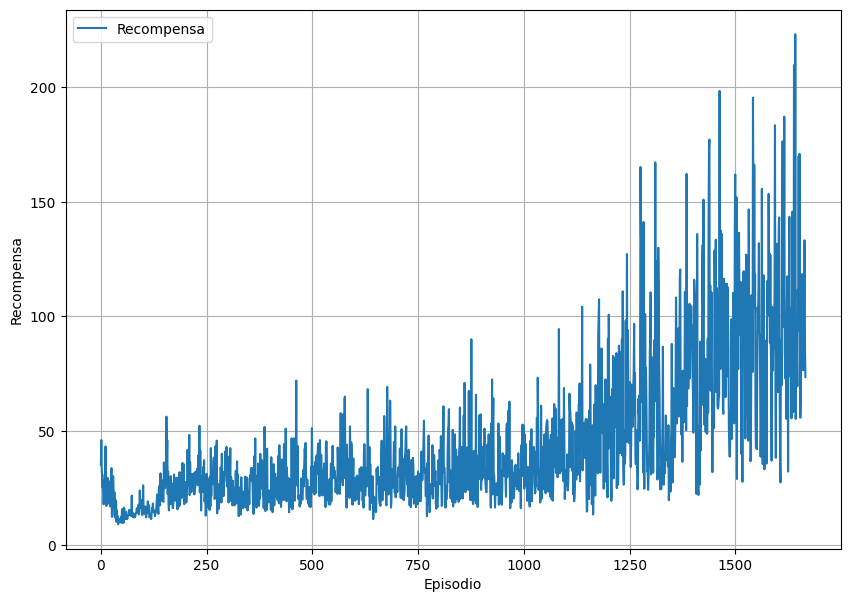

In [ ]:
retornosarsa2 = retorno_deeplearning(5,"deep_sarsa",16,50000,100000,1)

# Análisis de Resultados y Conclusiones

*  Los algoritmos que utilizan aproximación de funciones muestran un mejor desempeño, teniendo que el maximo valor de recompenza alcanzada por parte de los algoritmos tabulares fue 387 con el algoritmo SARSA con 400 estados mientras que todos los que usan redes neuronales para estimar Q llegan al máximo de 500
* A pesar de que en los algoritmos tabulares se utilizaran hasta 4000 estados diferentes, la recompesa promedio no mejoró esto debido a que se necesitan muchos más episodios de entrenamiento para lograr resultados parecidos a la versión del experimento con 400 estados, teniendo así que para 400 estados se necesitan unos 50.000 episodios para mantener la recompensa promedio sobre 200 y unos 500.000 y un epsión mayor para lograr el mismo resultado
* A partir de la curva de aprendizaje se observa que para los algoritmos tabulares para una discretización de 400, Q-Learning tiene alcanza una mayor recompensa promedio cercana a 175 en promedio, mientras que el promedio de SARSA es próximo a 80-90.
* Al comparar las curvas de aprendizaje para los  algoritmos con aproximación de funciones, se observa que para una arquitectura de 1 capa escondida de 4 neuronas se tiene una recompensa promedio máxima cercana a 300 después de 680 episodios, mientras que para una arquitectura de 1 capa escondida de 16 neuronas se tiene una recompensa promedio máxima cercana a 250 después de 280 episodios, mientras que para este rango de episodios en el aprendizaje el agente de Deep Sarsa tiene un aprendizaje inferior.
* Respecto a los algoritmos con aproximación de funciones, al momento de utilizar solo 4 neuronas en la capa escondia no se puede asegurar que independientemente de la situación inicial llegue a la meta de los 500 de recompensa, mientras que al utilizar 16 neuronas en esta capa ambos algoritmos converjen siempre a los 500 de recompensa.
* Al comparar SARSA con Q-Learnig, obtenemos que SARSA siempre tiene el mejor desempeño con pocas iteraciones de capitulos o pasos, siendo así que con SARSA tabular con 50.000 episodios tiene una recompensa promedio de 248 mientras que con Q-Learning se tiene un promedio de 110